In [1]:
# install package for displaying animation
!pip3 install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

You are using pip version 8.1.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


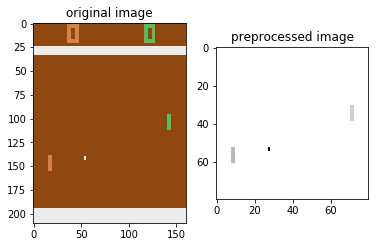

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
        self.conv = nn.Conv2d(2, 1, kernel_size=4, stride=4)
#         self.conv2 = nn.Conv2d(1, 1, kernel_size=4, stride=4)
        
        # 1 fully connected layer
        self.fc = nn.Linear(20*20, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
#         x2 = F.relu(self.conv2(x1))
        # flatten the tensor
        x = x.view(-1,20*20)
        
        y = self.fc(x)
        
        return self.sig(y)


# run your own policy!
# policy=Policy().to(device)
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [5]:
import numpy as np
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    
    ratio = new_probs/old_probs
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)
    
    
    return torch.mean(clipped_surrogate + beta*entropy)


envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

Lsur= clipped_surrogate(policy, prob, state, action, reward)
print(Lsur)

Lsur= pong_utils.clipped_surrogate(policy, prob, state, action, reward)
print(Lsur)

tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward1>)


In [6]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.4
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        #L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
        #                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

You are using pip version 8.1.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Episode: 20, score: -14.125000
[-16. -13.  -9. -15. -13. -14. -16. -17.]


Episode: 40, score: -13.625000
[-14. -16. -12.  -8. -13. -16. -16. -14.]


Episode: 60, score: -14.375000
[-12. -16. -15. -14. -11. -15. -16. -16.]


Episode: 80, score: -14.625000
[-16. -15. -16. -16. -11. -16. -14. -13.]


Episode: 100, score: -13.500000
[-14. -16. -12. -12. -16. -13. -13. -12.]


Episode: 120, score: -13.750000
[-14. -12. -14. -14. -13. -16. -14. -13.]


Episode: 140, score: -12.125000
[ -8. -15. -11. -14. -13. -15. -11. -10.]


Episode: 160, score: -14.125000
[-16.  -9. -12. -15. -16. -16. -14. -15.]


Episode: 180, score: -10.750000
[ -9. -11. -11.  -9. -13. -11. -11. -11.]


Episode: 200, score: -10.125000
[-14.  -6.  -6.  -7. -12. -14. -13.  -9.]


Episode: 220, score: -6.875000
[ -3.  -5. -10.  -8.  -4.  -6. -13.  -6.]


Episode: 240, score: -5.375000
[ -2.  -8.   0. -10.  -7.  -2. -10.  -4.]


Episode: 260, score: -3.500000
[-5. -6.  0. -6. -3. -1. -8.  1.]


Episode: 280, score: -4.375000
[-5. -7. -1. -1. -7. -7. -2. -5.]


Episode: 300, score: -1.250000
[-4. -1. -1. -1.  0. -1. -1. -1.]


Episode: 320, score: -2.375000
[ -1.  -2. -10.  -1.  -2.   0.  -1.  -2.]


Episode: 340, score: -1.750000
[ 1.  1. -1.  1. -5.  0. -7. -4.]


Episode: 360, score: -0.750000
[-1. -1. -1.  0. -1.  0. -1. -1.]


Episode: 380, score: -0.625000
[ 0.  0.  0. -1. -3.  3.  0. -4.]


Episode: 400, score: -0.875000
[-1. -1. -1.  0. -1. -2.  0. -1.]


Episode: 420, score: -0.875000
[-3. -1.  0. -1.  0.  0. -1. -1.]


Episode: 440, score: 0.000000
[ 0.  1. -1.  0. -1.  0.  1.  0.]


Episode: 460, score: -0.250000
[ 0.  1. -1.  0.  0.  0. -1. -1.]


Episode: 480, score: 0.500000
[ 1.  0.  1.  1.  0.  1. -1.  1.]


Episode: 500, score: -0.500000
[ 1.  1.  0. -1. -1. -4.  0.  0.]


Episode: 520, score: -0.500000
[-2. -2.  1. -1.  1.  0. -1.  0.]


Episode: 540, score: 0.500000
[ 1.  0.  1.  1.  0.  1. -1.  1.]


Episode: 560, score: 0.750000
[1. 0. 1. 1. 0. 1. 1. 1.]


Episode: 580, score: 0.500000
[ 1. -1.  0.  1.  1.  1.  0.  1.]


Episode: 600, score: 0.375000
[ 1.  1.  1.  1.  1.  0.  1. -3.]


Episode: 620, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 640, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 660, score: 0.375000
[ 1.  1. -3.  1.  0.  1.  1.  1.]


Episode: 680, score: 0.750000
[ 1.  1.  1. -1.  1.  1.  1.  1.]


Episode: 700, score: 0.875000
[1. 0. 1. 1. 1. 1. 1. 1.]


Episode: 720, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 740, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 760, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 780, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 800, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 820, score: 0.875000
[1. 1. 0. 1. 1. 1. 1. 1.]


Episode: 840, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 860, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 880, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 900, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 920, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 940, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 960, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 980, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1000, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1020, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1040, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1060, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1080, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1100, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1120, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1140, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1160, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1180, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1200, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1220, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1240, score: 0.750000
[ 1.  1.  1.  1.  1. -1.  1.  1.]


Episode: 1260, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1280, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1300, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1320, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1340, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1360, score: 0.750000
[ 1.  1. -1.  1.  1.  1.  1.  1.]


Episode: 1380, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1400, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1420, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1440, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1460, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1480, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1500, score: 1.000000
[1. 1. 1. 1. 1. 1. 1. 1.]



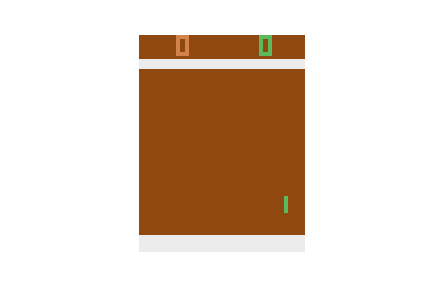
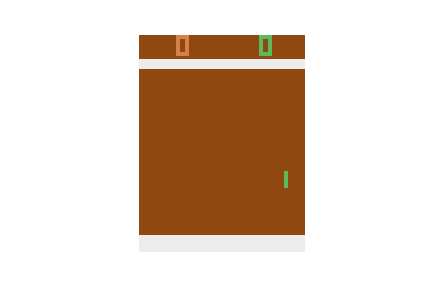
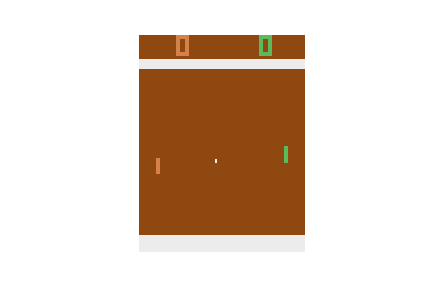
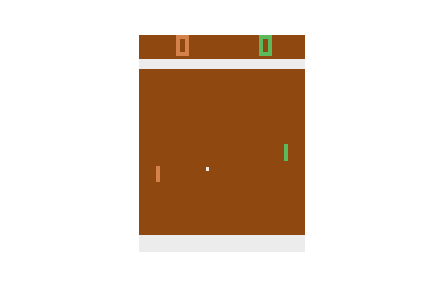
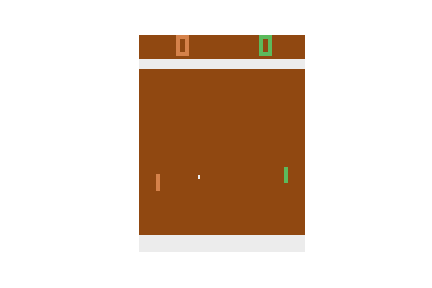
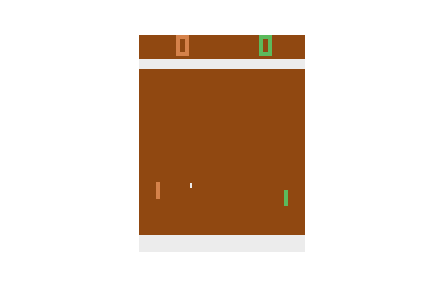
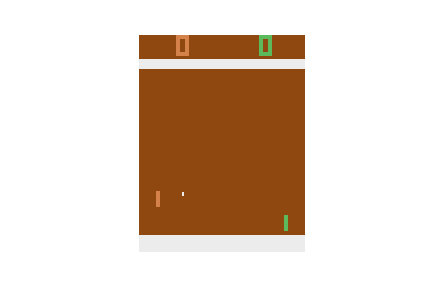
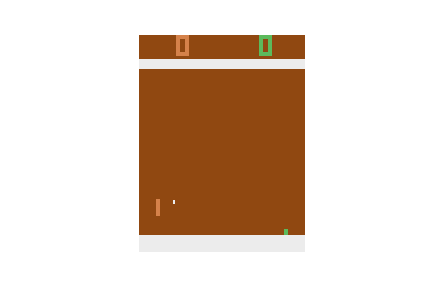
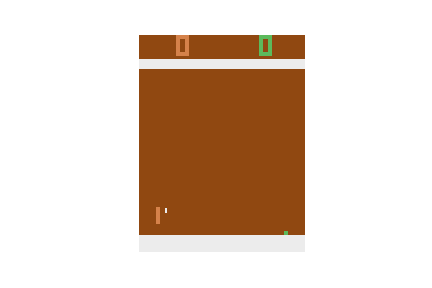
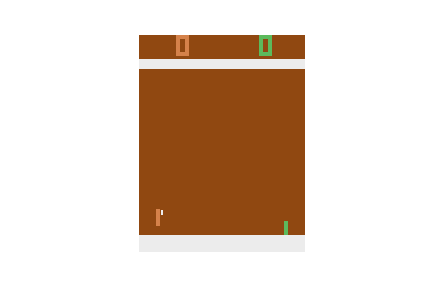
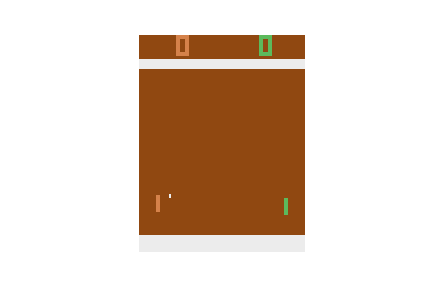
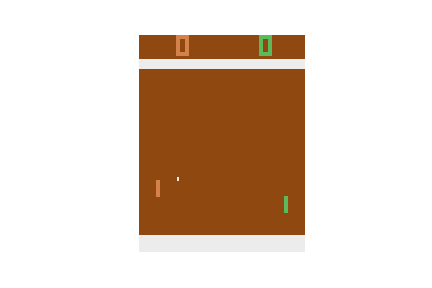
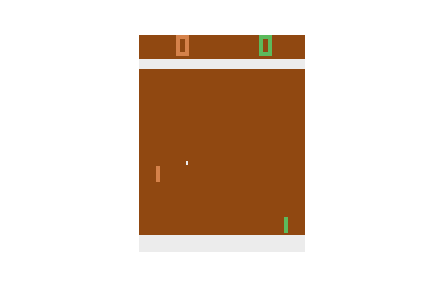
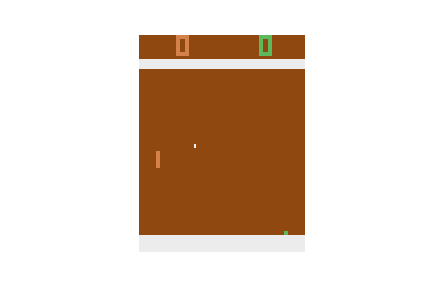
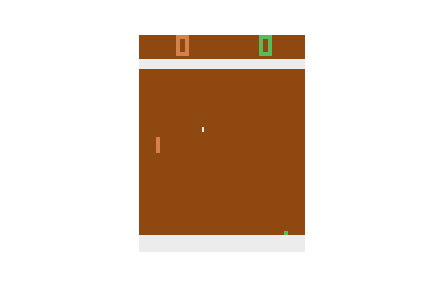
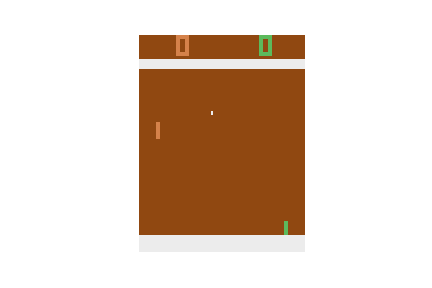
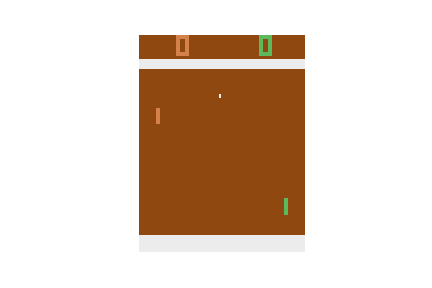
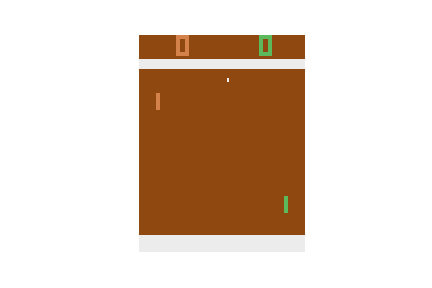
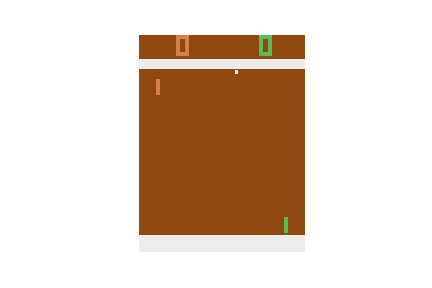
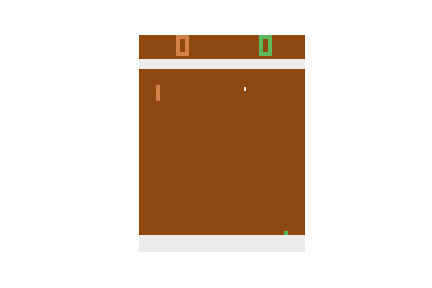
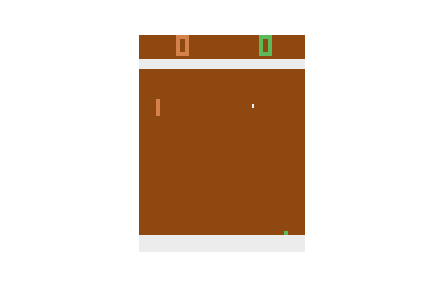
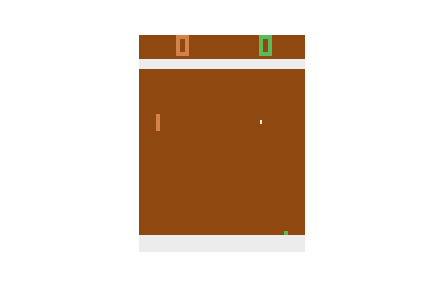
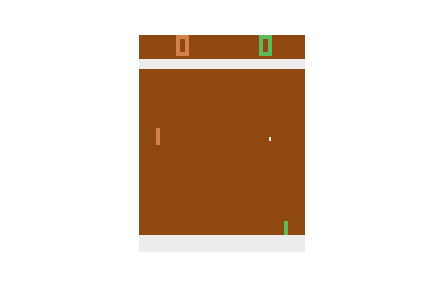
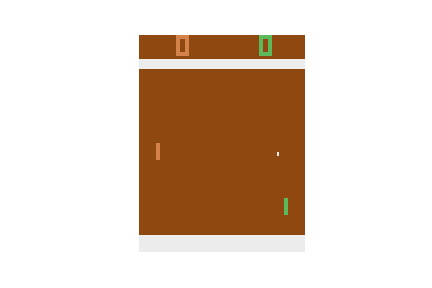
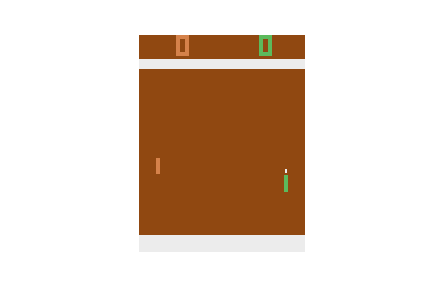
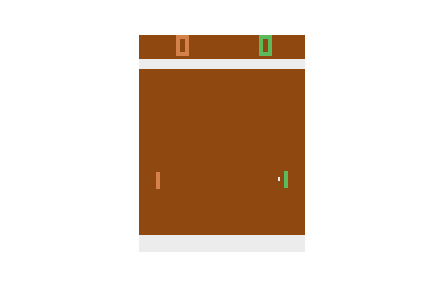
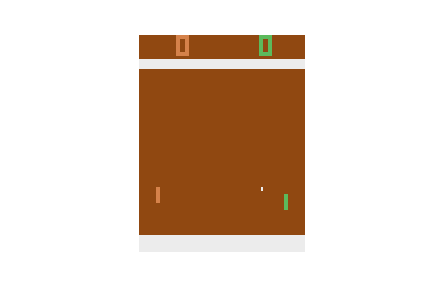
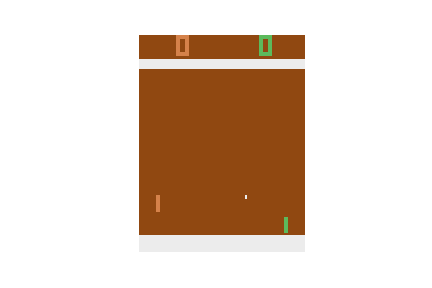
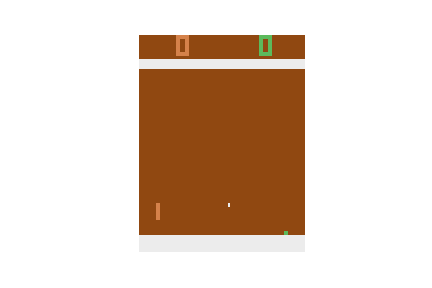
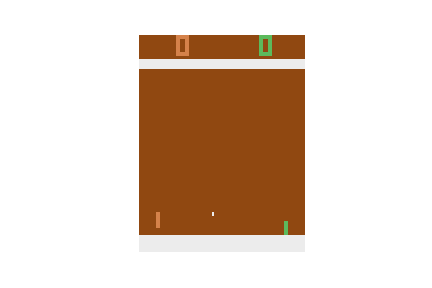
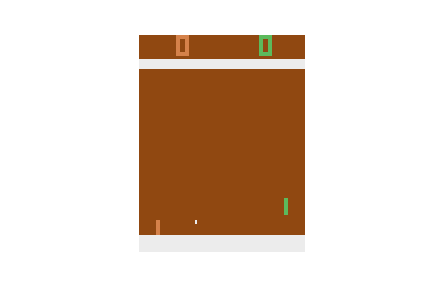
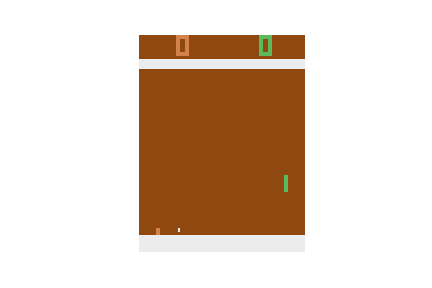
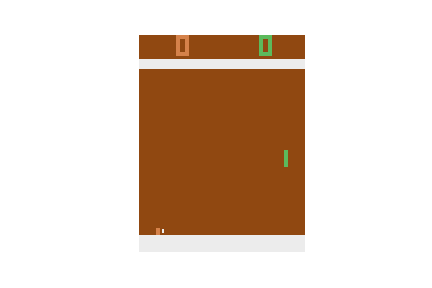
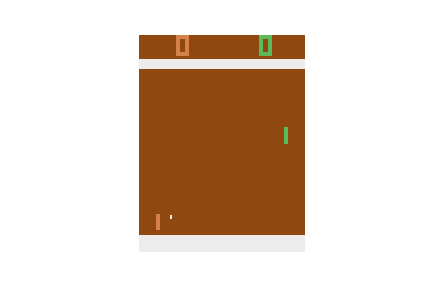
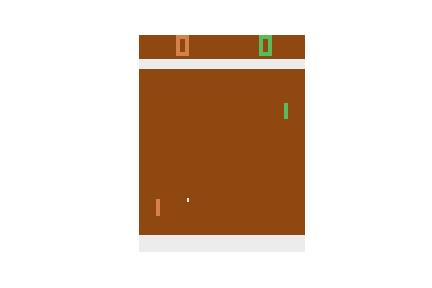
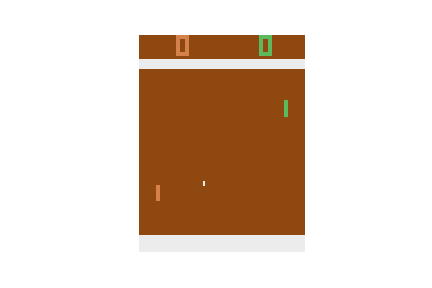
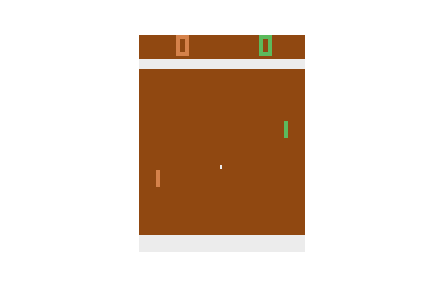
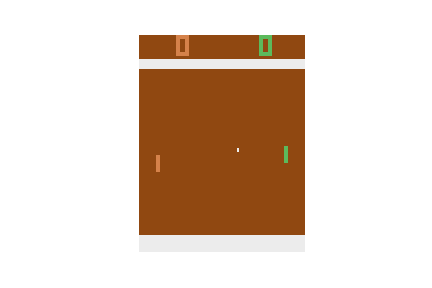
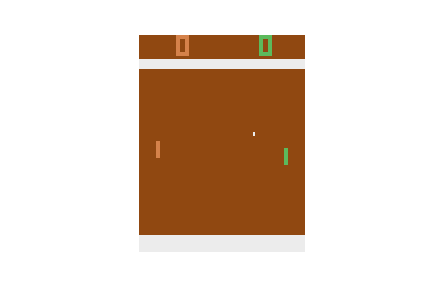
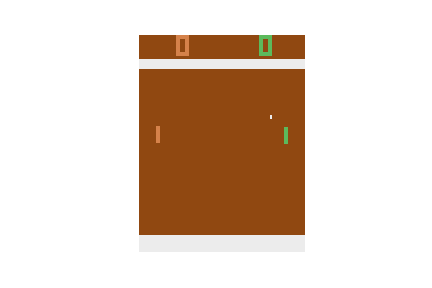
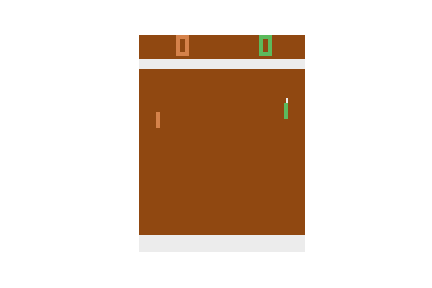
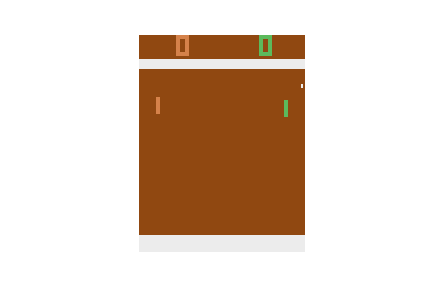
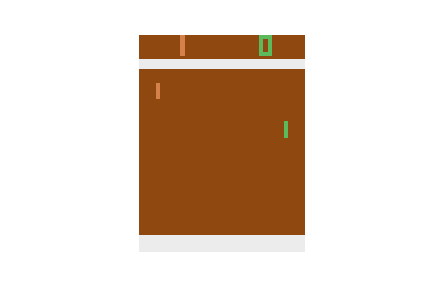
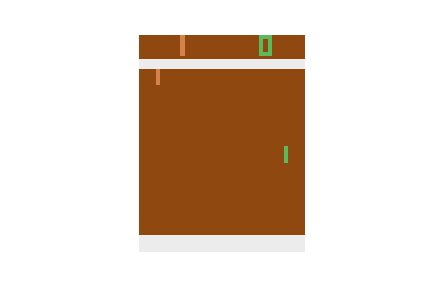
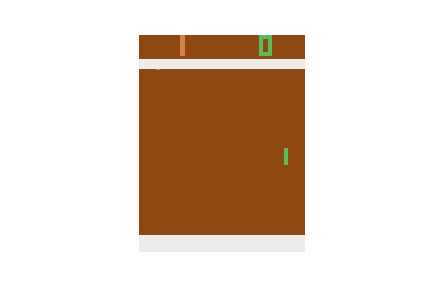
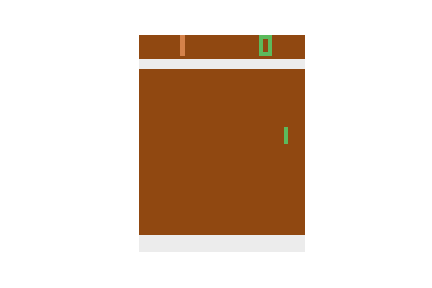
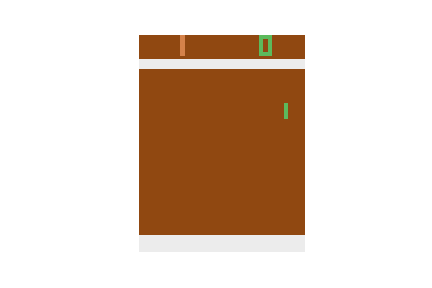
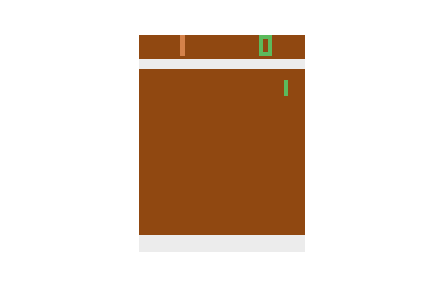
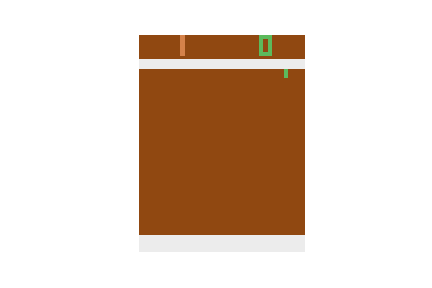
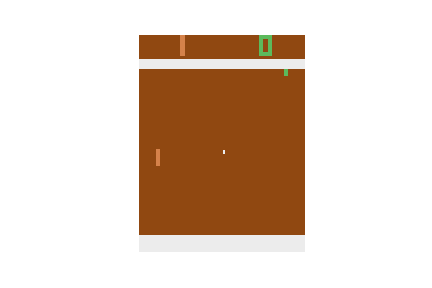
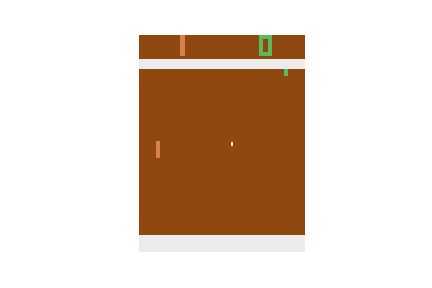
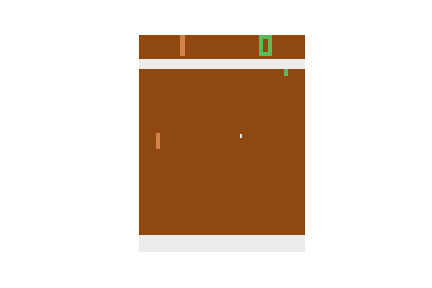
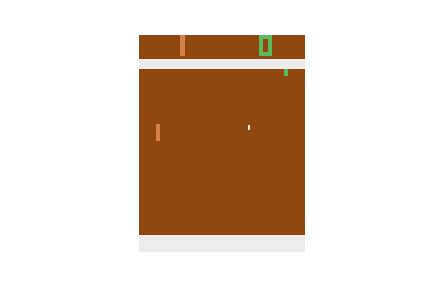
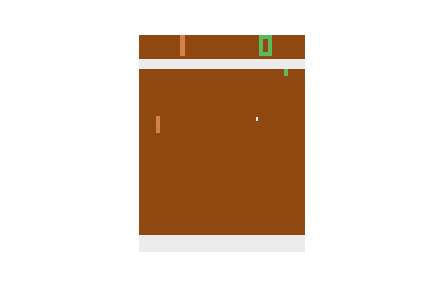
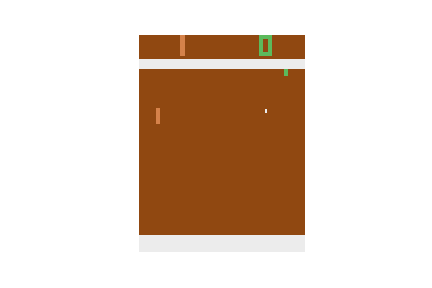
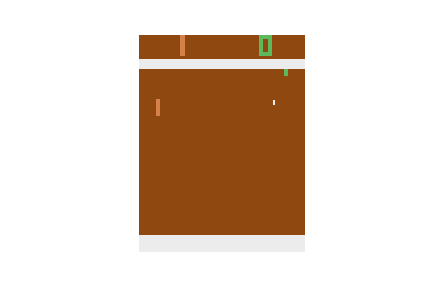
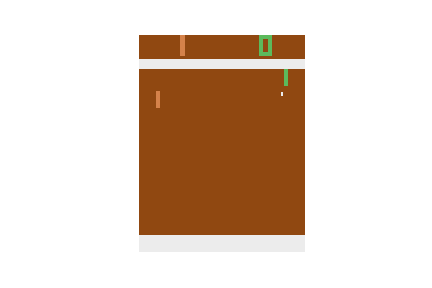
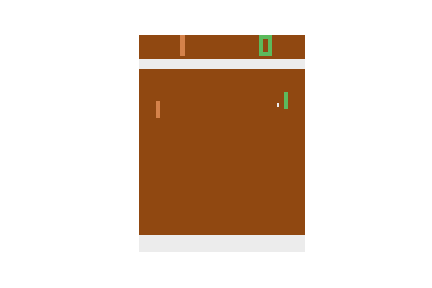
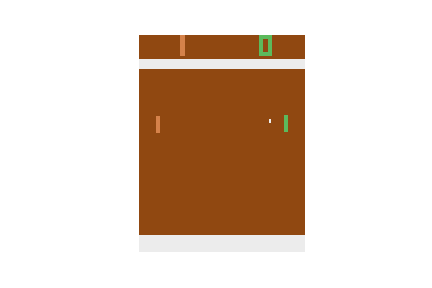
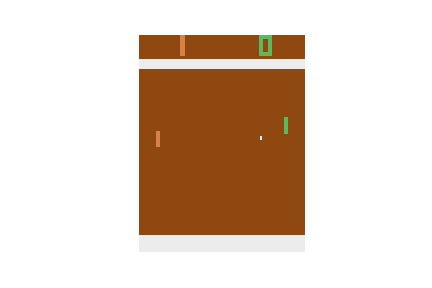
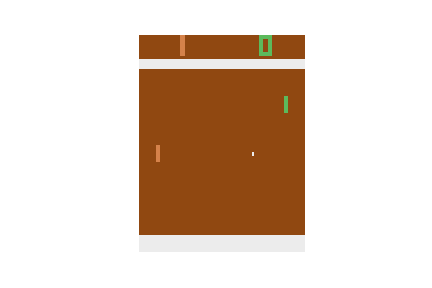
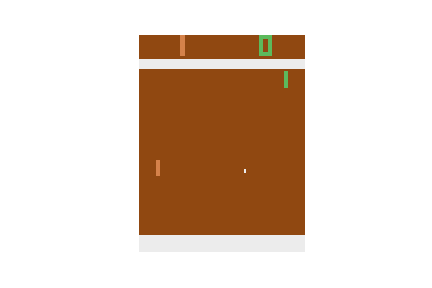
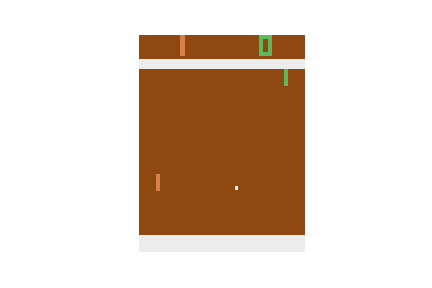
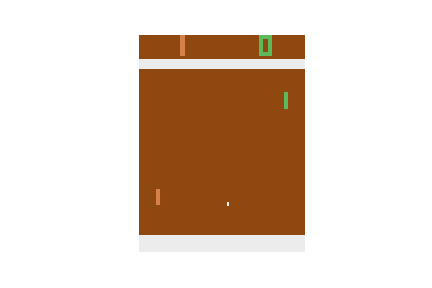
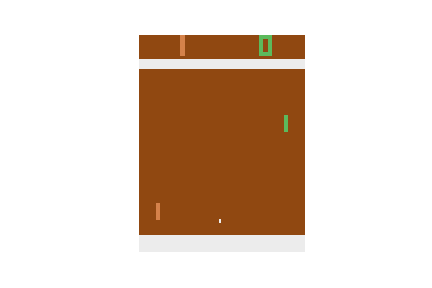
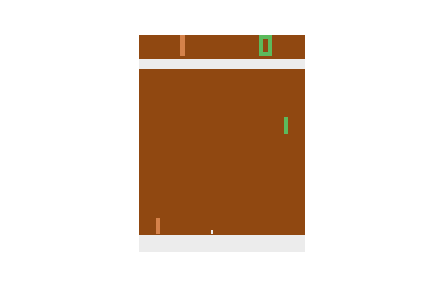
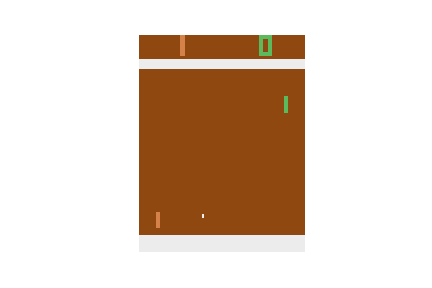
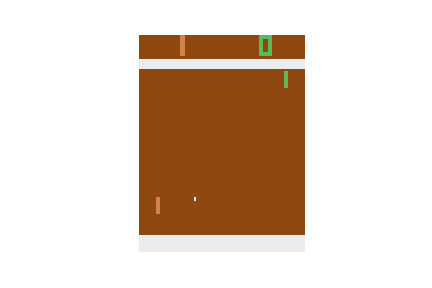
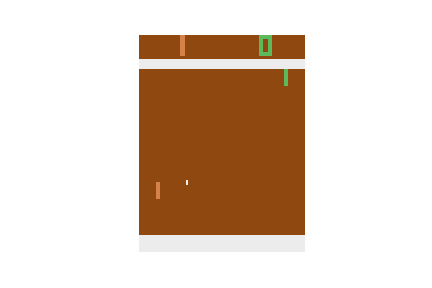
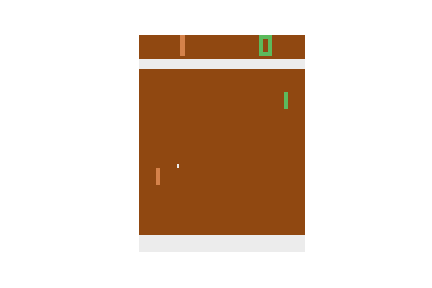
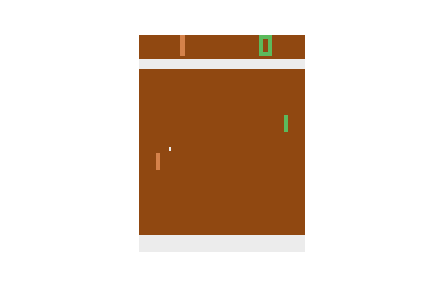
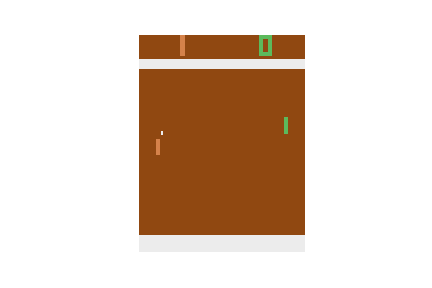
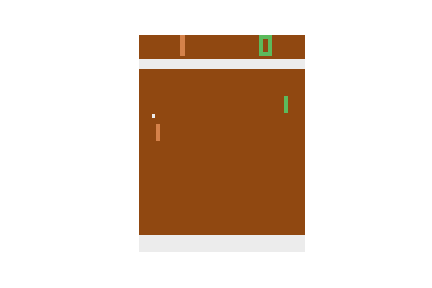
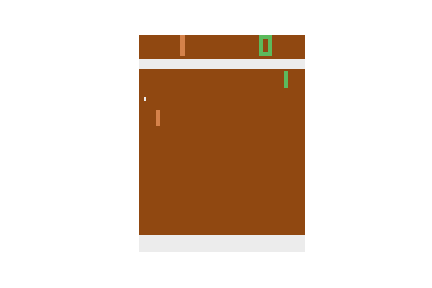
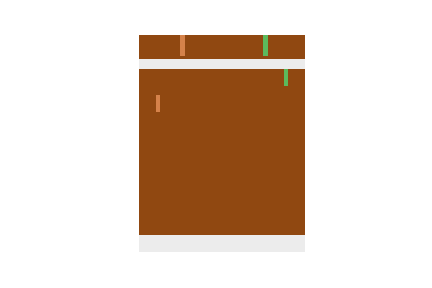
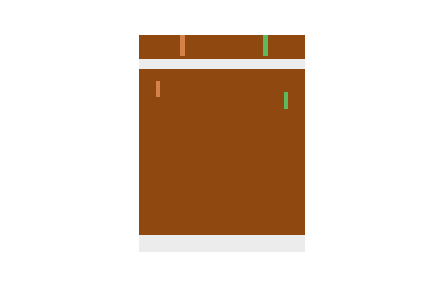
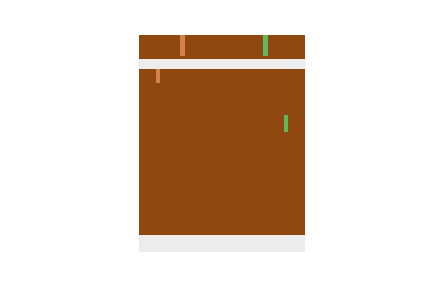
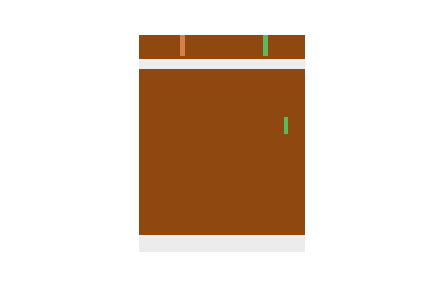
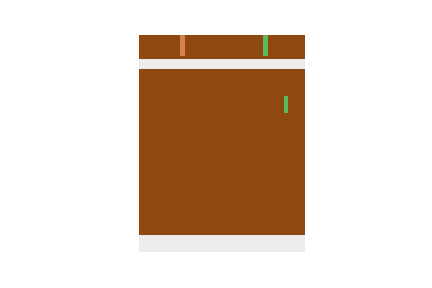
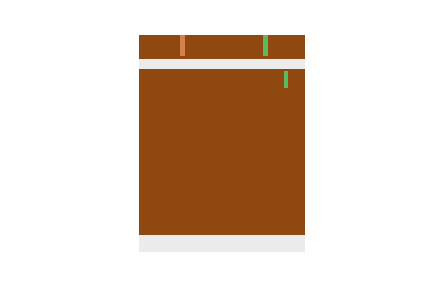
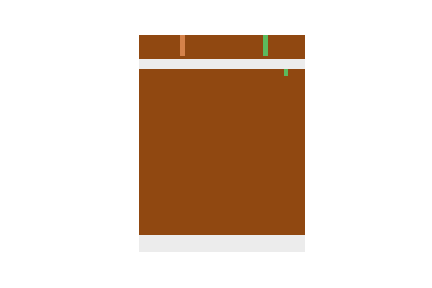
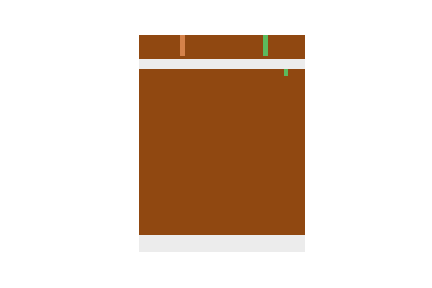
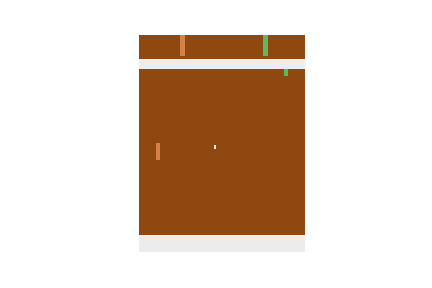
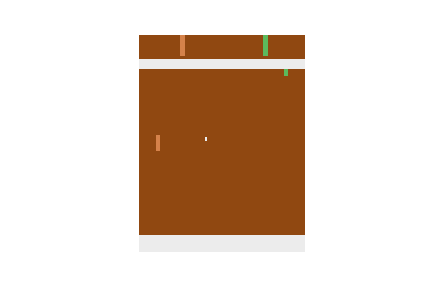
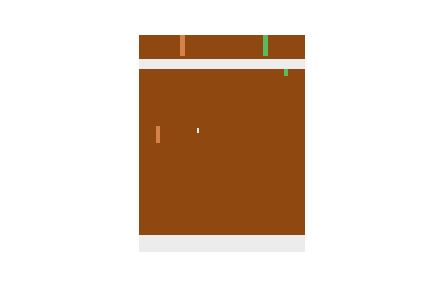
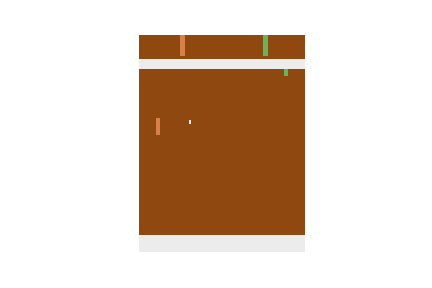
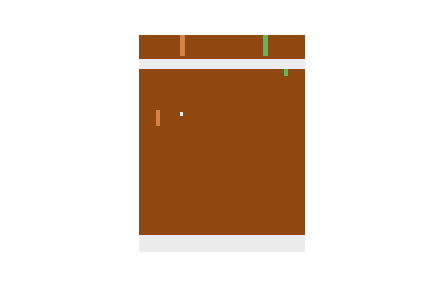
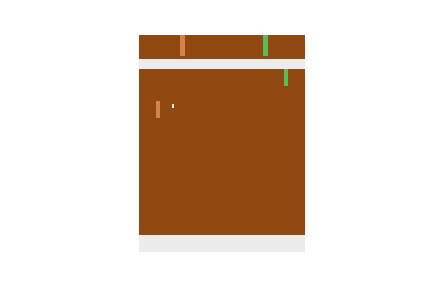
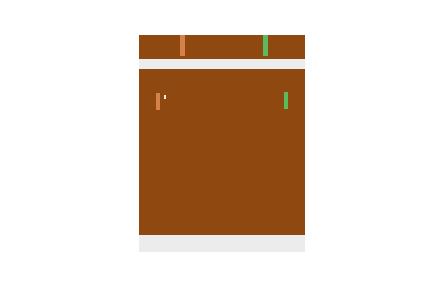
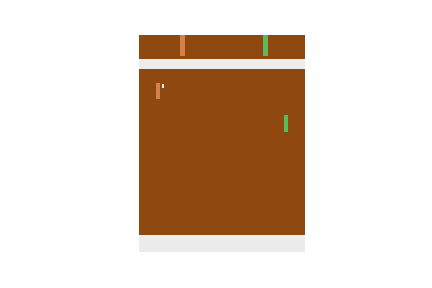
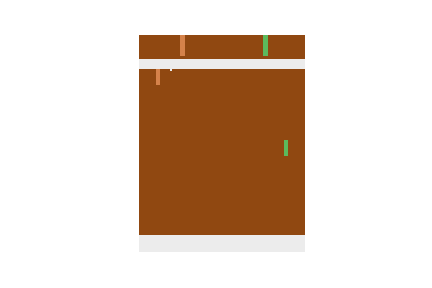
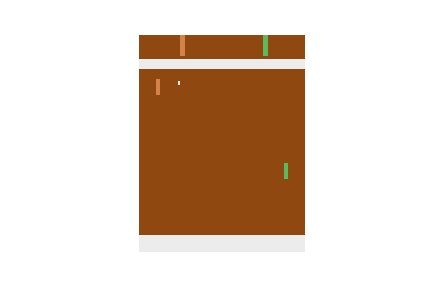
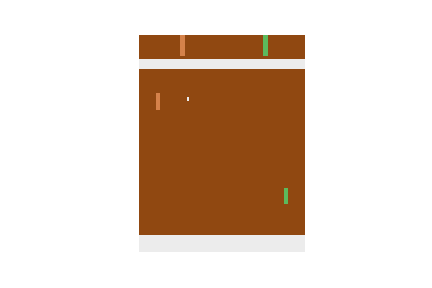
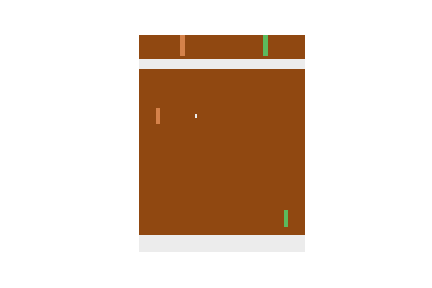
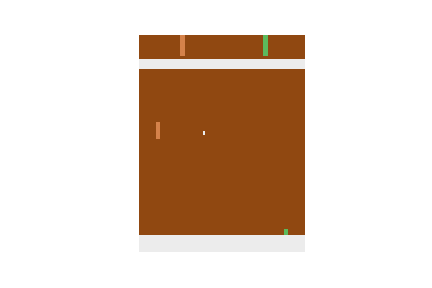
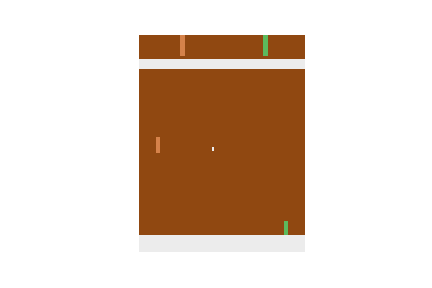
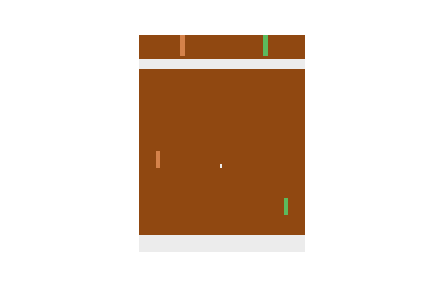
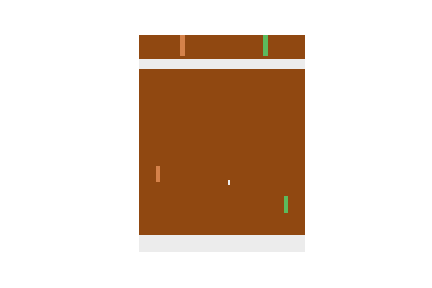
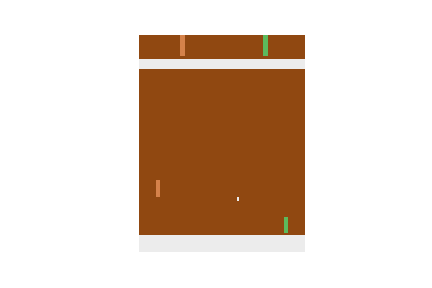
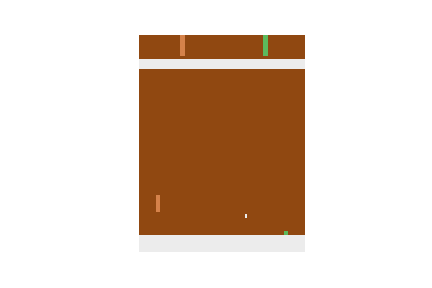
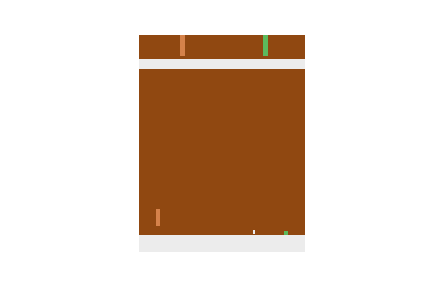
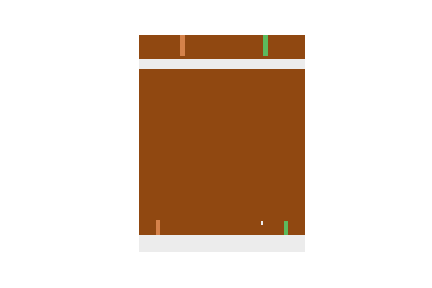
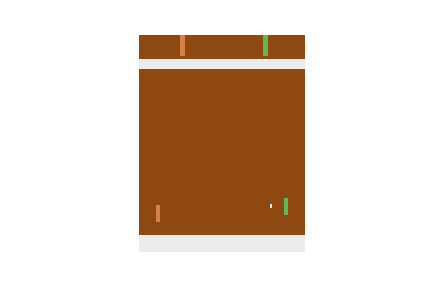
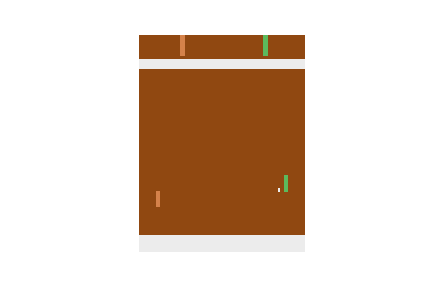
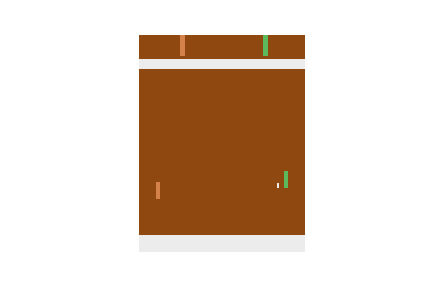
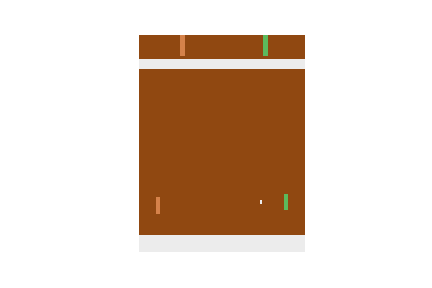
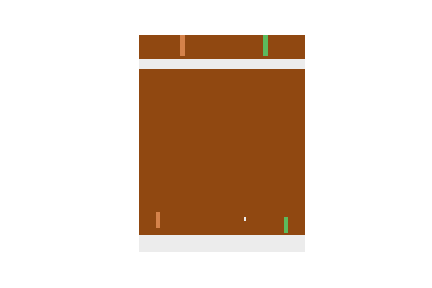
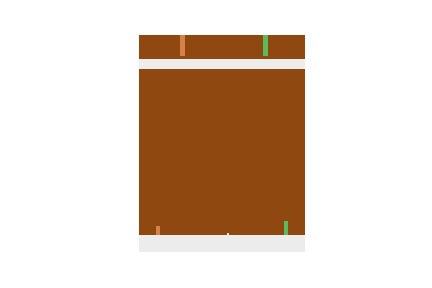
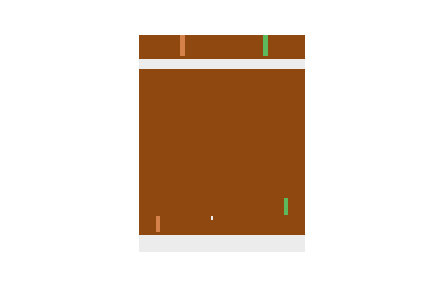
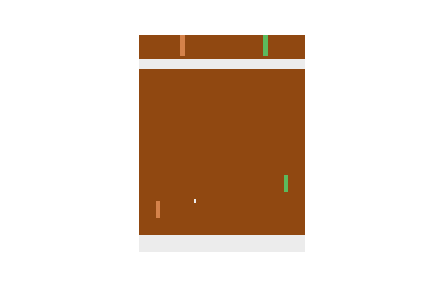
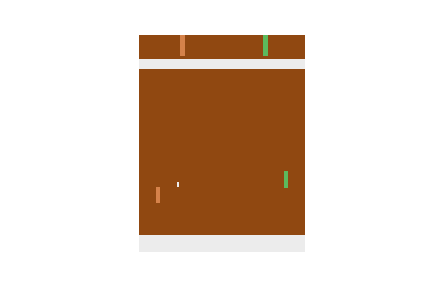
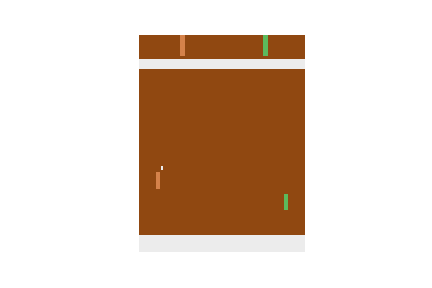
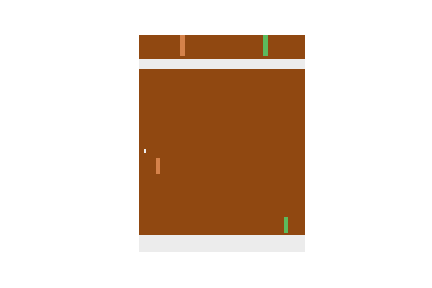
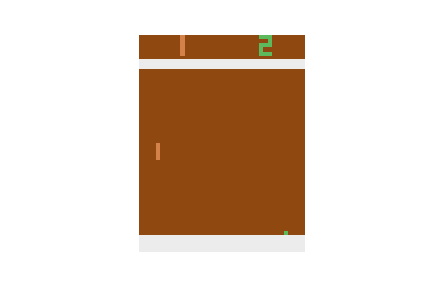
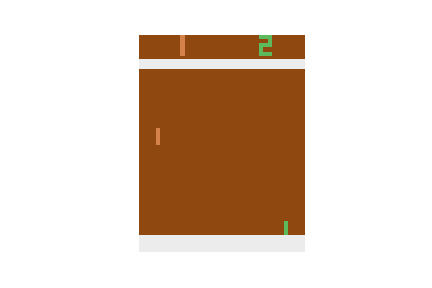
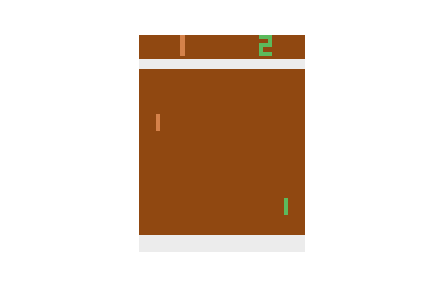
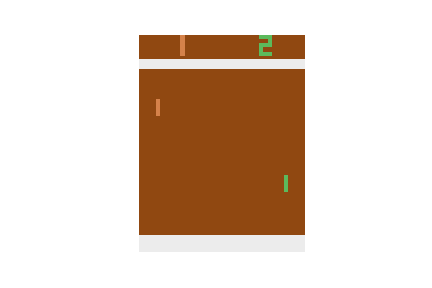
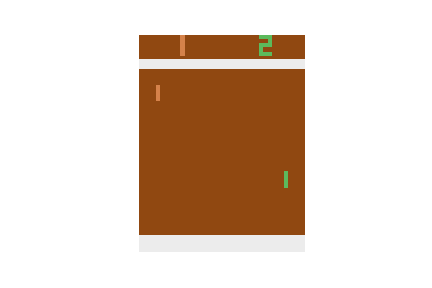
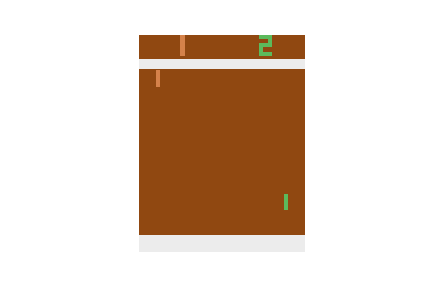
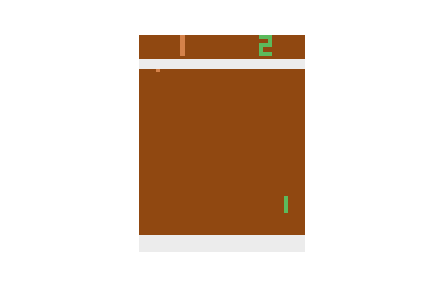
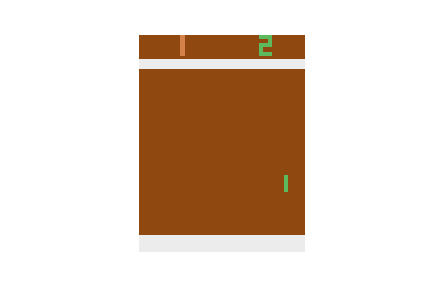
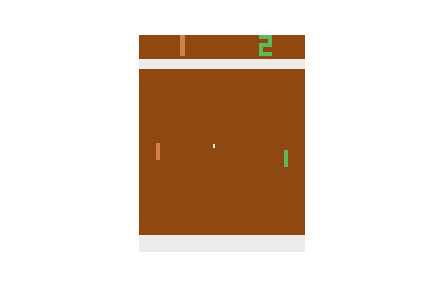
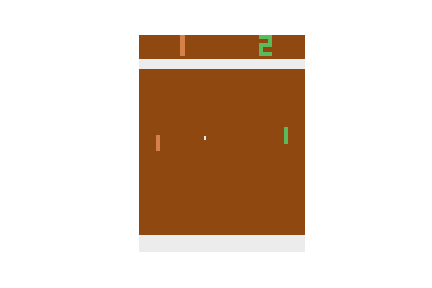
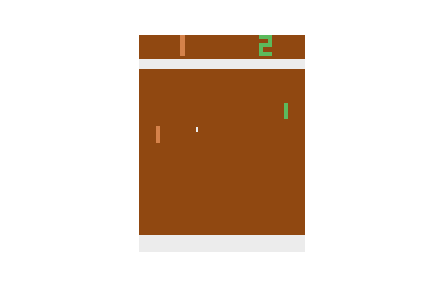
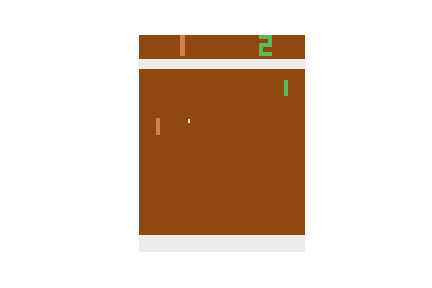
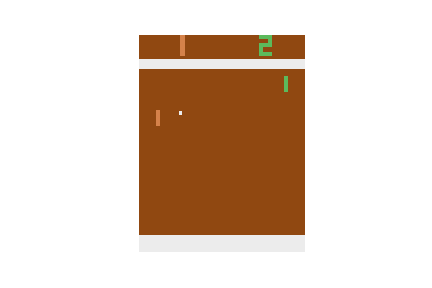
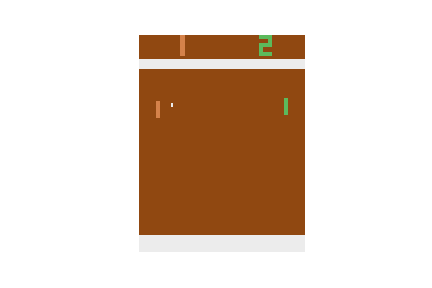
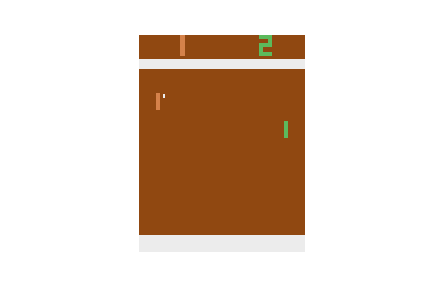
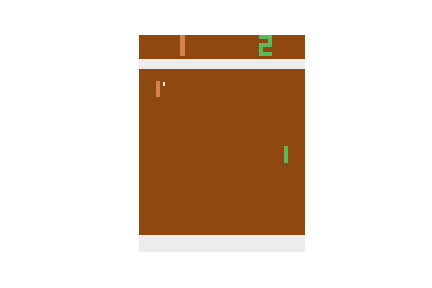
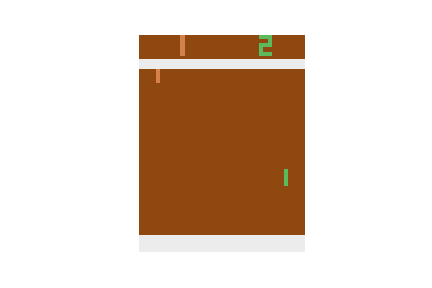
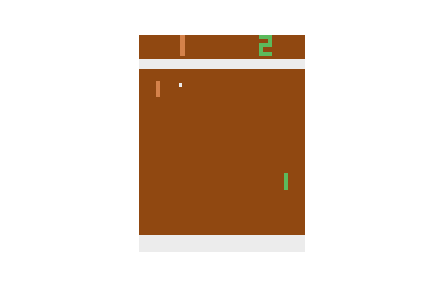
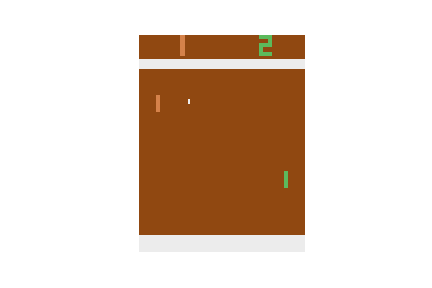
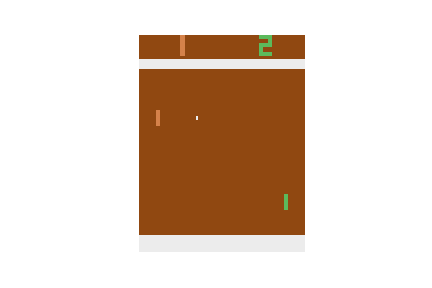
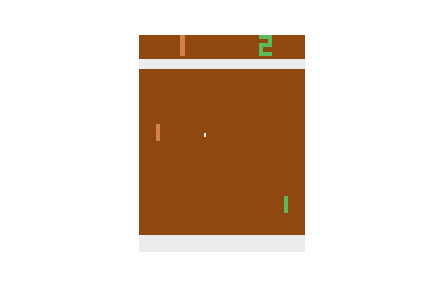
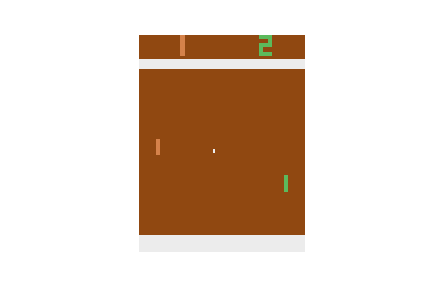
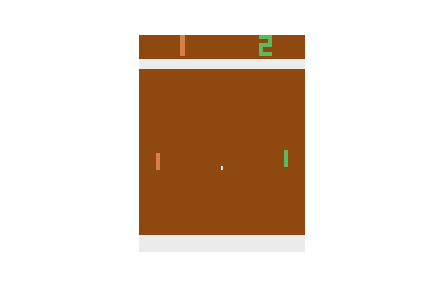
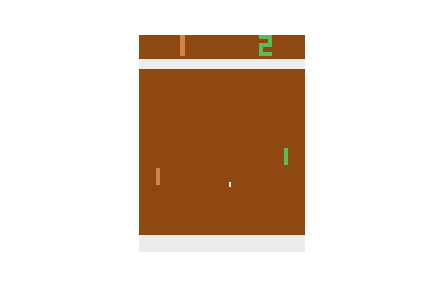
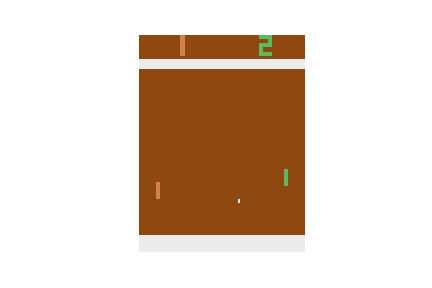
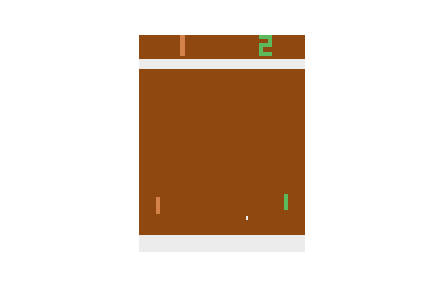
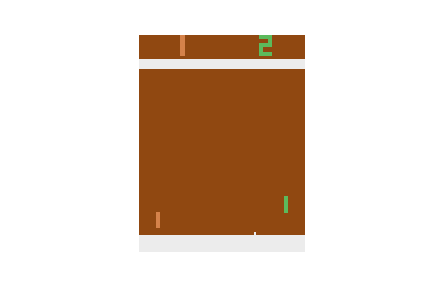
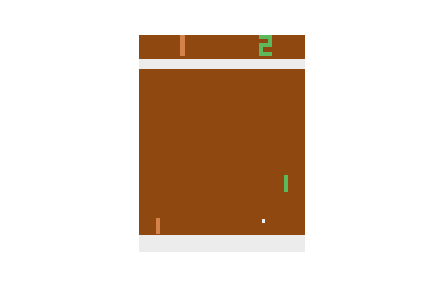
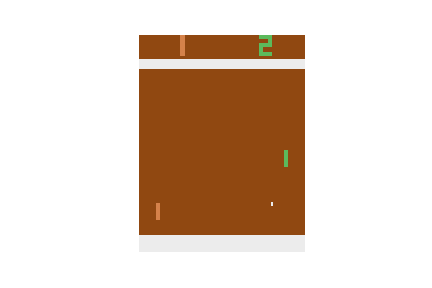
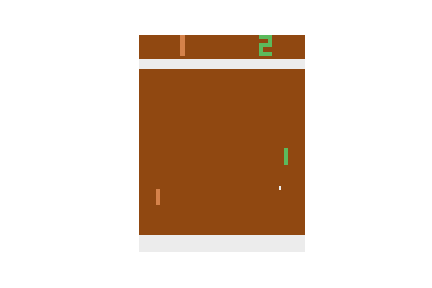
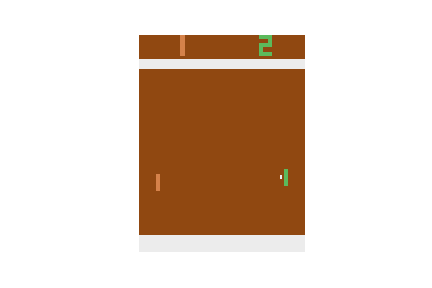
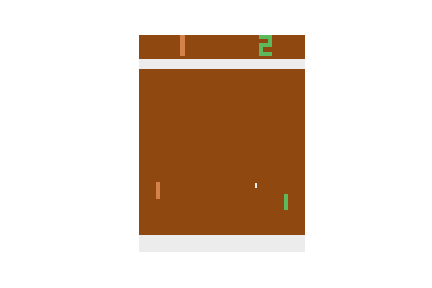
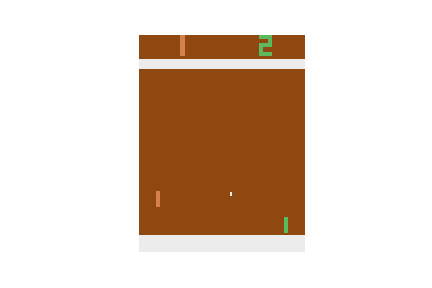
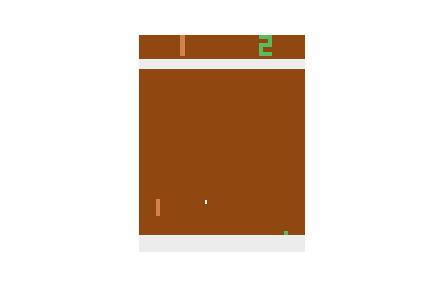
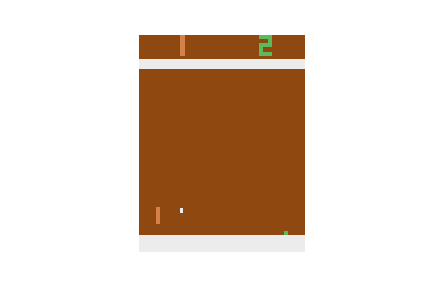
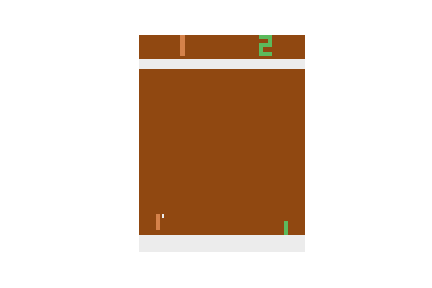
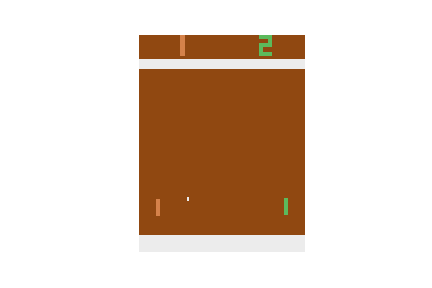
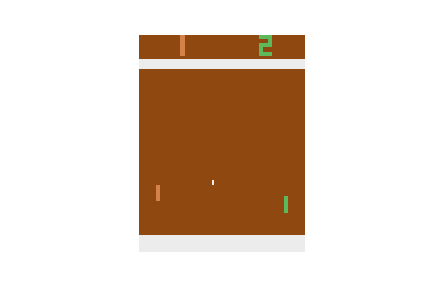
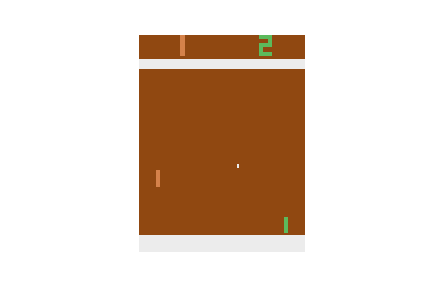
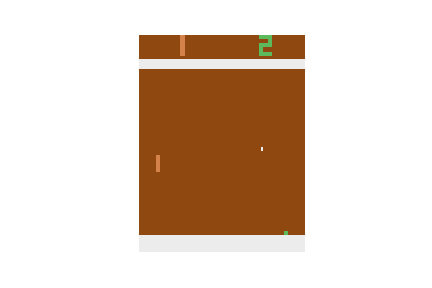
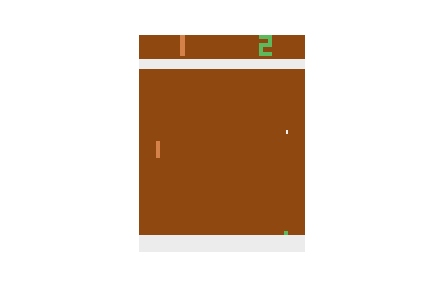
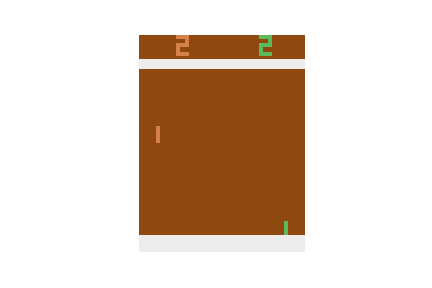
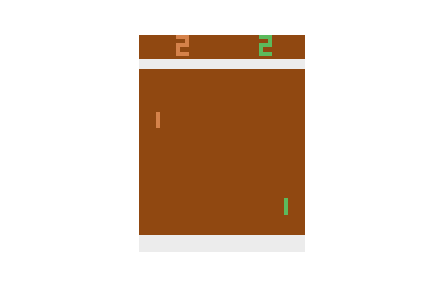
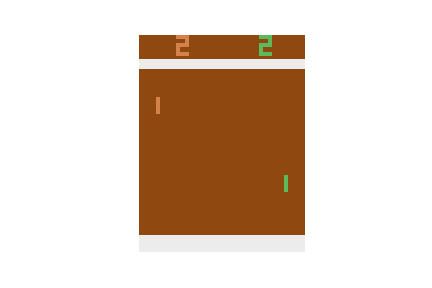
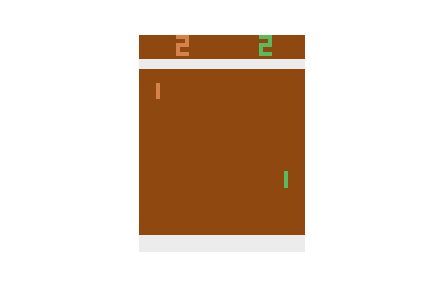
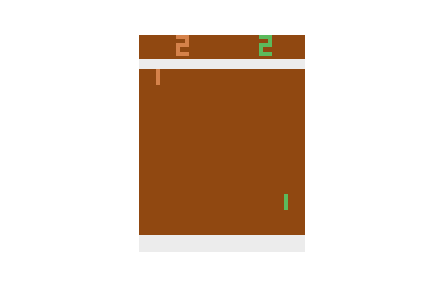
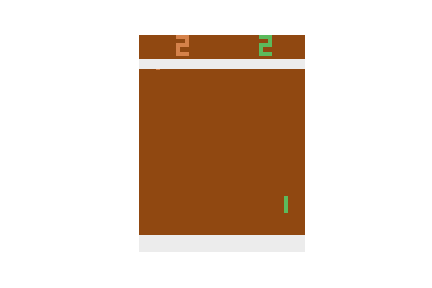
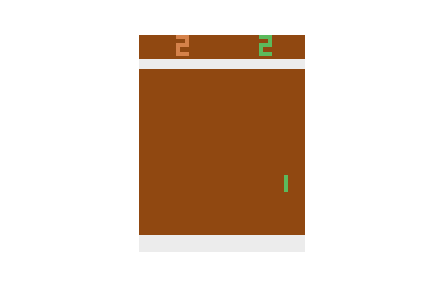
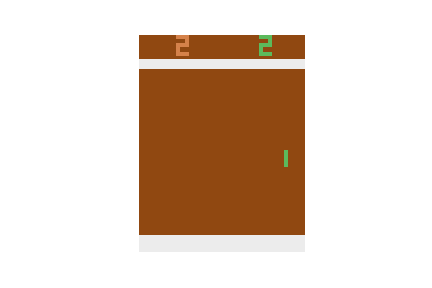
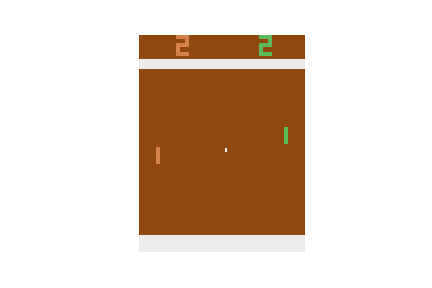
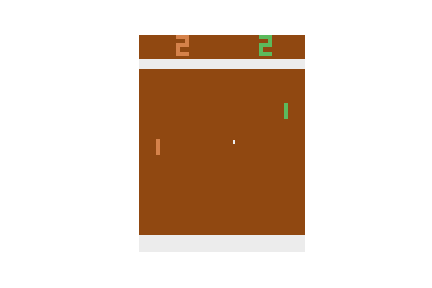
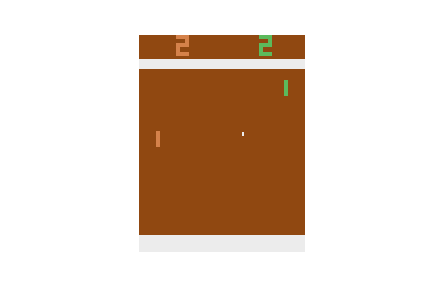
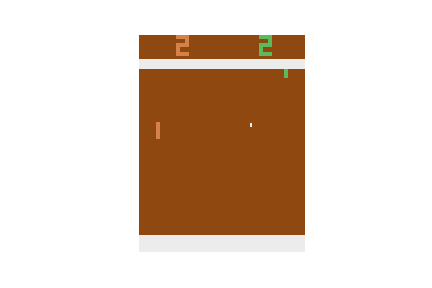
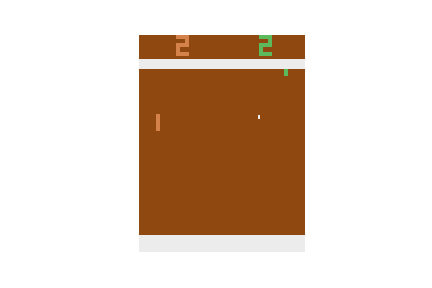
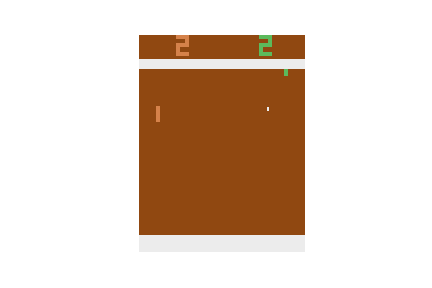
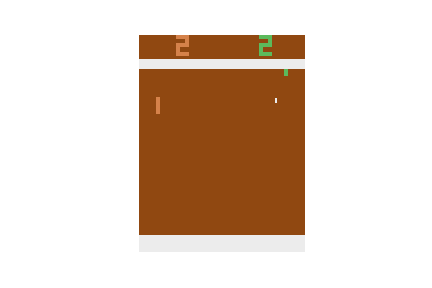
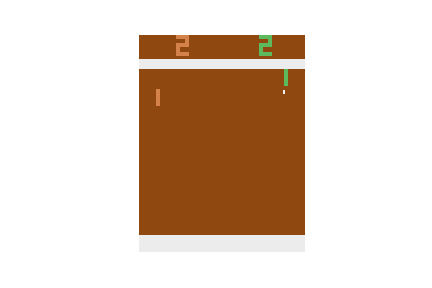
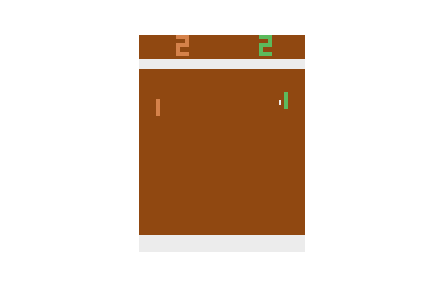
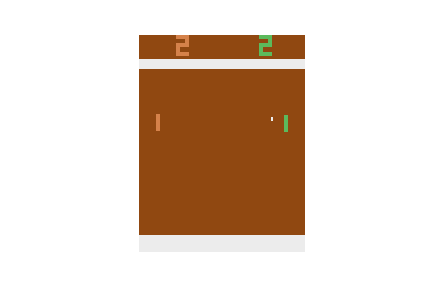
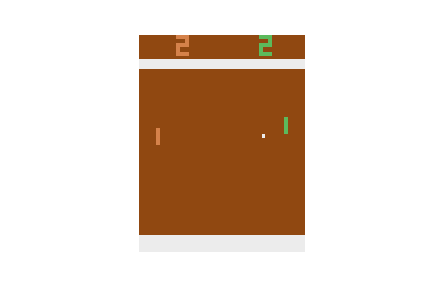
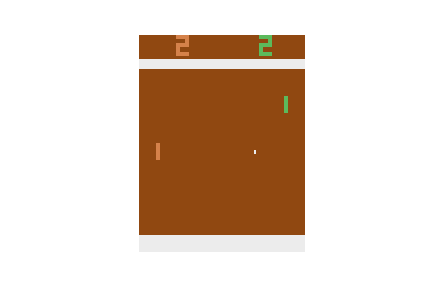
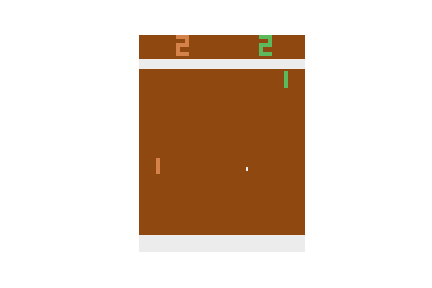
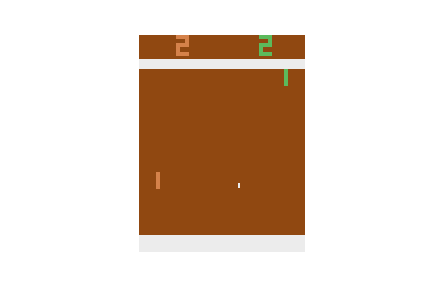
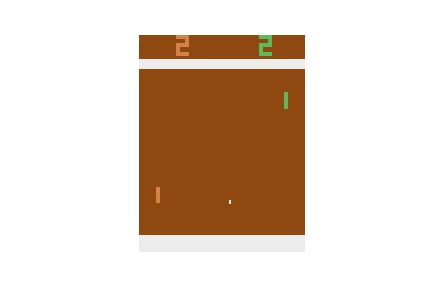
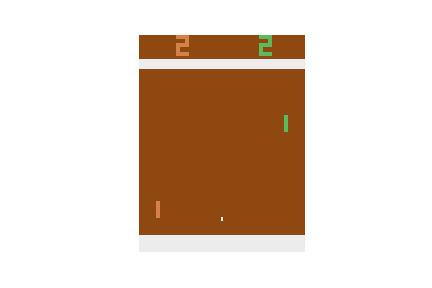
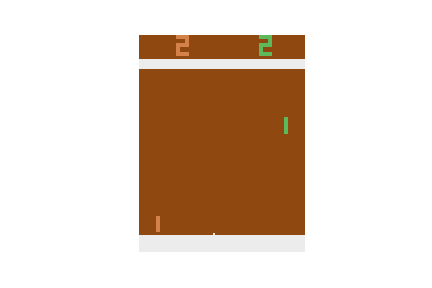
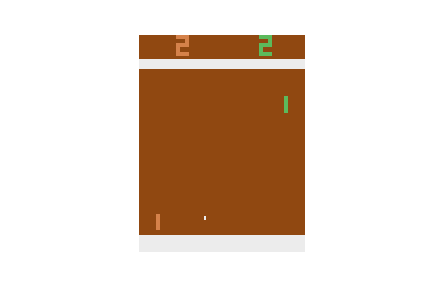
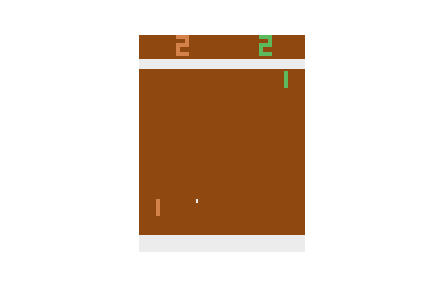
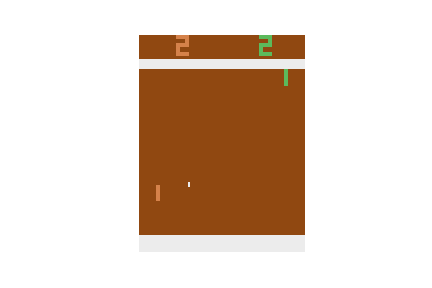
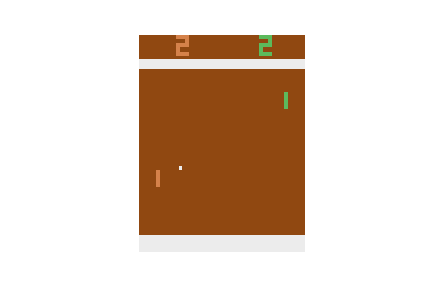
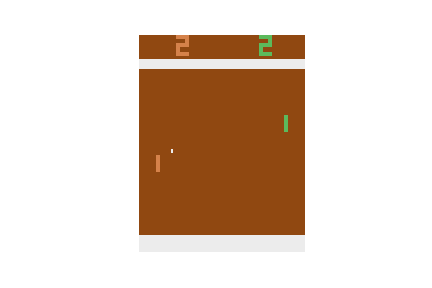
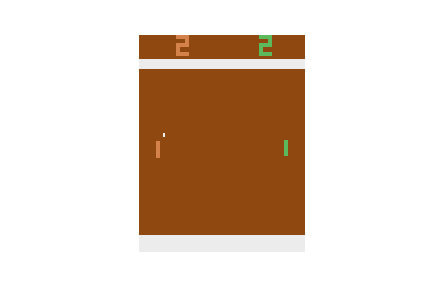
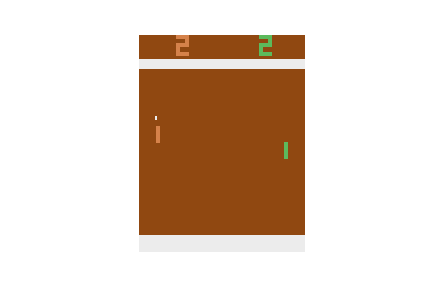
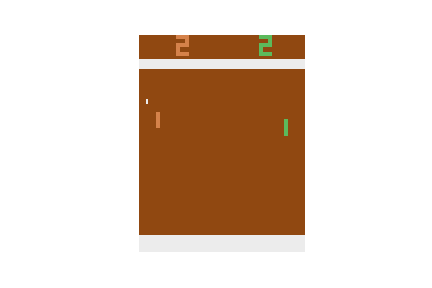
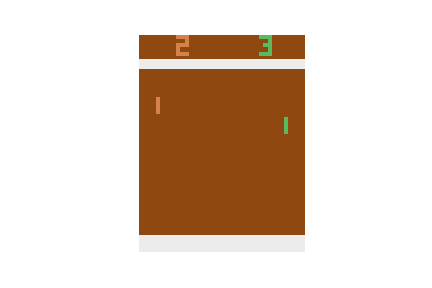
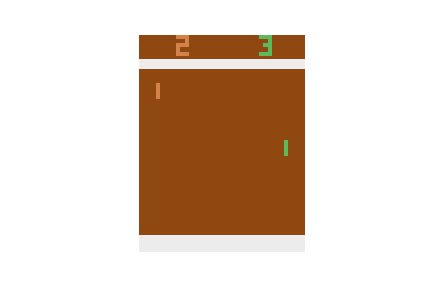
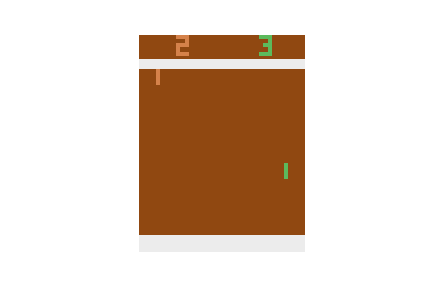
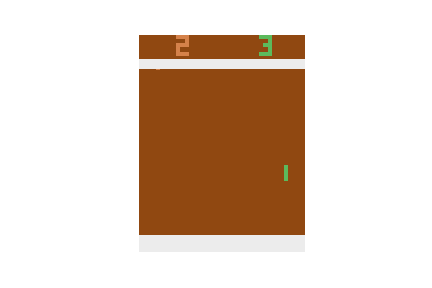
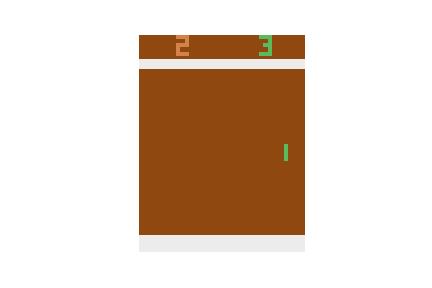
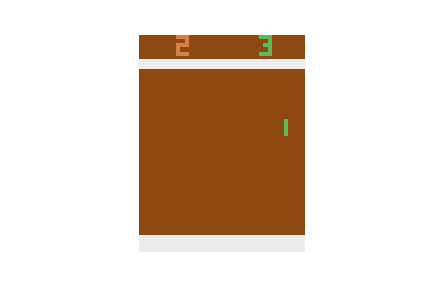
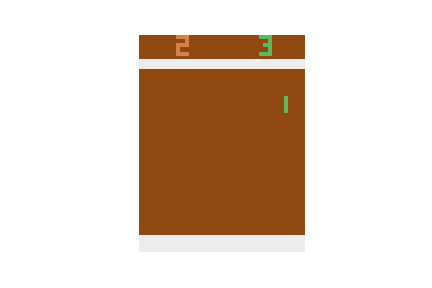
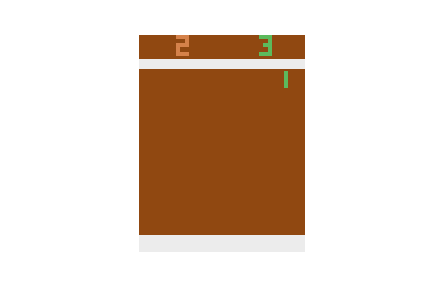
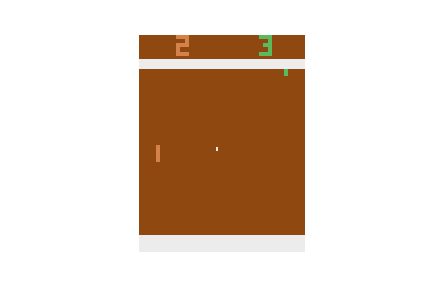
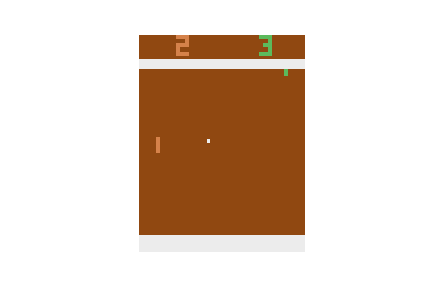
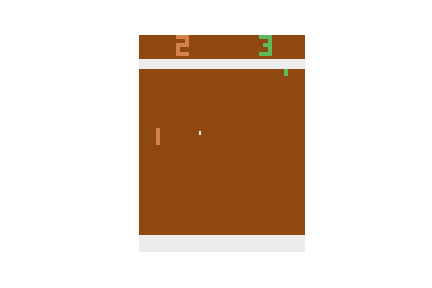
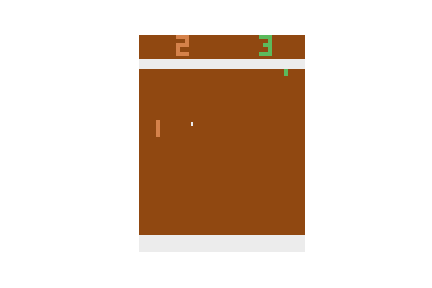
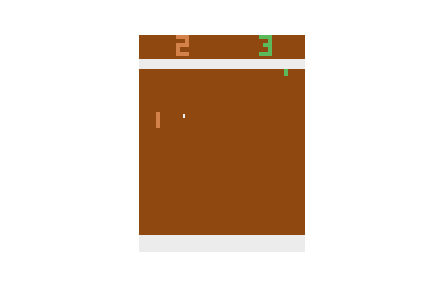
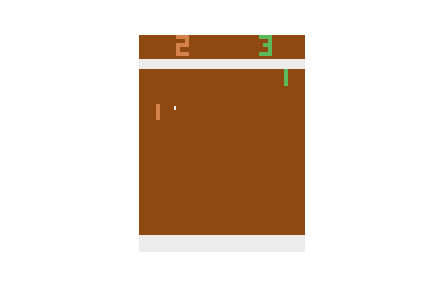
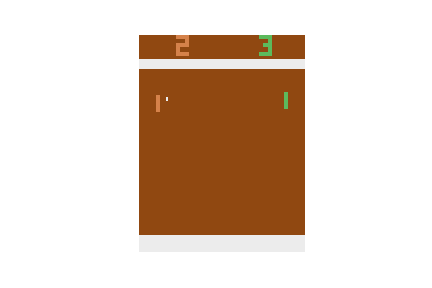
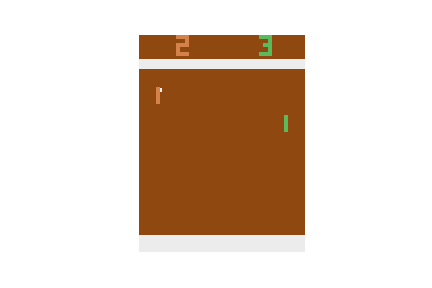
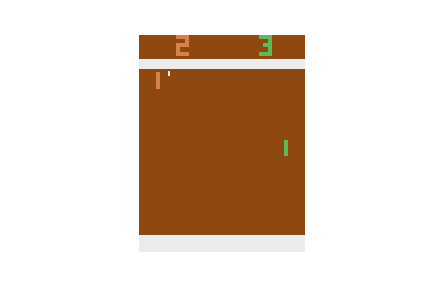
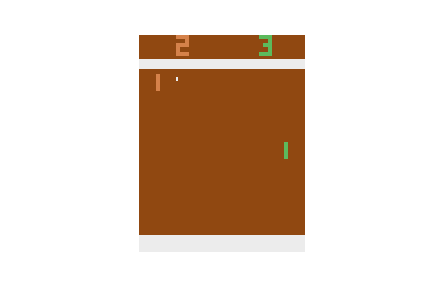
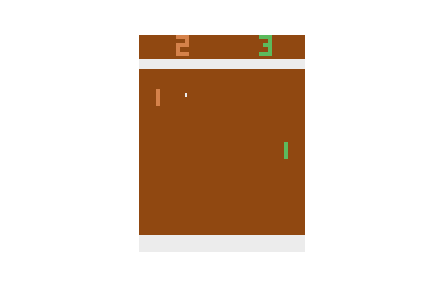
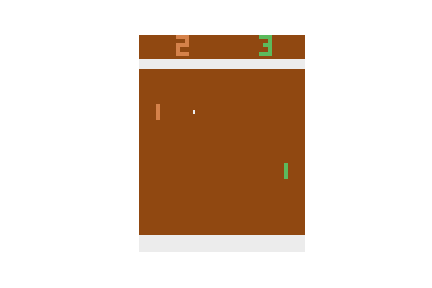
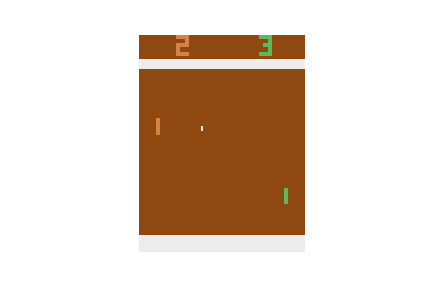
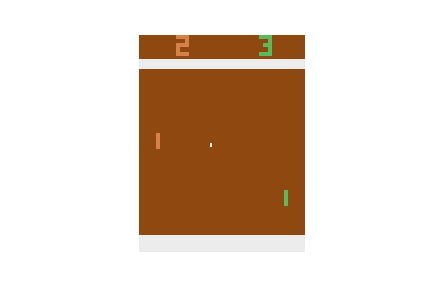
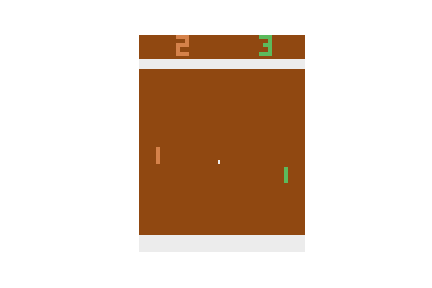
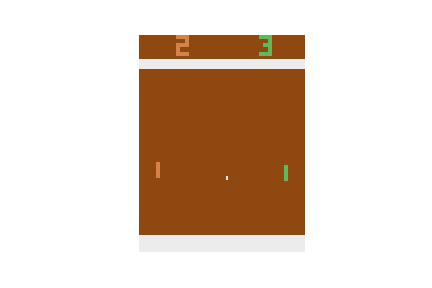
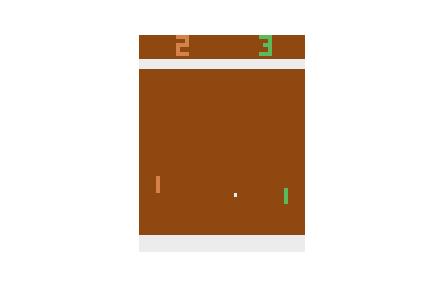
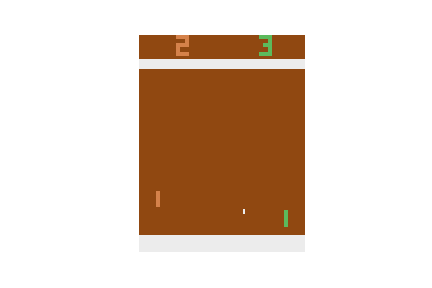
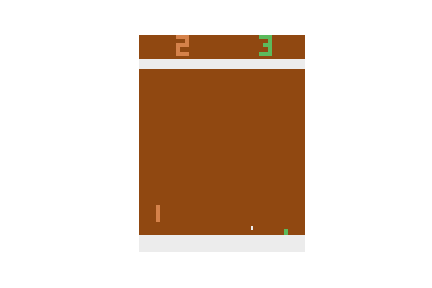
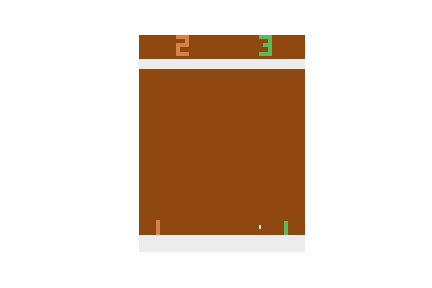
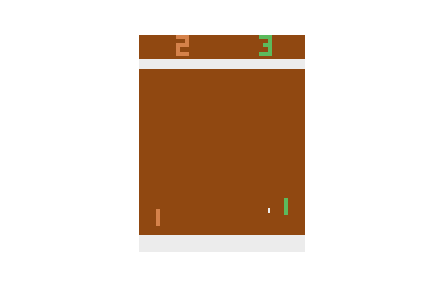
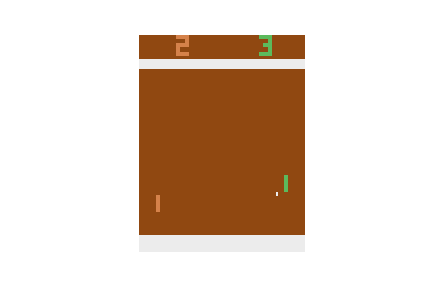
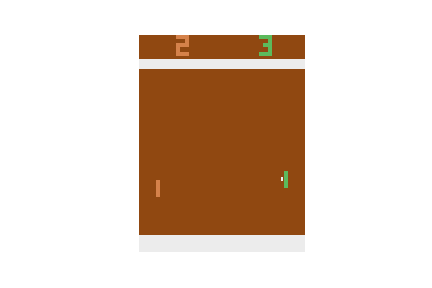
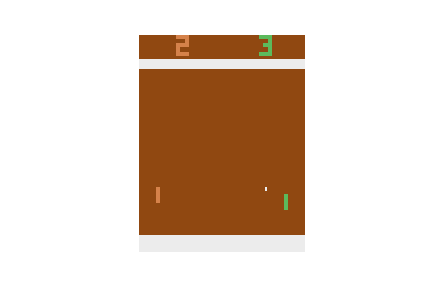
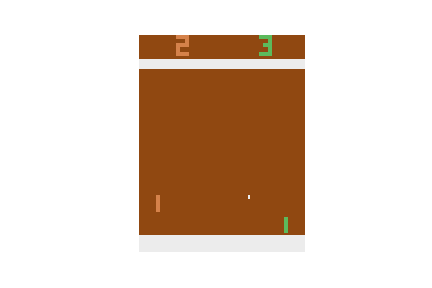
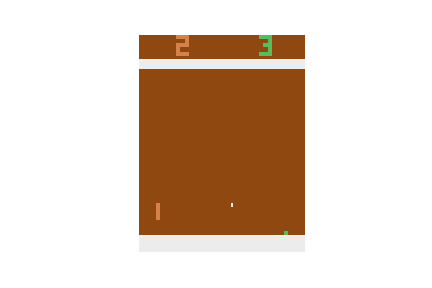
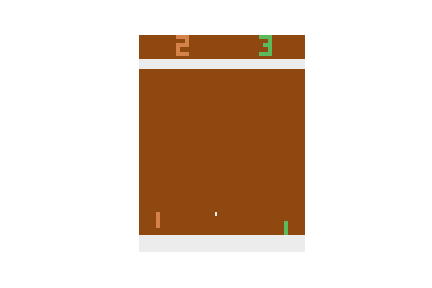
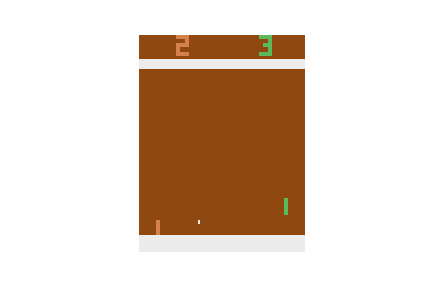
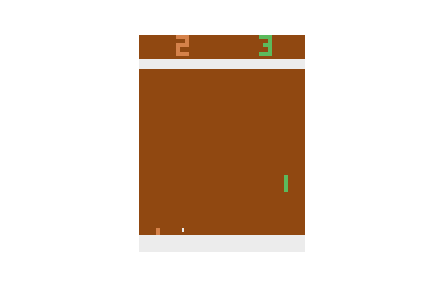
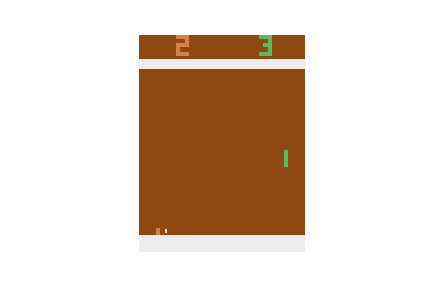
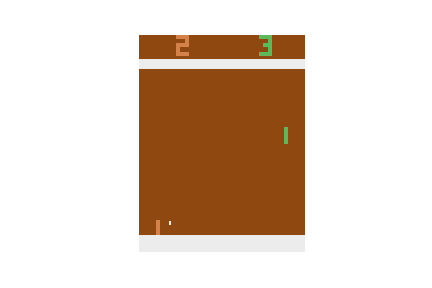
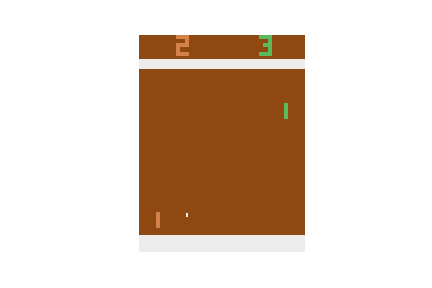
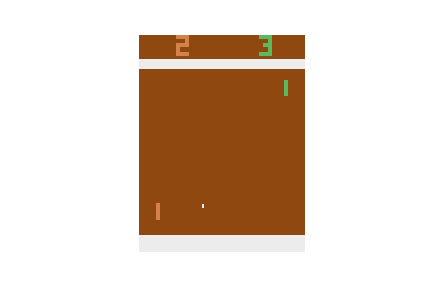
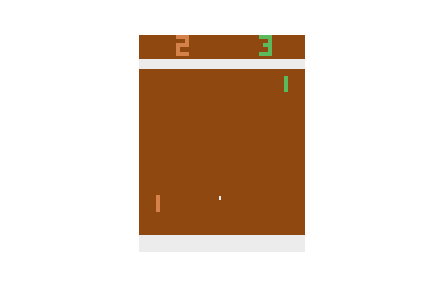
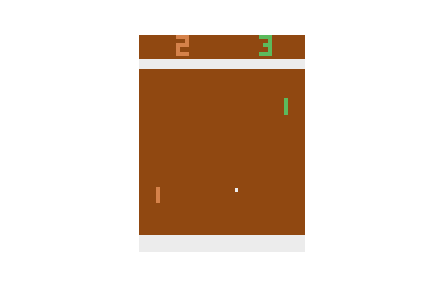
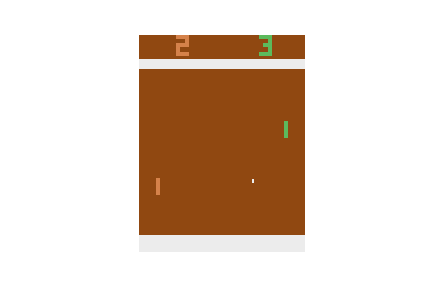
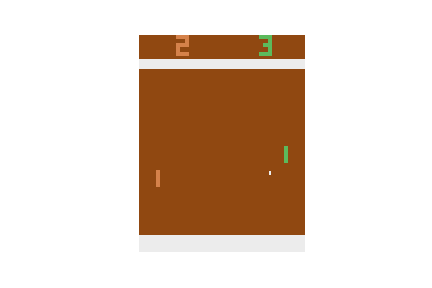
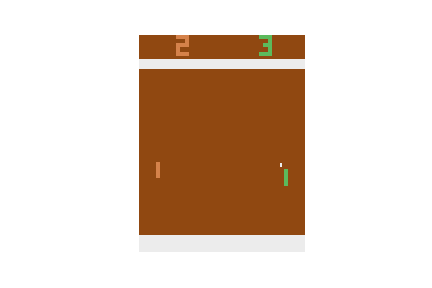
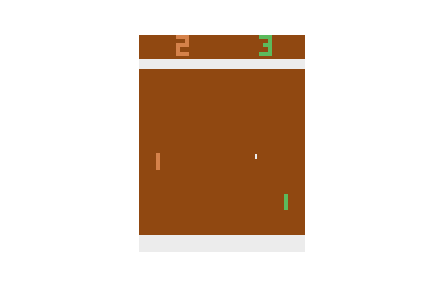
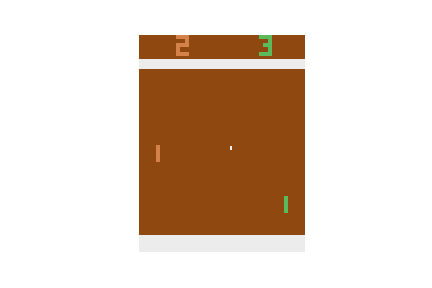
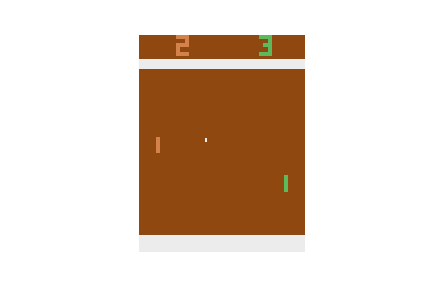
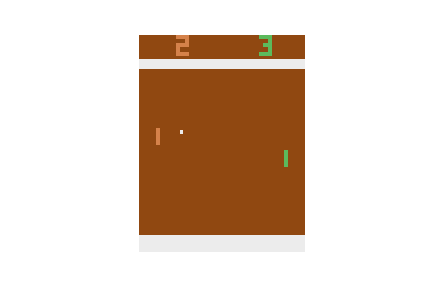
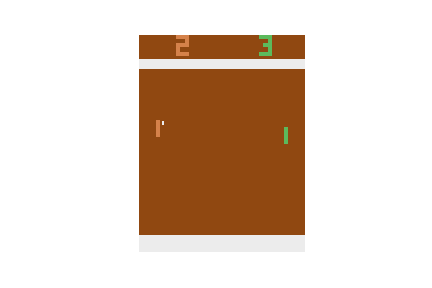
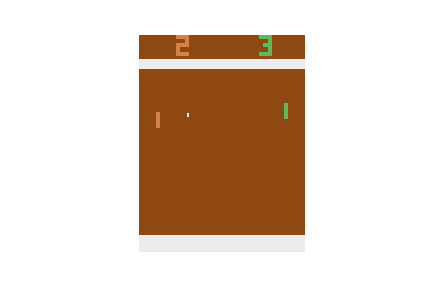
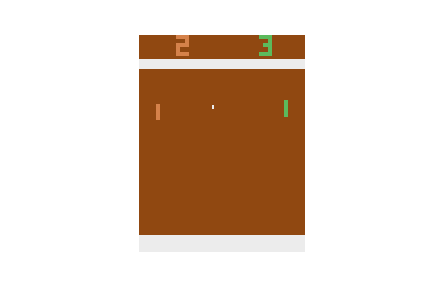
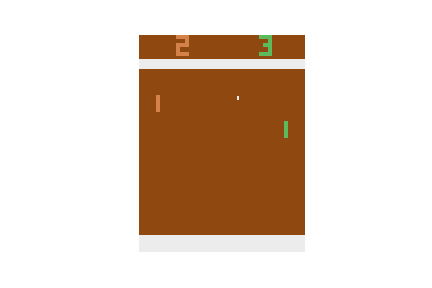
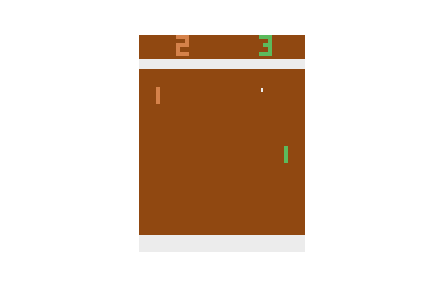
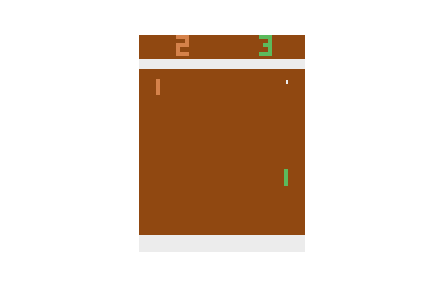
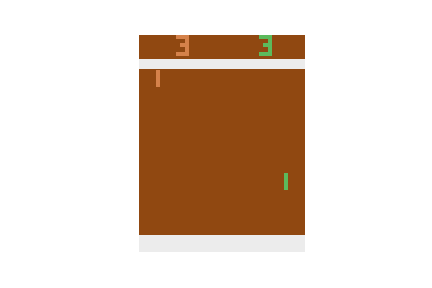
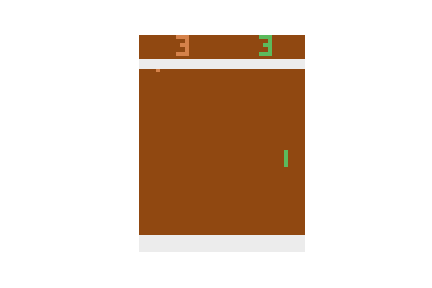
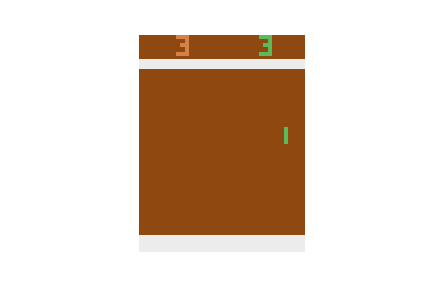
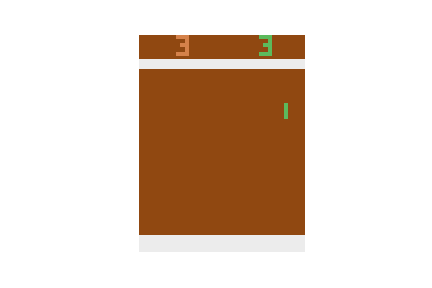
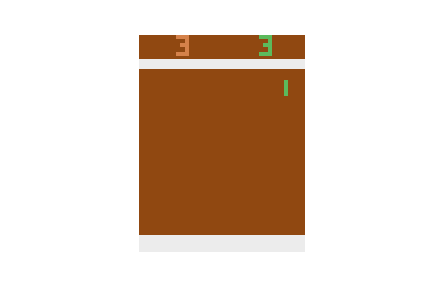
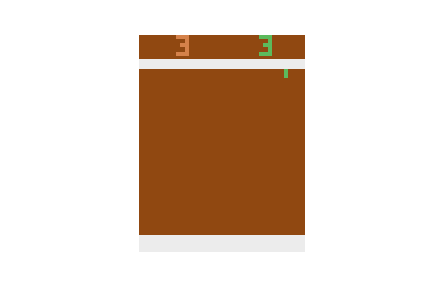
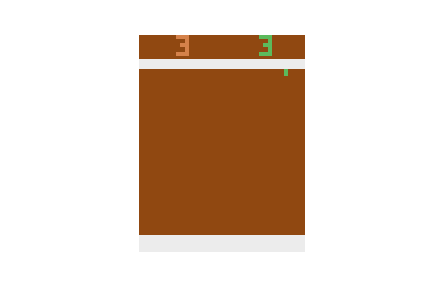
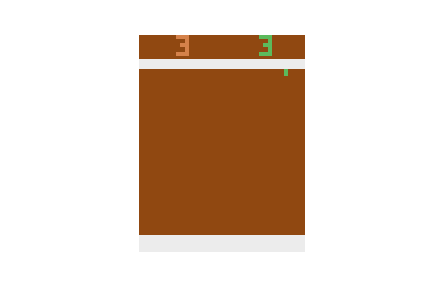
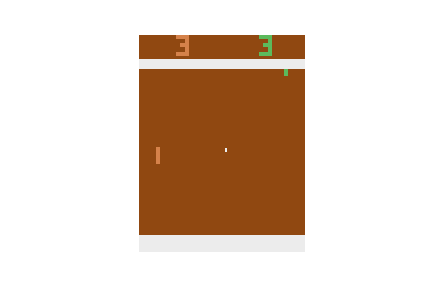
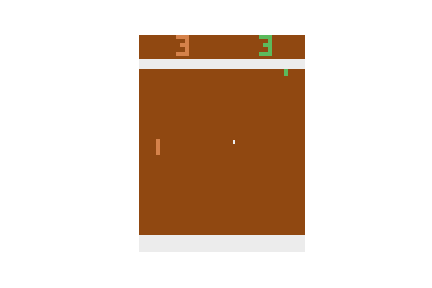
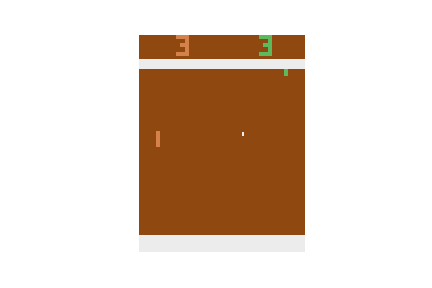
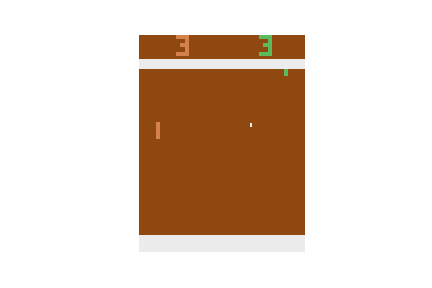
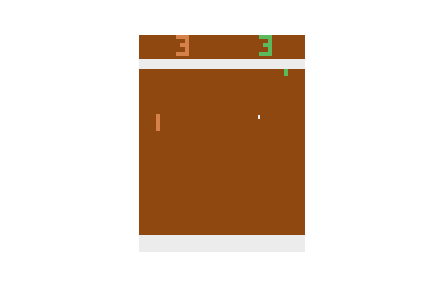
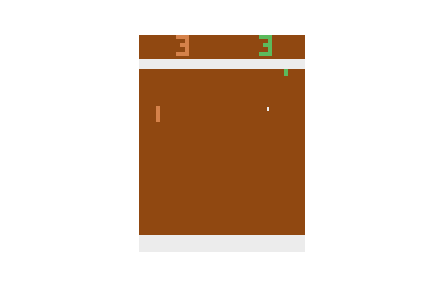
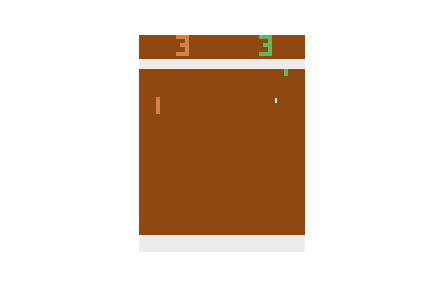
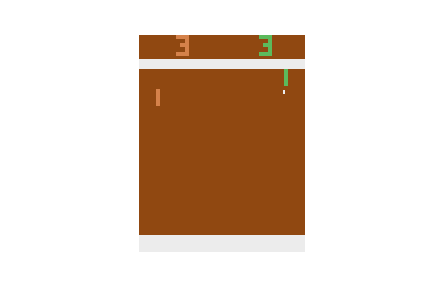
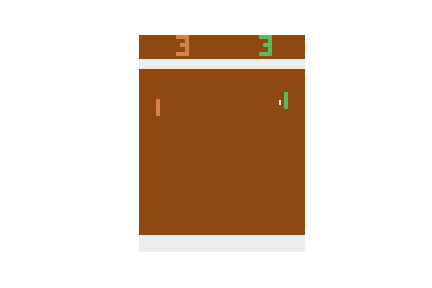
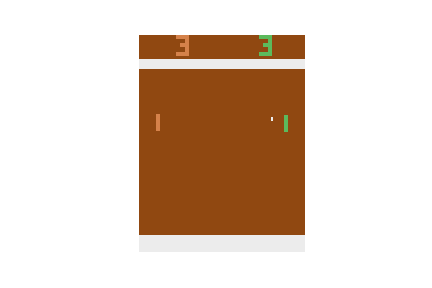
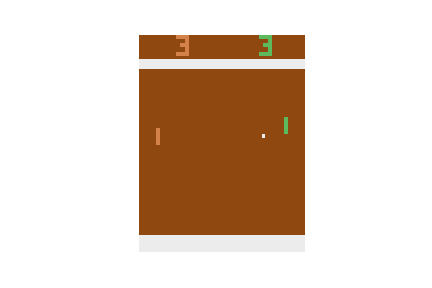
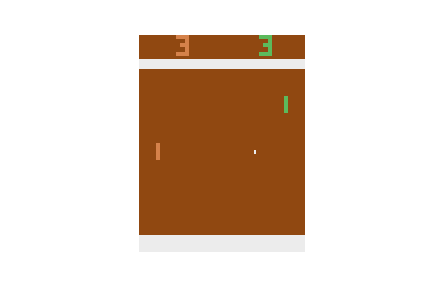
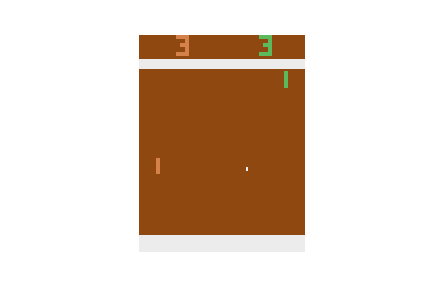
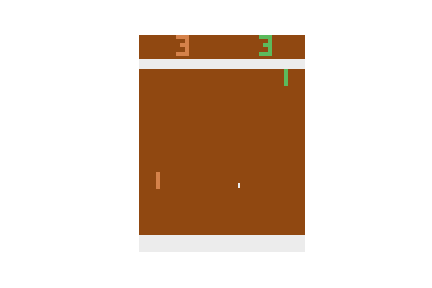
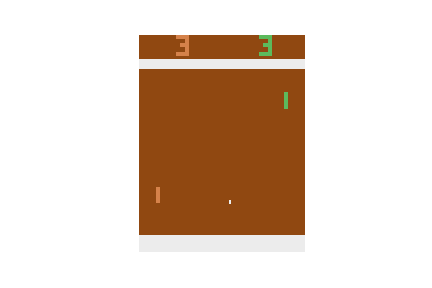
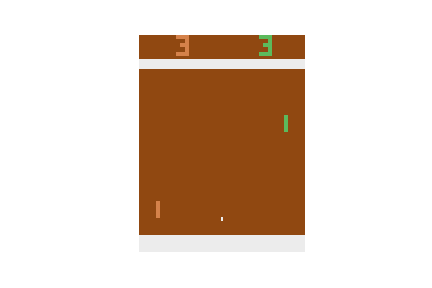
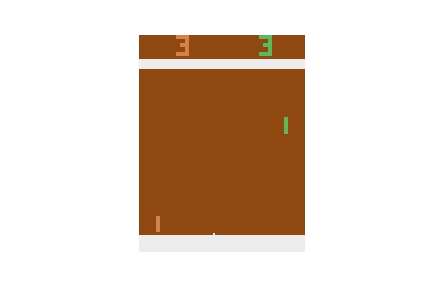
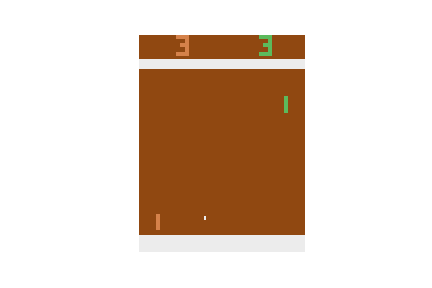
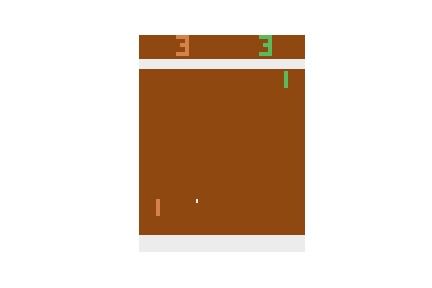
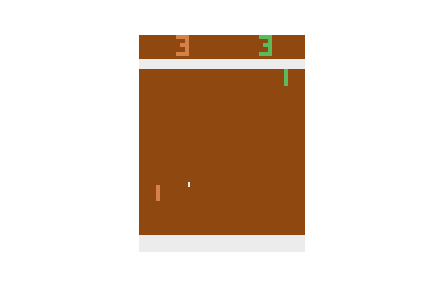
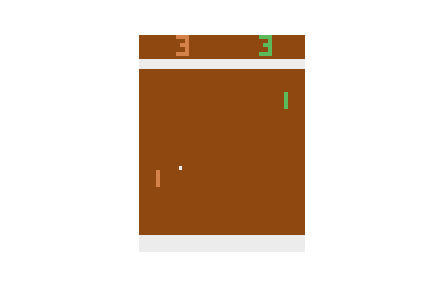
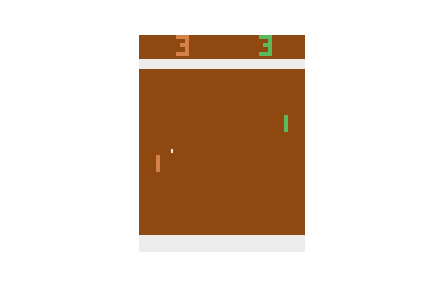
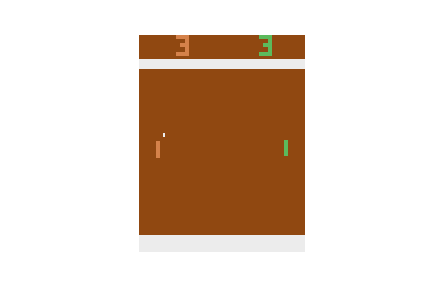
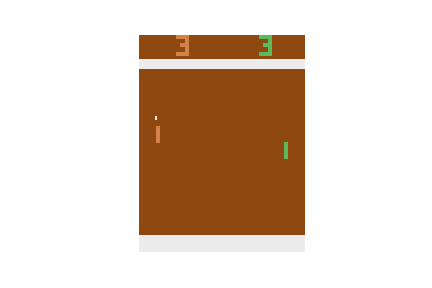
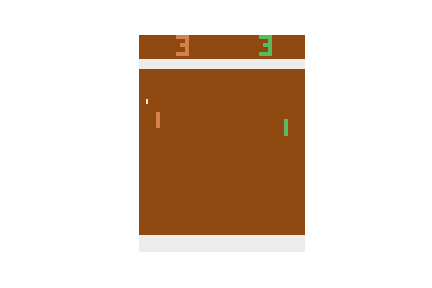
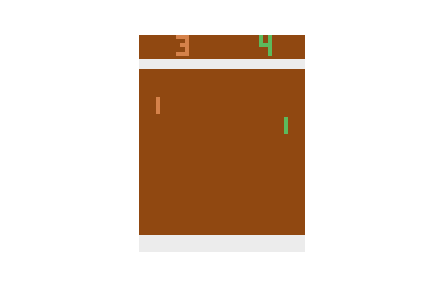
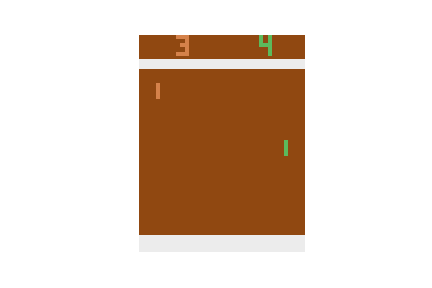
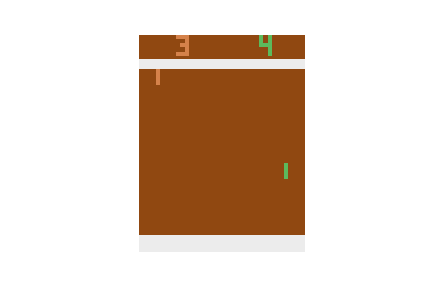
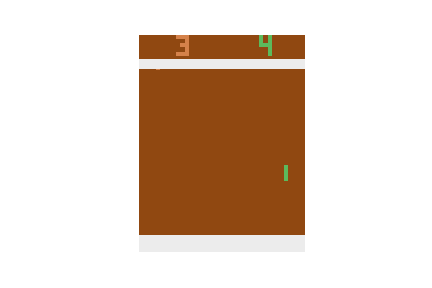
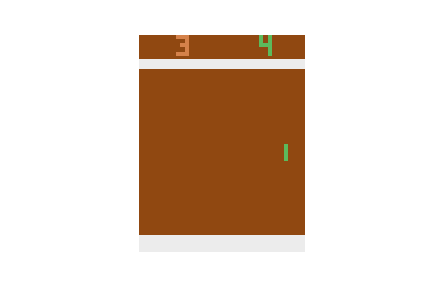
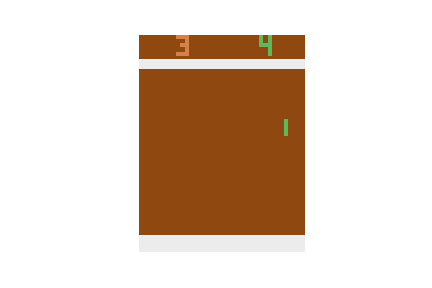
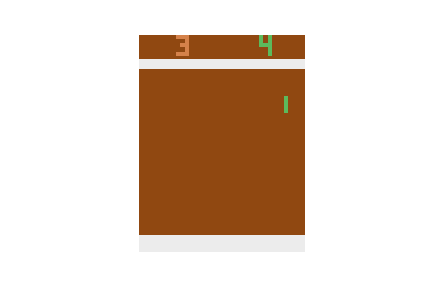
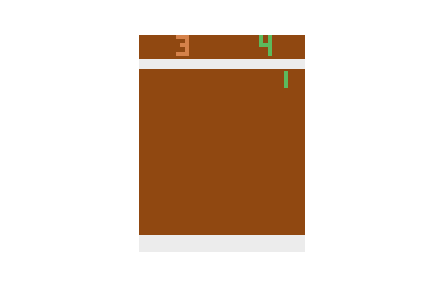
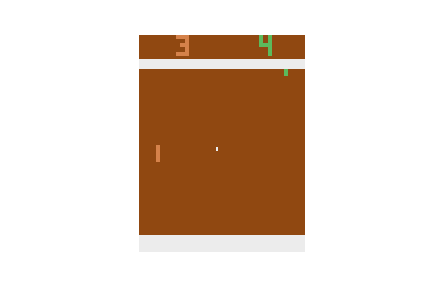
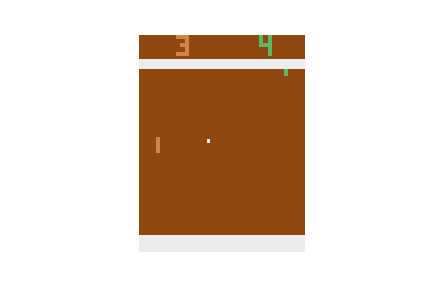
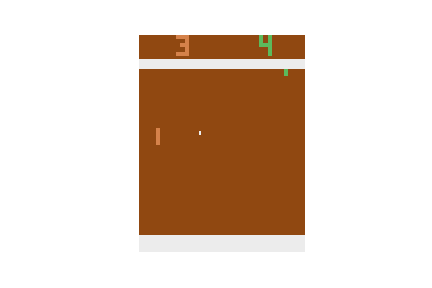
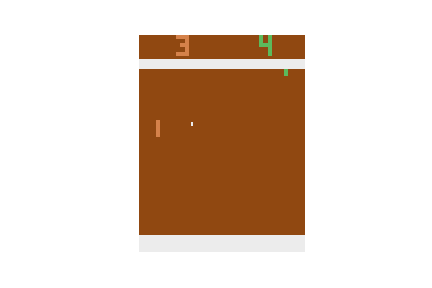
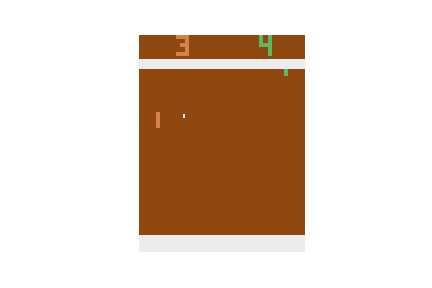
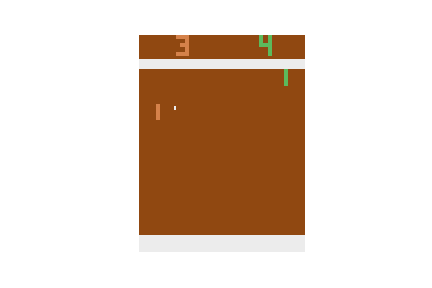
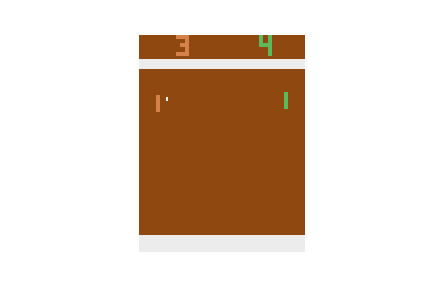
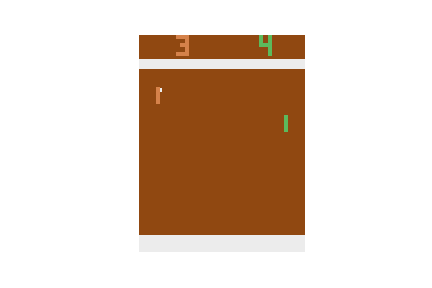
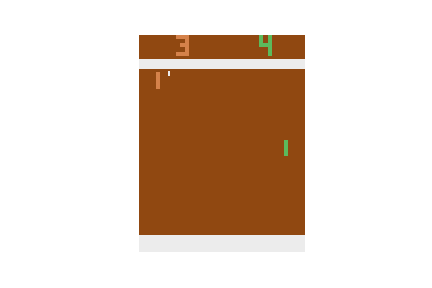
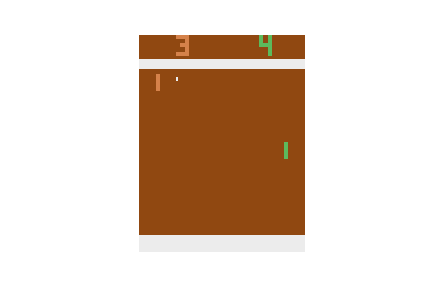
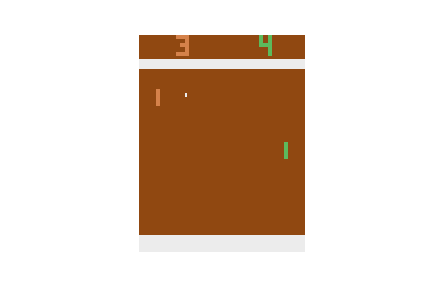
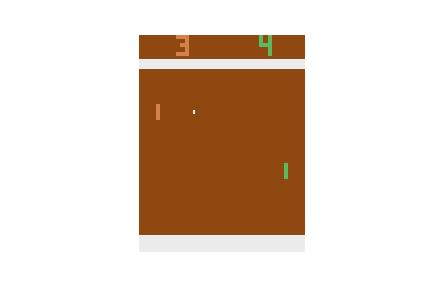
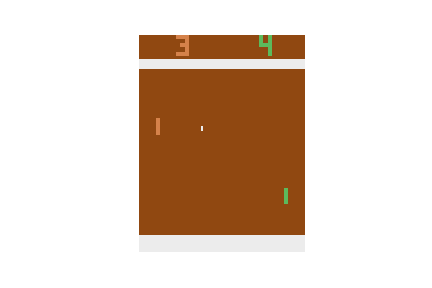
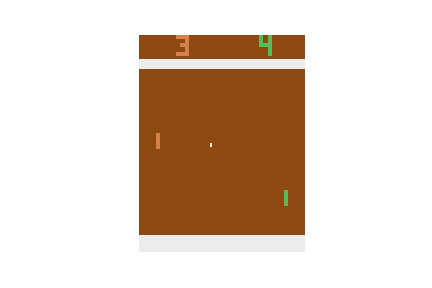
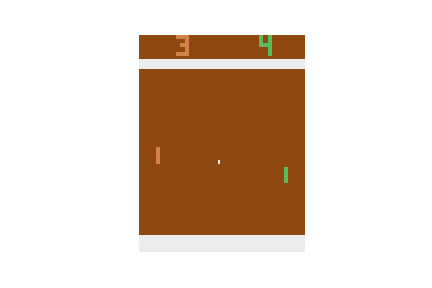
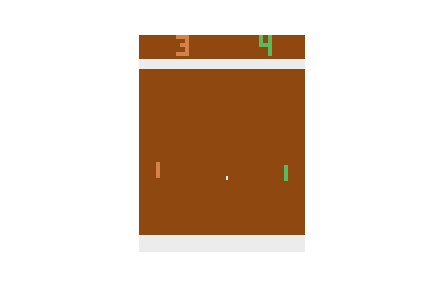
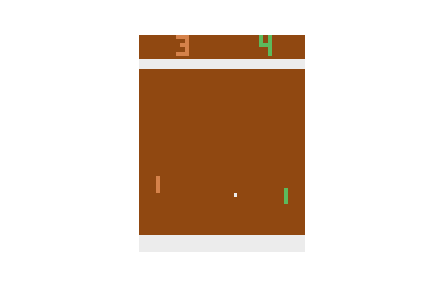
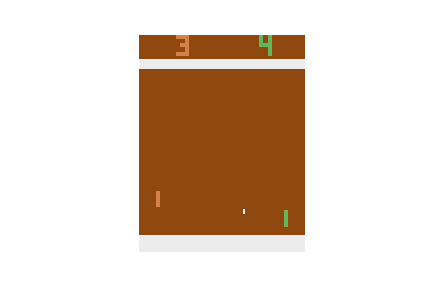
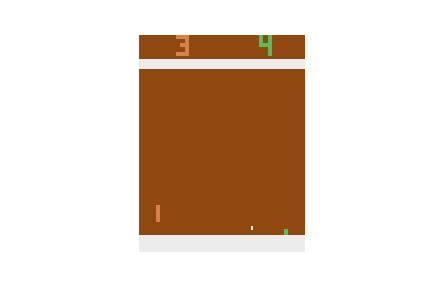
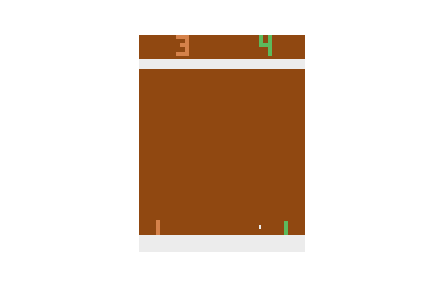
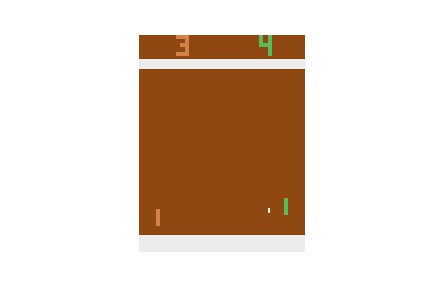
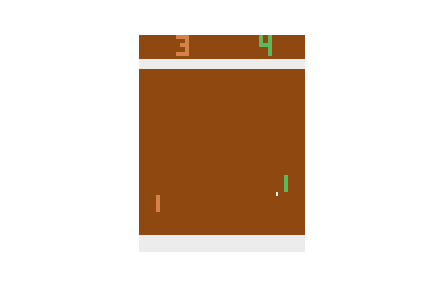
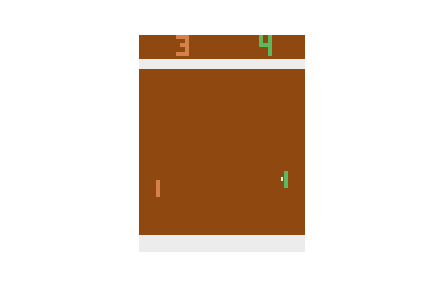
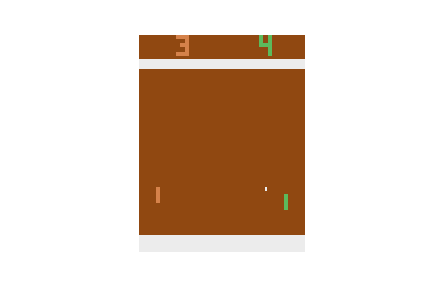
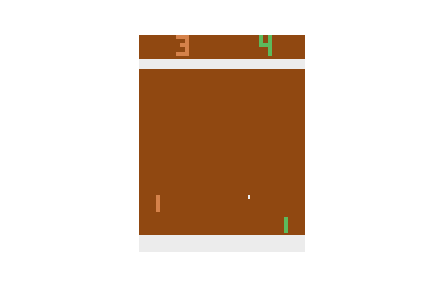
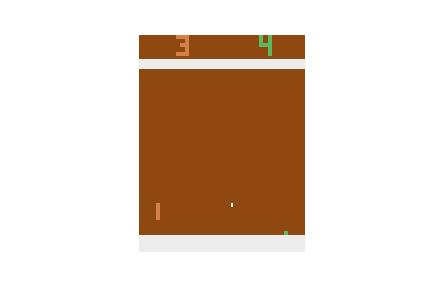
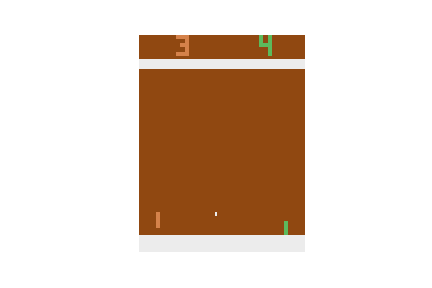
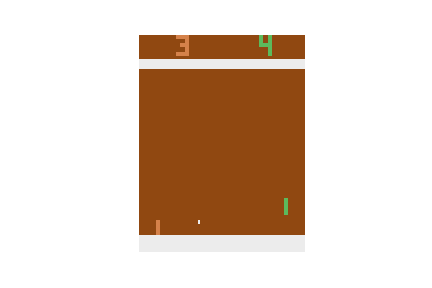
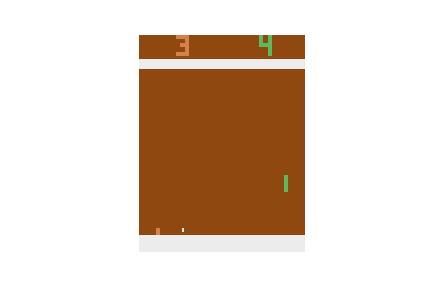
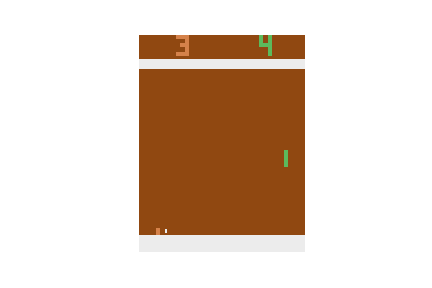
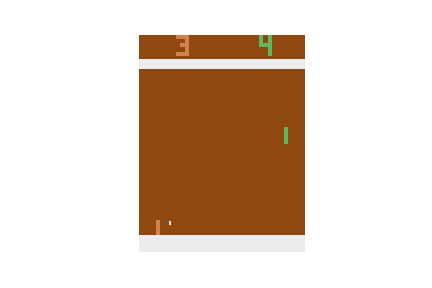
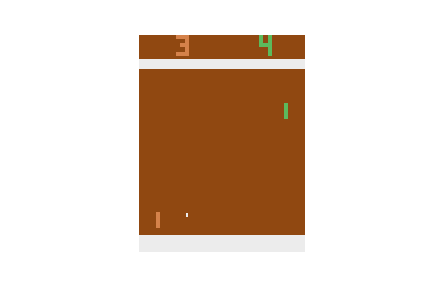
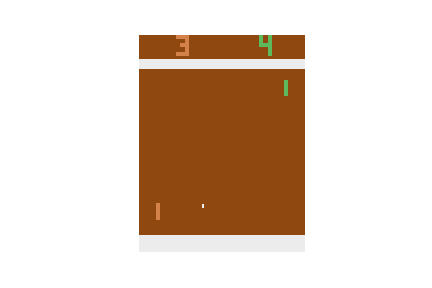
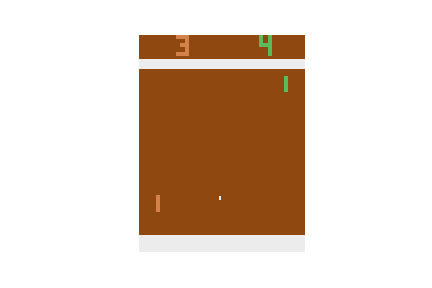
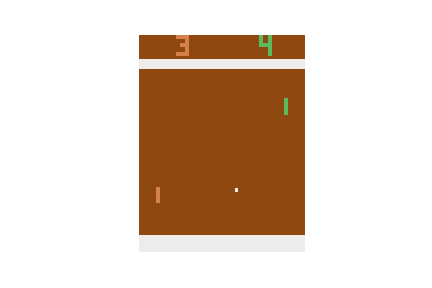
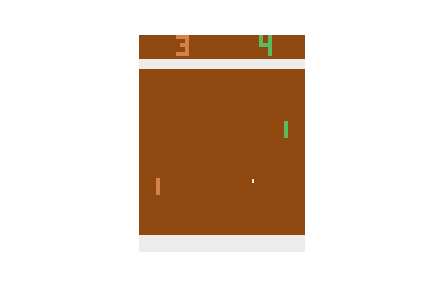
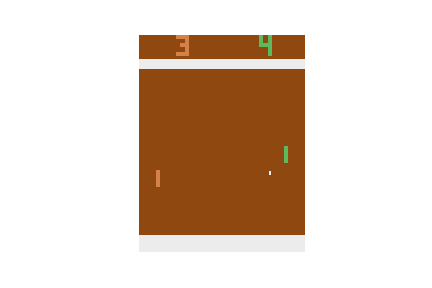
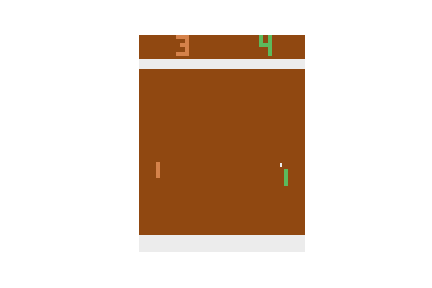
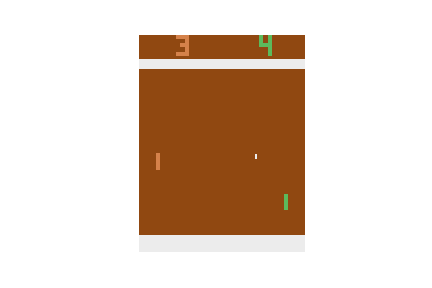
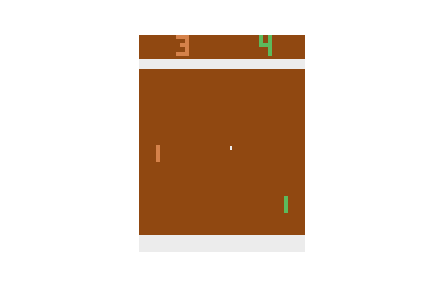
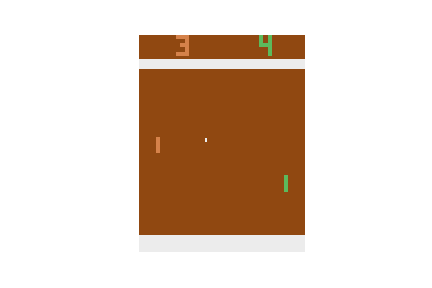
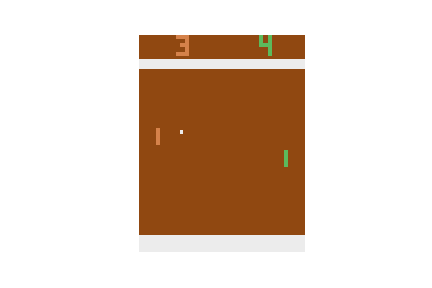
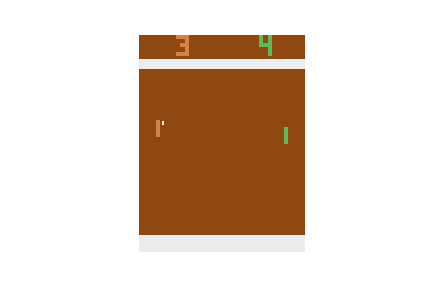
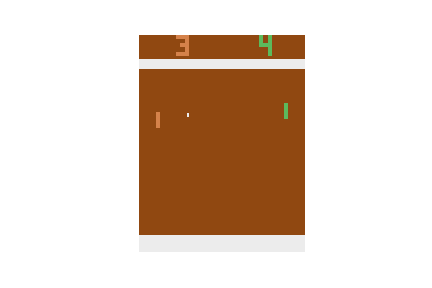
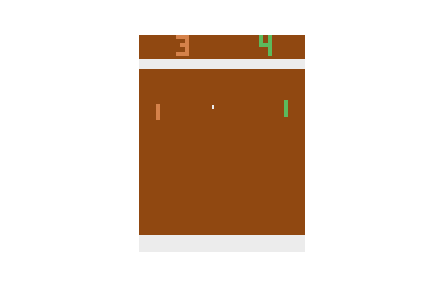
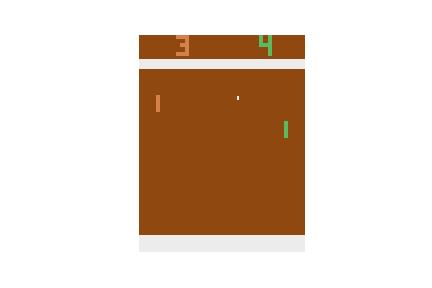
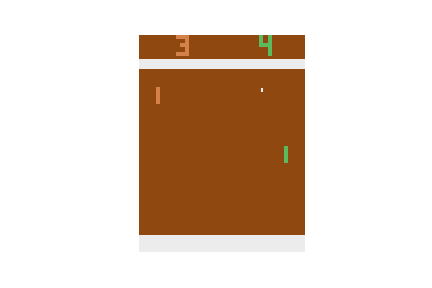
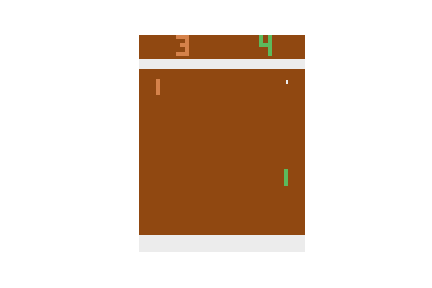
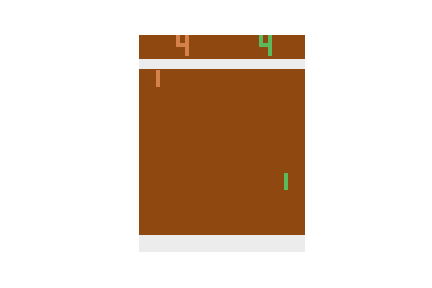
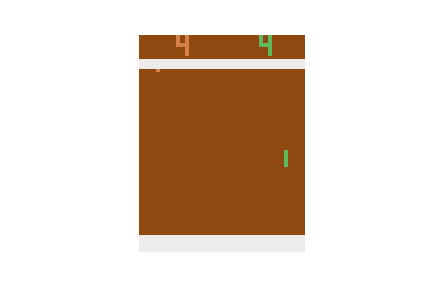
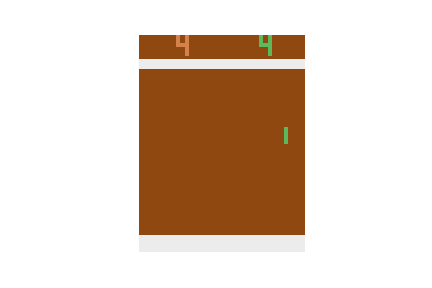
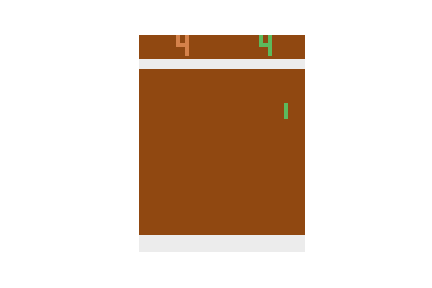
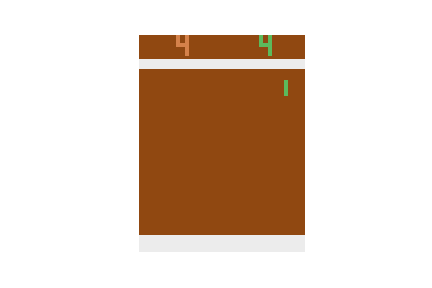
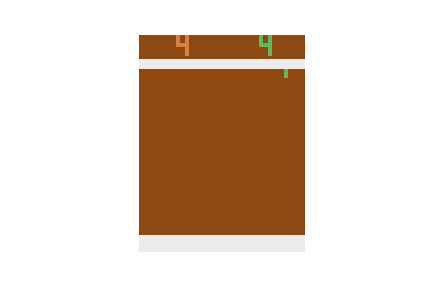
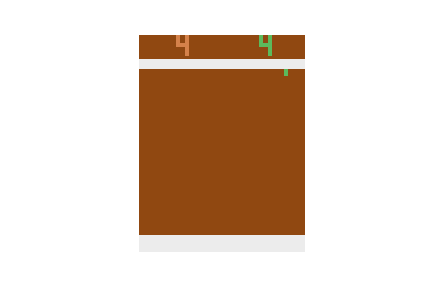
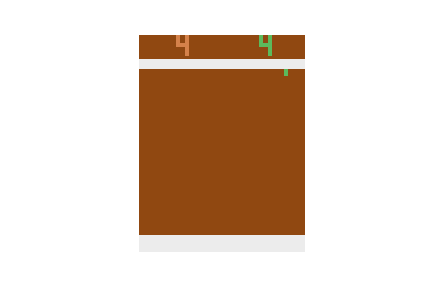
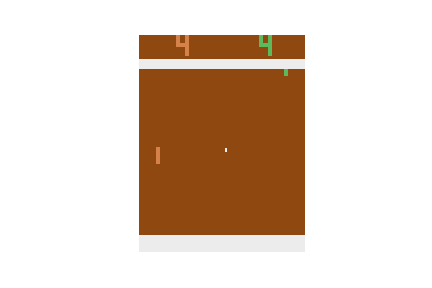
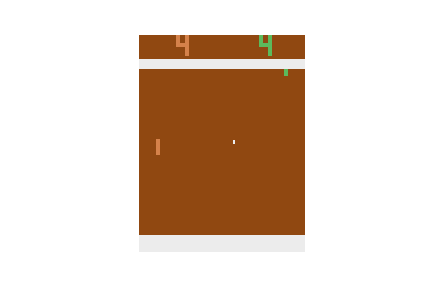
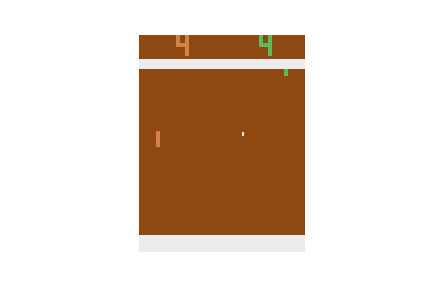
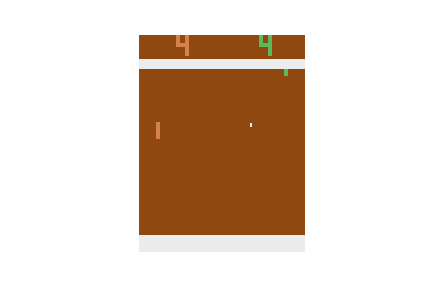
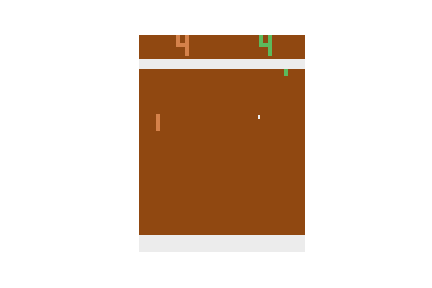
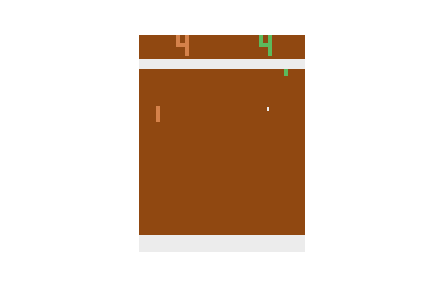
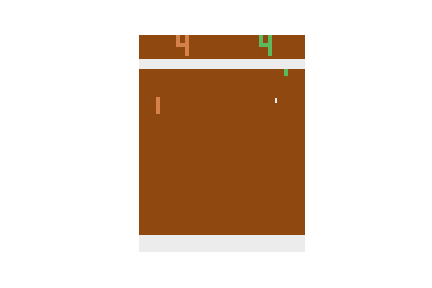
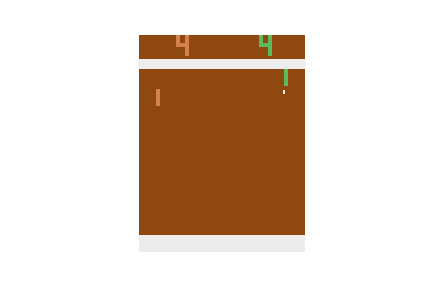
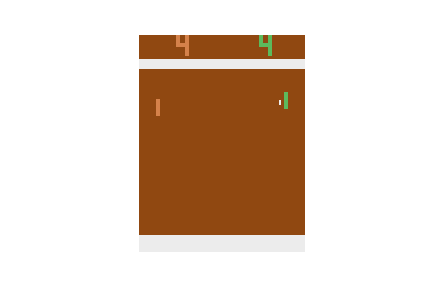
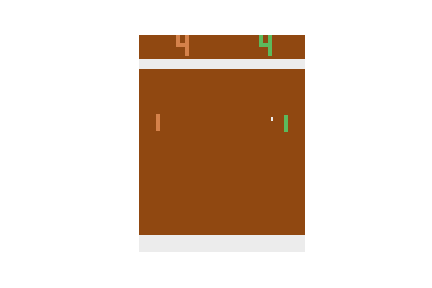
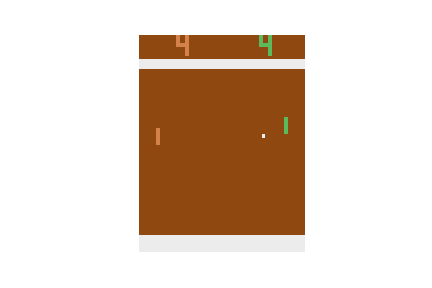
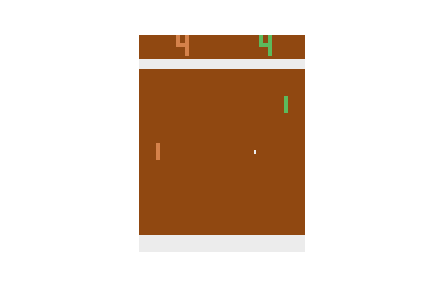
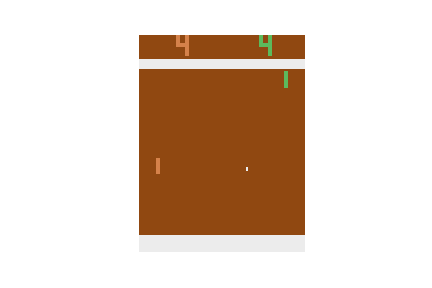
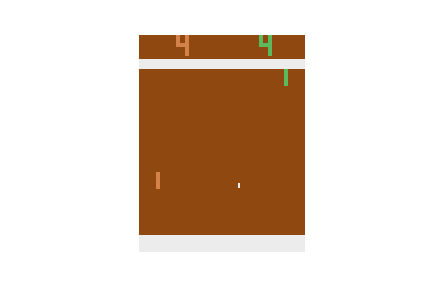
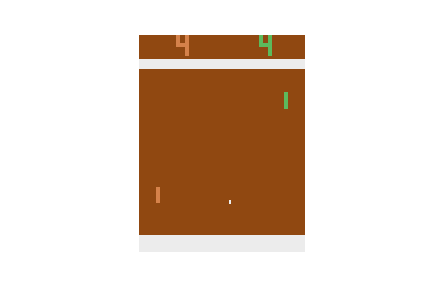
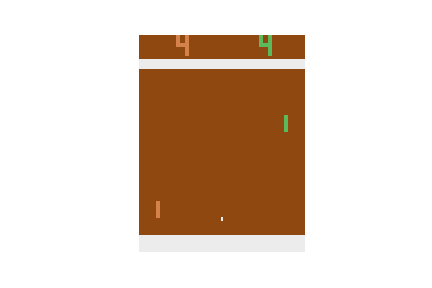
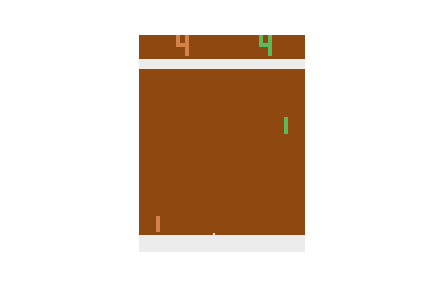
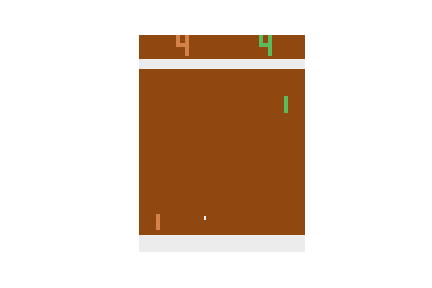
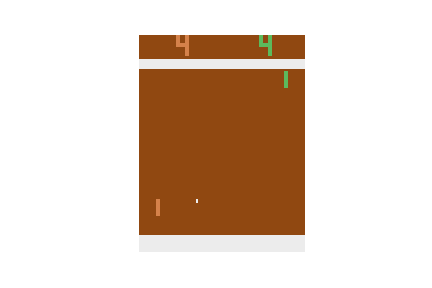
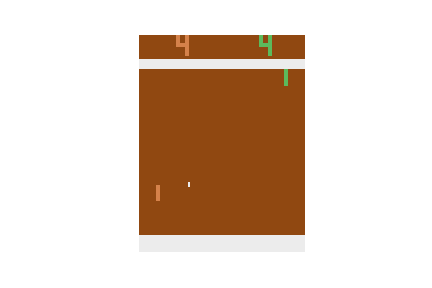
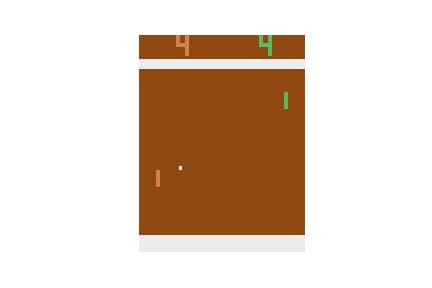
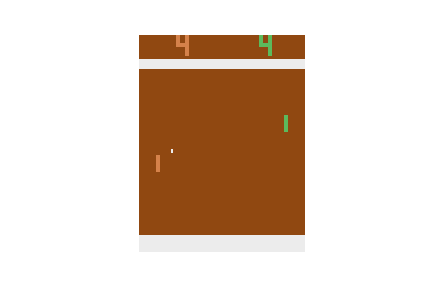
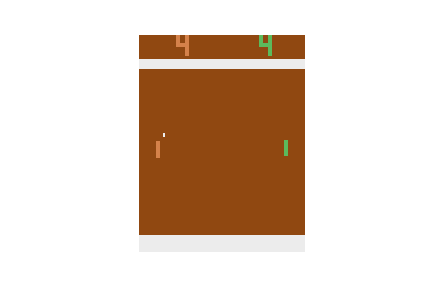
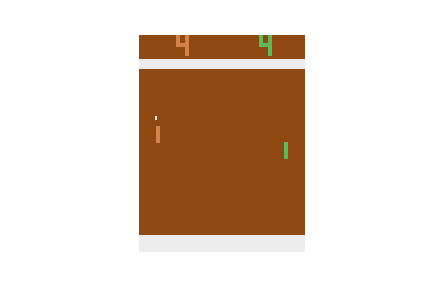
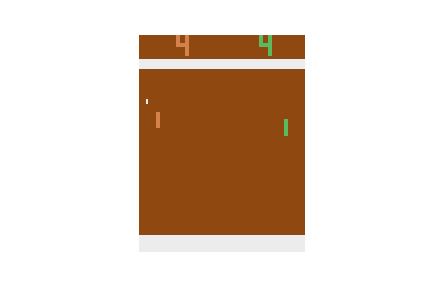
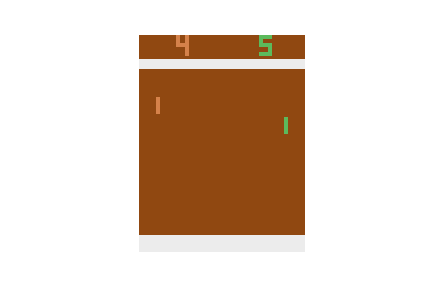
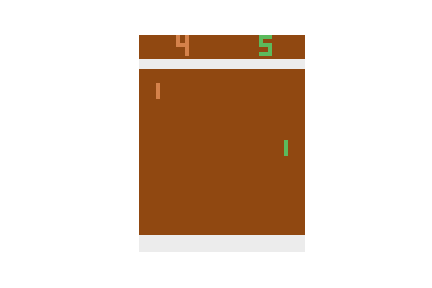
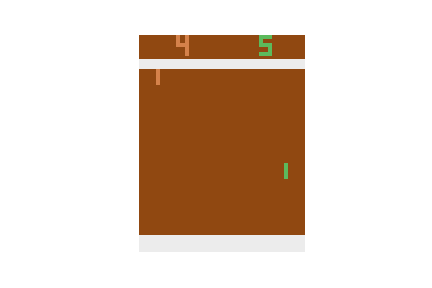
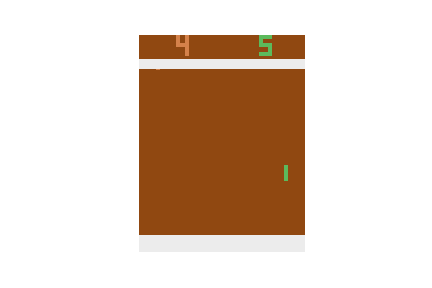
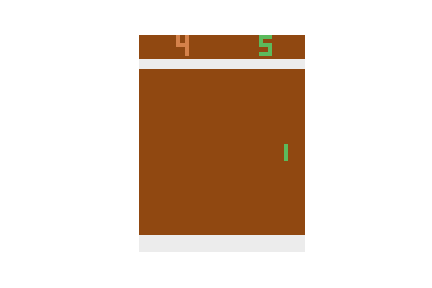
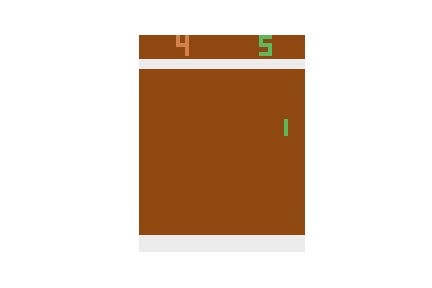
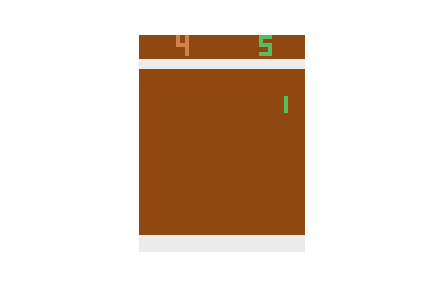
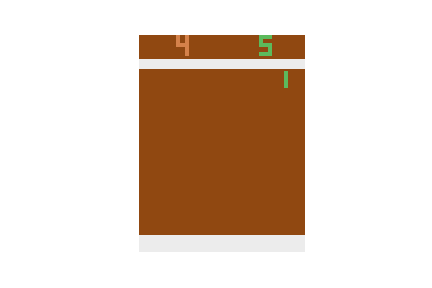
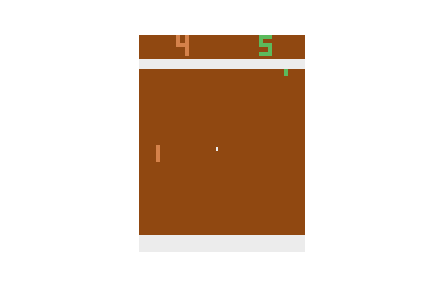
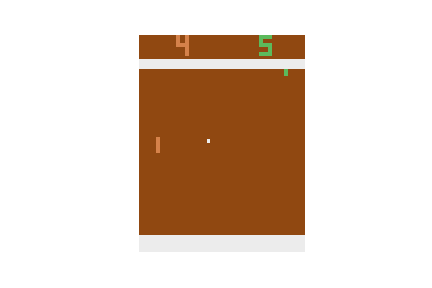
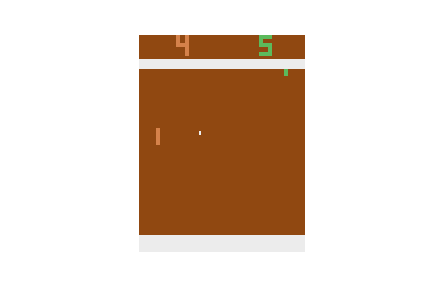
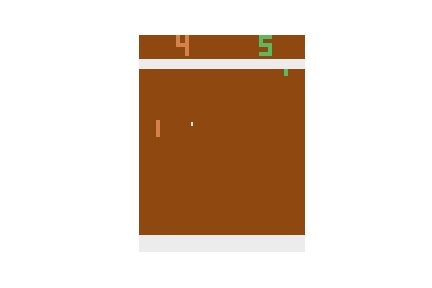
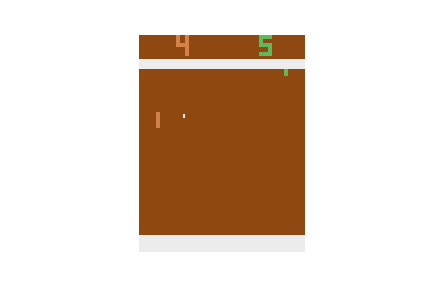
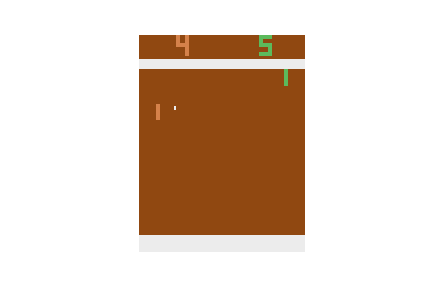
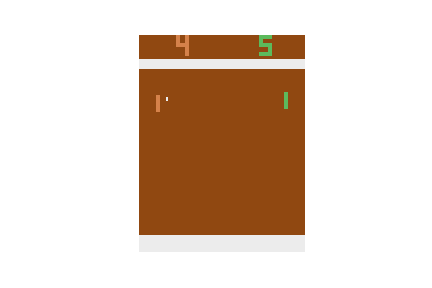
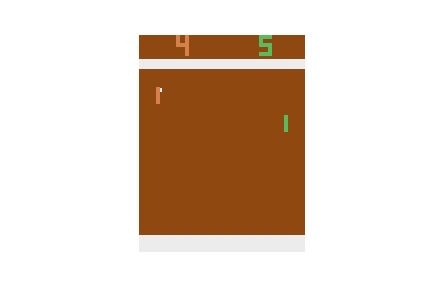
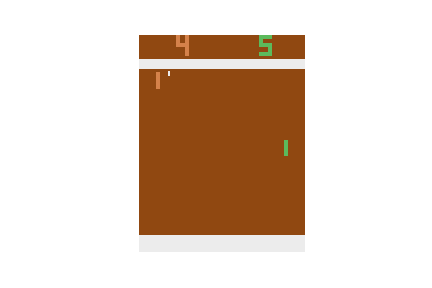
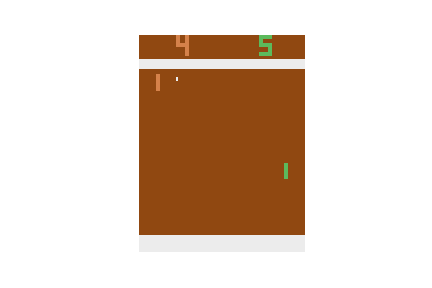
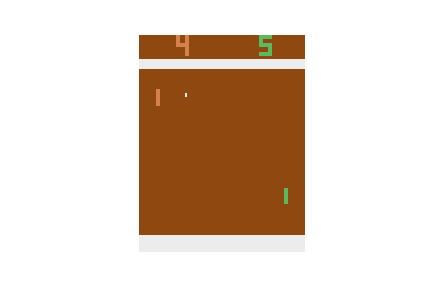
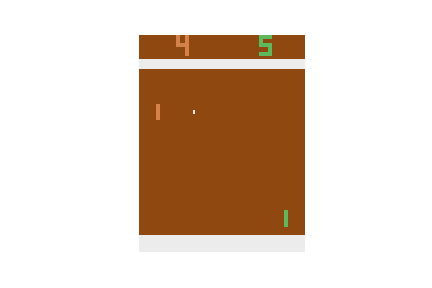
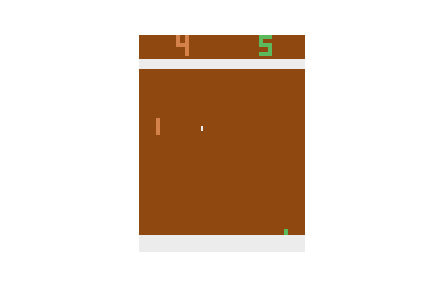
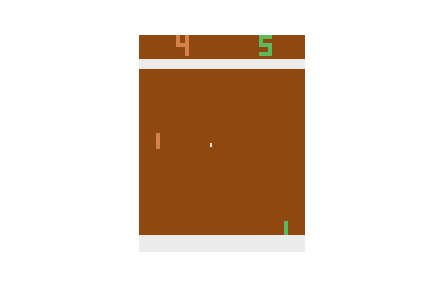
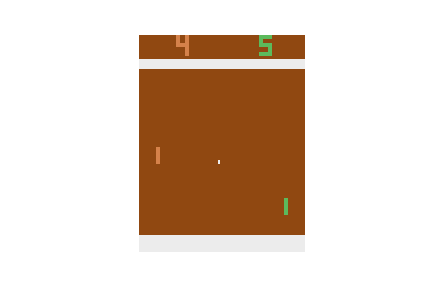
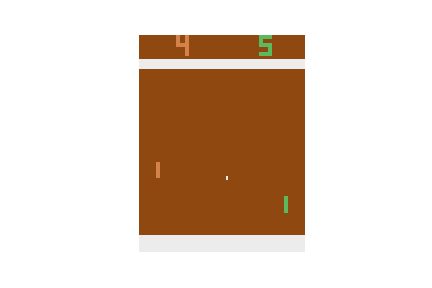
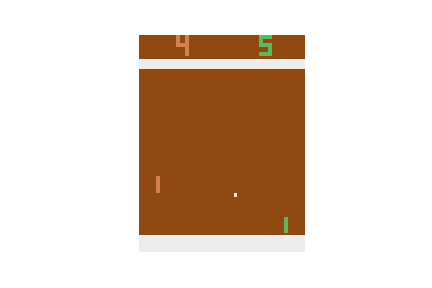
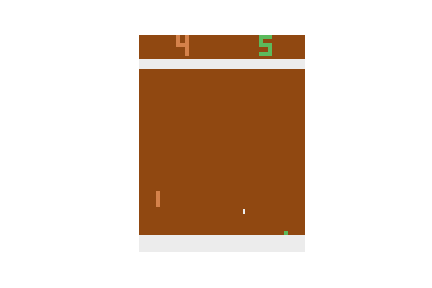
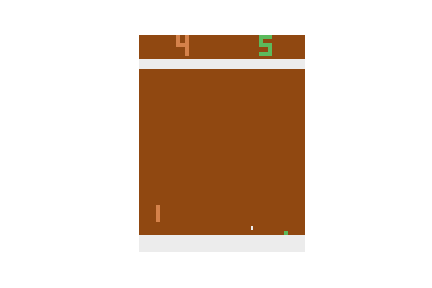
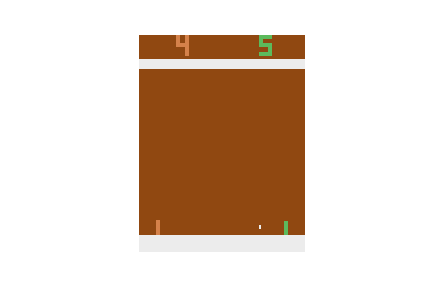
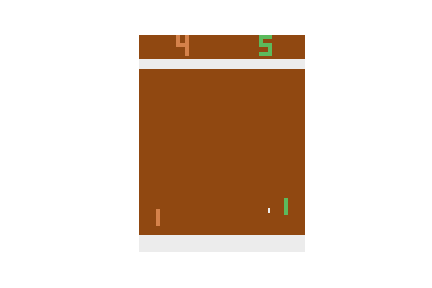
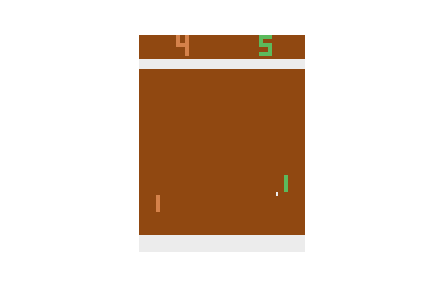
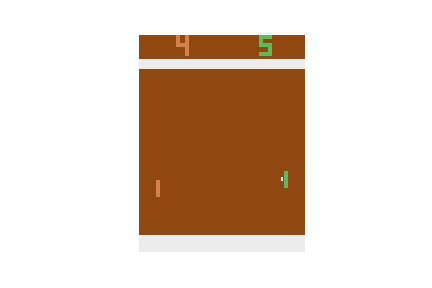
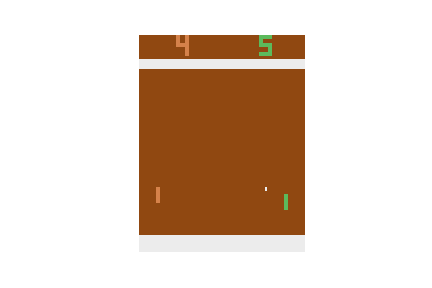
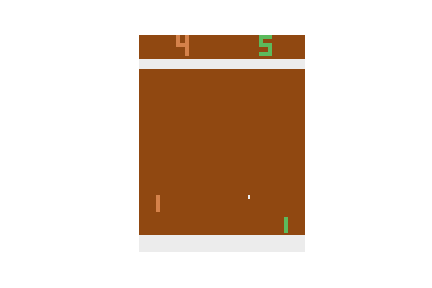
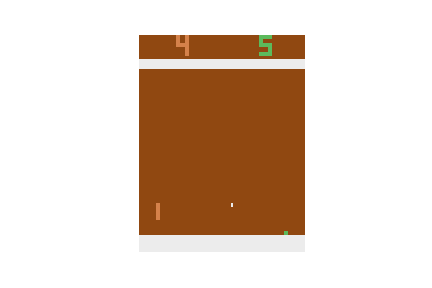
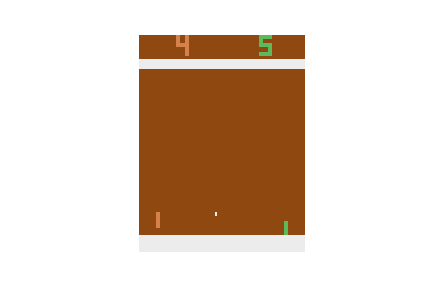
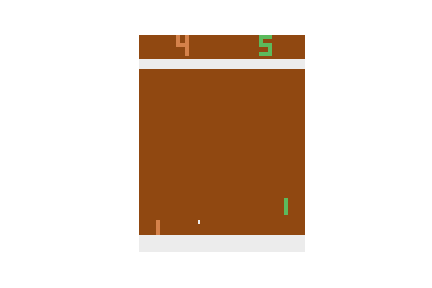
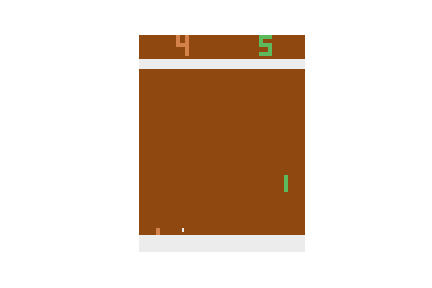
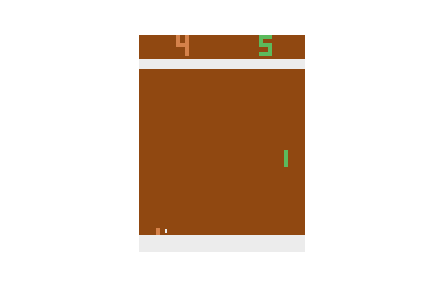
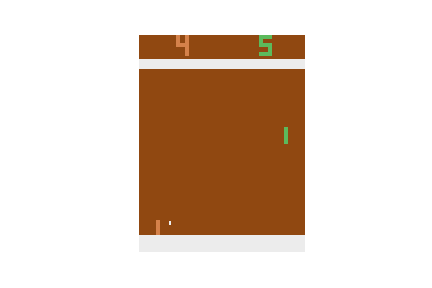
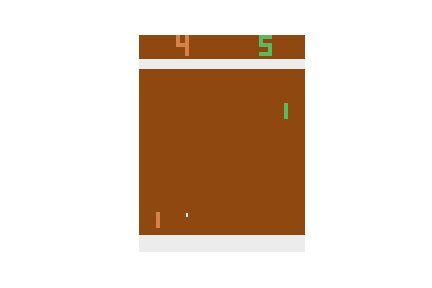
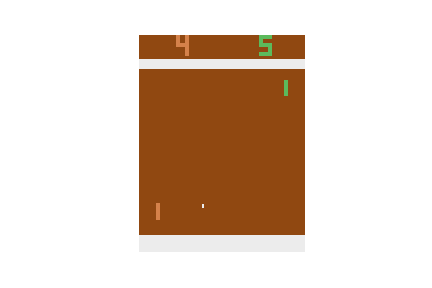
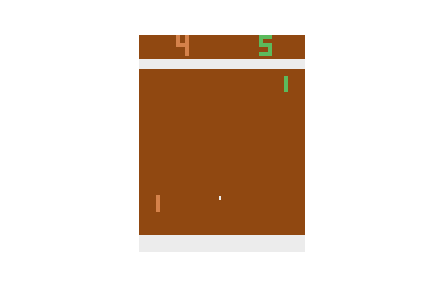
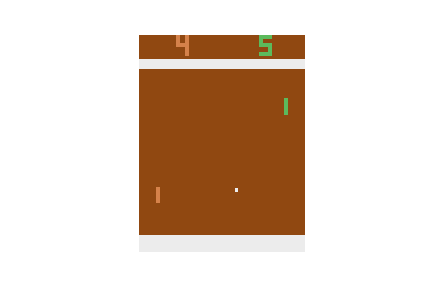
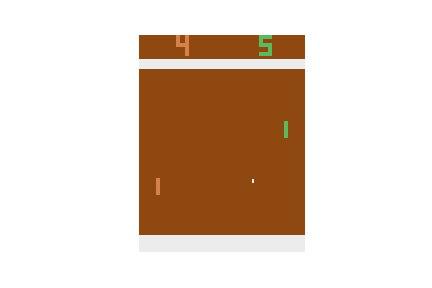
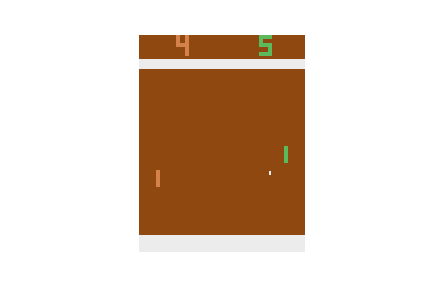
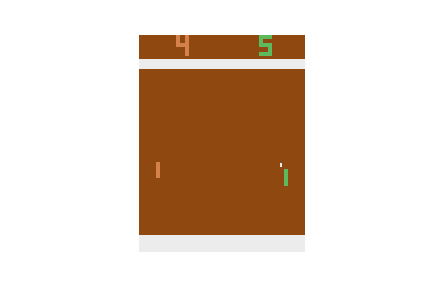
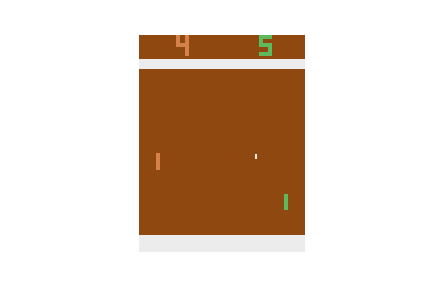
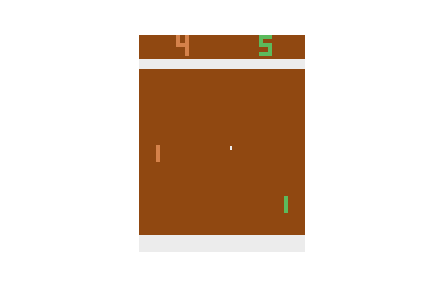
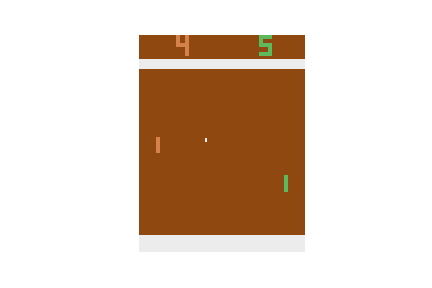
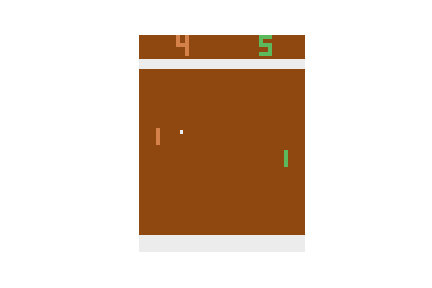
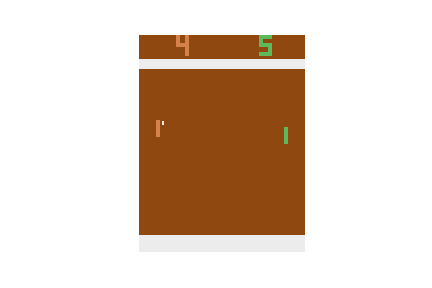
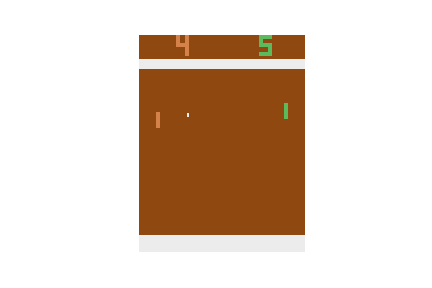
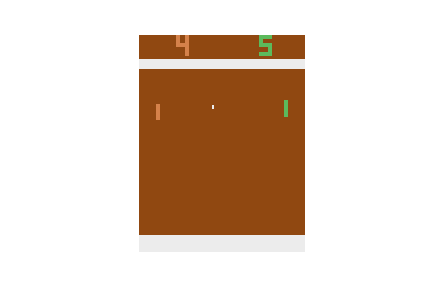
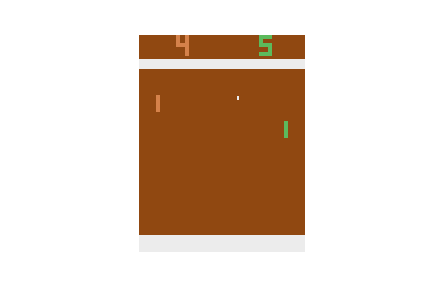
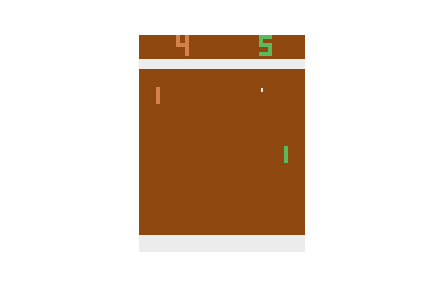
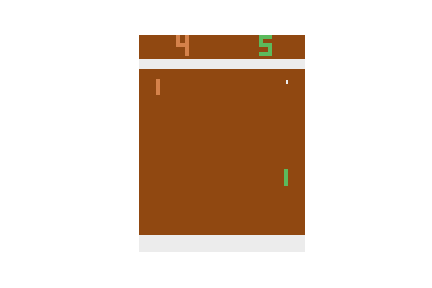
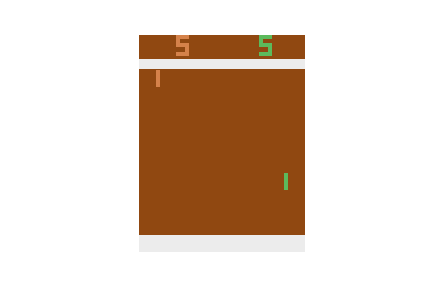
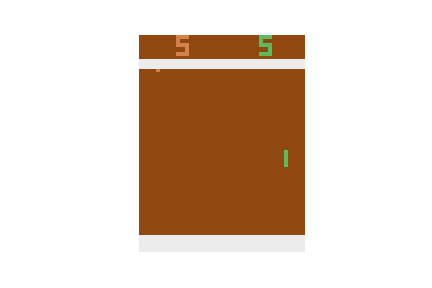
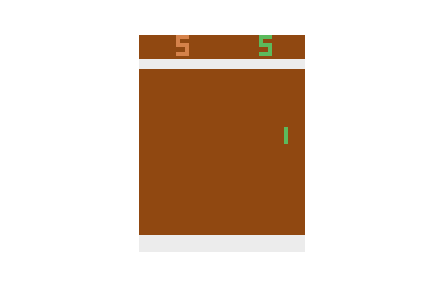
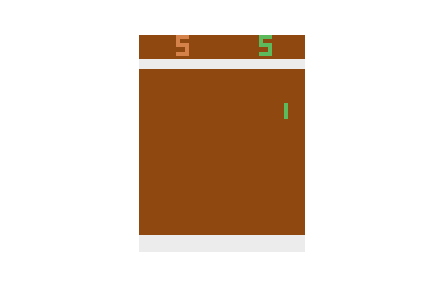
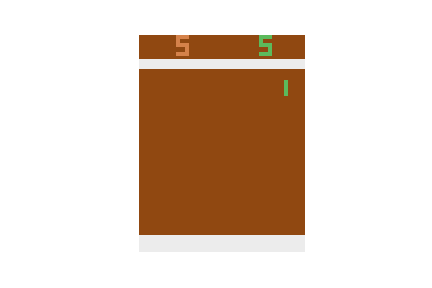
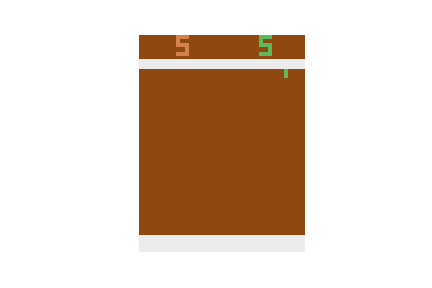
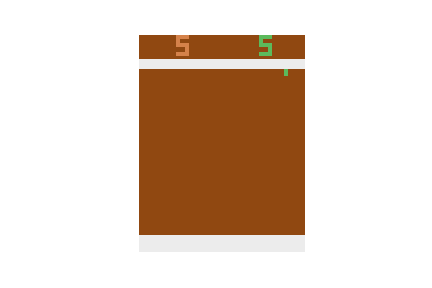
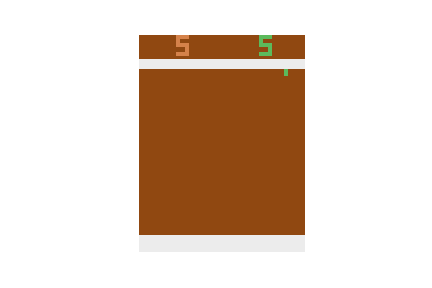
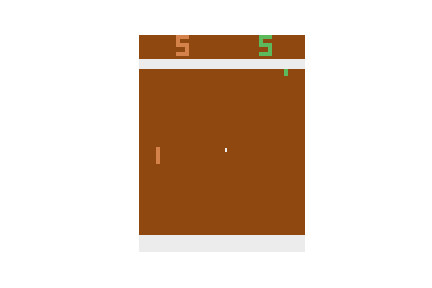
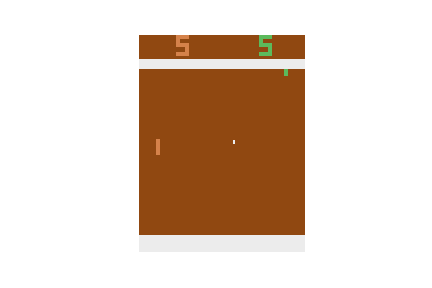
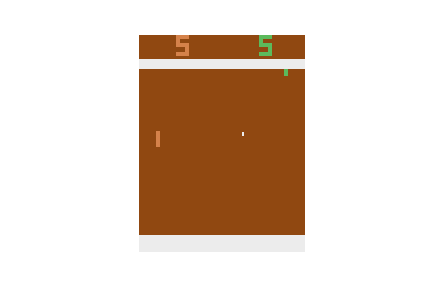
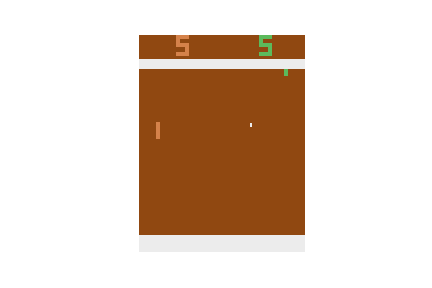
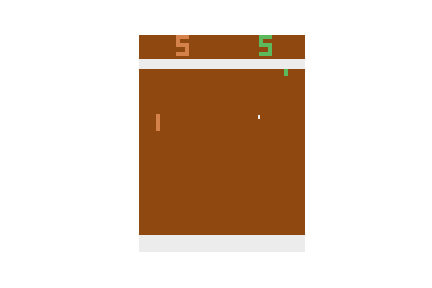
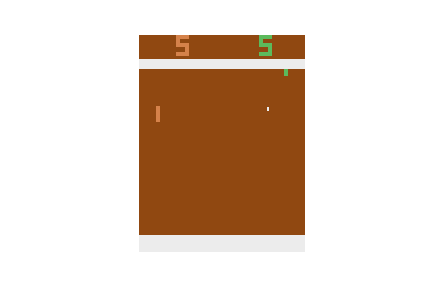
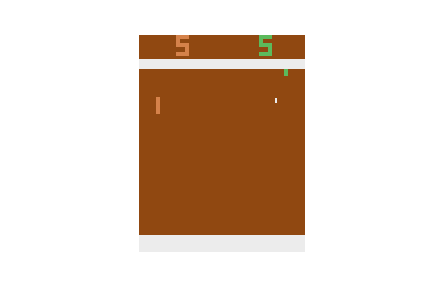
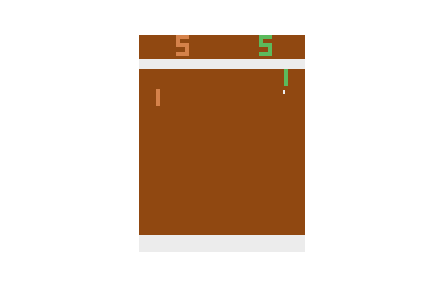
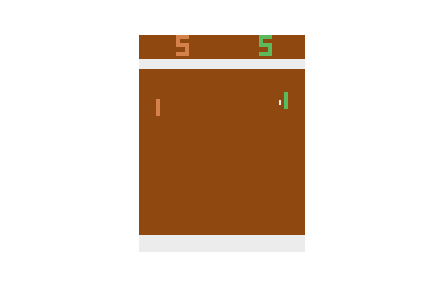
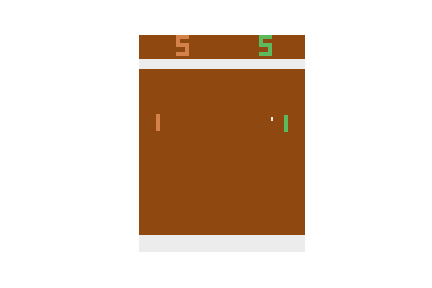
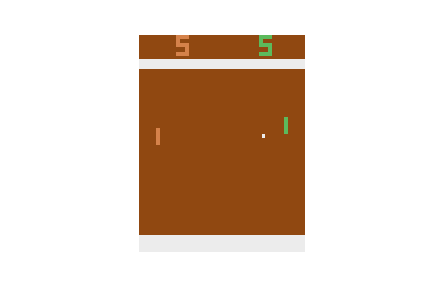
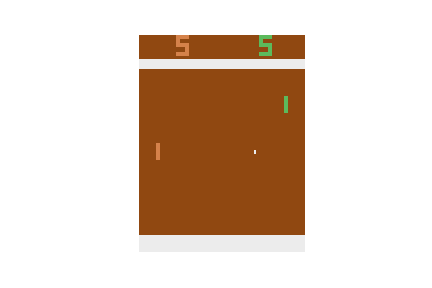
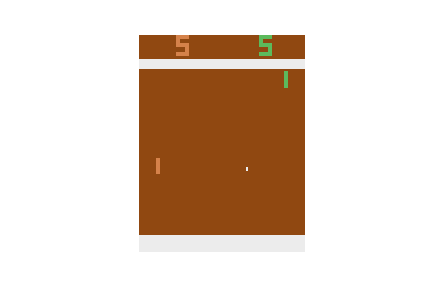
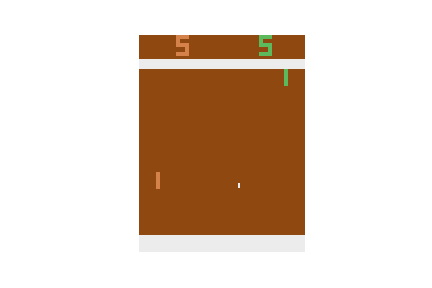
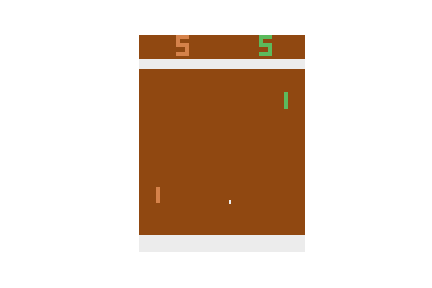
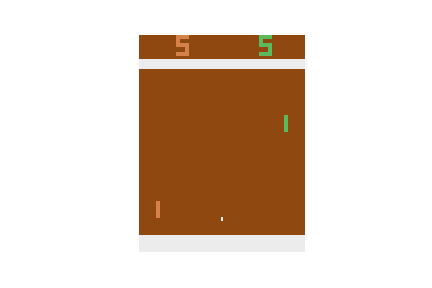
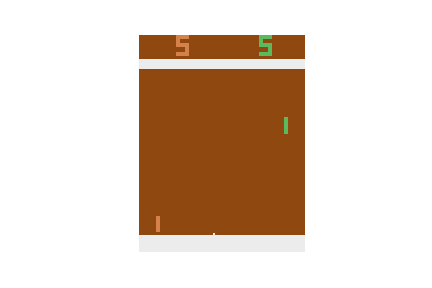
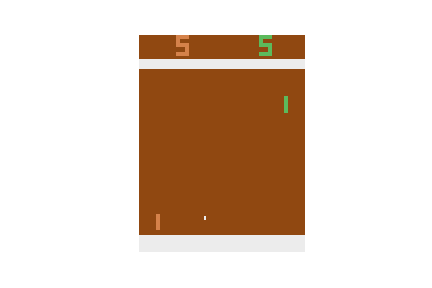
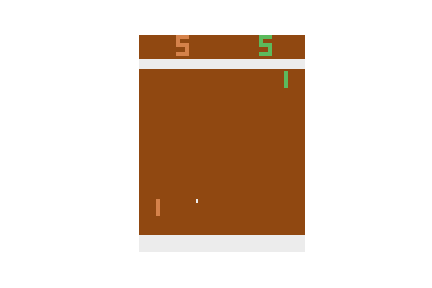
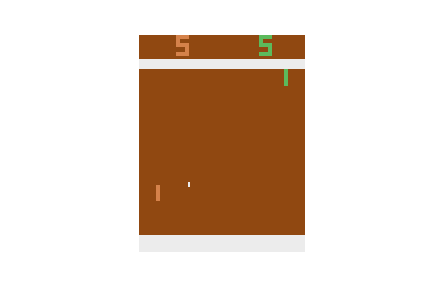
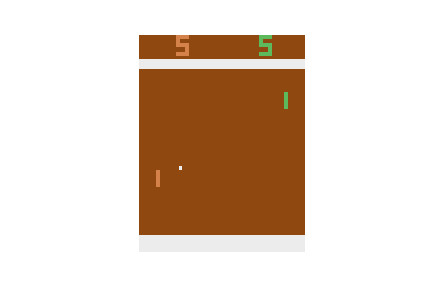
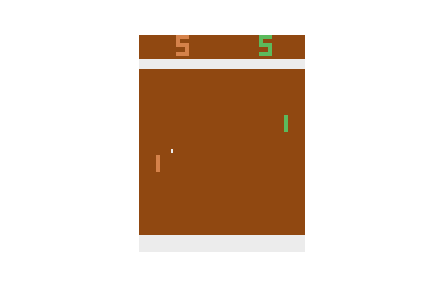
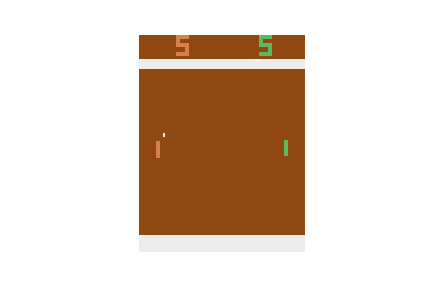
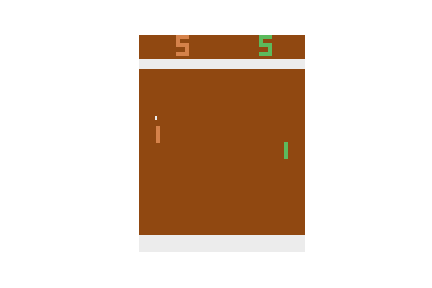
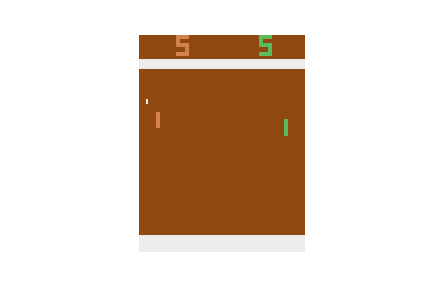
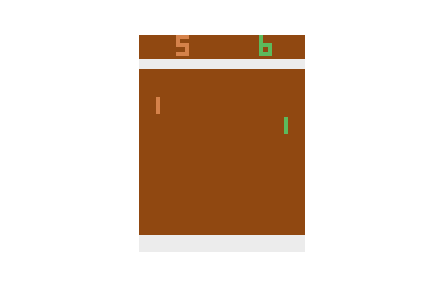
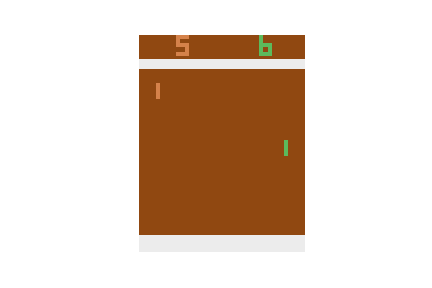
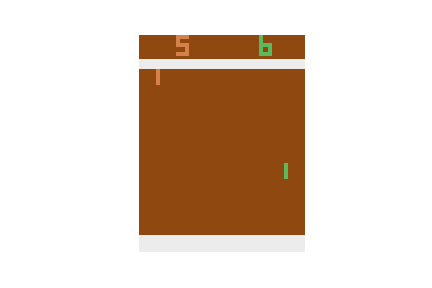
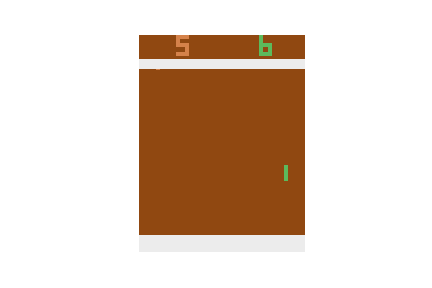
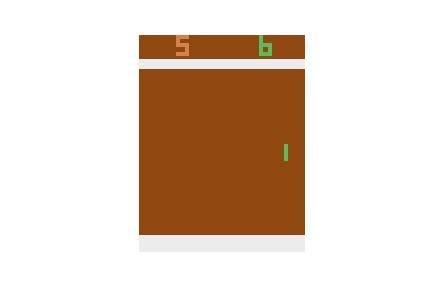
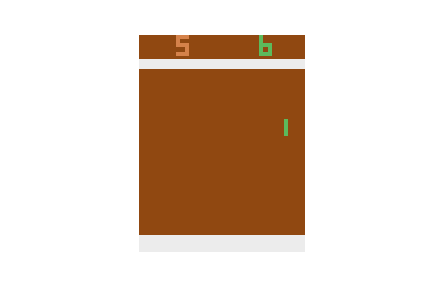
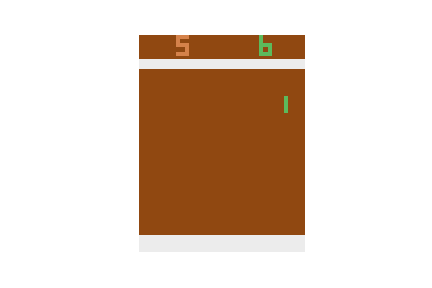
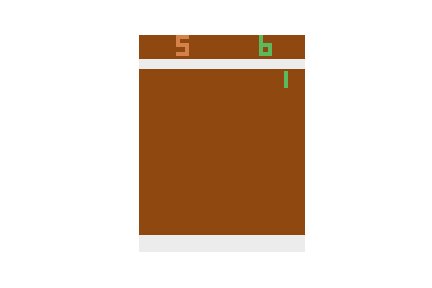
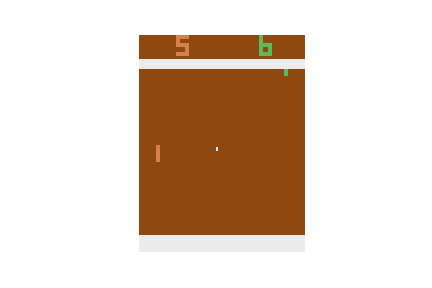
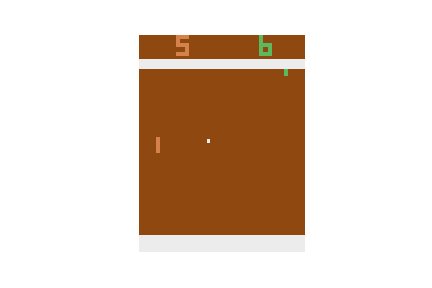
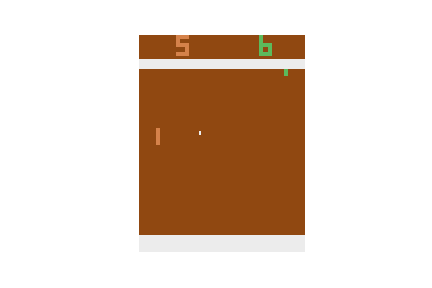
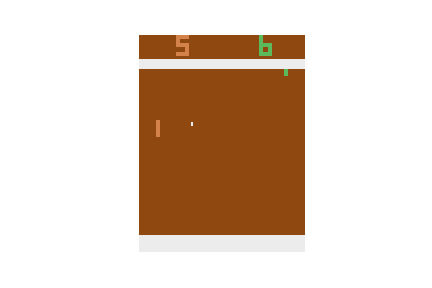
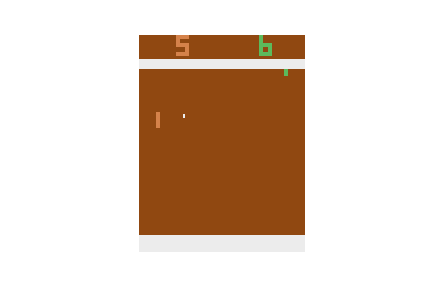
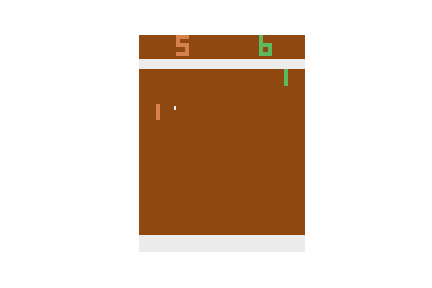
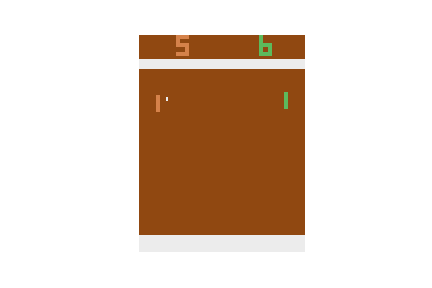
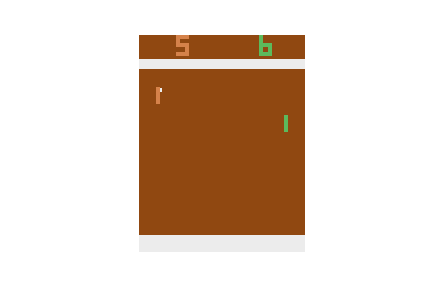
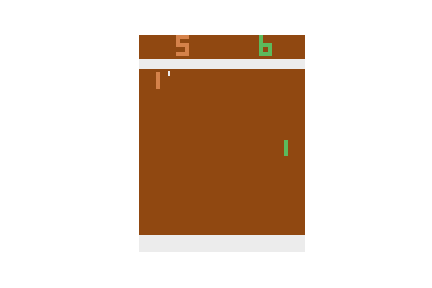
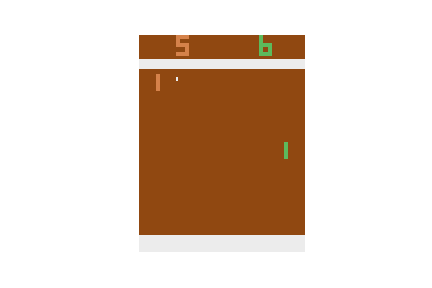
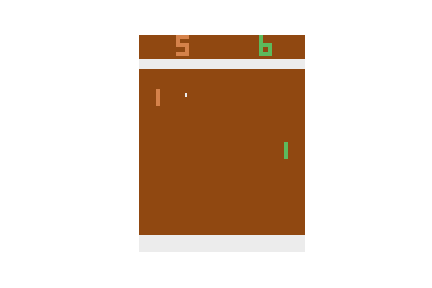
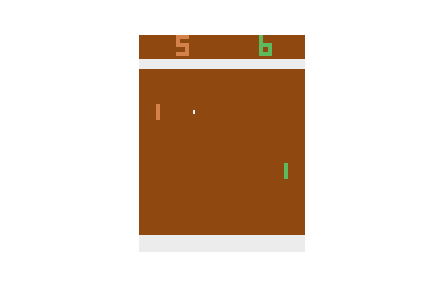
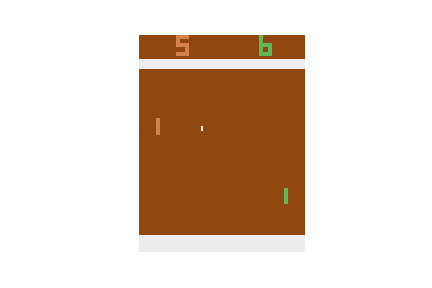
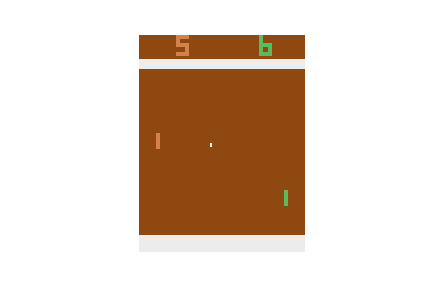
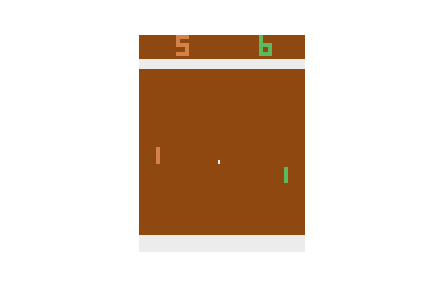
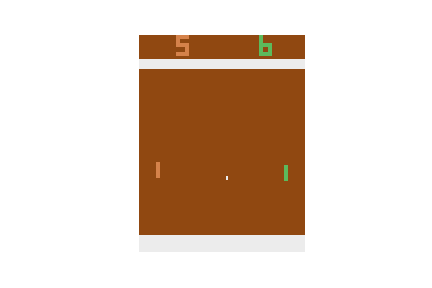
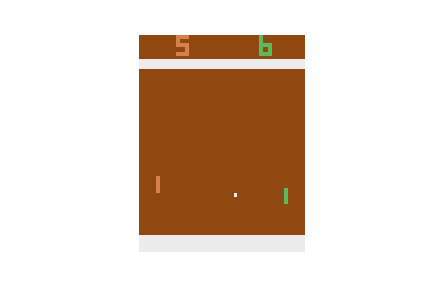
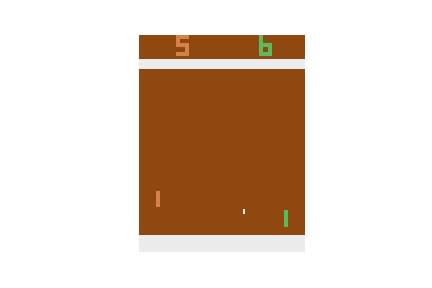
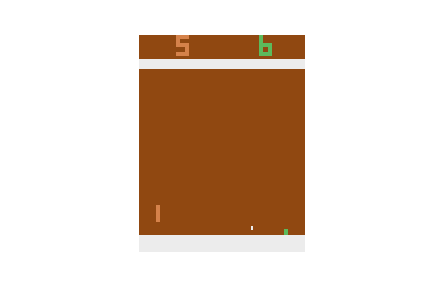
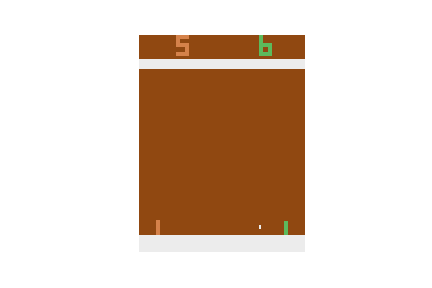
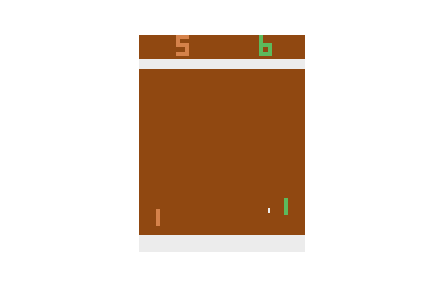
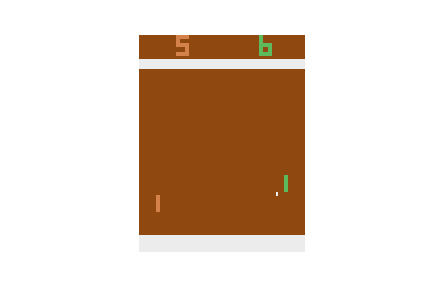
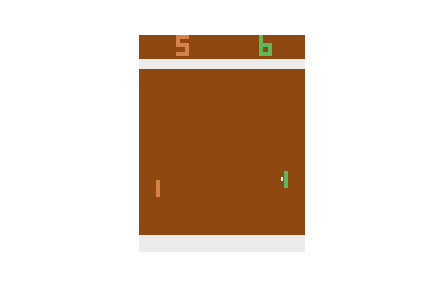
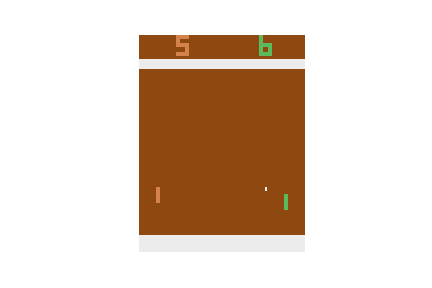
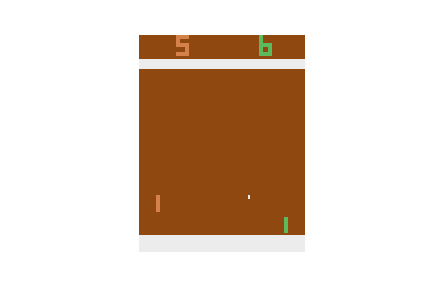
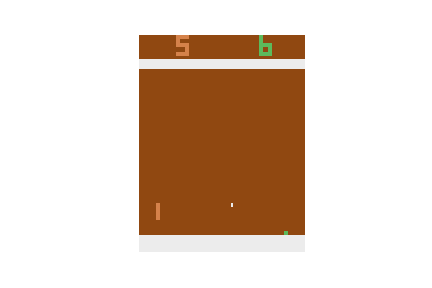
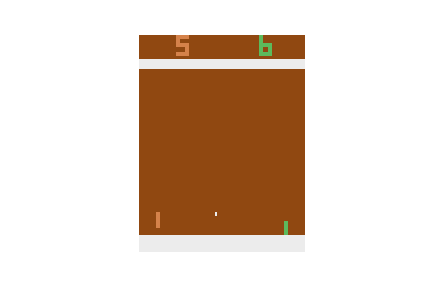
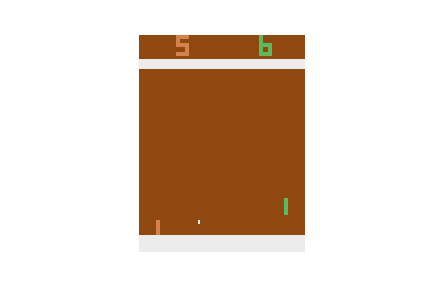
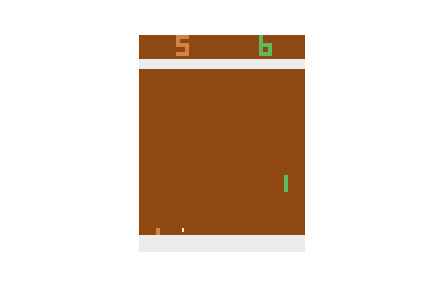
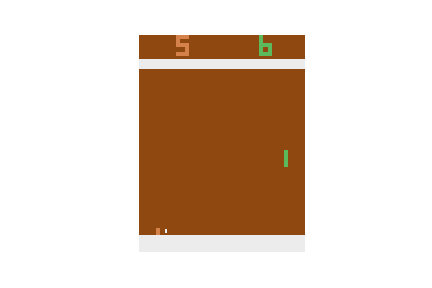
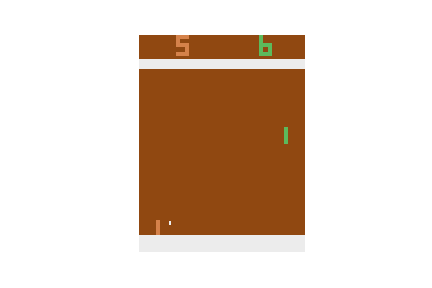
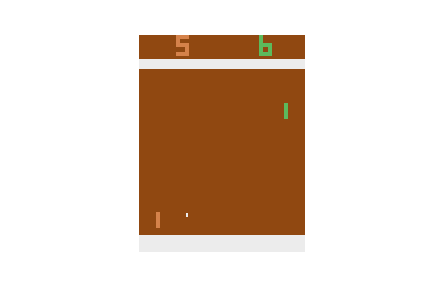
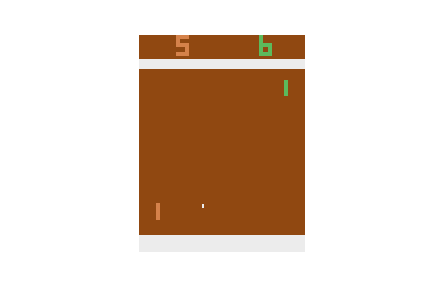
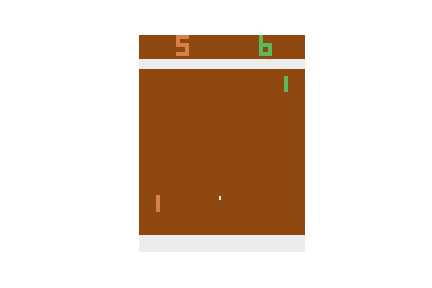
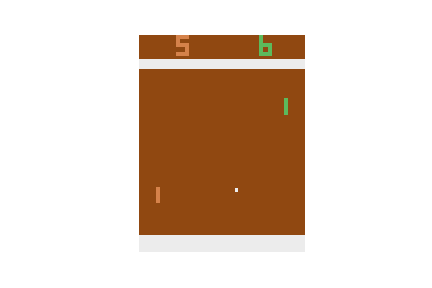
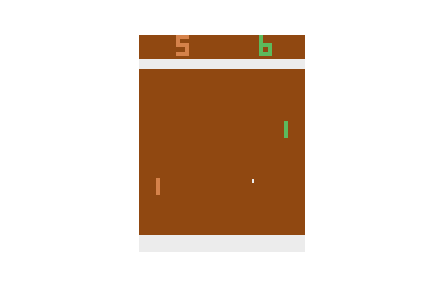
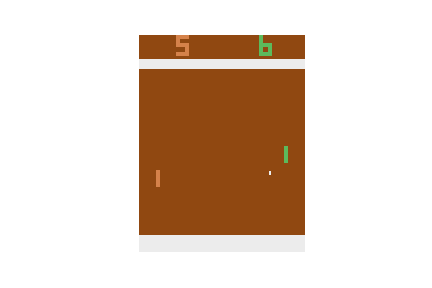
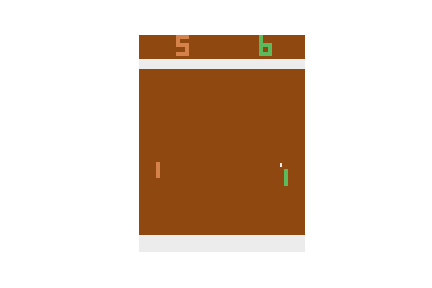
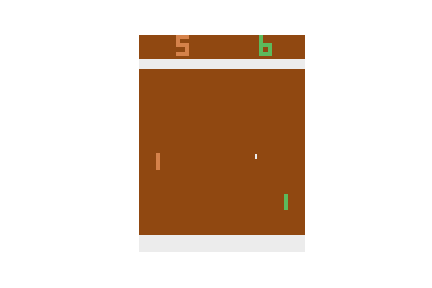
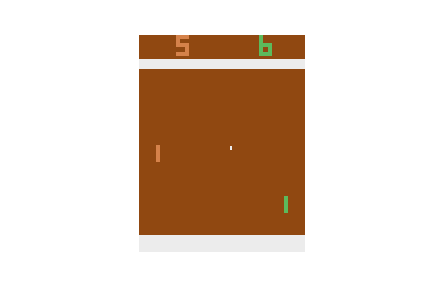
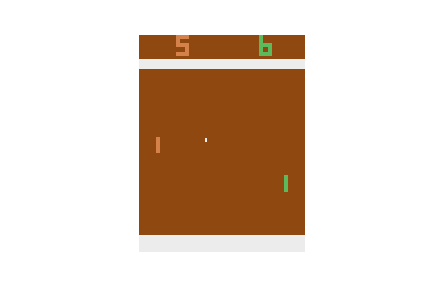
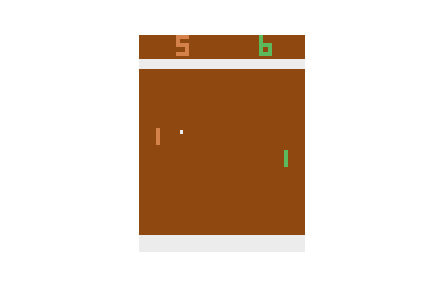
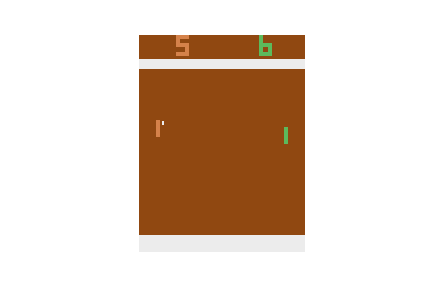
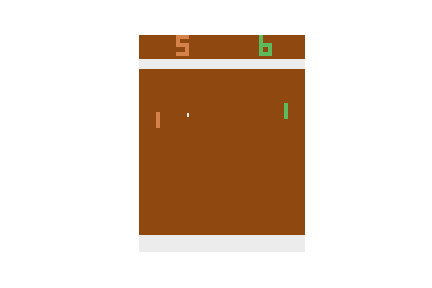
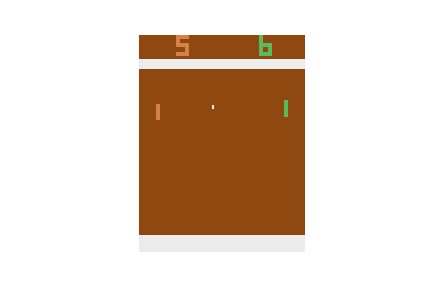
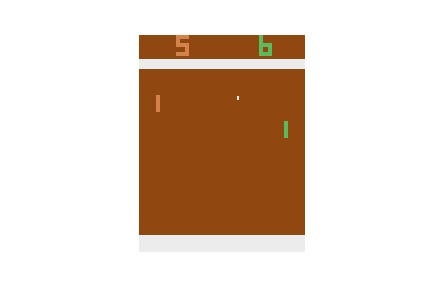
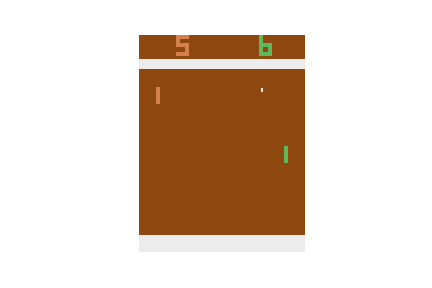
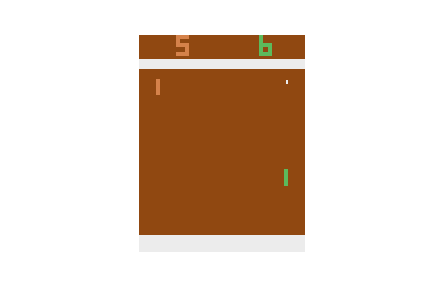
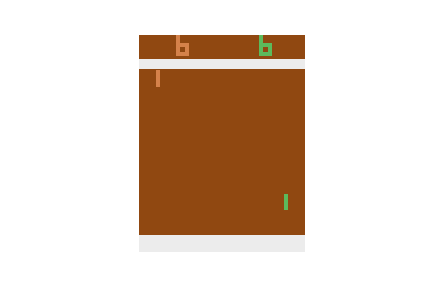
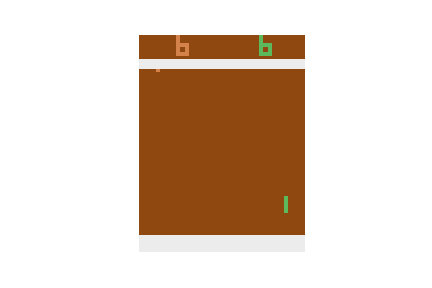
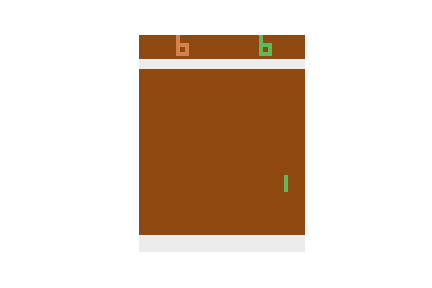
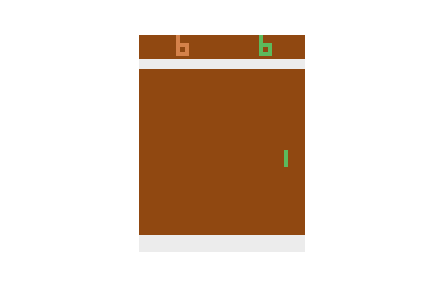
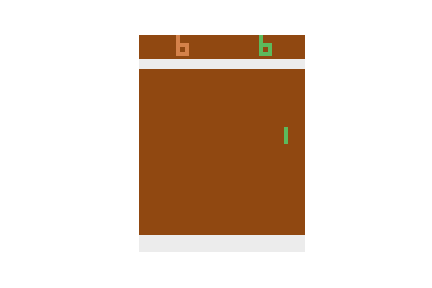
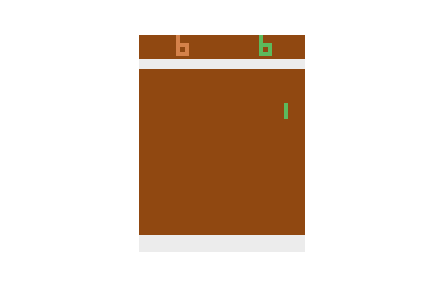
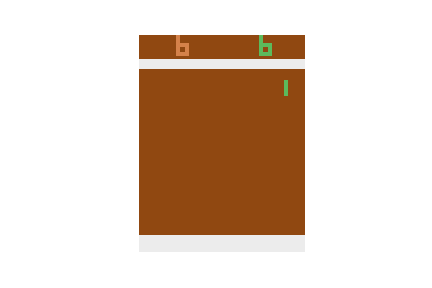
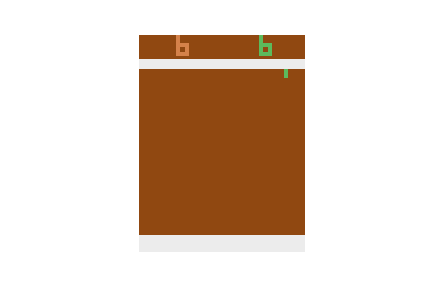
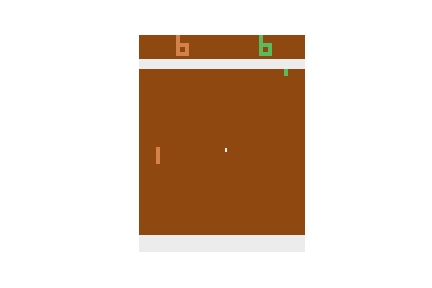
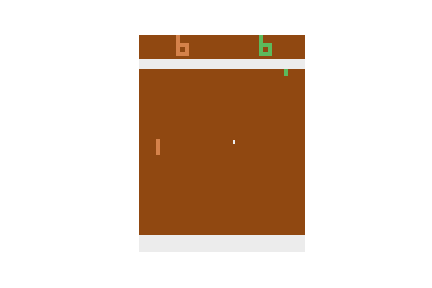
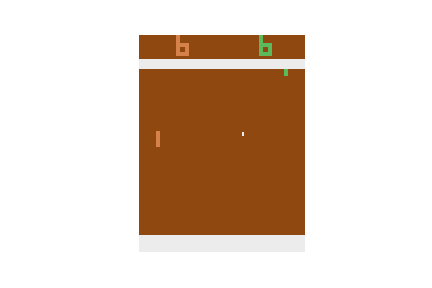
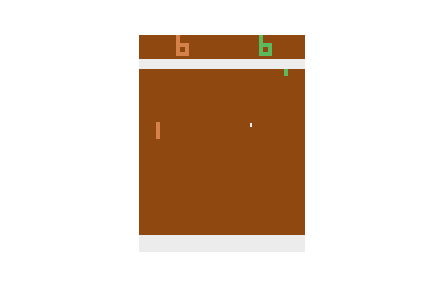
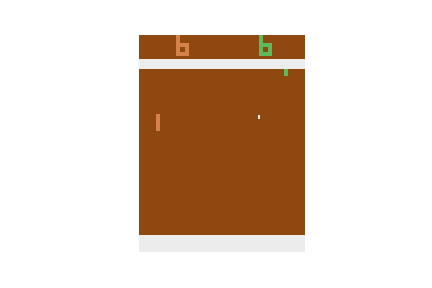
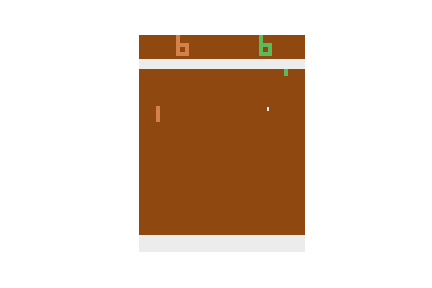
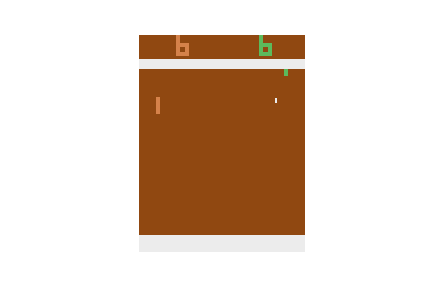
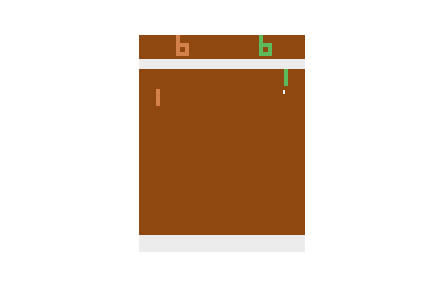
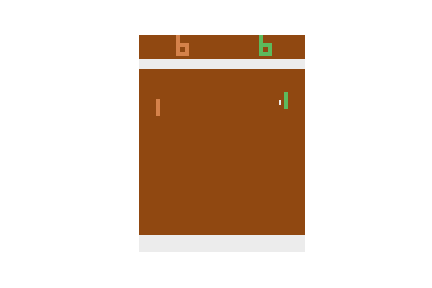
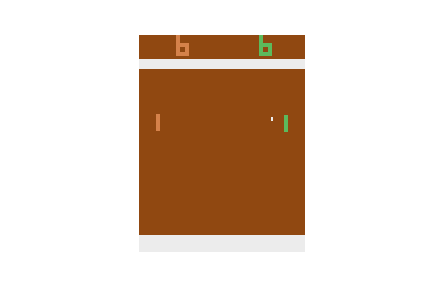
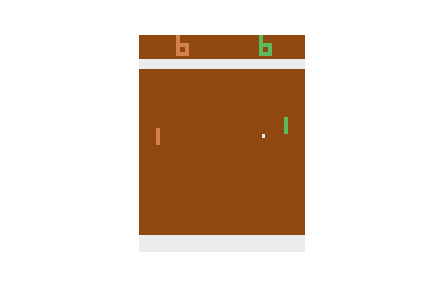
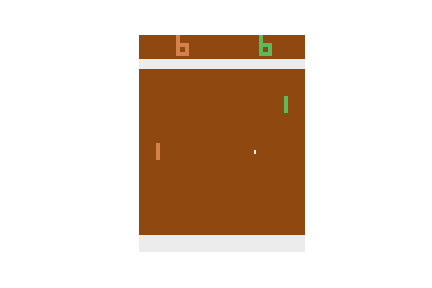
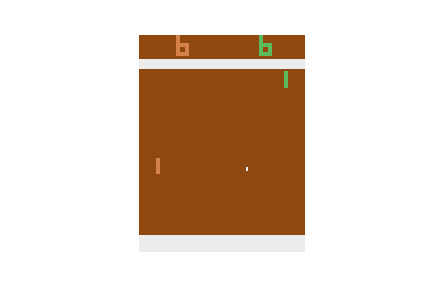
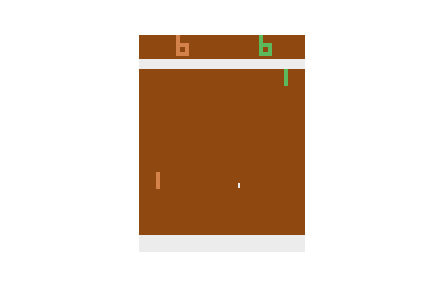
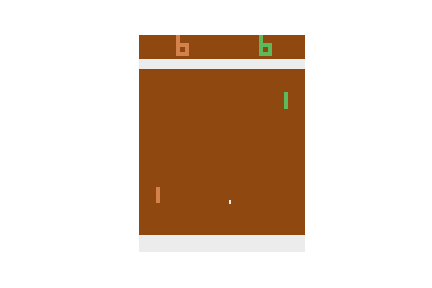
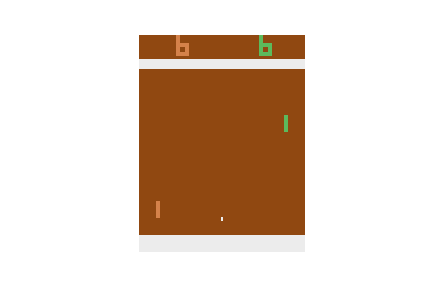
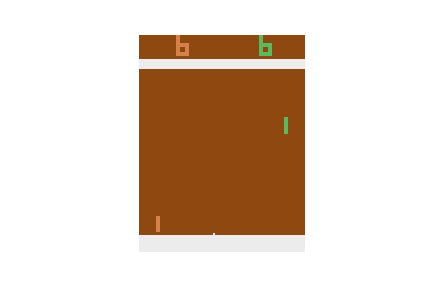
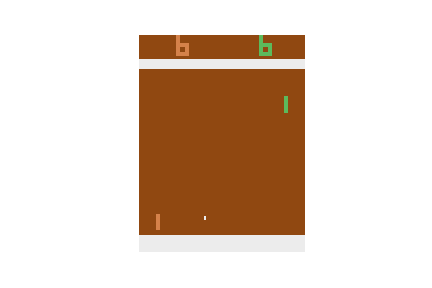
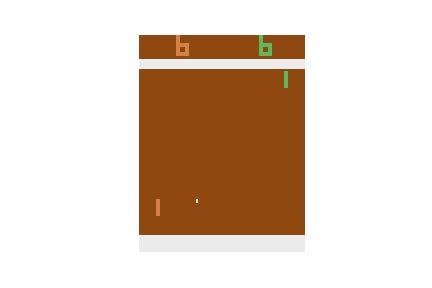
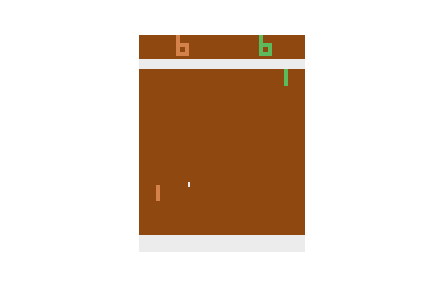
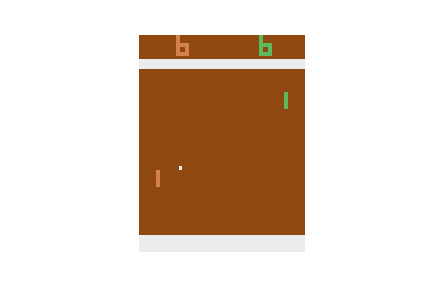
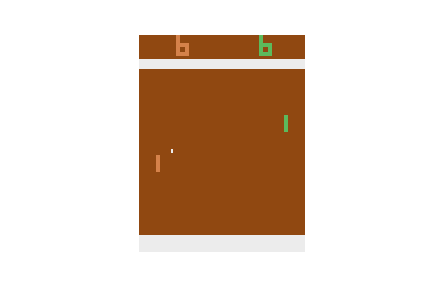
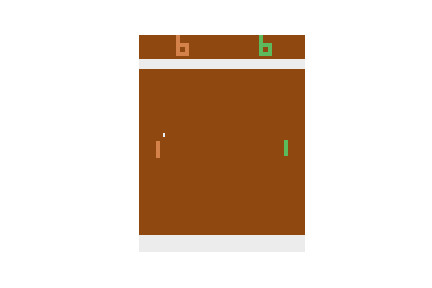
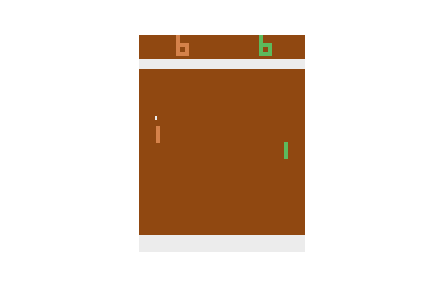
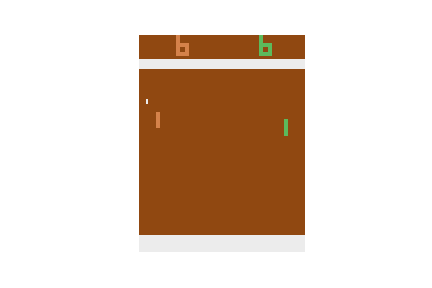
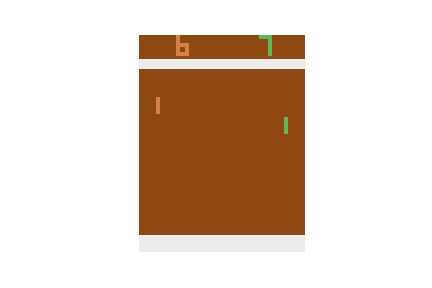
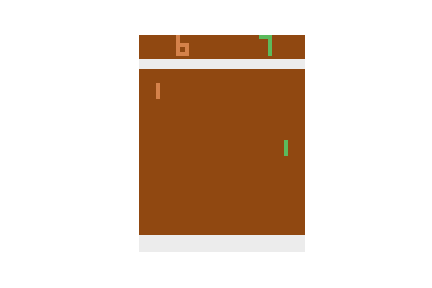
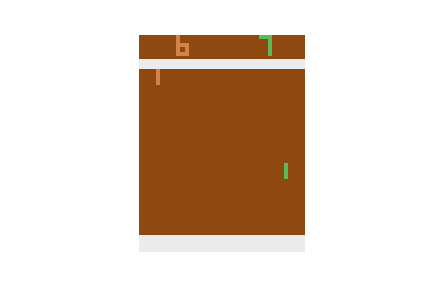
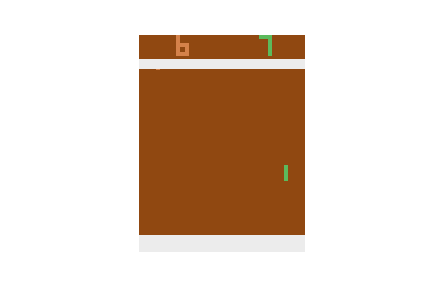
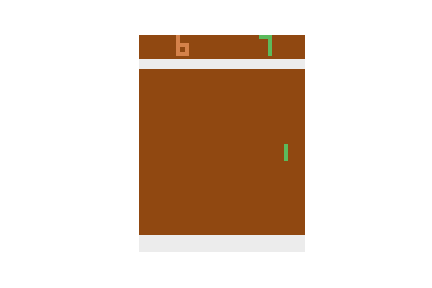
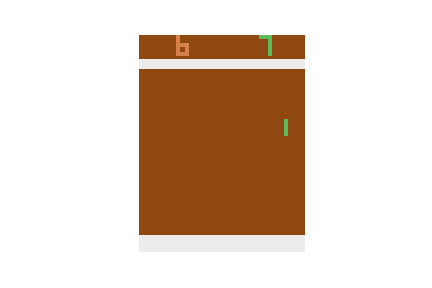
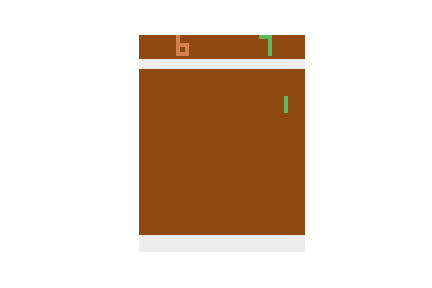
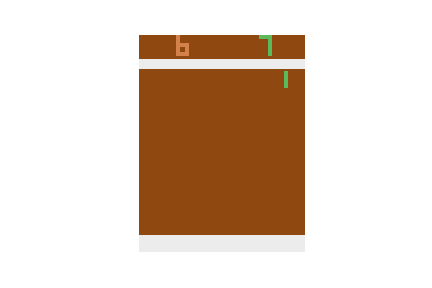
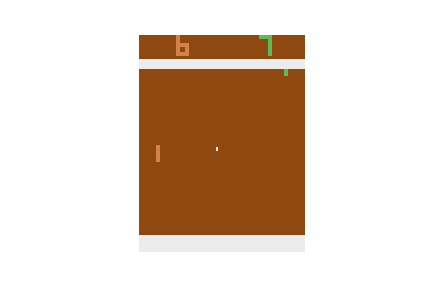
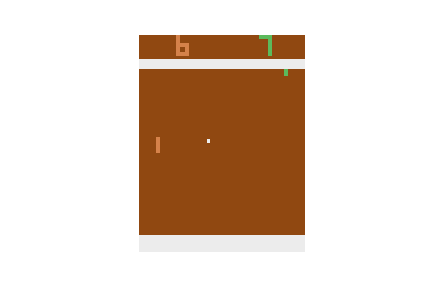
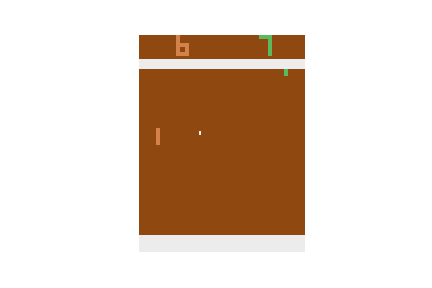
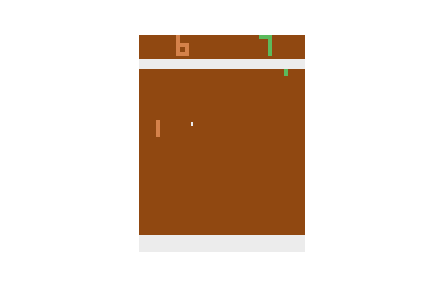
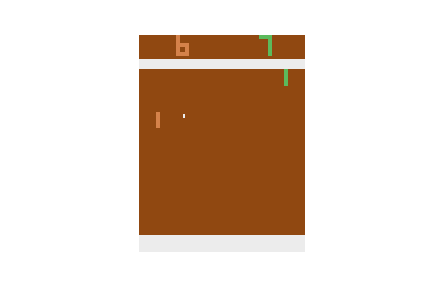
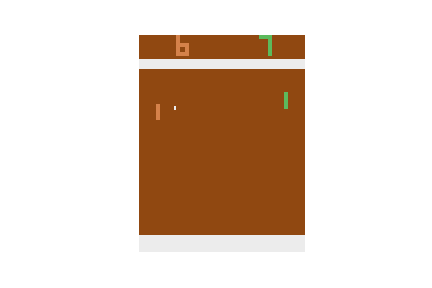
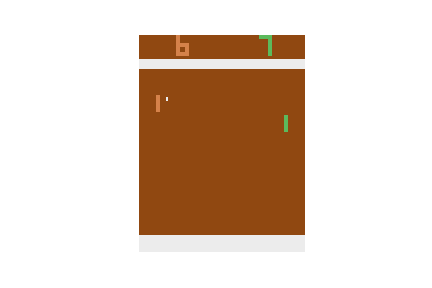
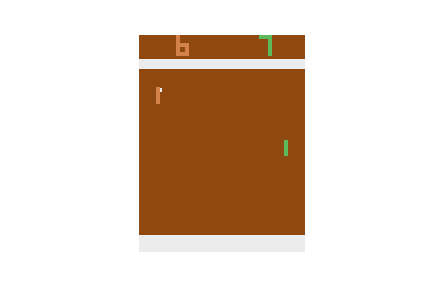
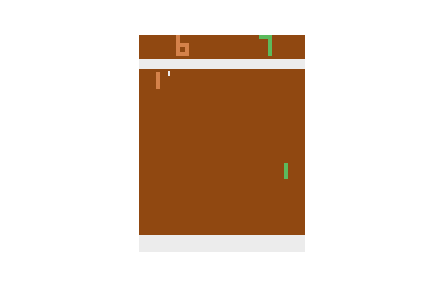
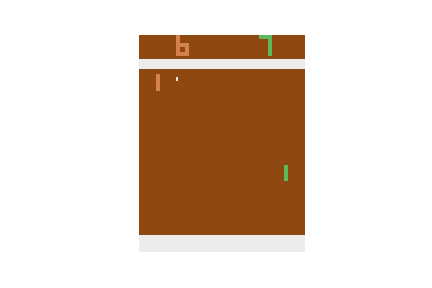
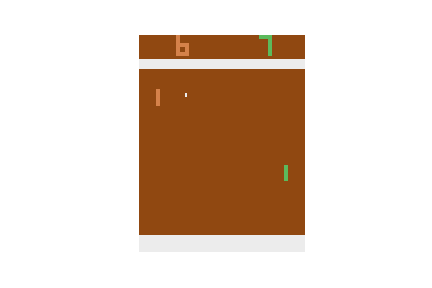
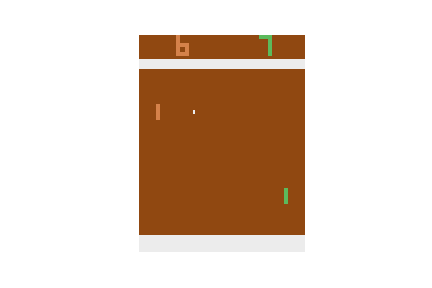
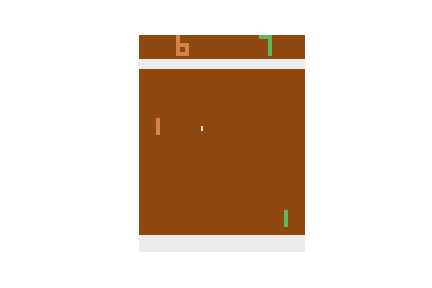
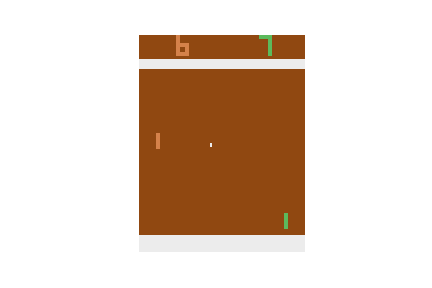
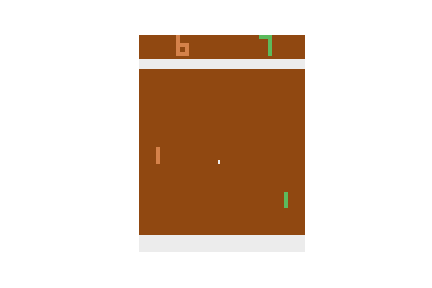
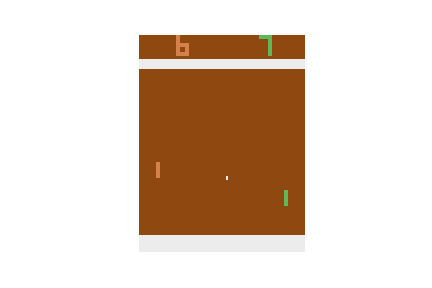
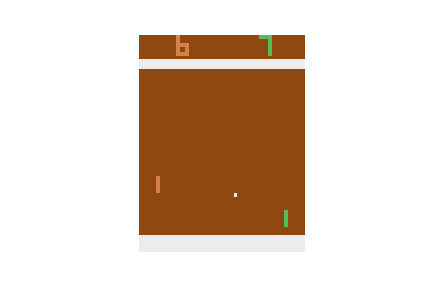
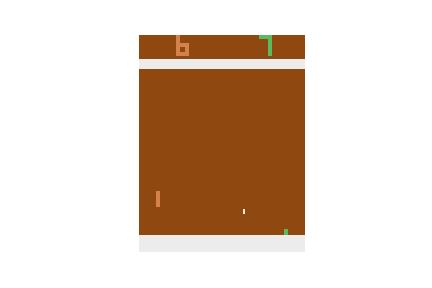
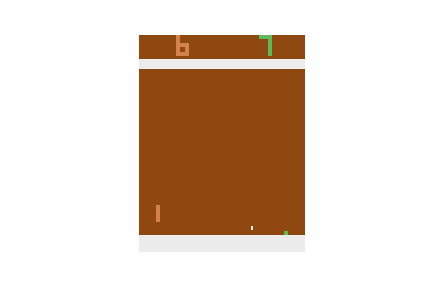
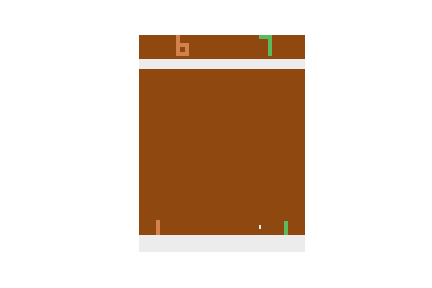
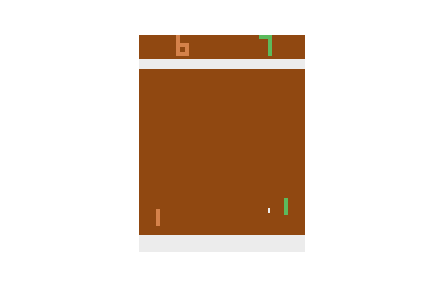
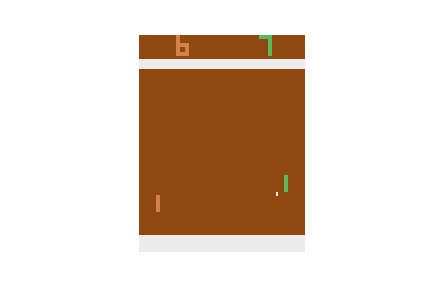
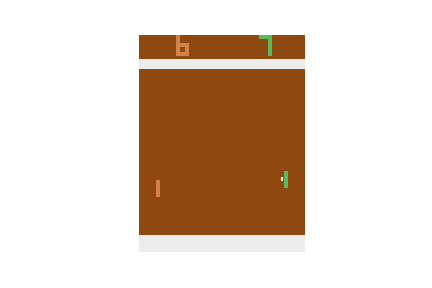
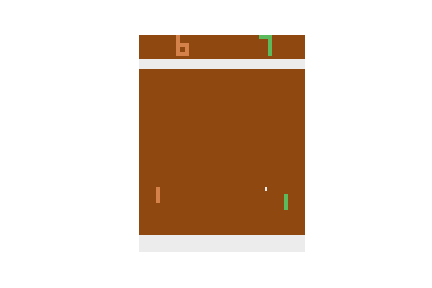
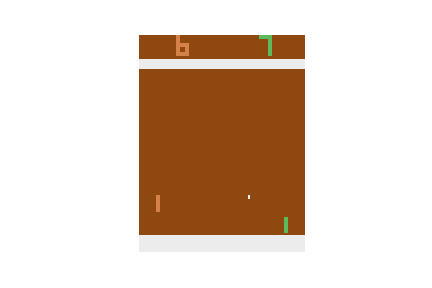
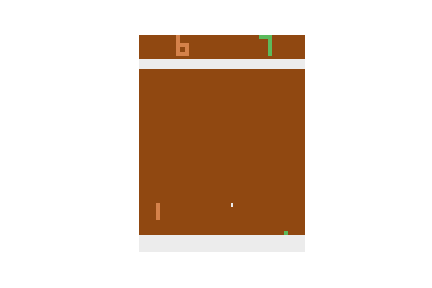
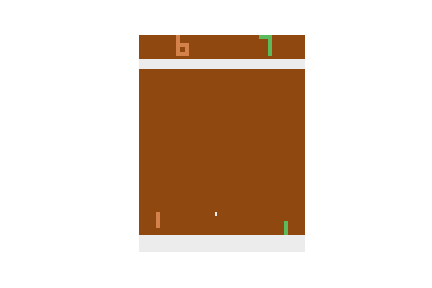
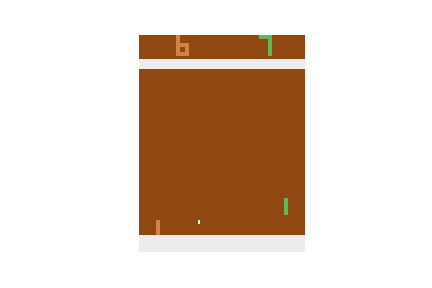
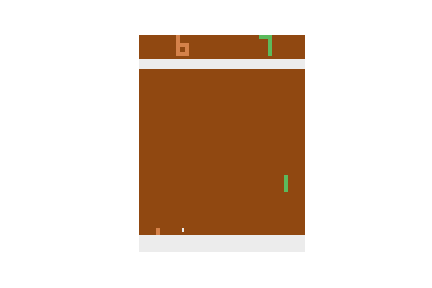
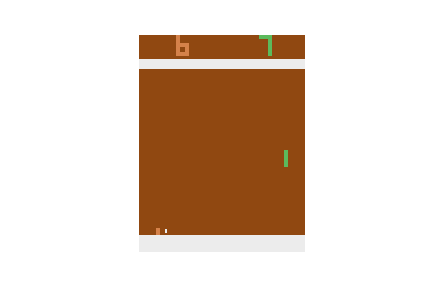
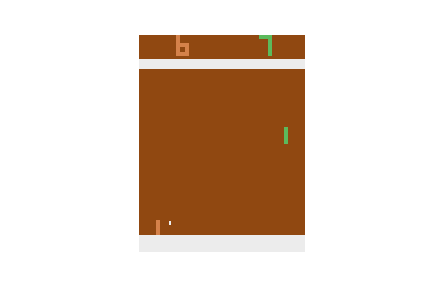
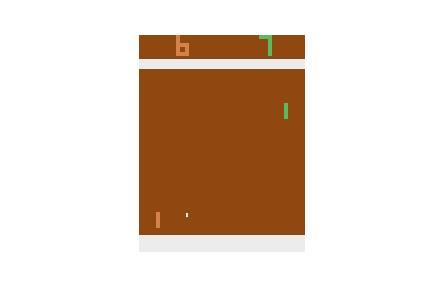
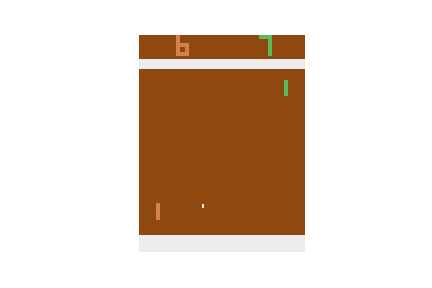
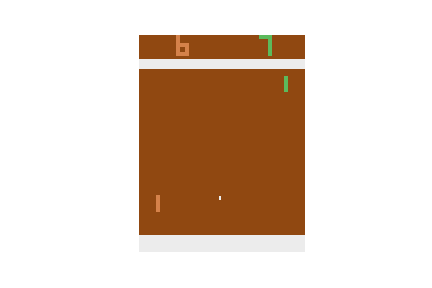
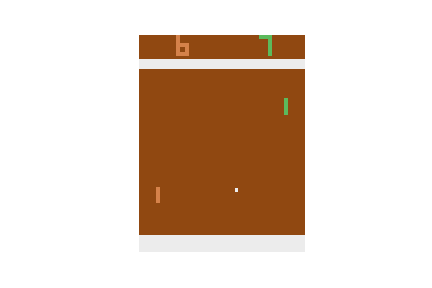
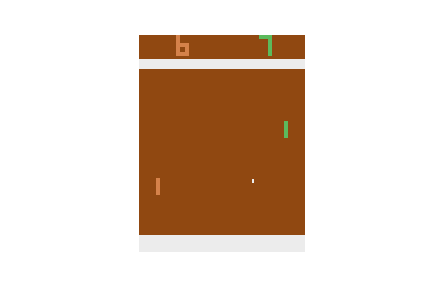
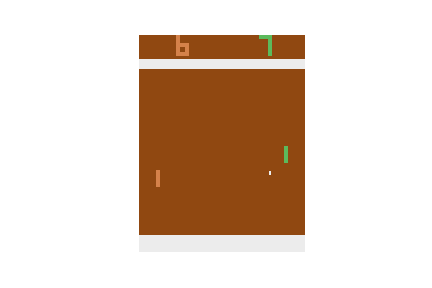
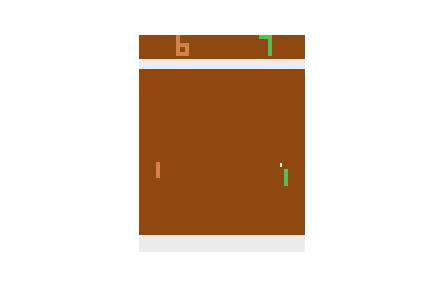
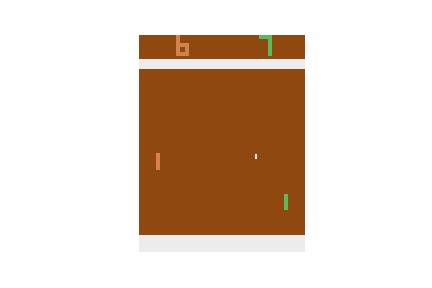
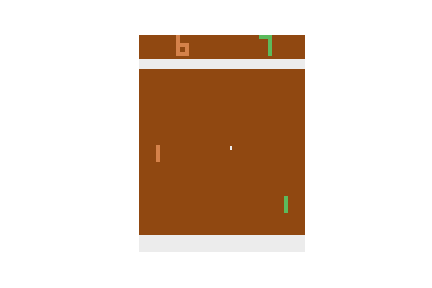
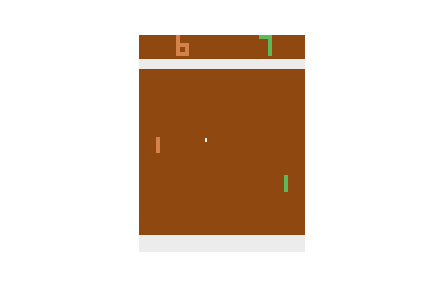
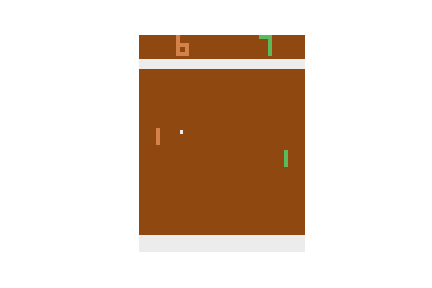
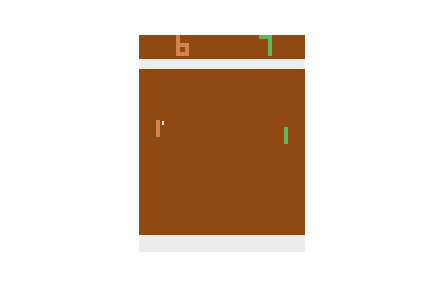
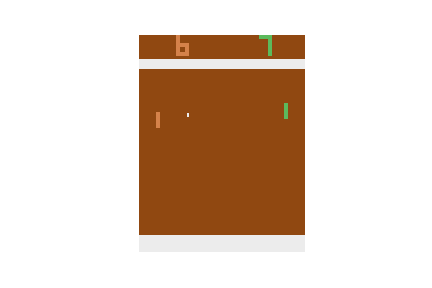
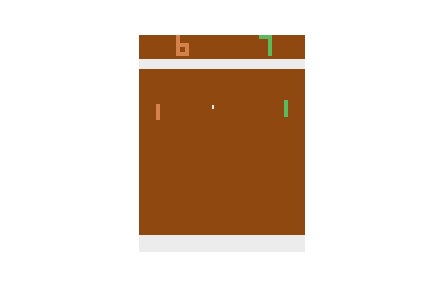
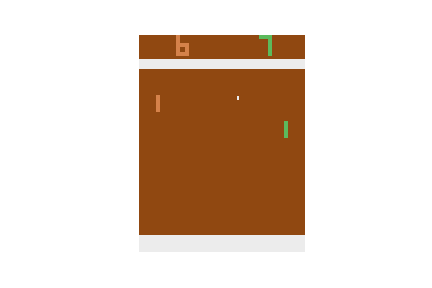
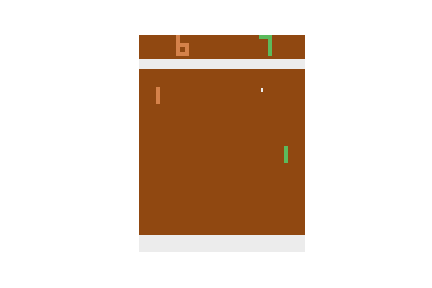
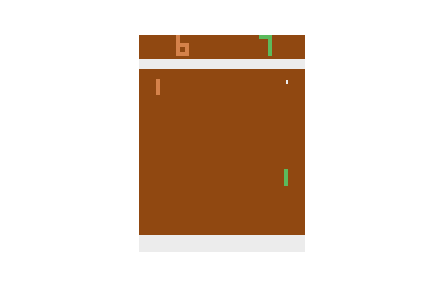
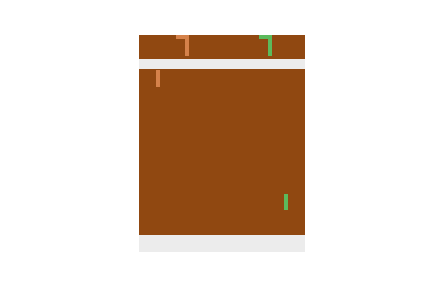
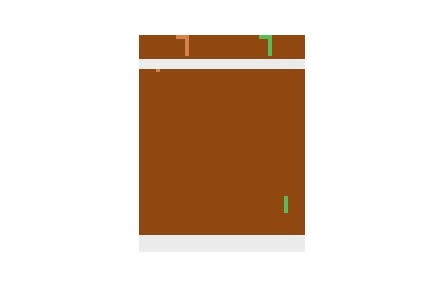
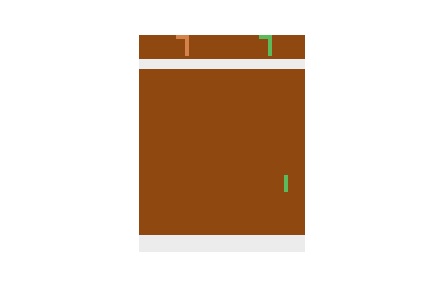
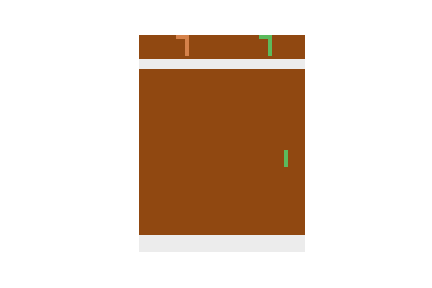
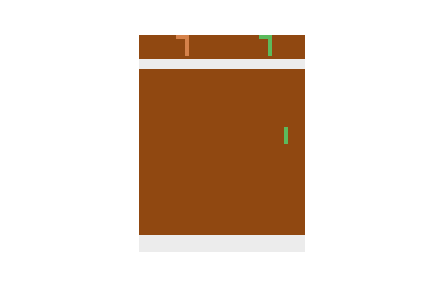
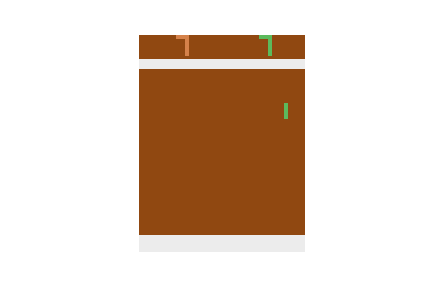
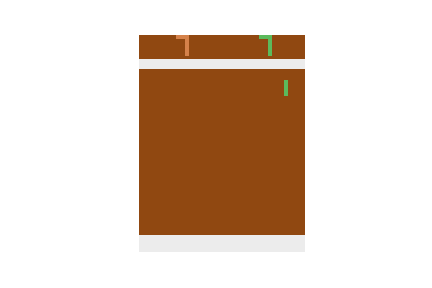
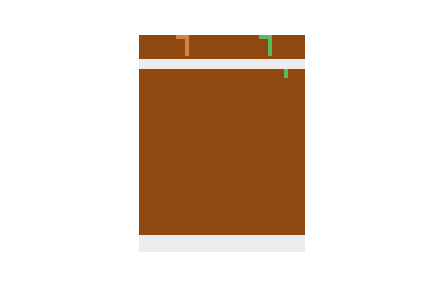
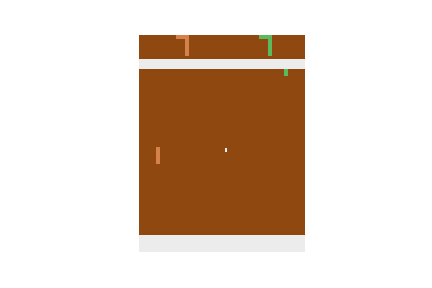
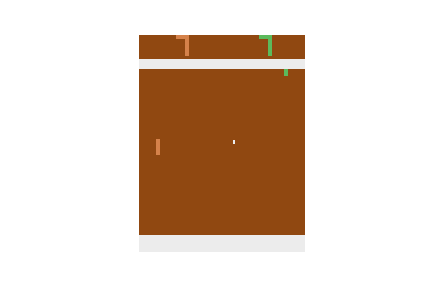
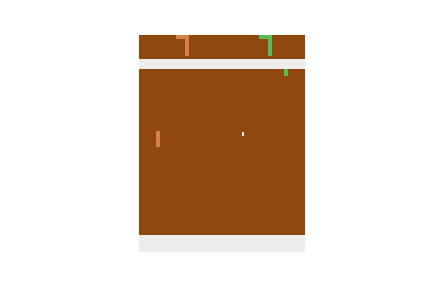
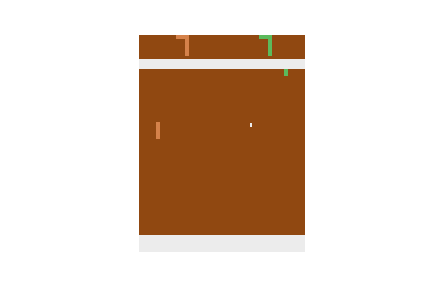
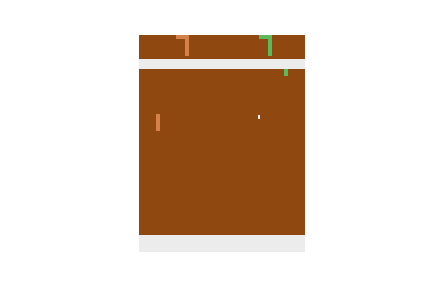
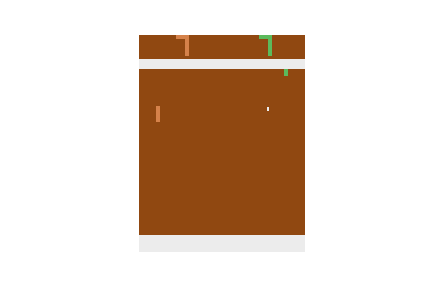
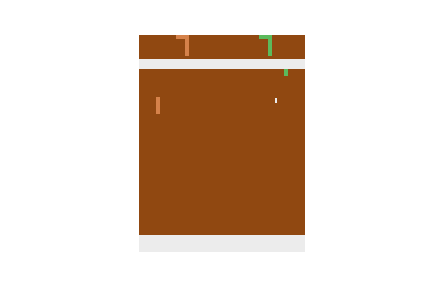
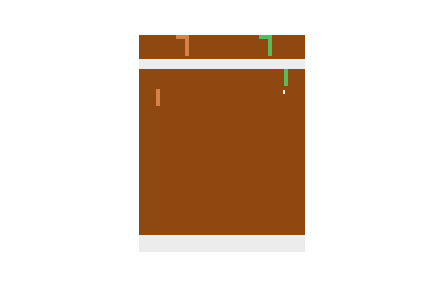
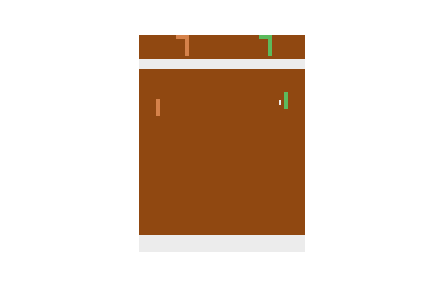
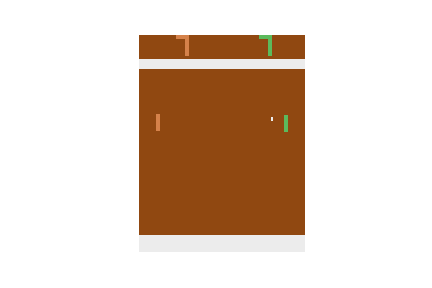
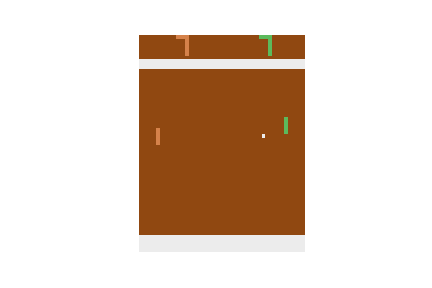
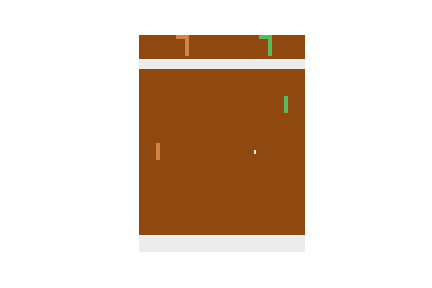
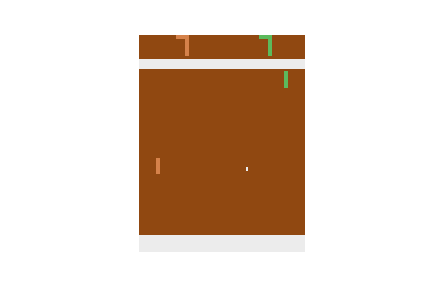
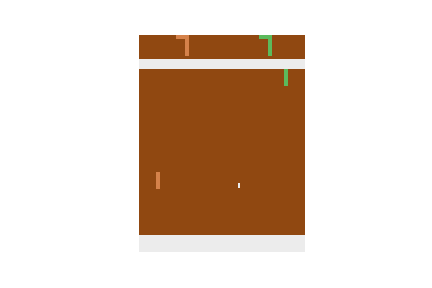
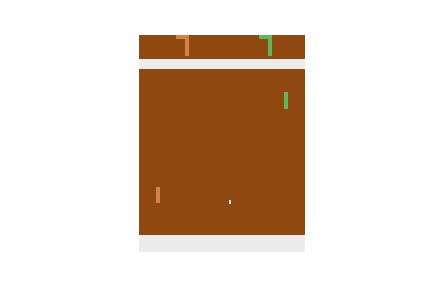
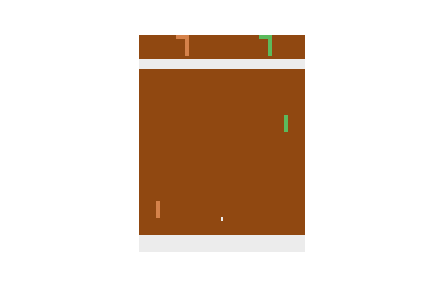
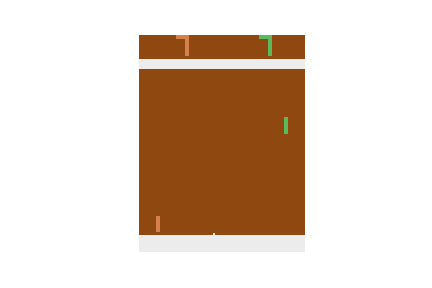
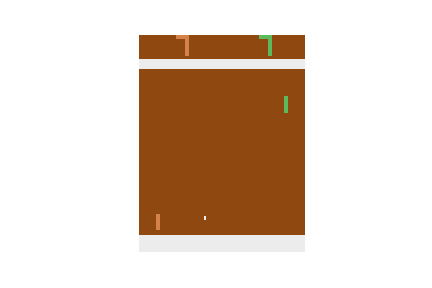
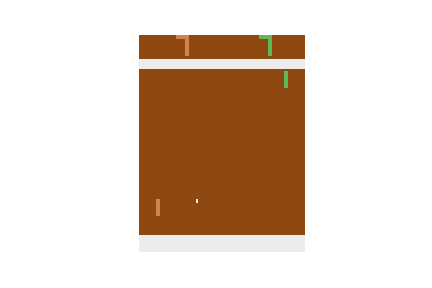
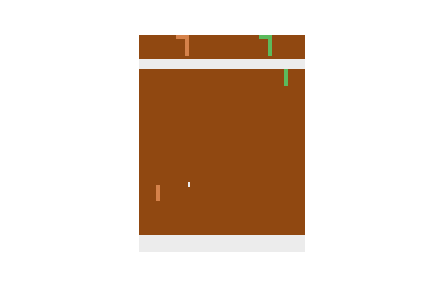
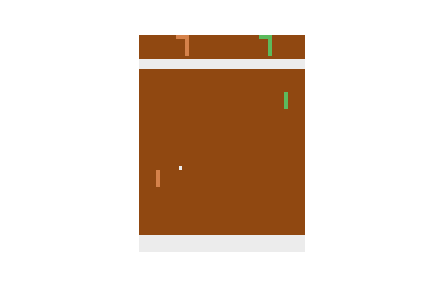
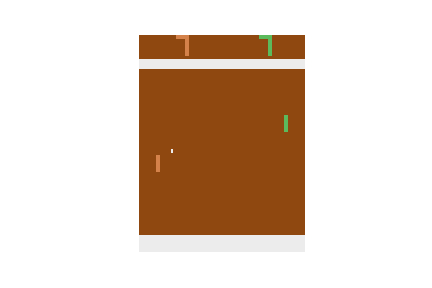
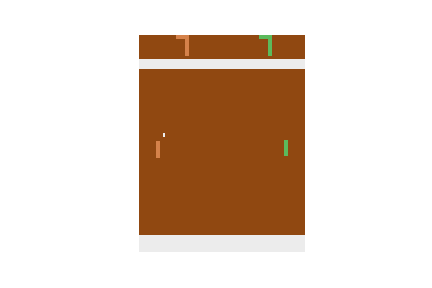
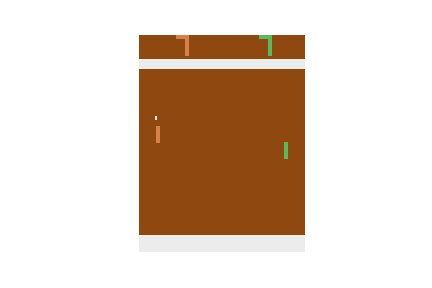
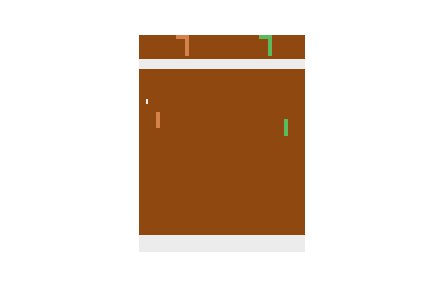
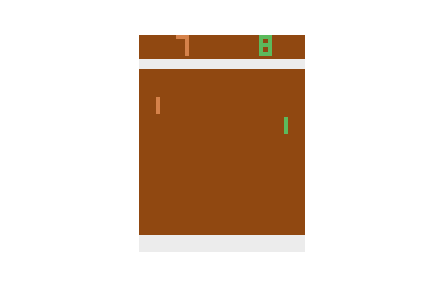
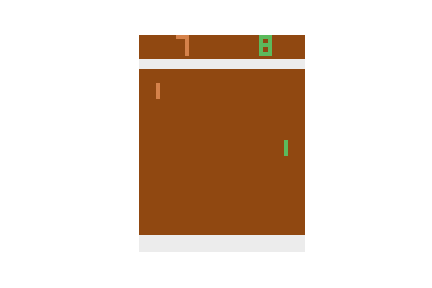
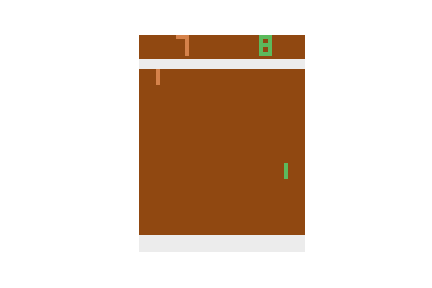
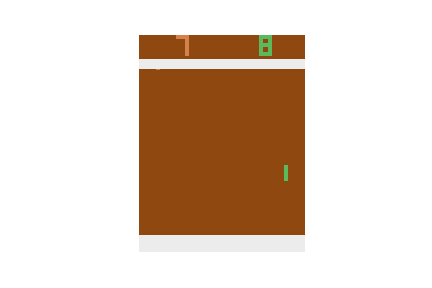
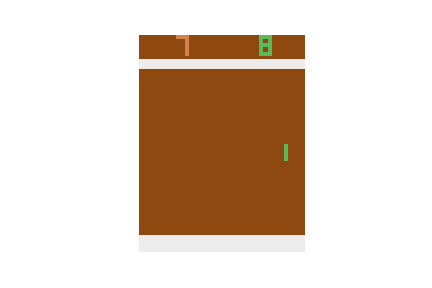
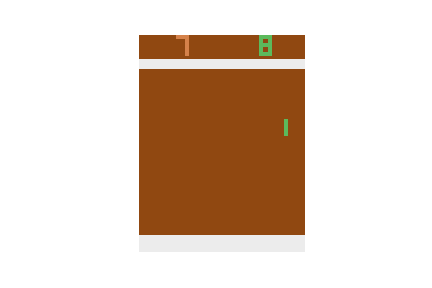
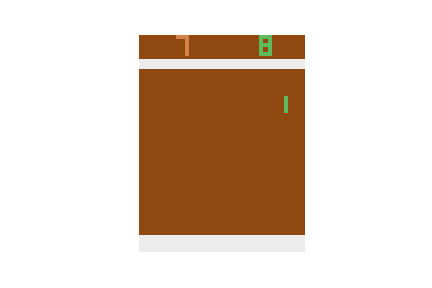
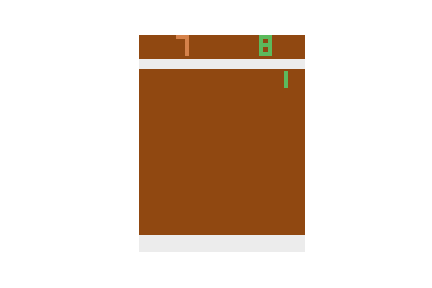
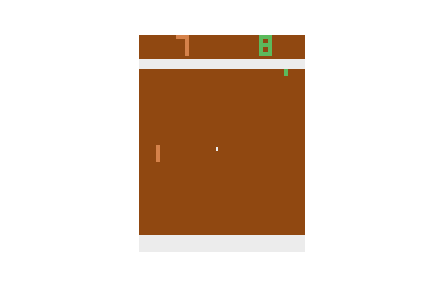
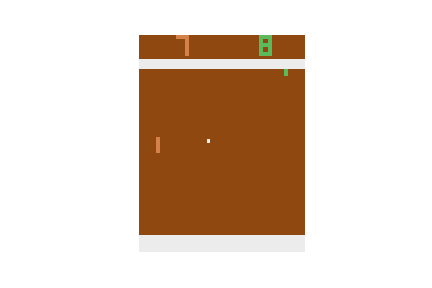
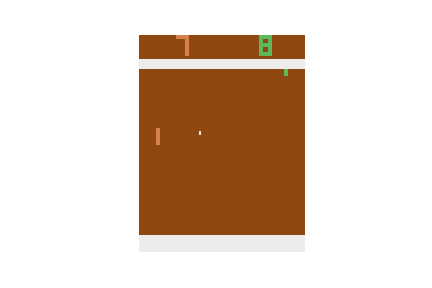
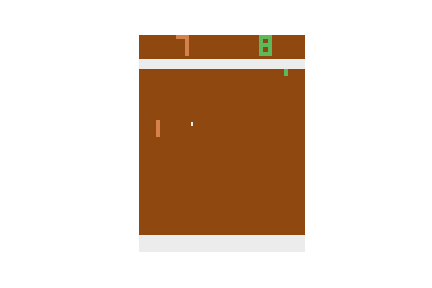
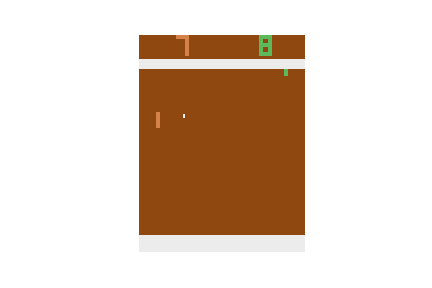
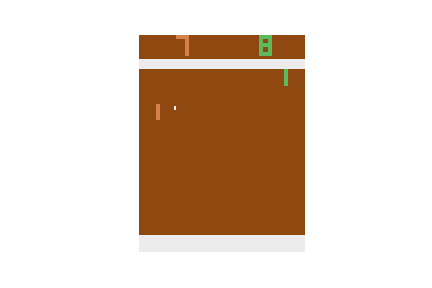
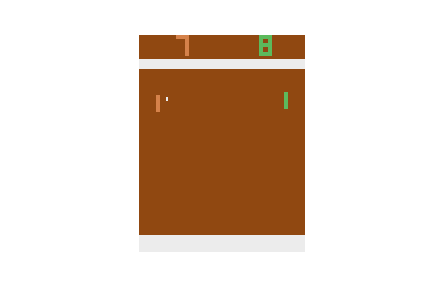
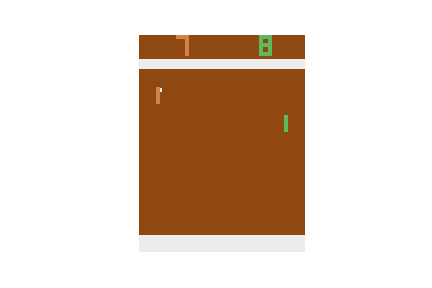
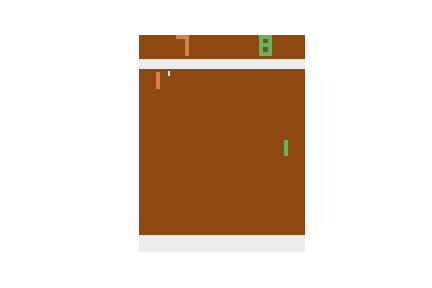
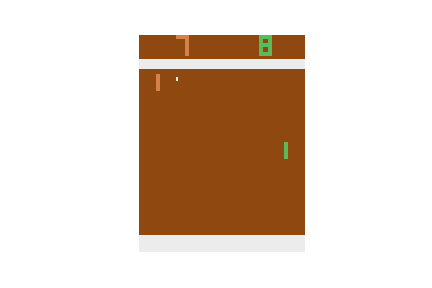
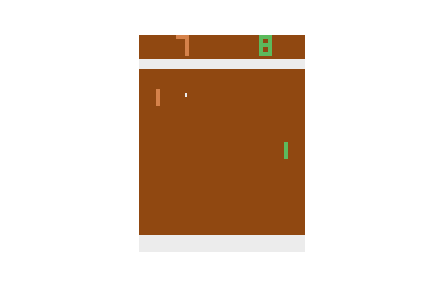
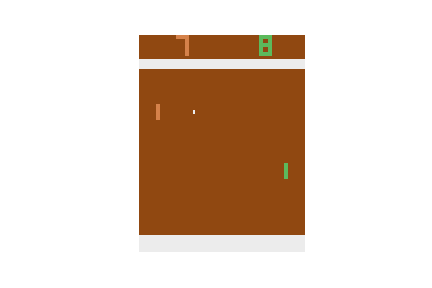
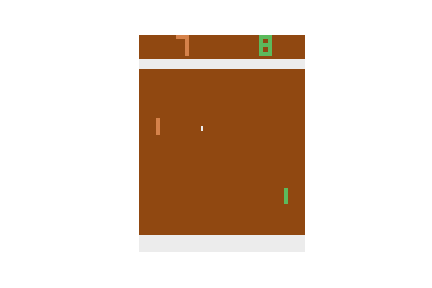
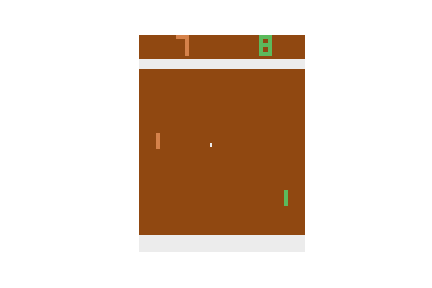
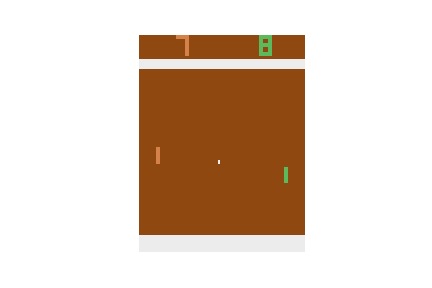
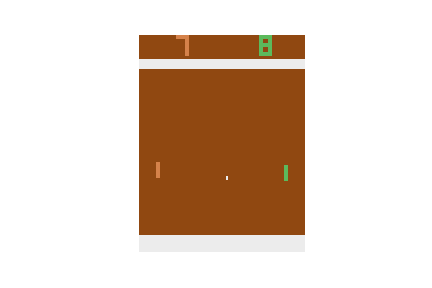
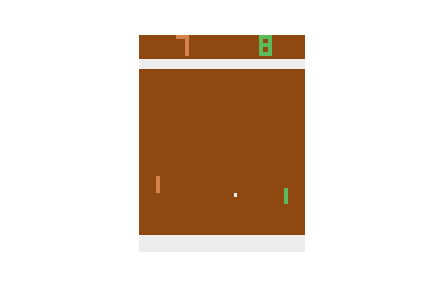
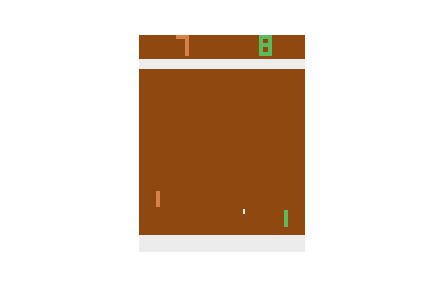
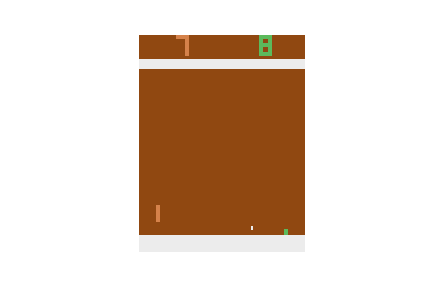
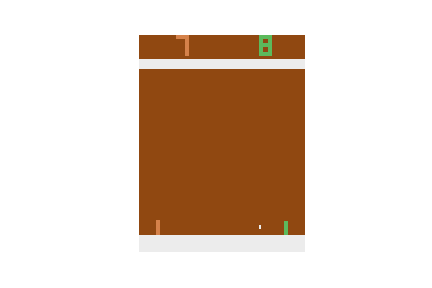
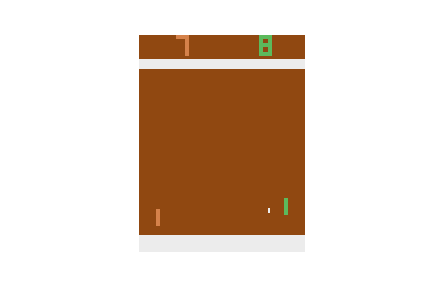
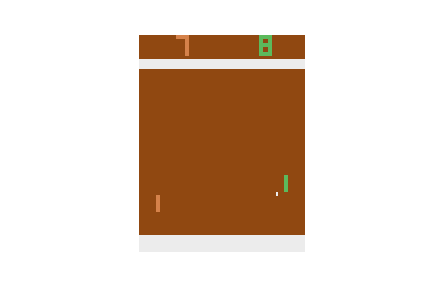
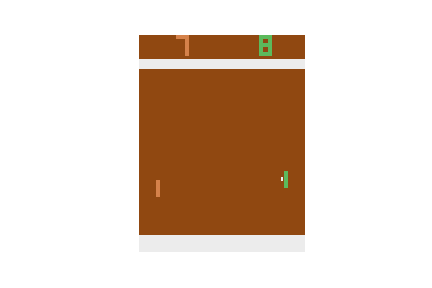
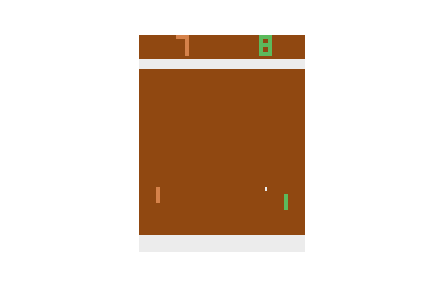
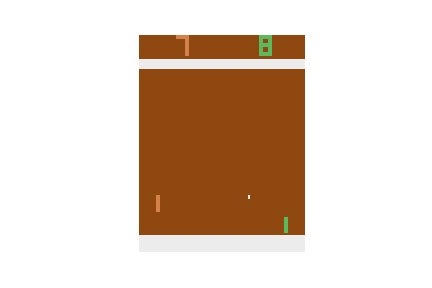
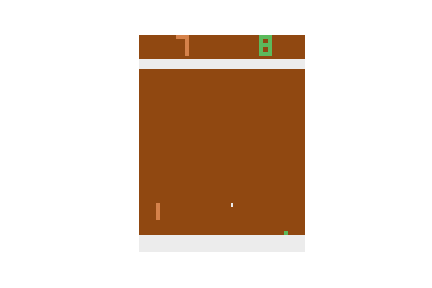
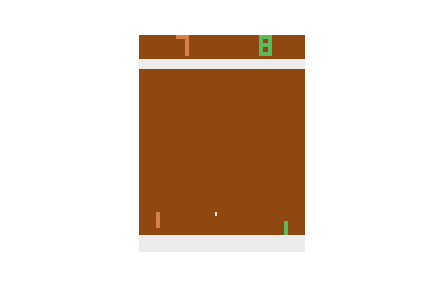
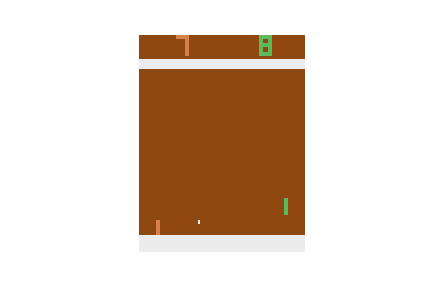
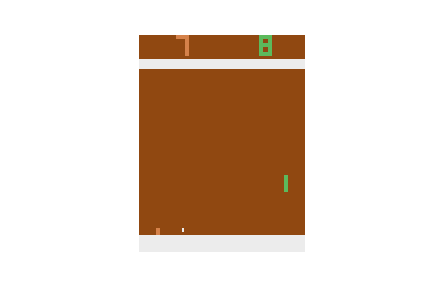
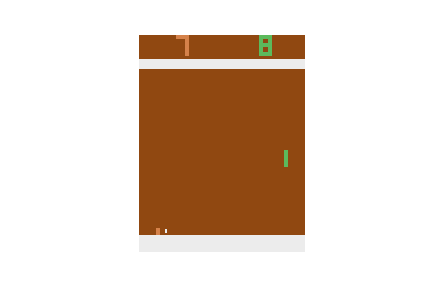
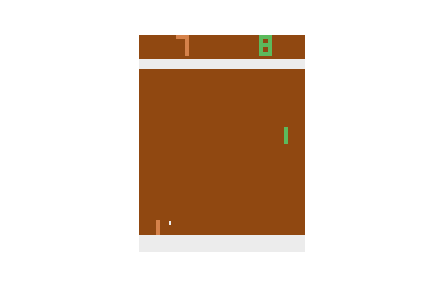
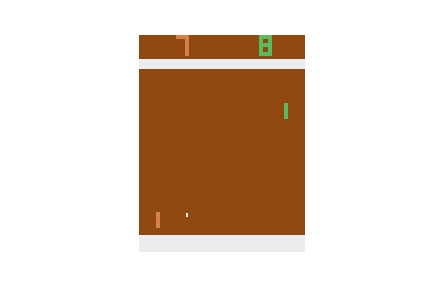
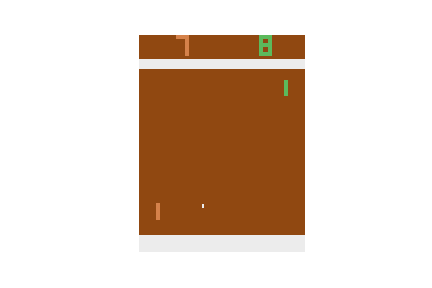
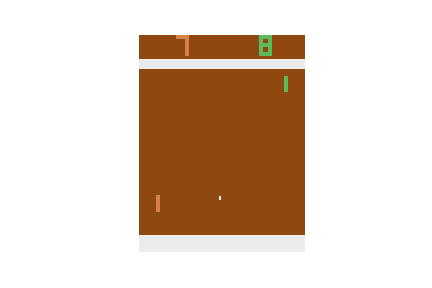
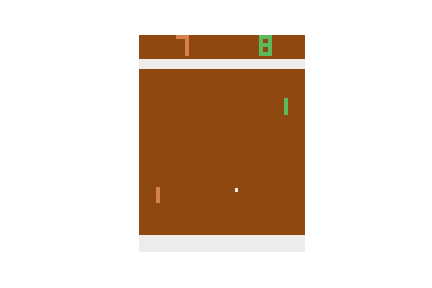
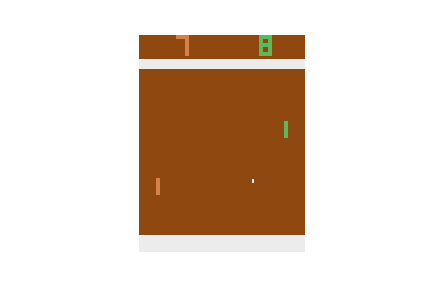
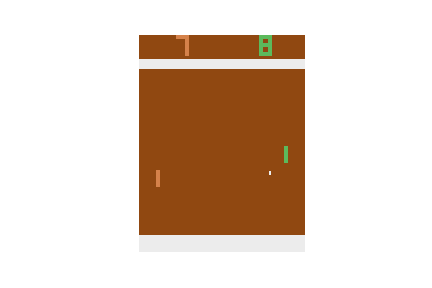
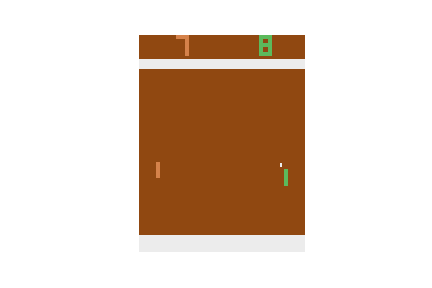
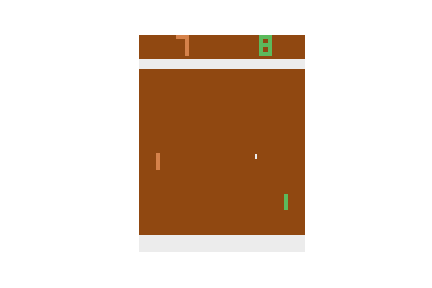
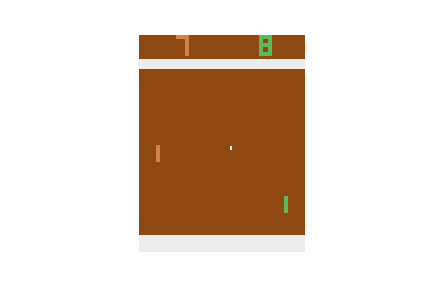
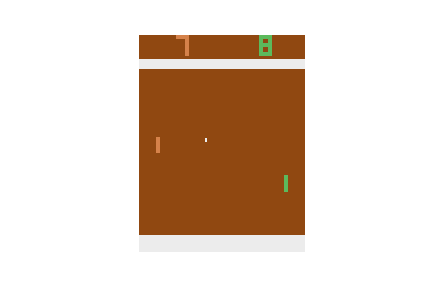
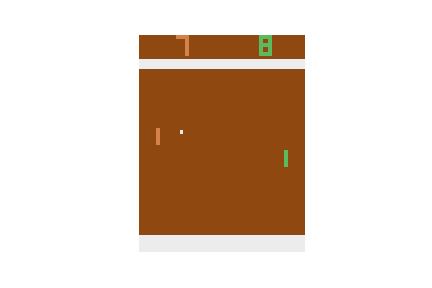
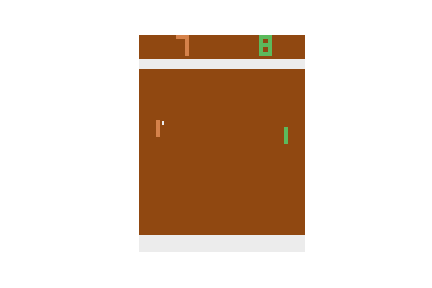
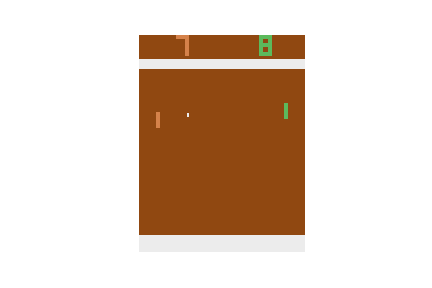
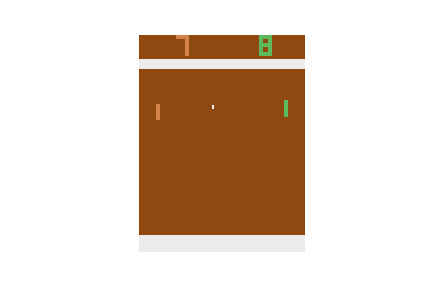
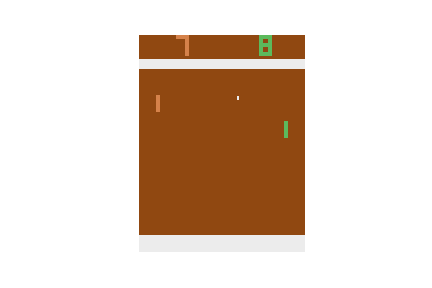
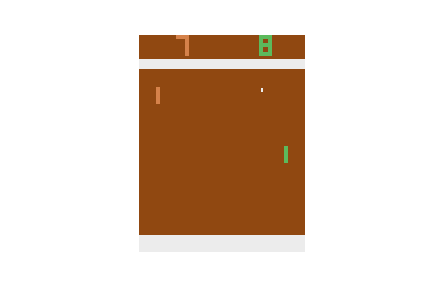
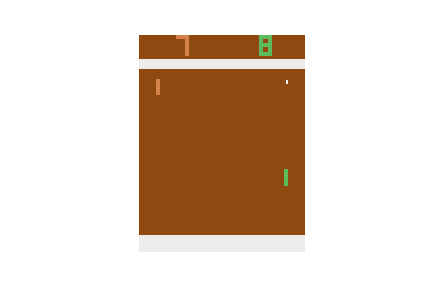
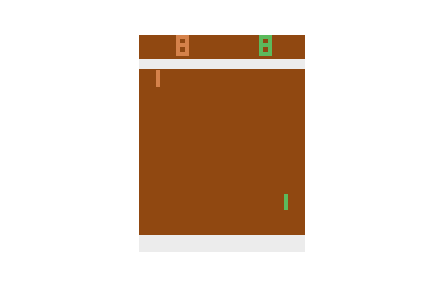
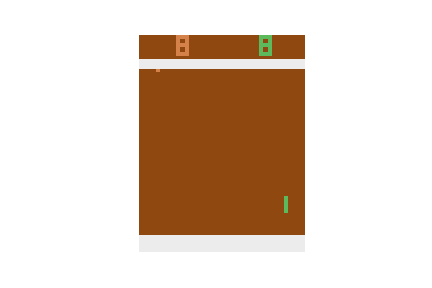
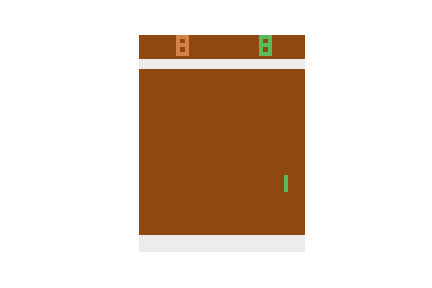
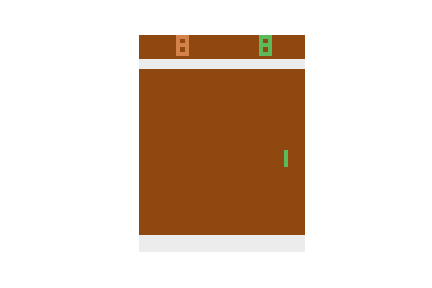
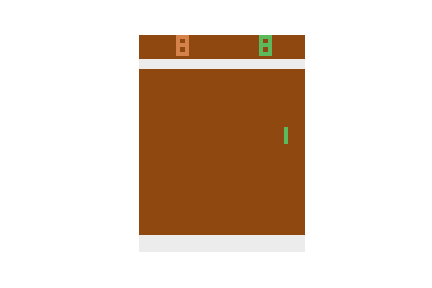
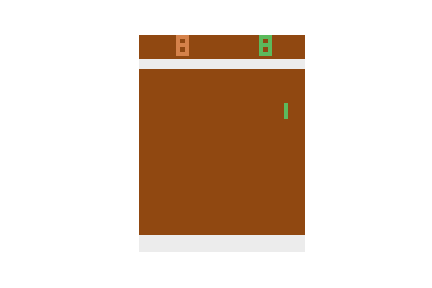
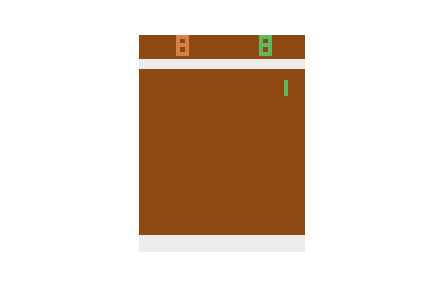
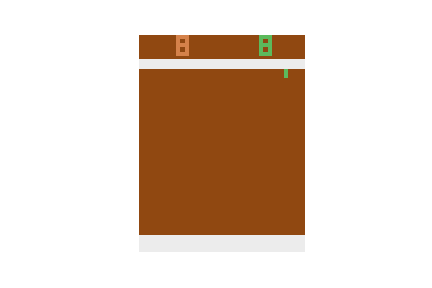
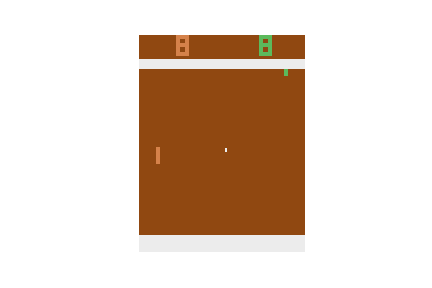
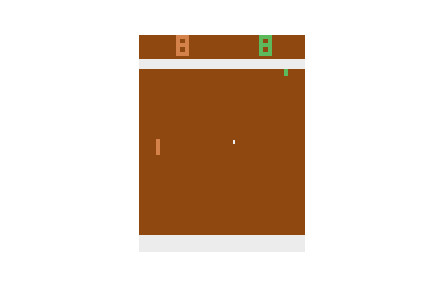
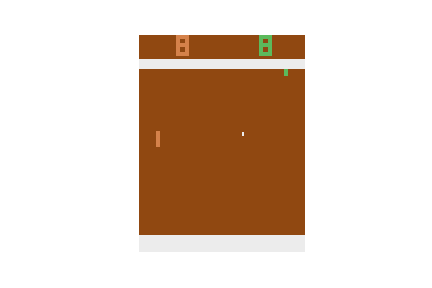
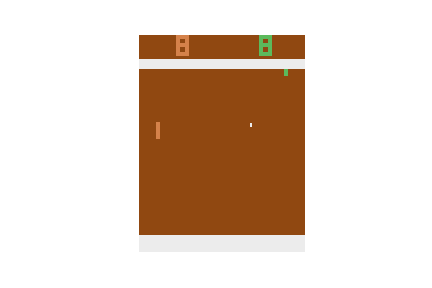
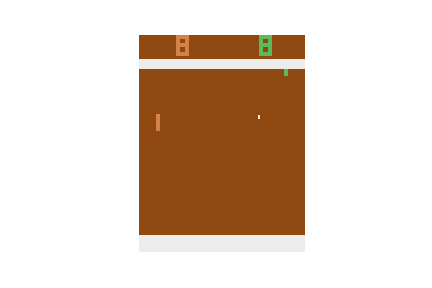
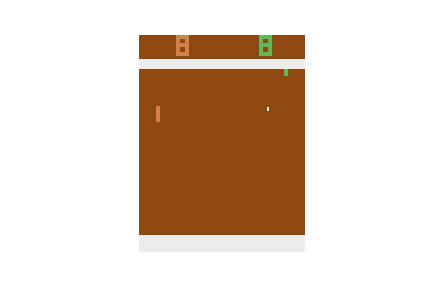
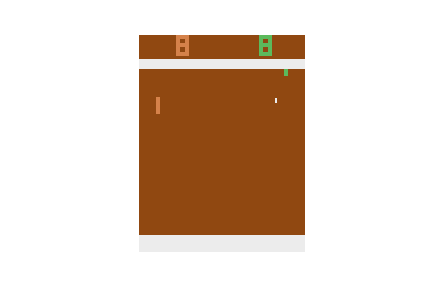
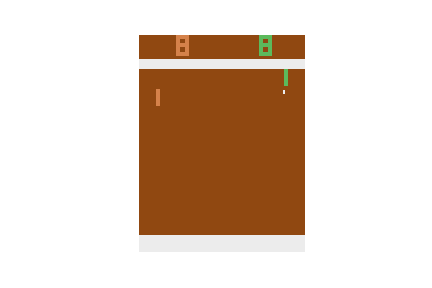
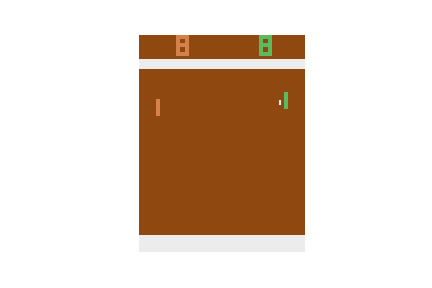
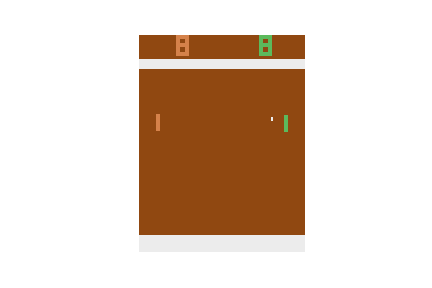
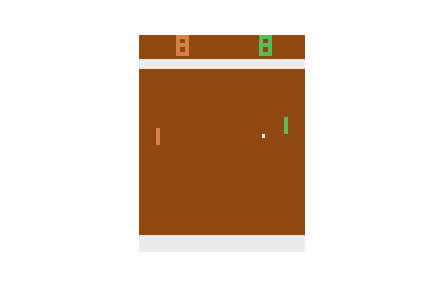
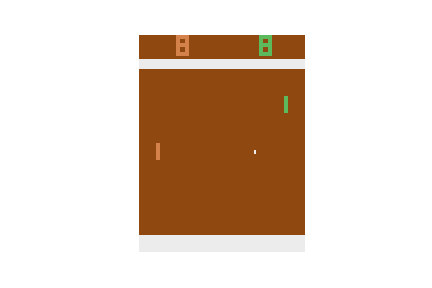
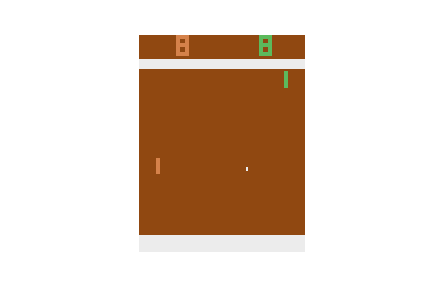
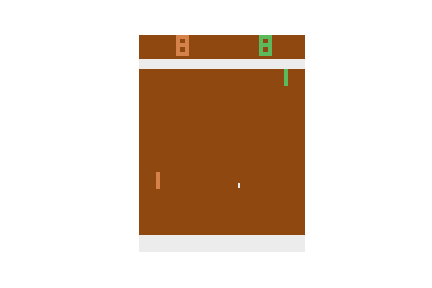
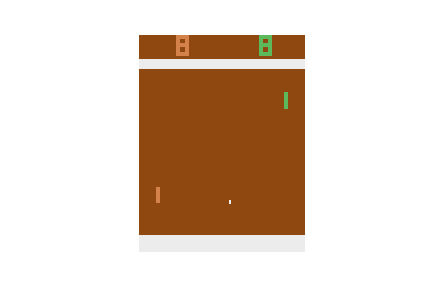
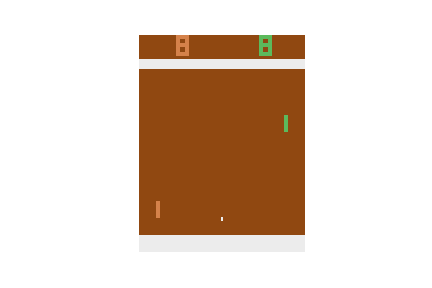
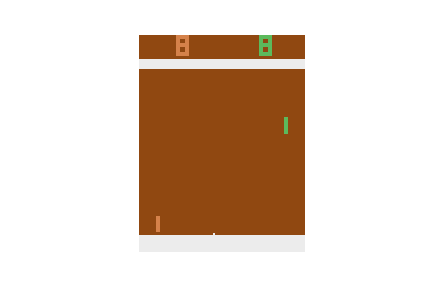
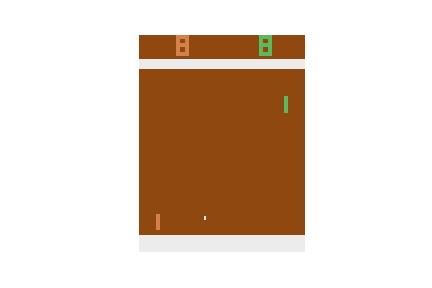
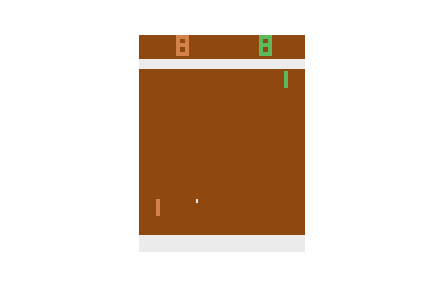
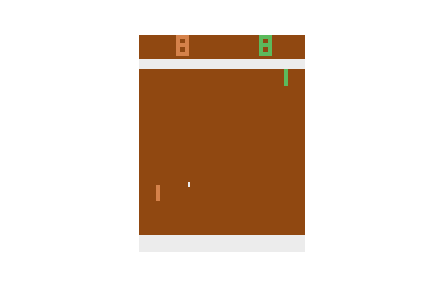
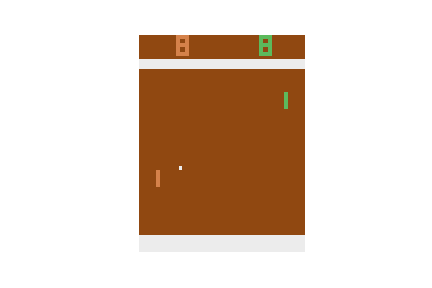
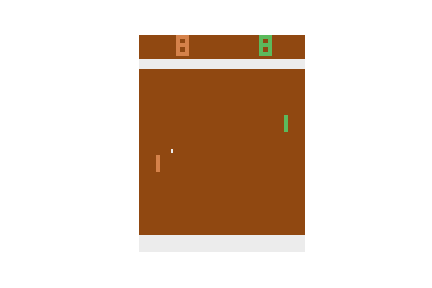
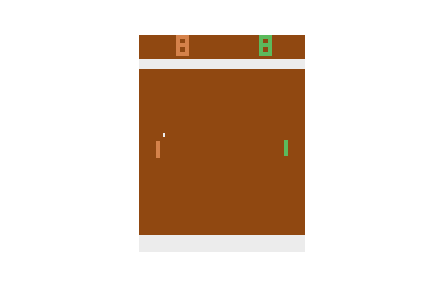
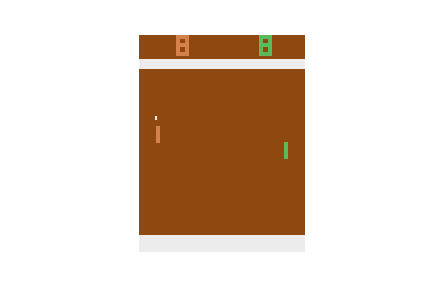
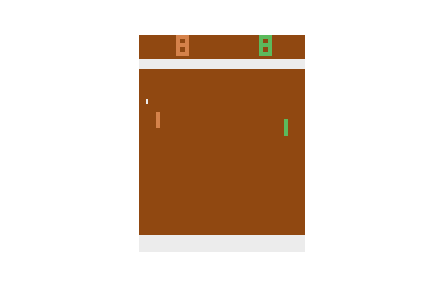
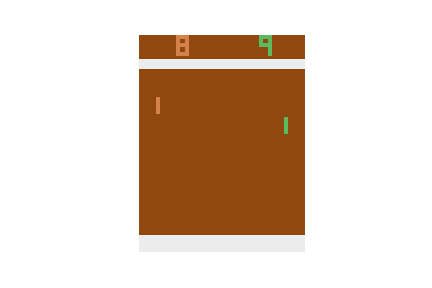
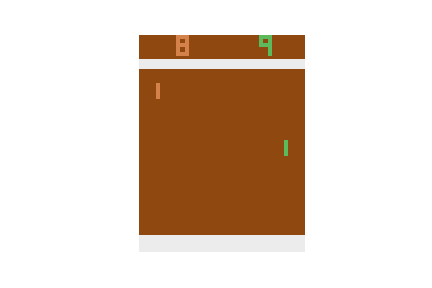
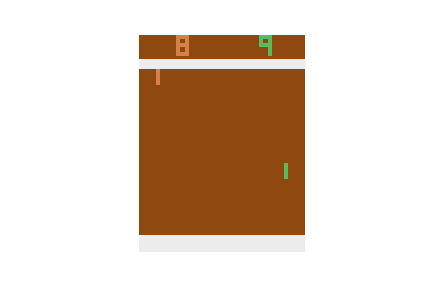
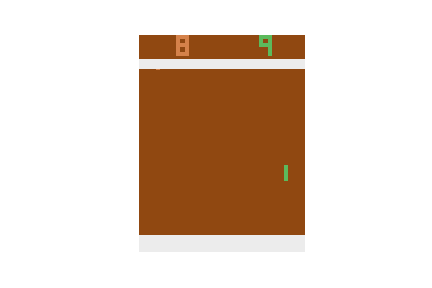
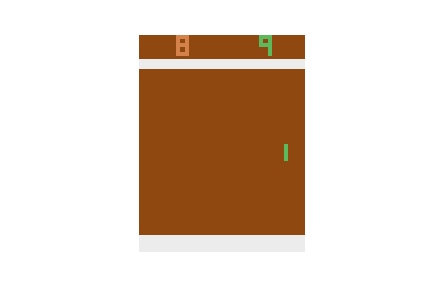
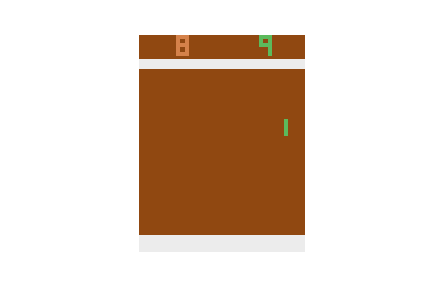
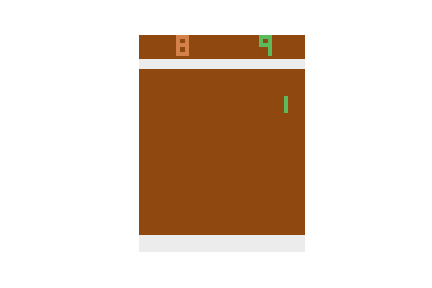
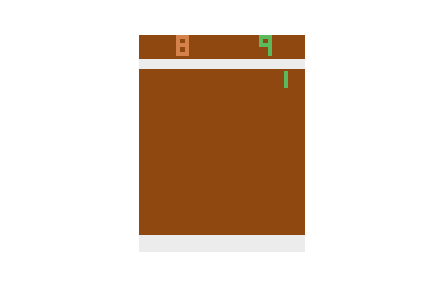
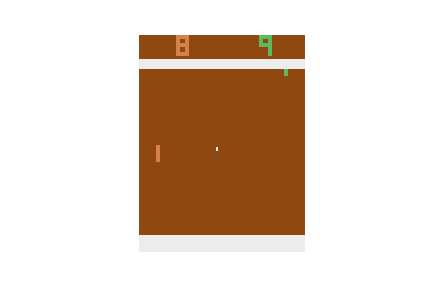
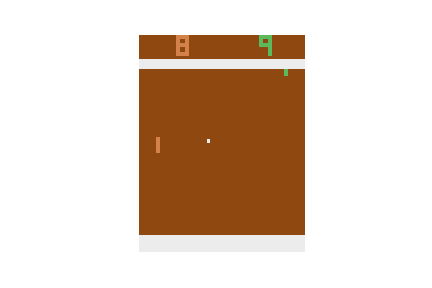
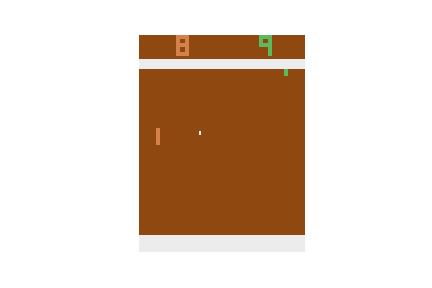
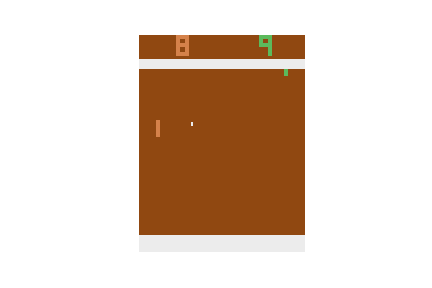
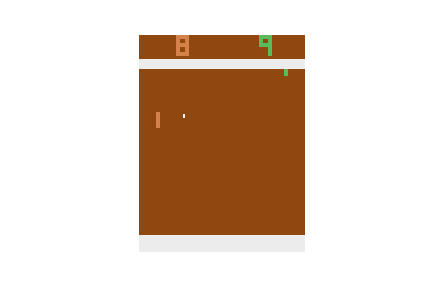
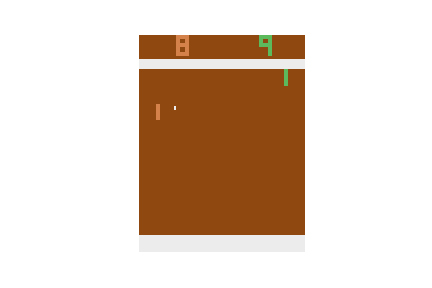
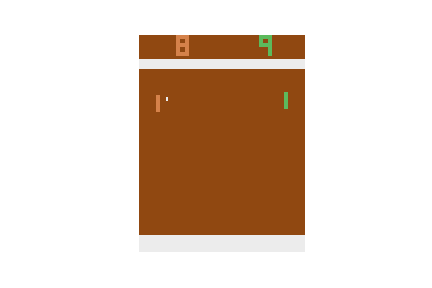
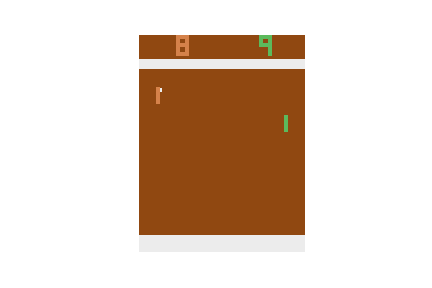
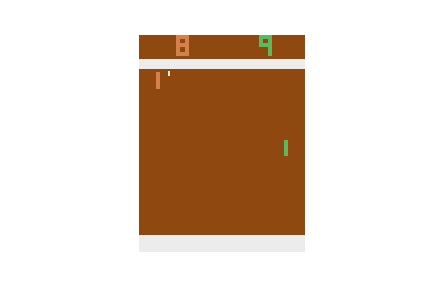
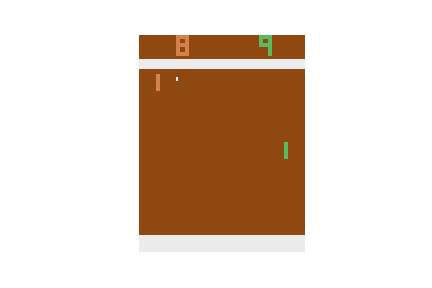
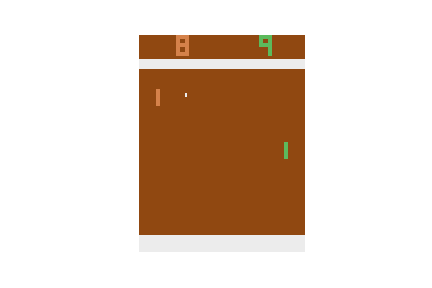
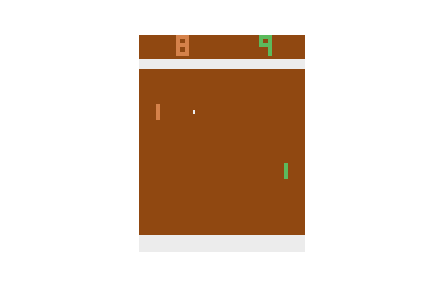
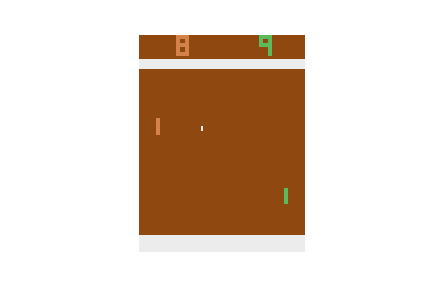
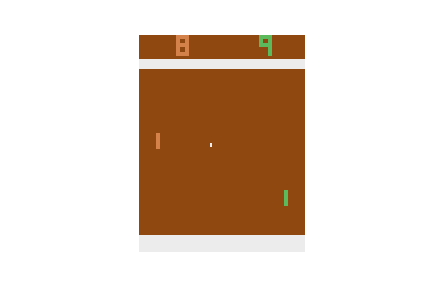
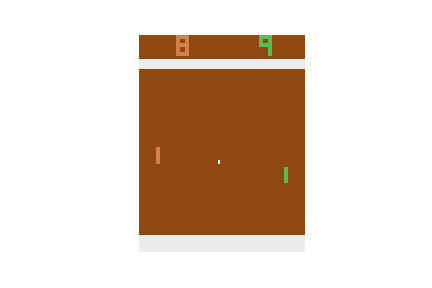
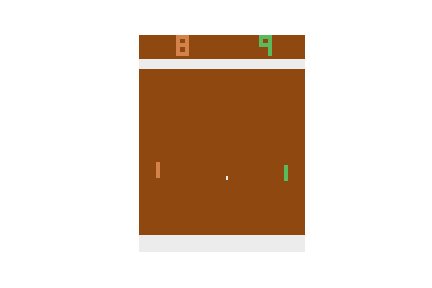
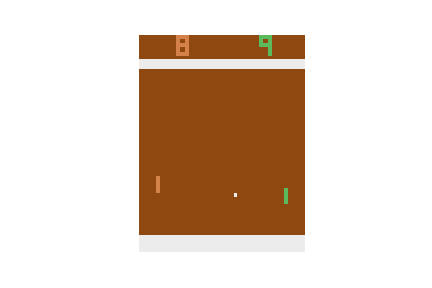
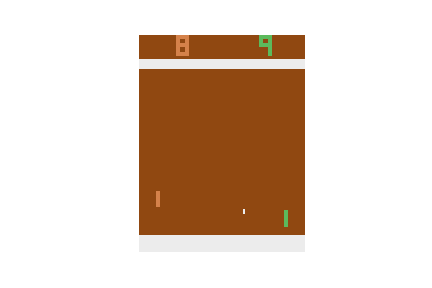
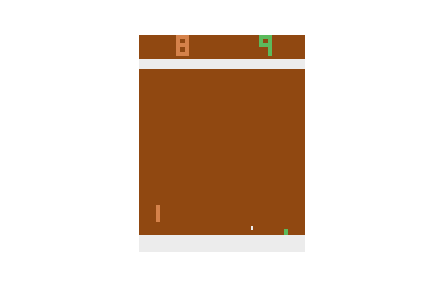
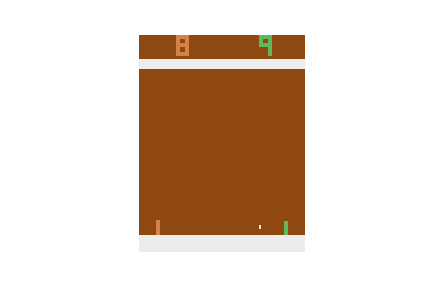
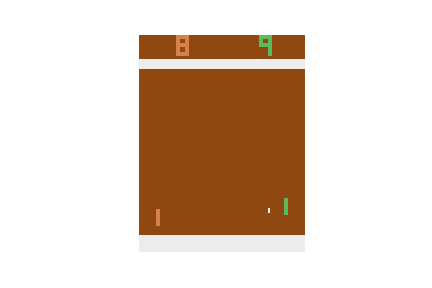
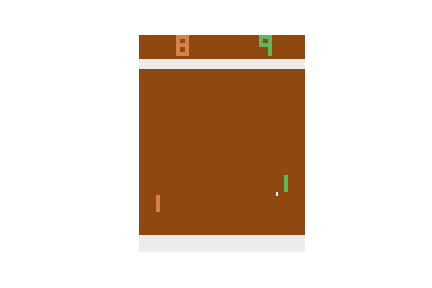
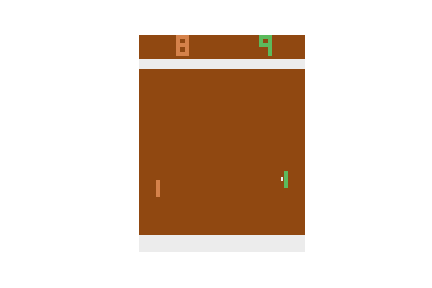
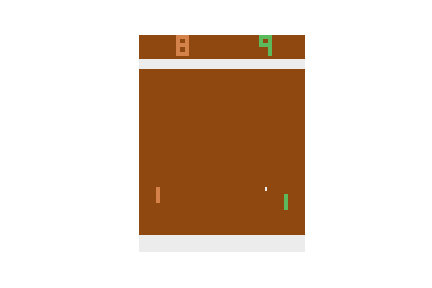
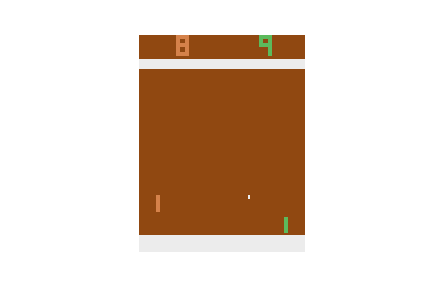
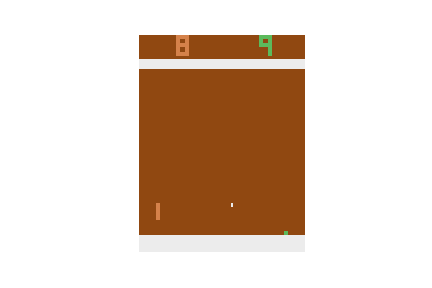
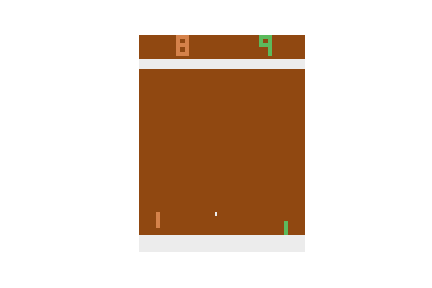
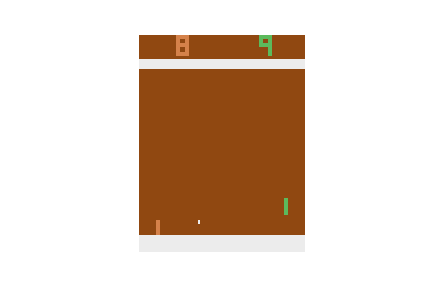
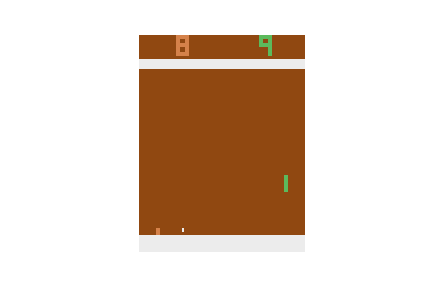
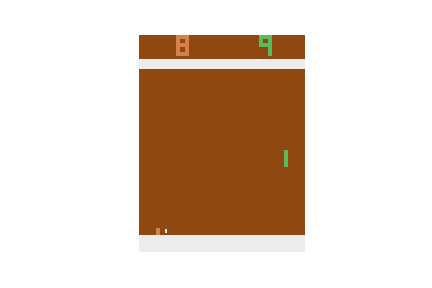
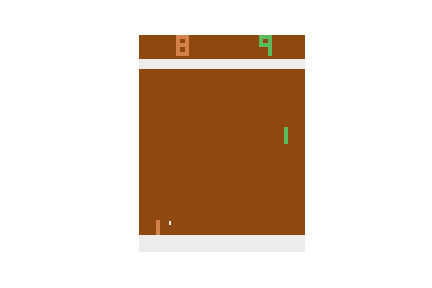
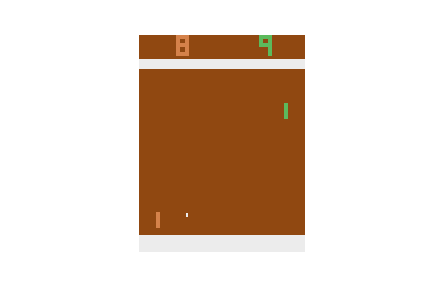
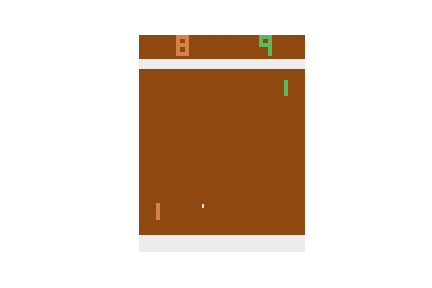
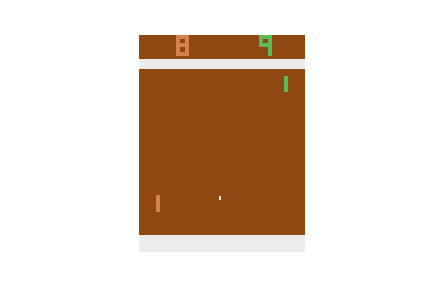
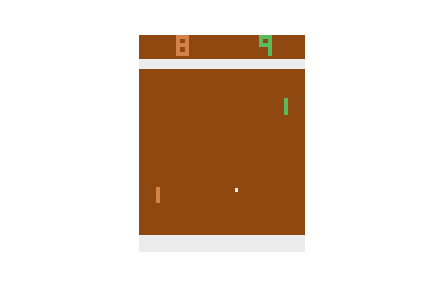
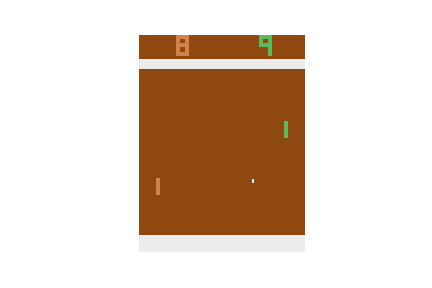
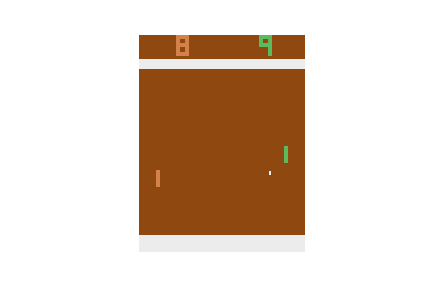
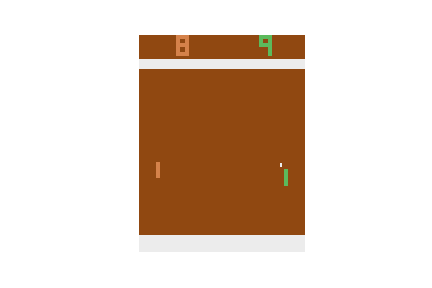
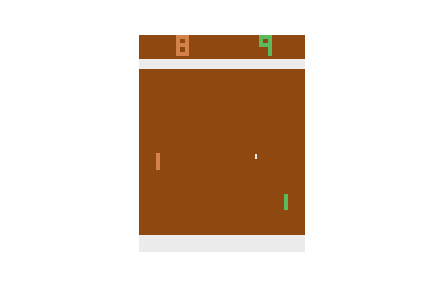
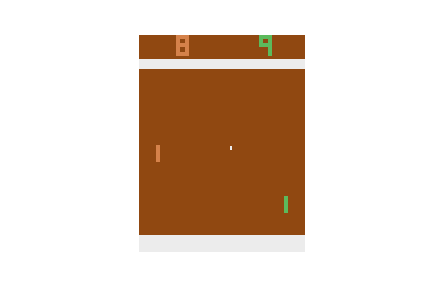
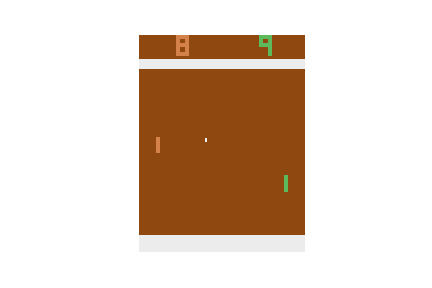
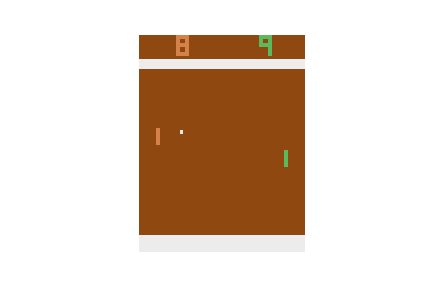
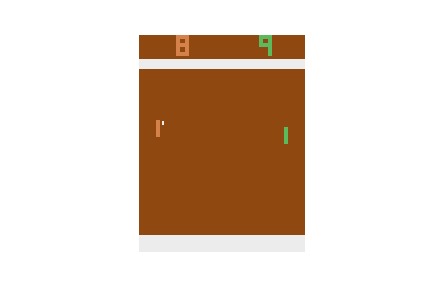
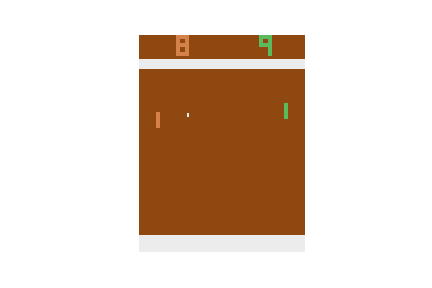
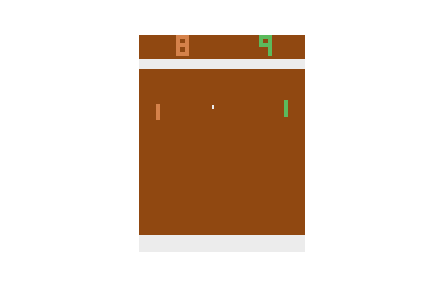
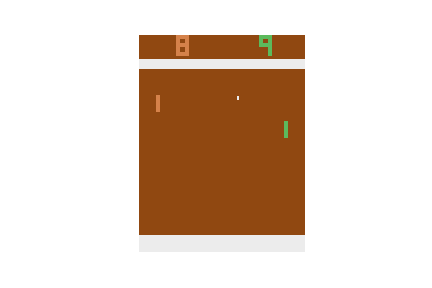
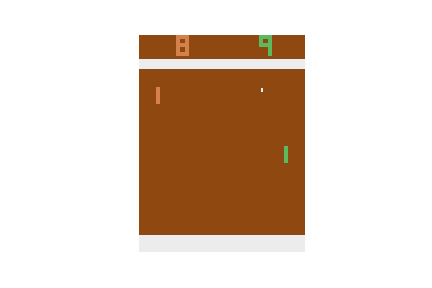
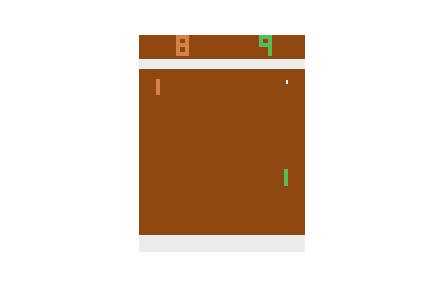
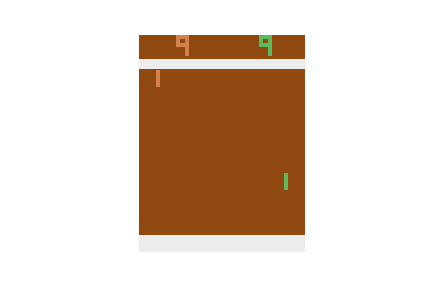
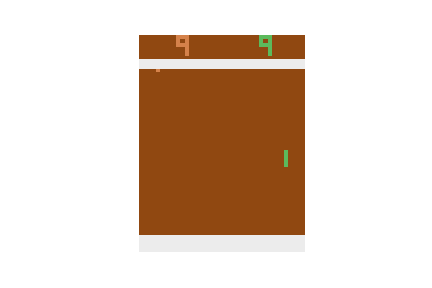
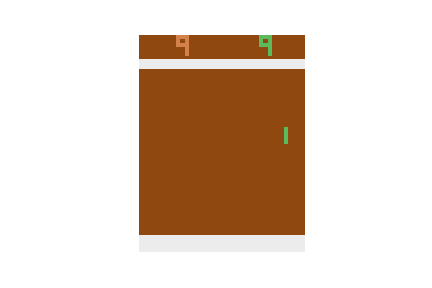
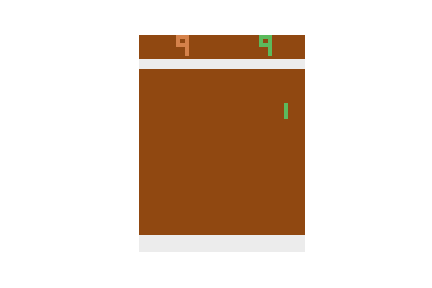
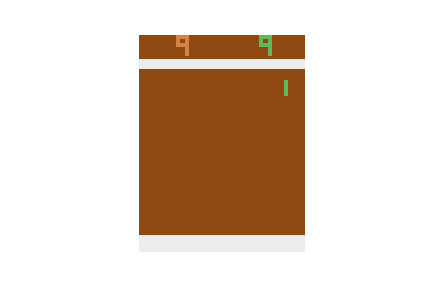
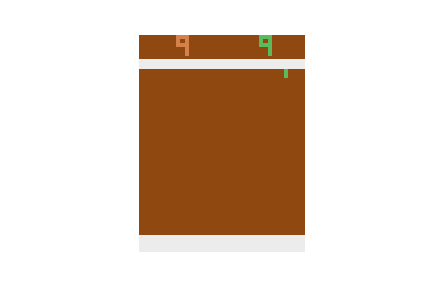
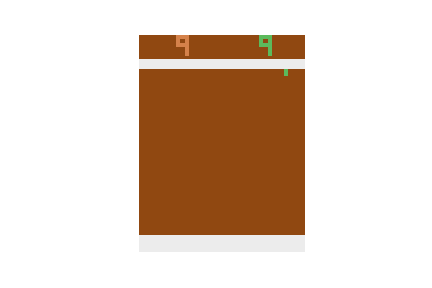
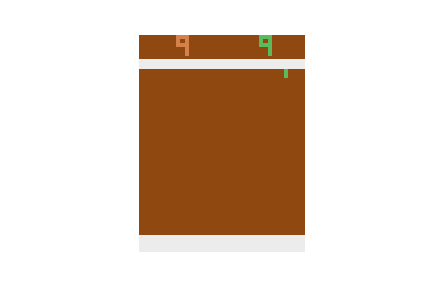
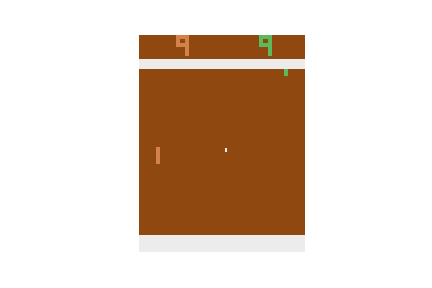
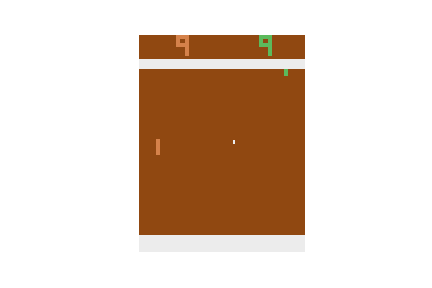
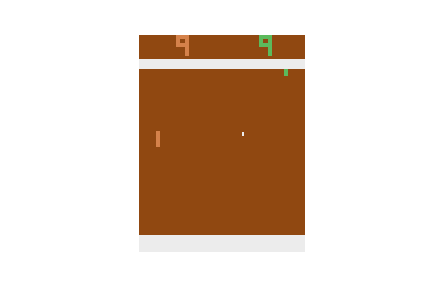
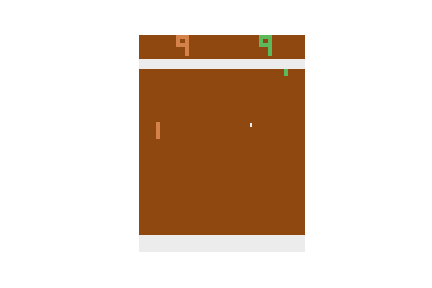
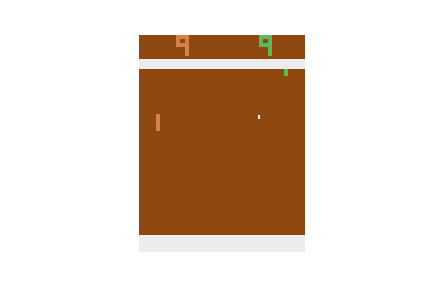
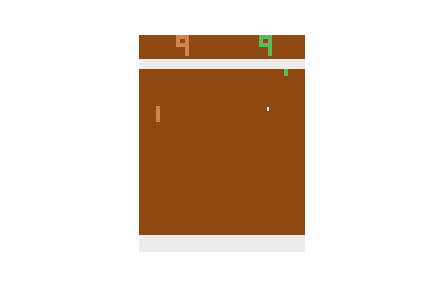
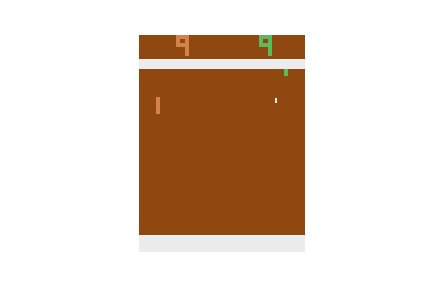
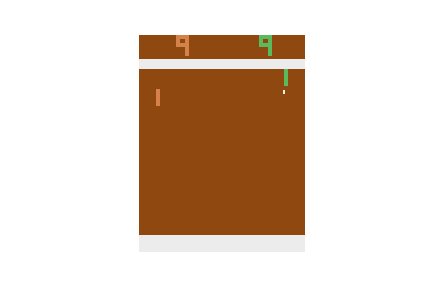
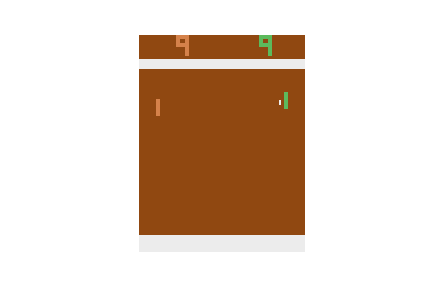
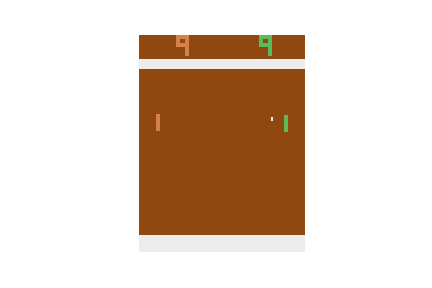
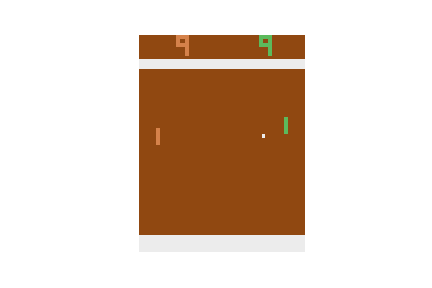
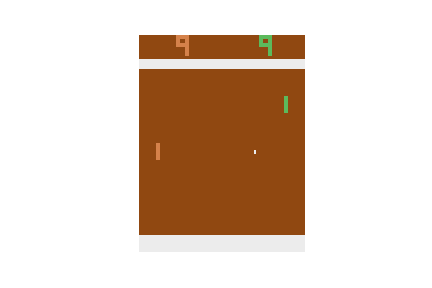
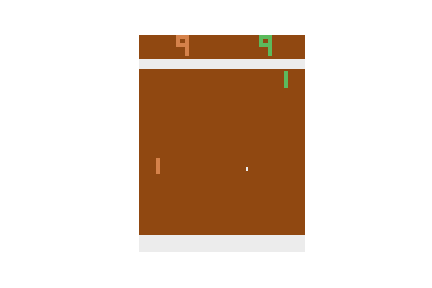
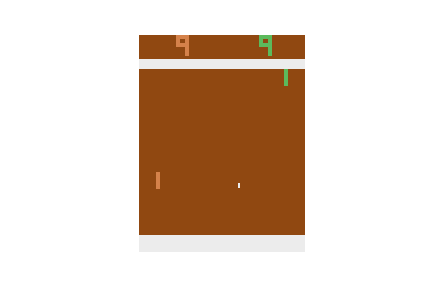
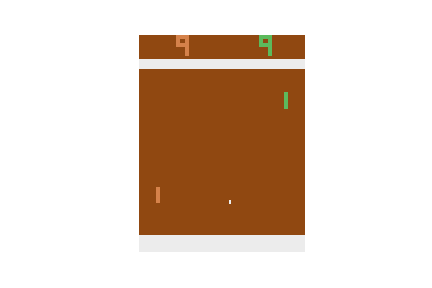
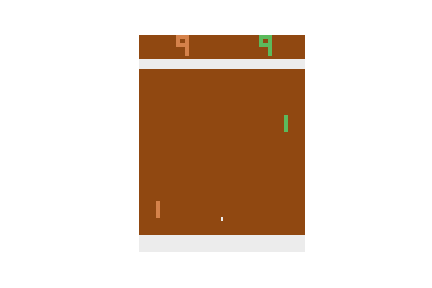
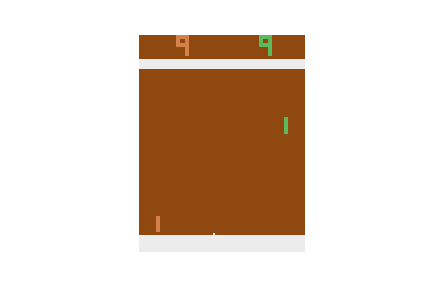
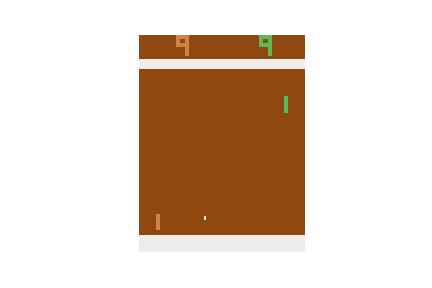
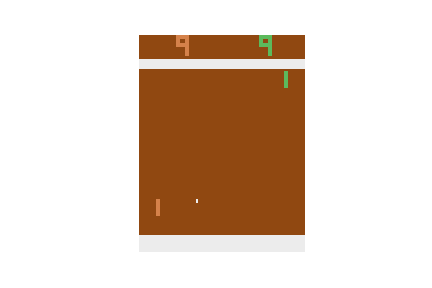
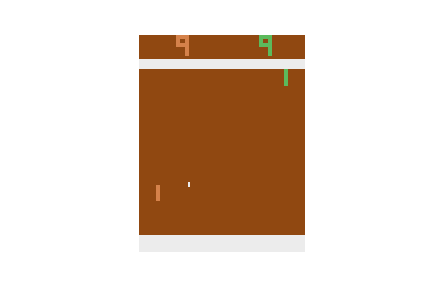
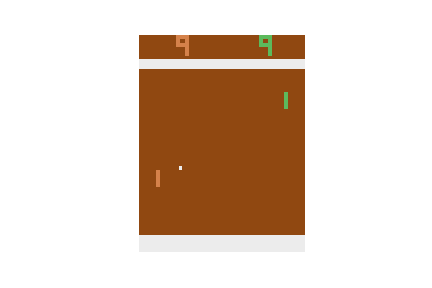
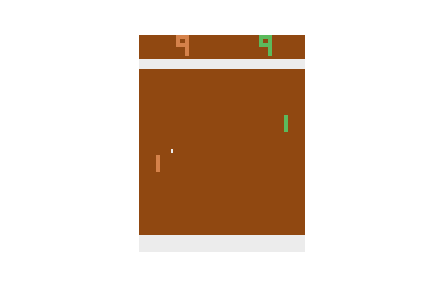
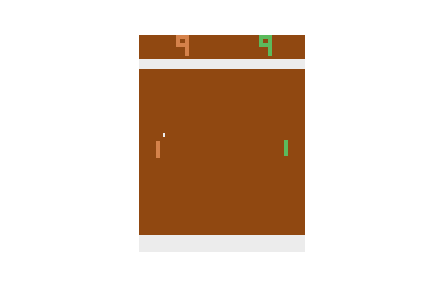
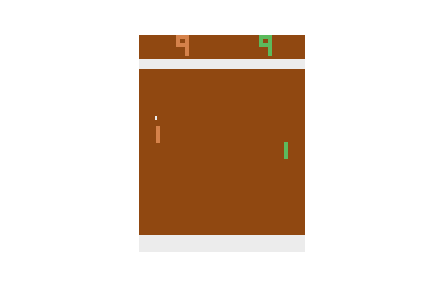
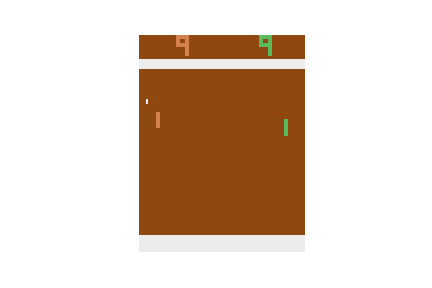
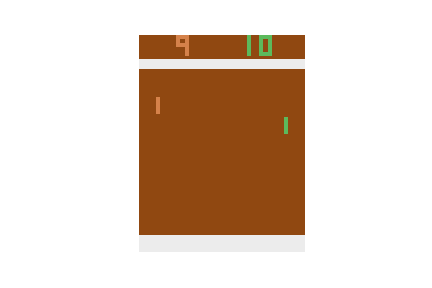
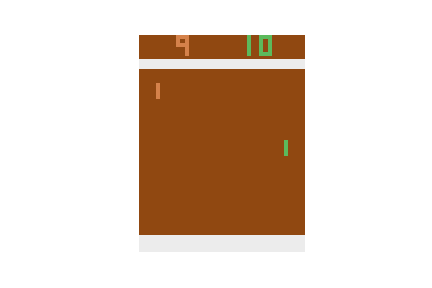
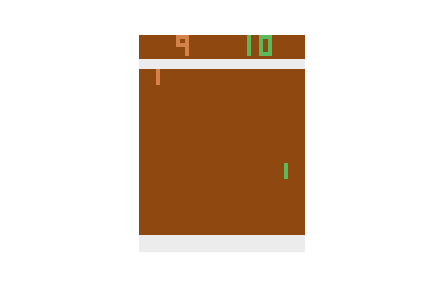
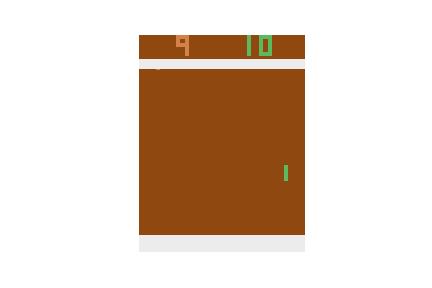
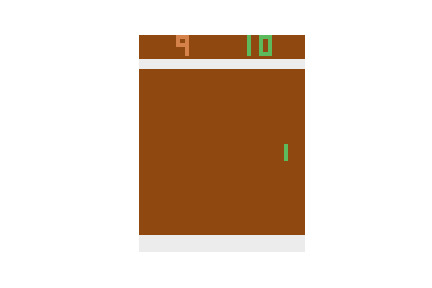
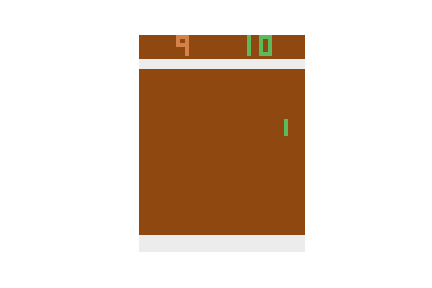
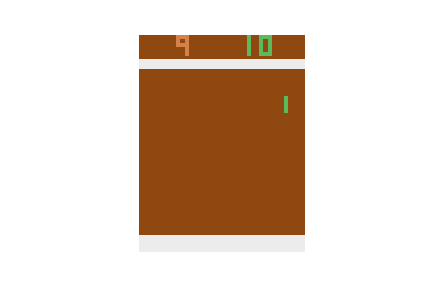
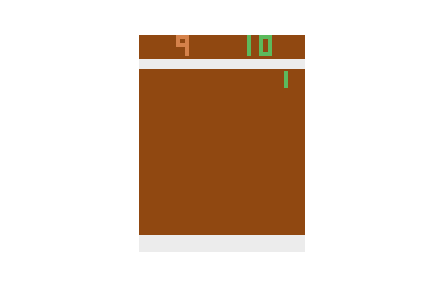
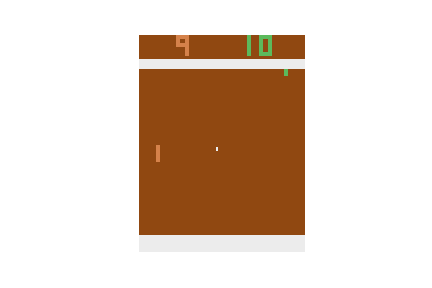
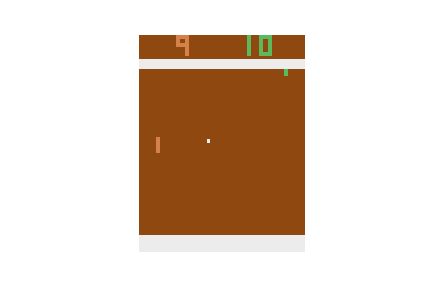
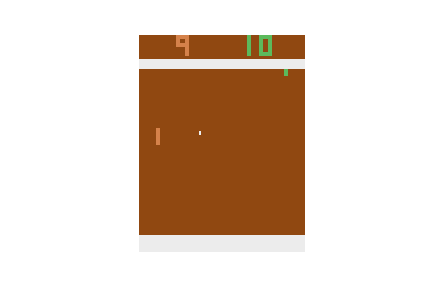
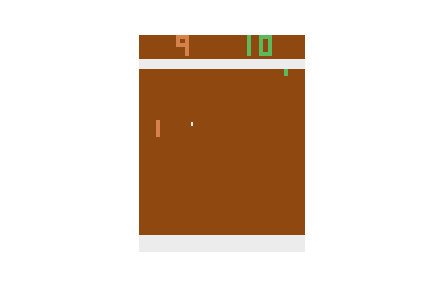
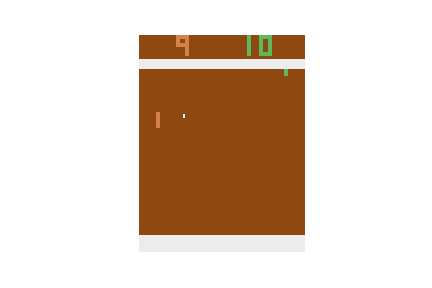
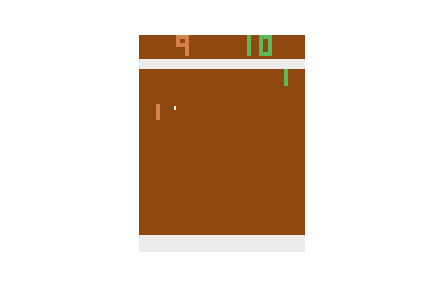
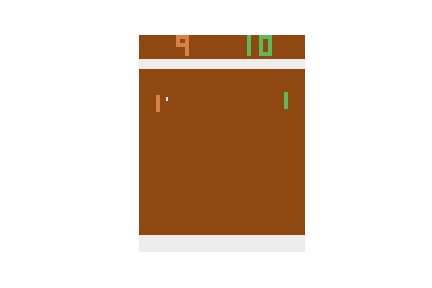
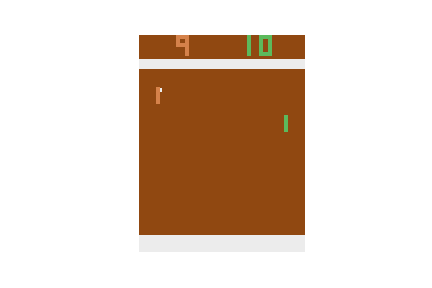
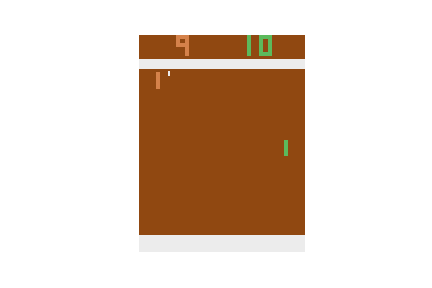
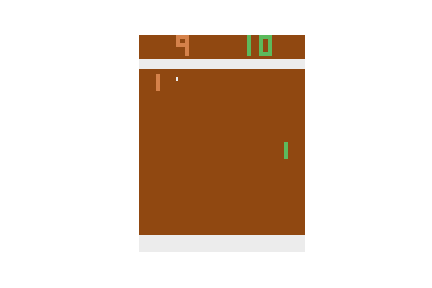
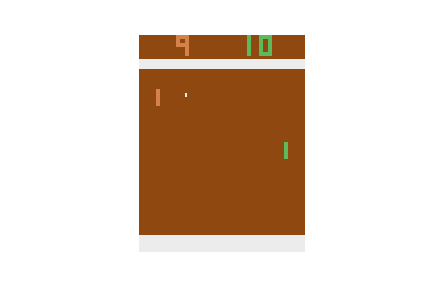
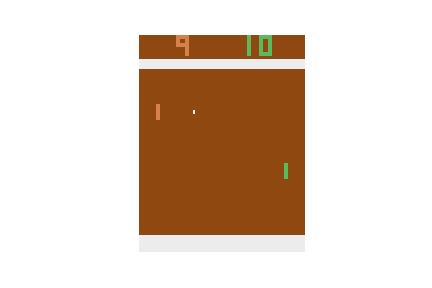
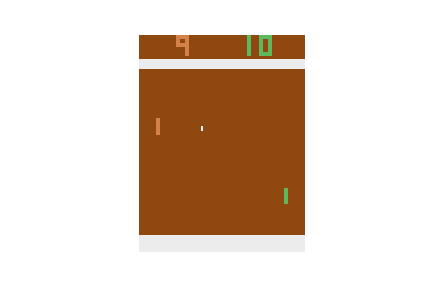
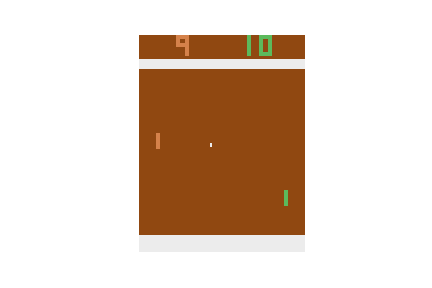
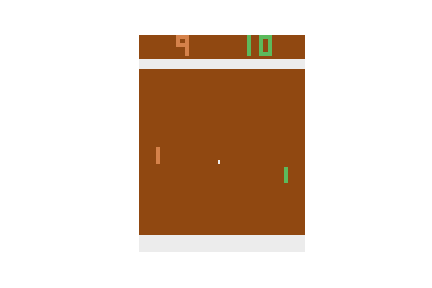
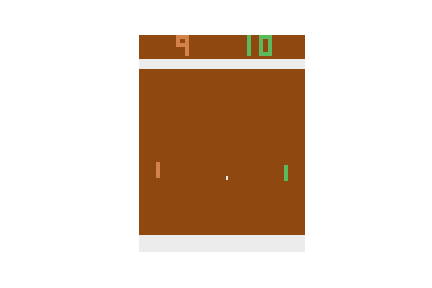
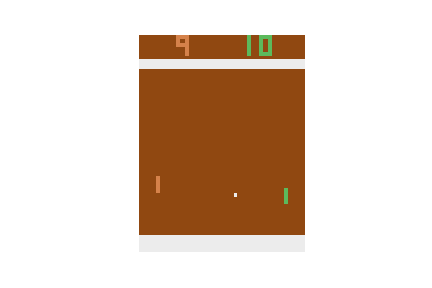
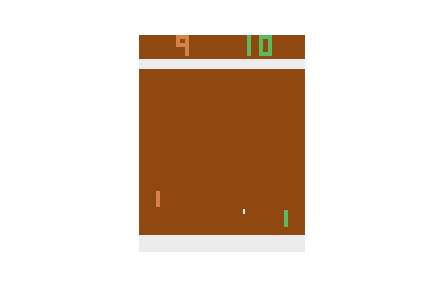
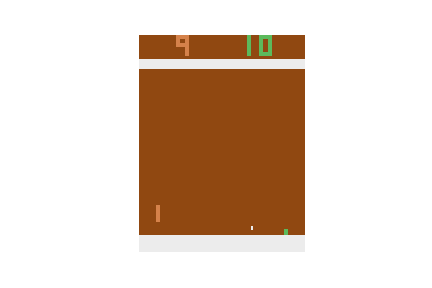
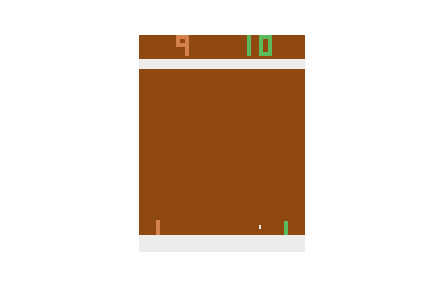
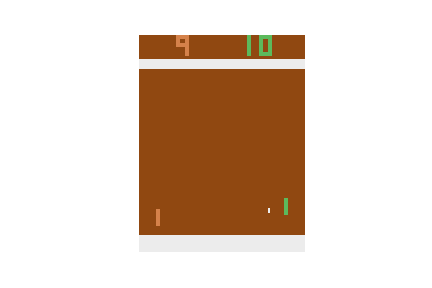
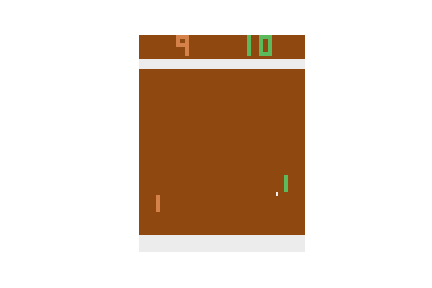
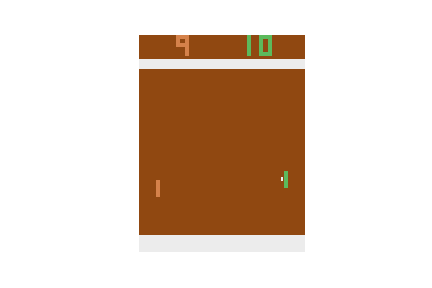
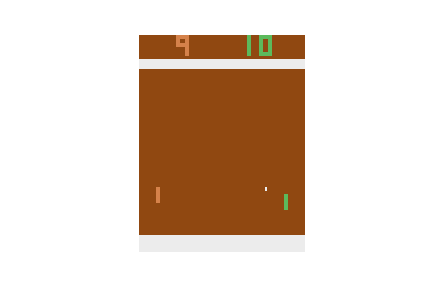
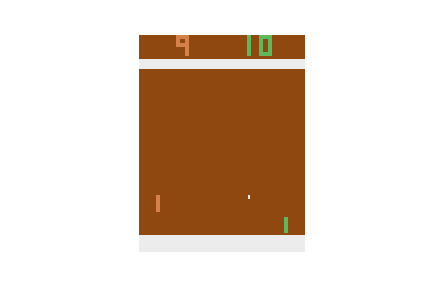
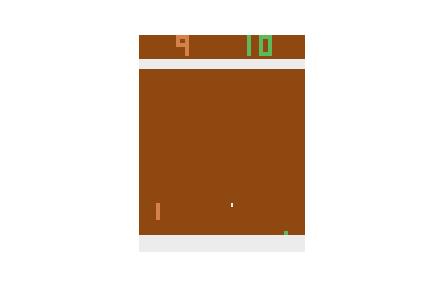
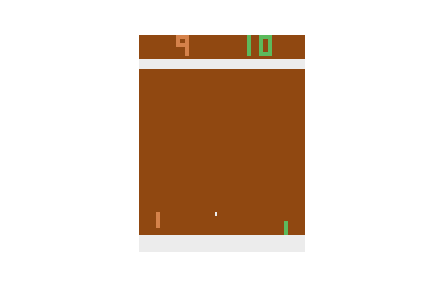
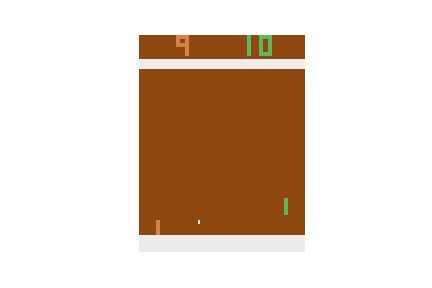
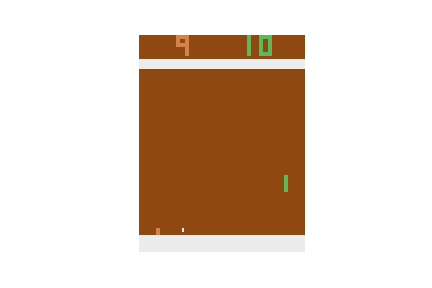
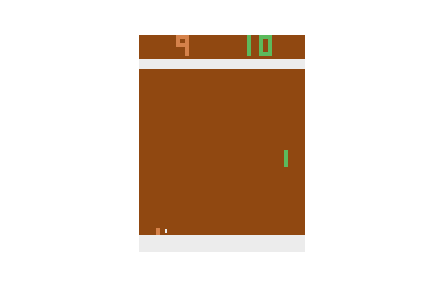
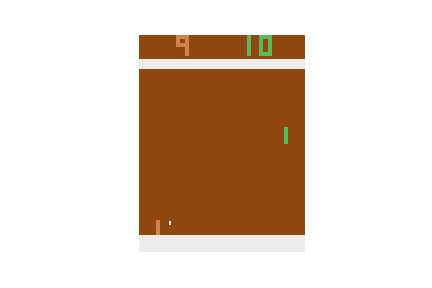
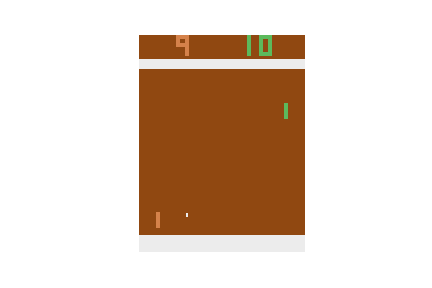
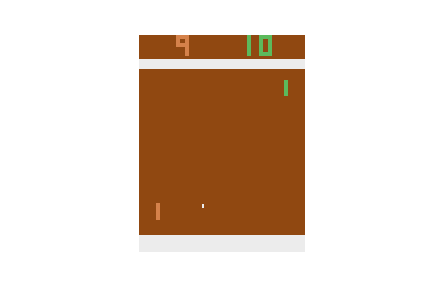
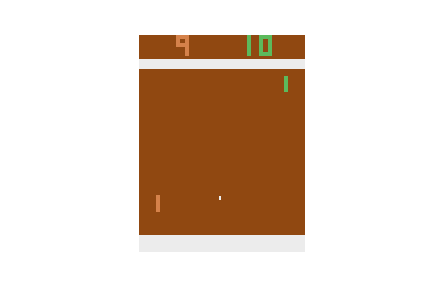
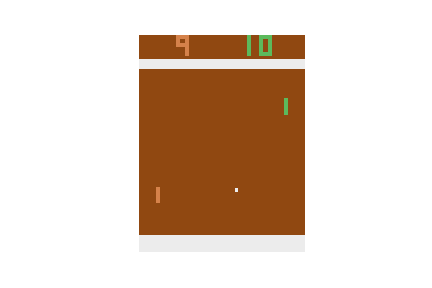
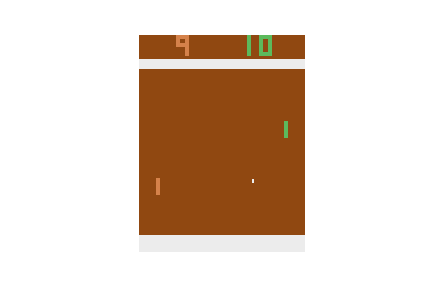
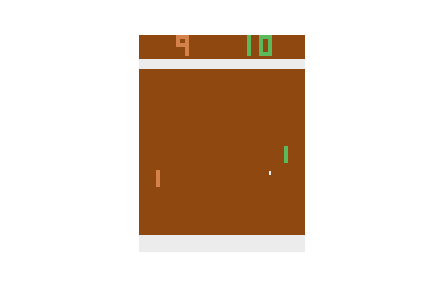
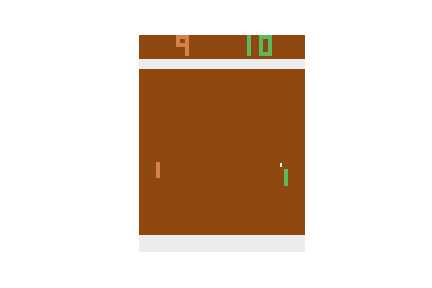
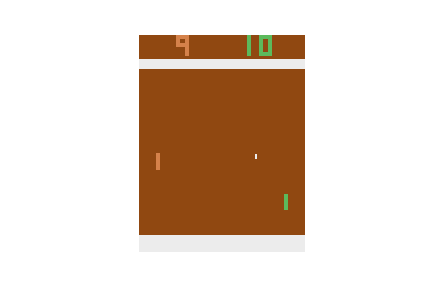
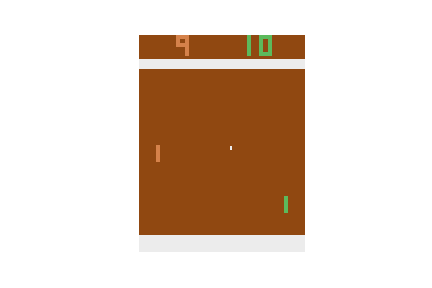
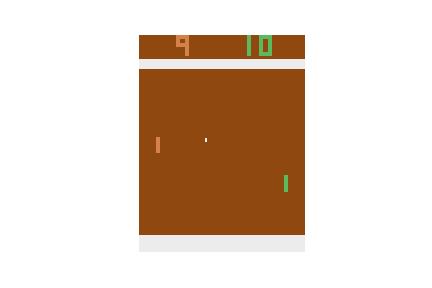
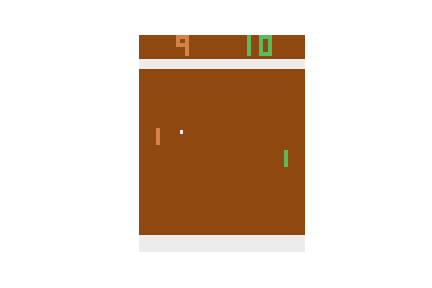
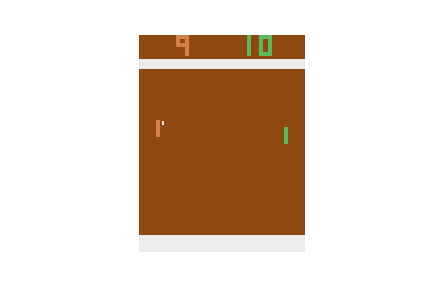
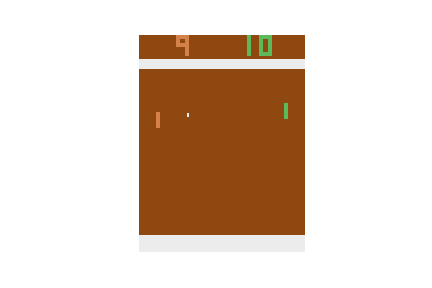
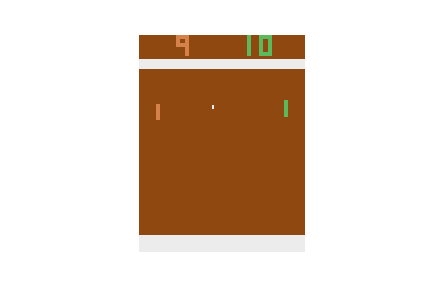
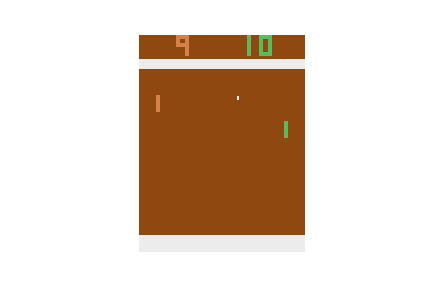
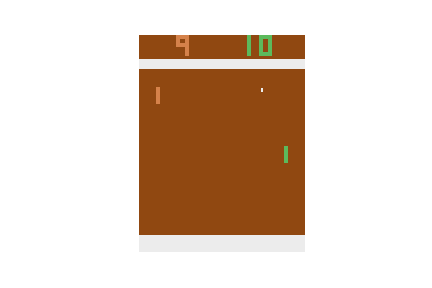
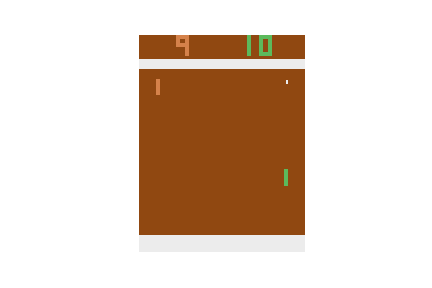
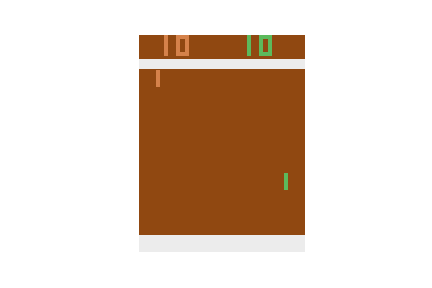
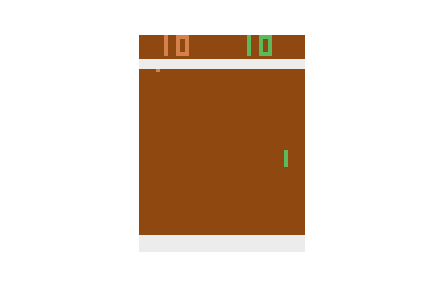
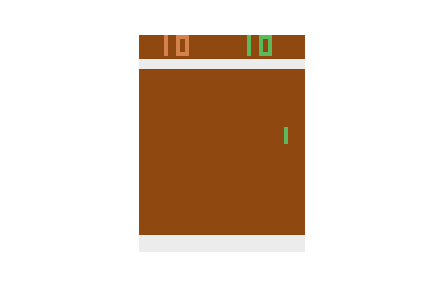
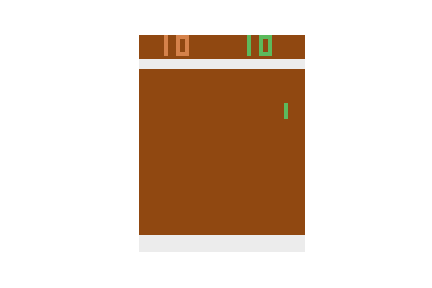
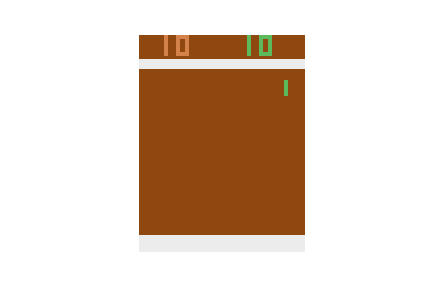
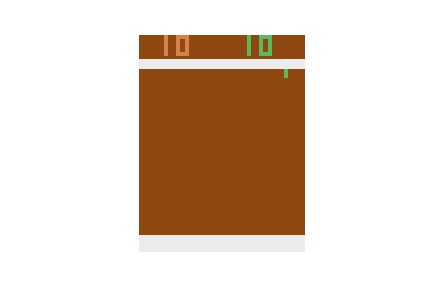
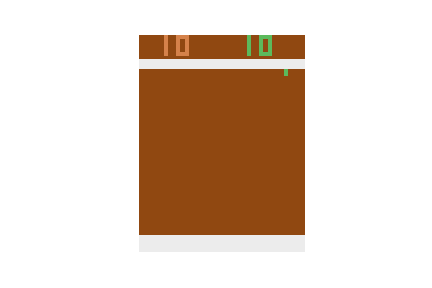
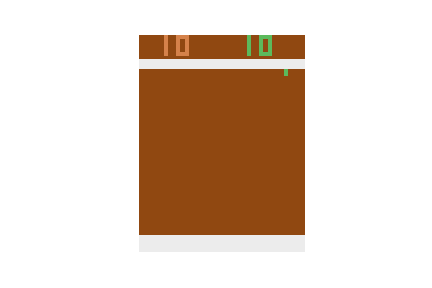
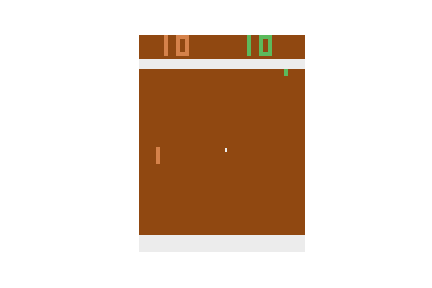
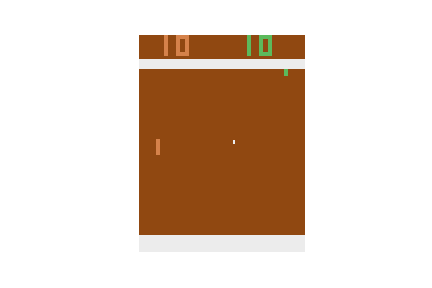
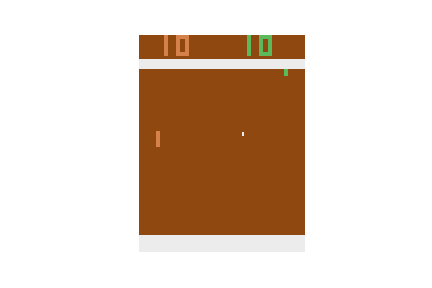
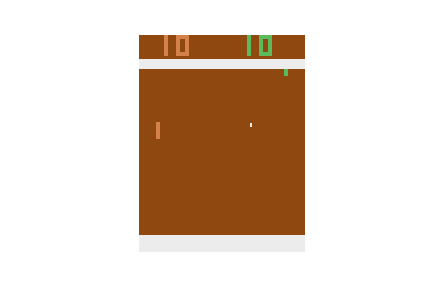
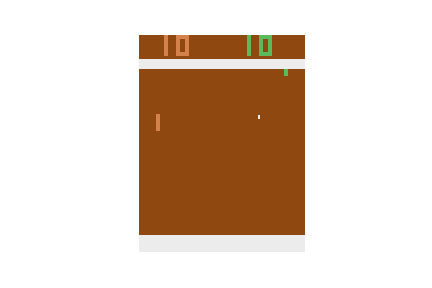
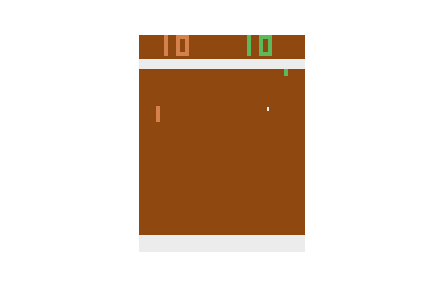
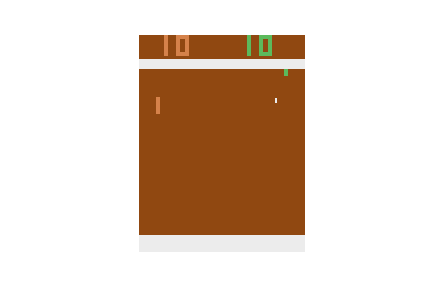
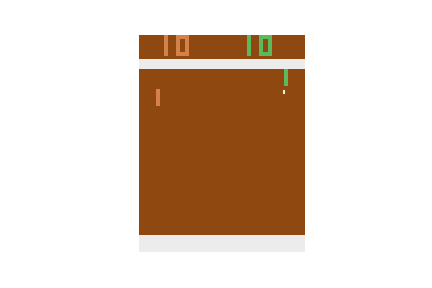
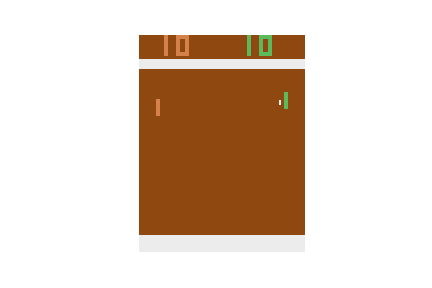
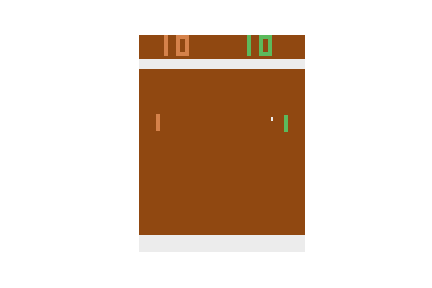
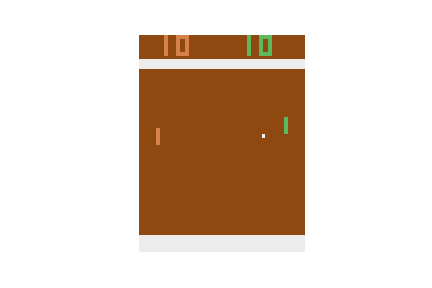
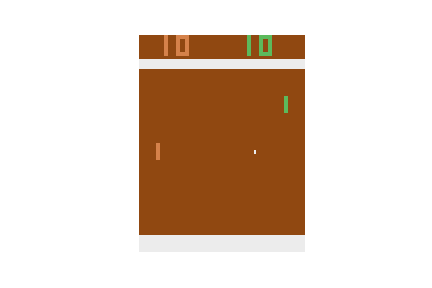
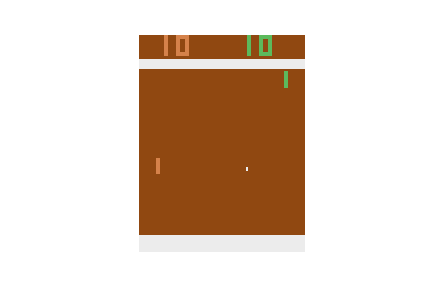
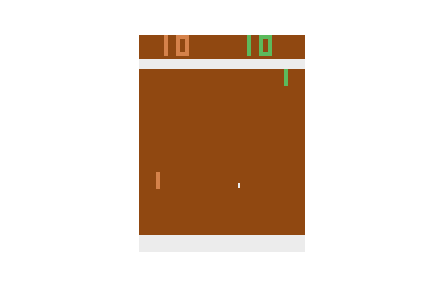
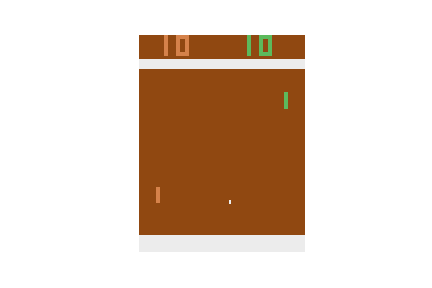
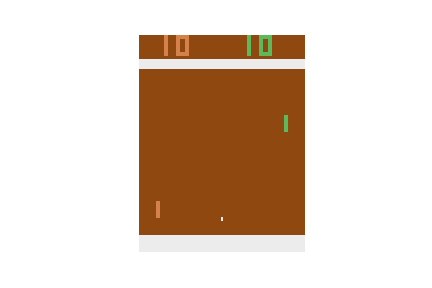
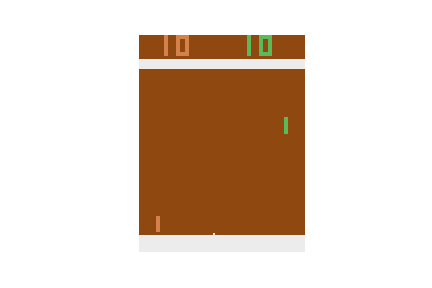
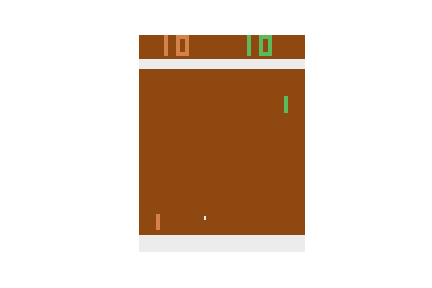
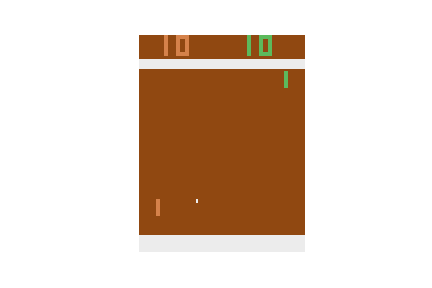
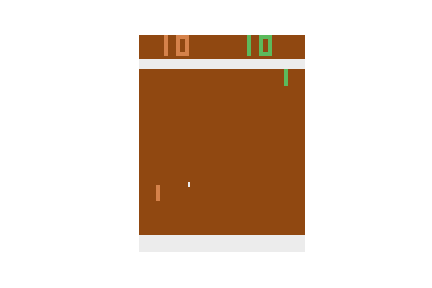
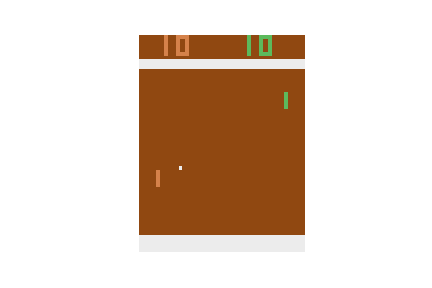
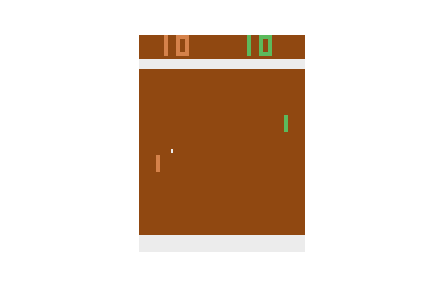
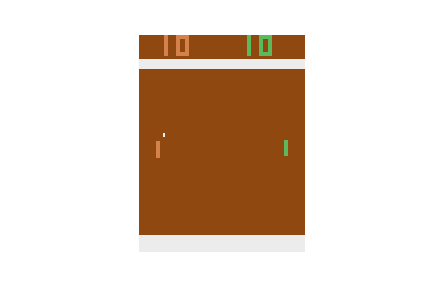
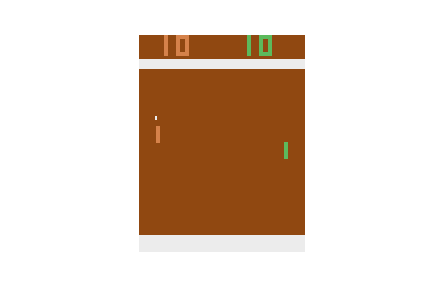
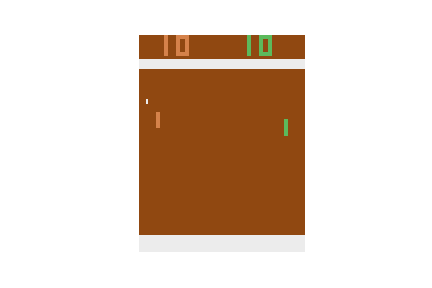
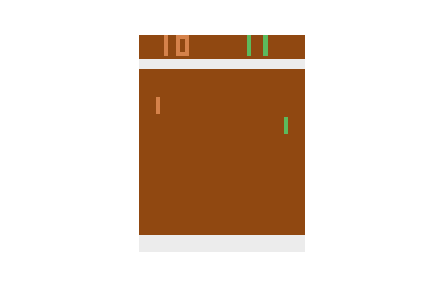
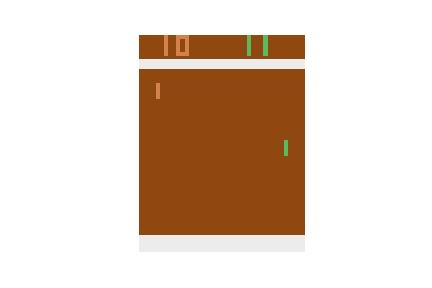
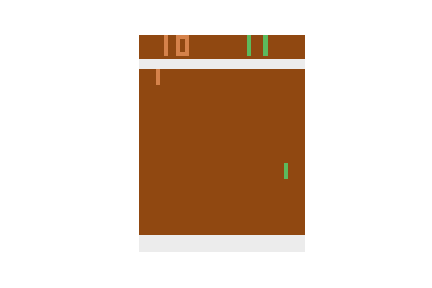
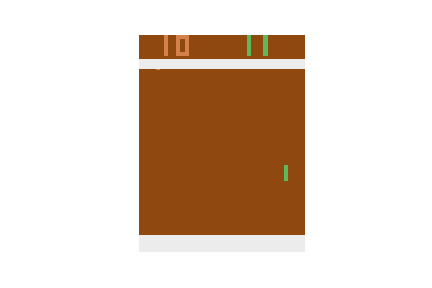
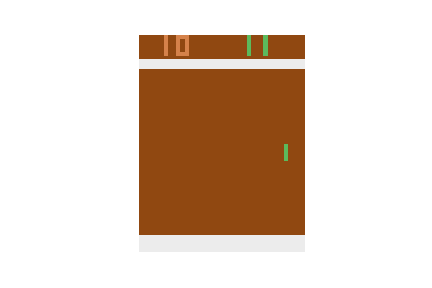
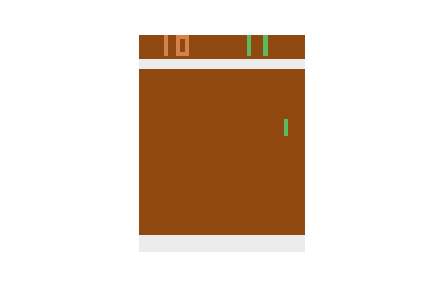
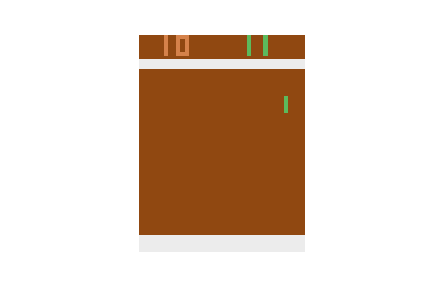
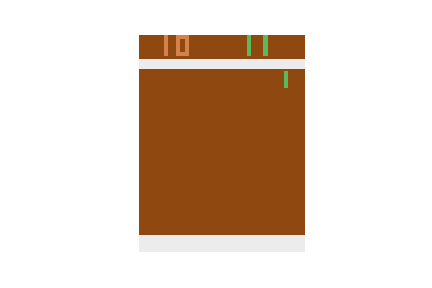
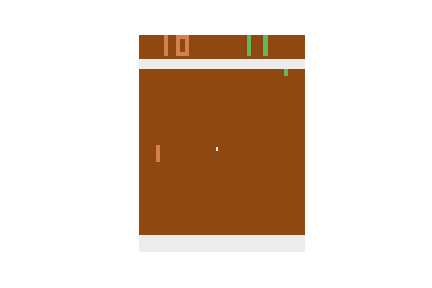
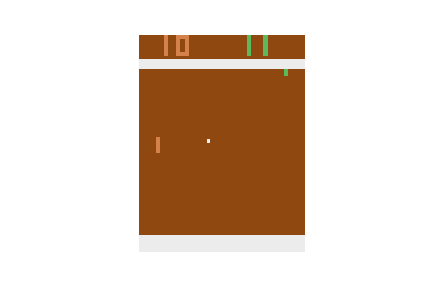
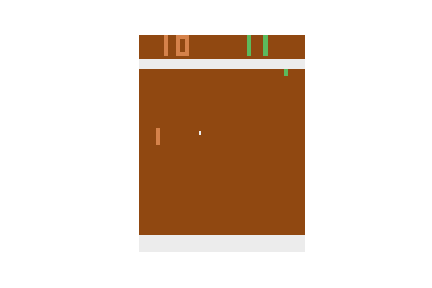
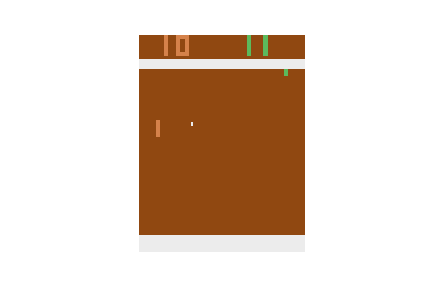
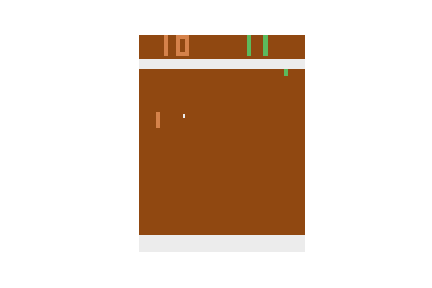
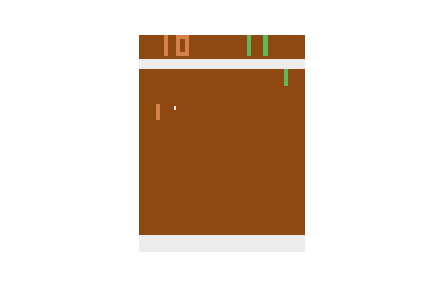
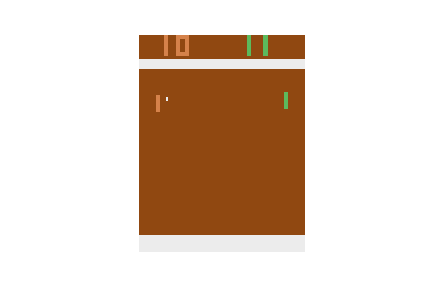
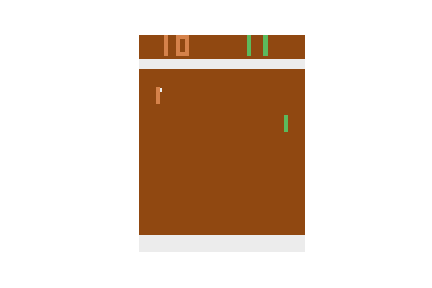
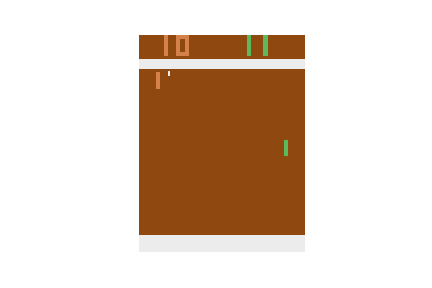
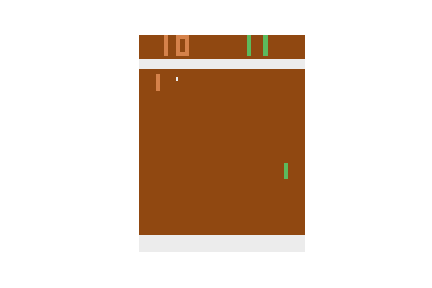
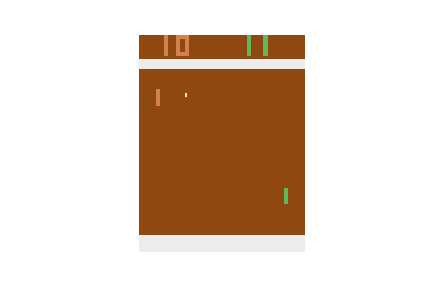
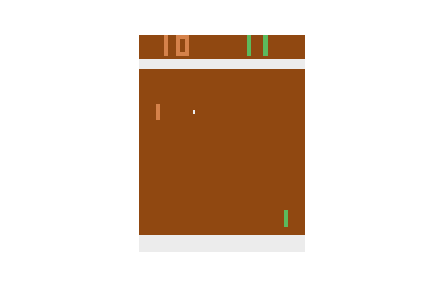
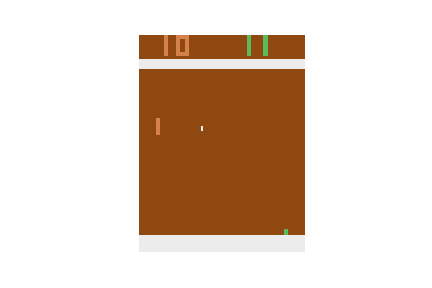
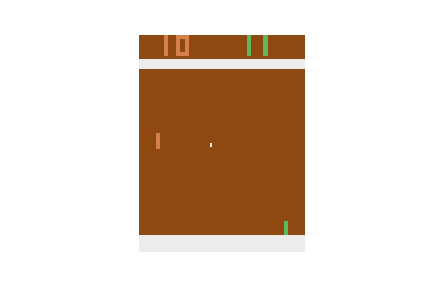
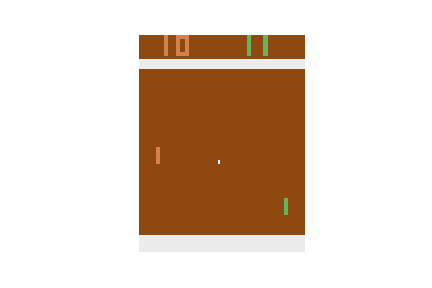
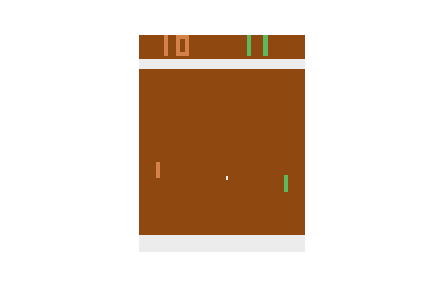
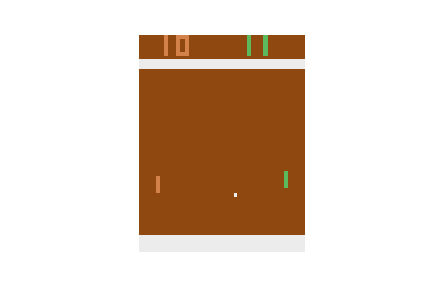
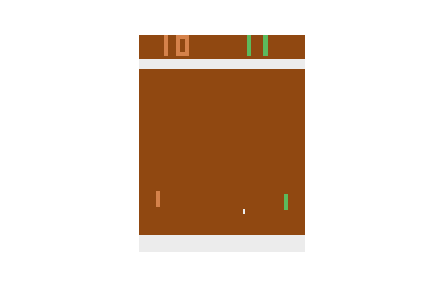
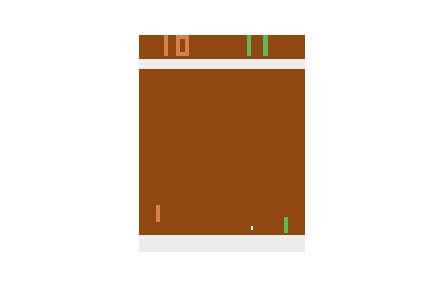
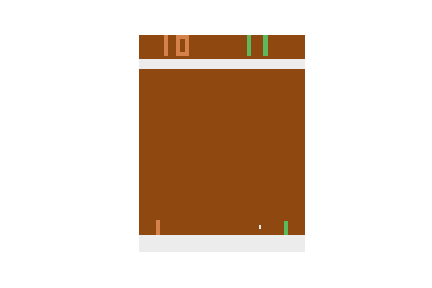
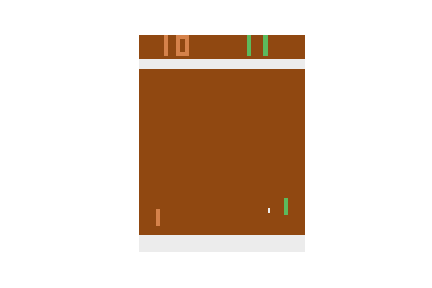
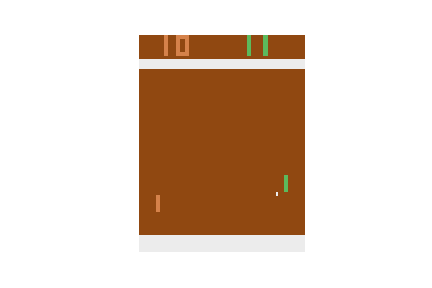
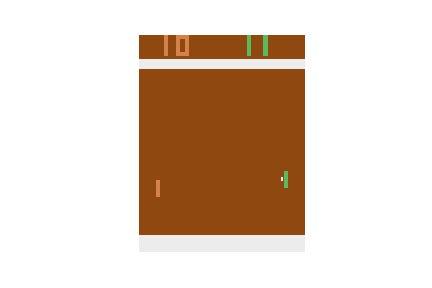
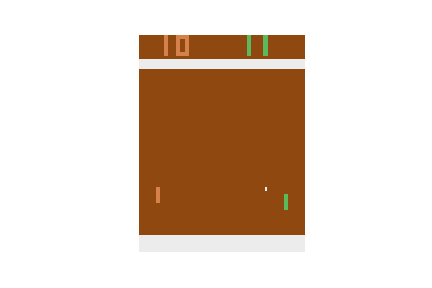
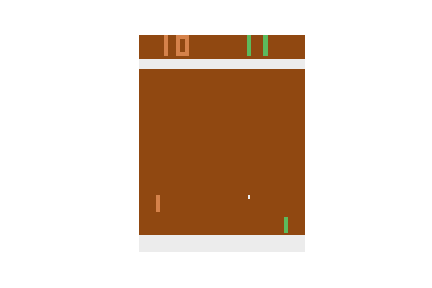
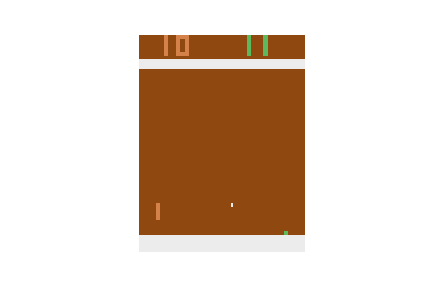
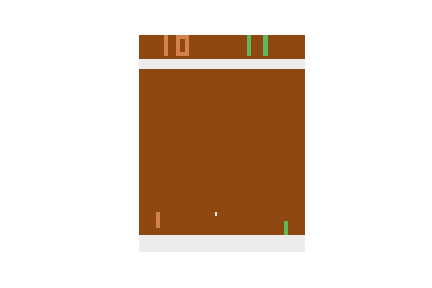
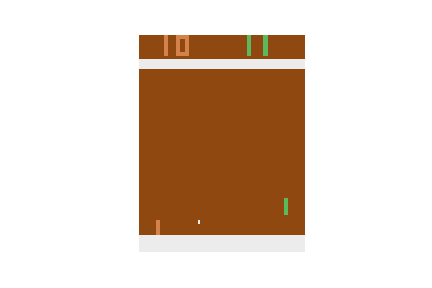
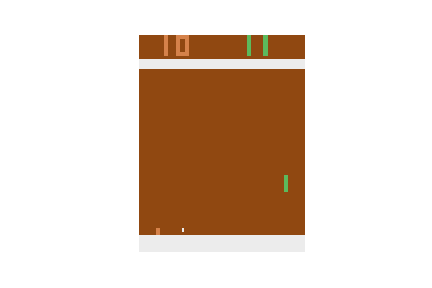
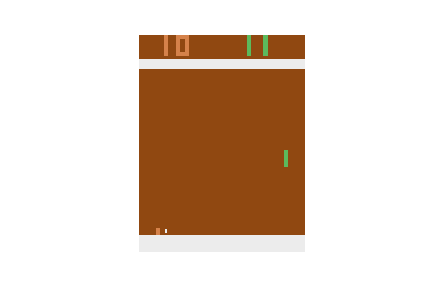
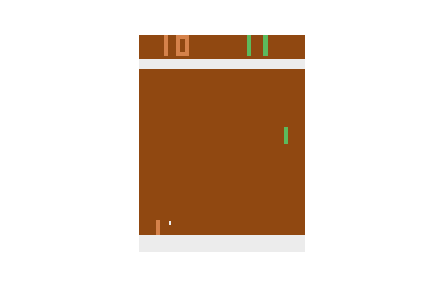
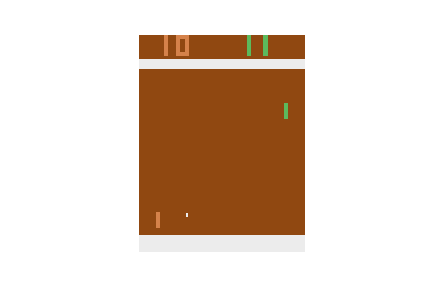
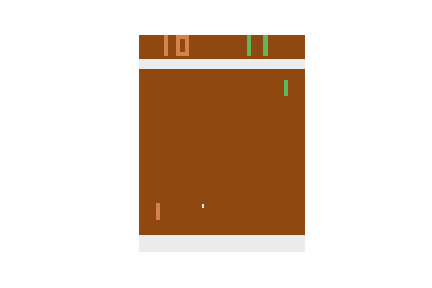
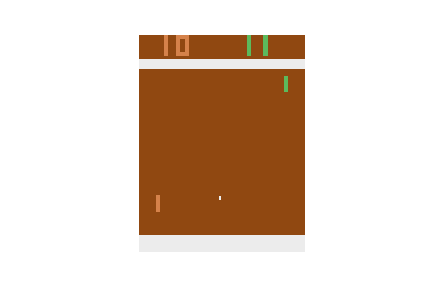
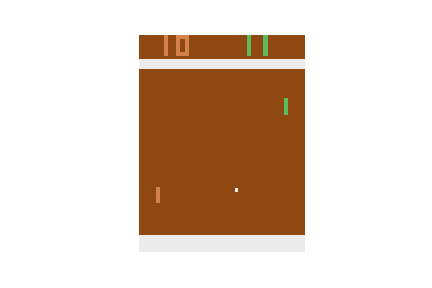
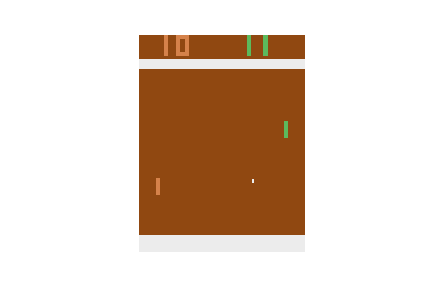
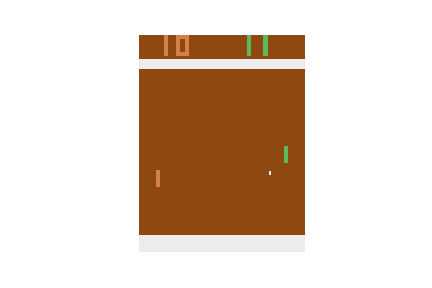
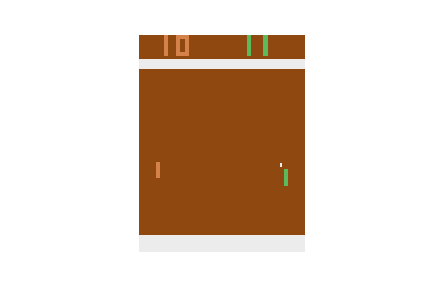
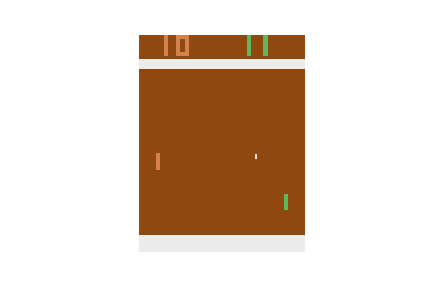
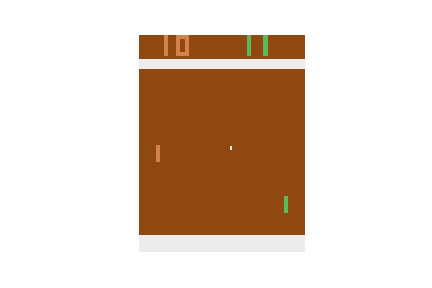
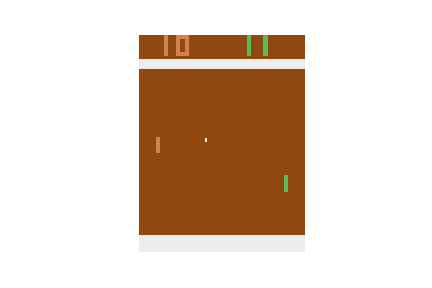
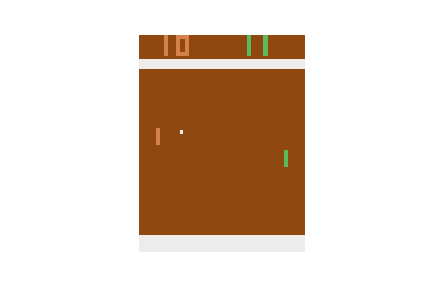
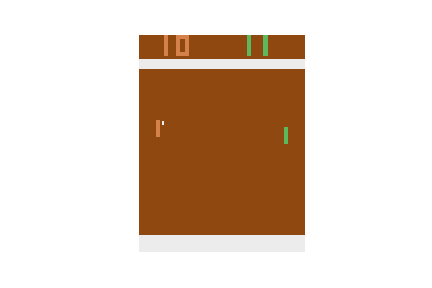
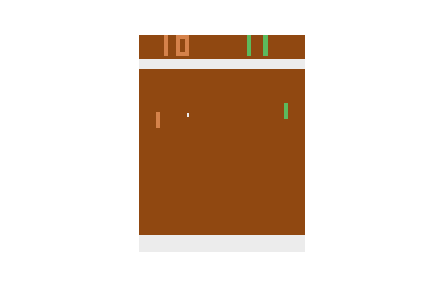
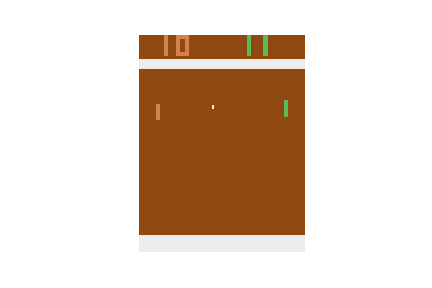
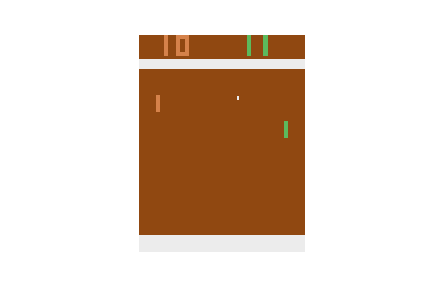
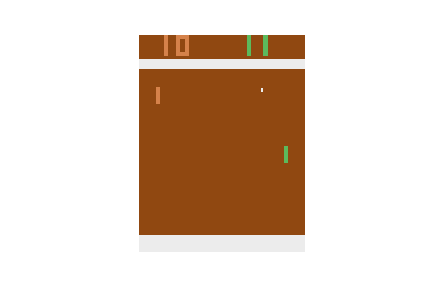
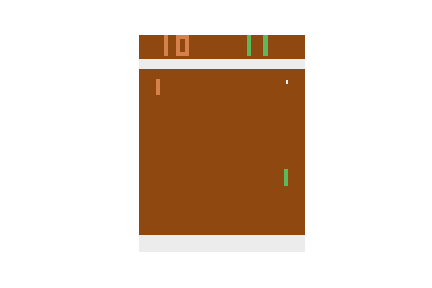
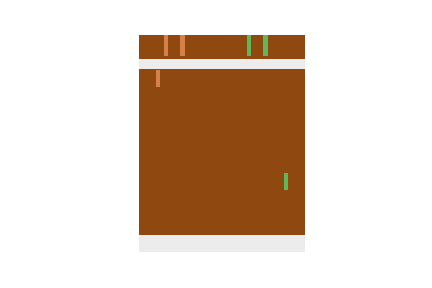
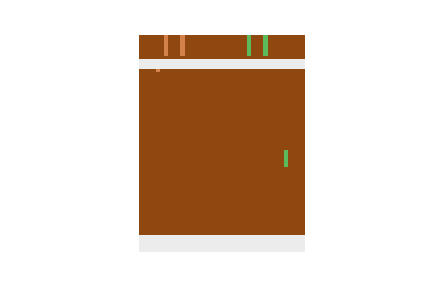
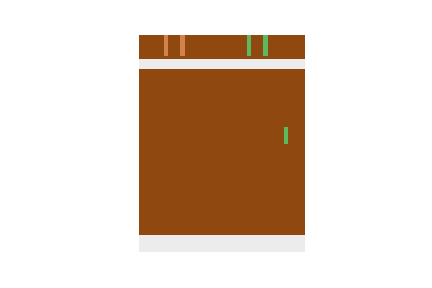
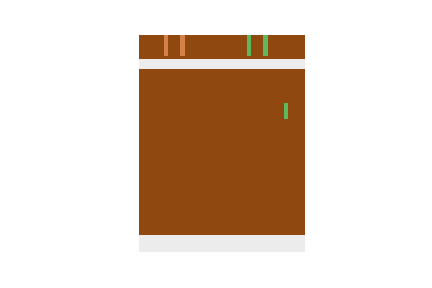
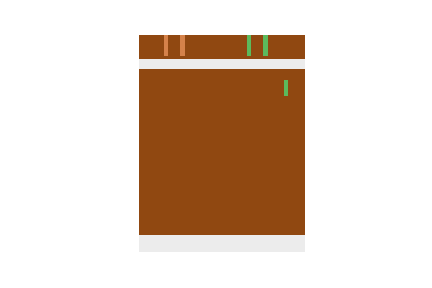
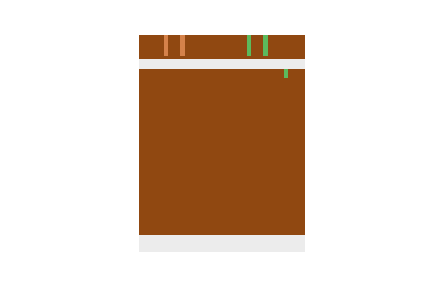
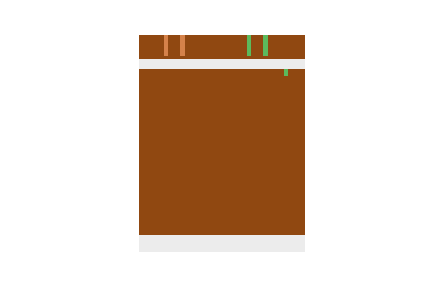
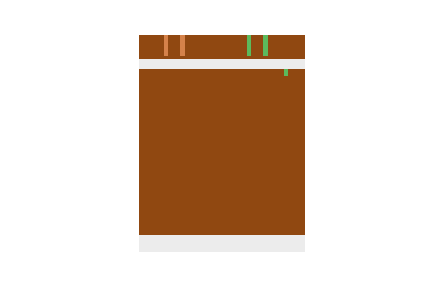
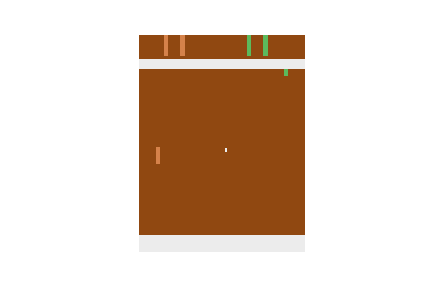
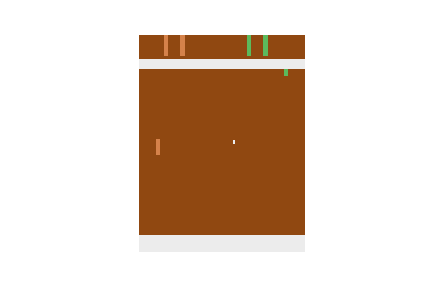
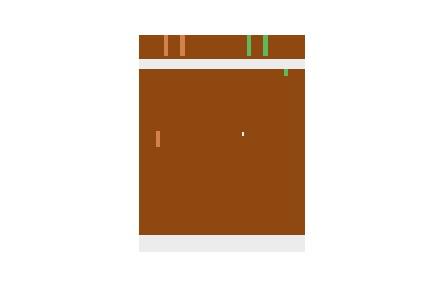
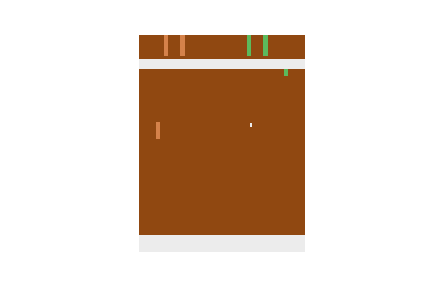
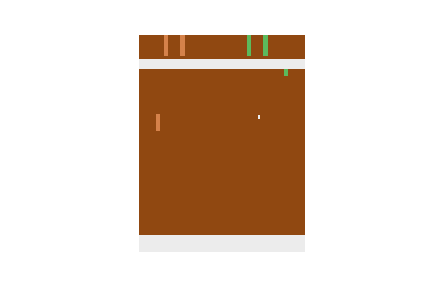
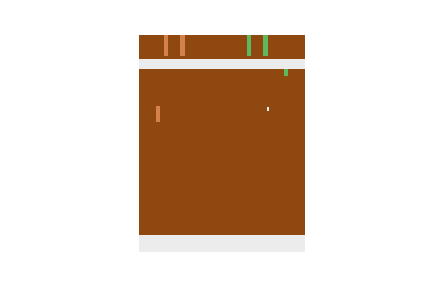
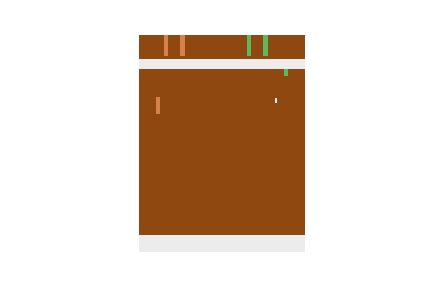
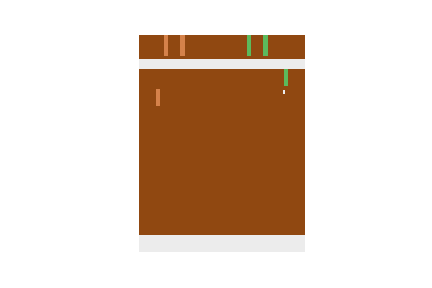
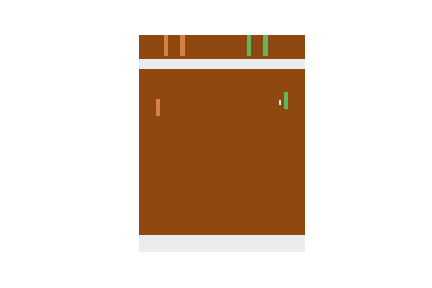
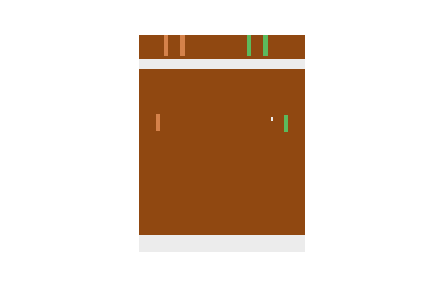
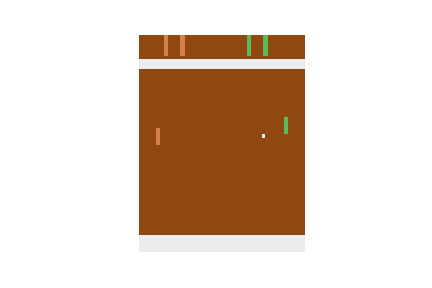
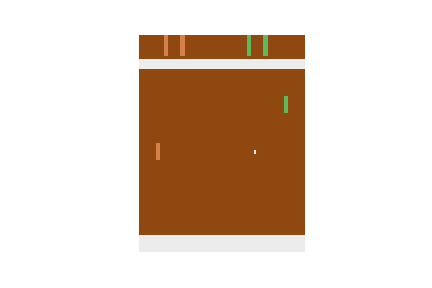
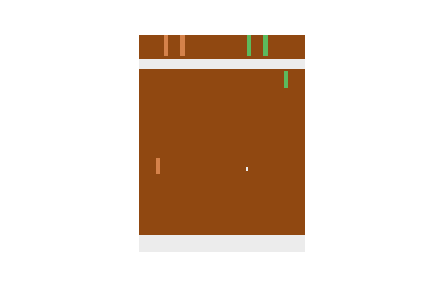
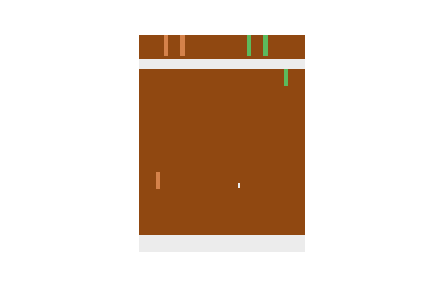
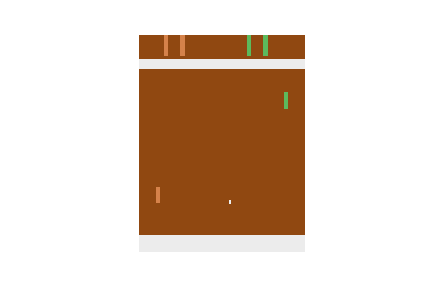
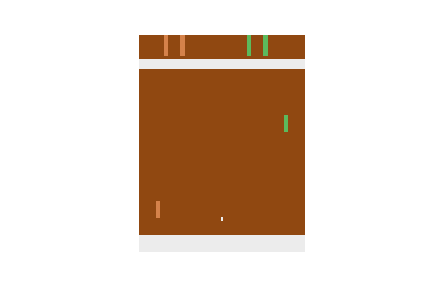
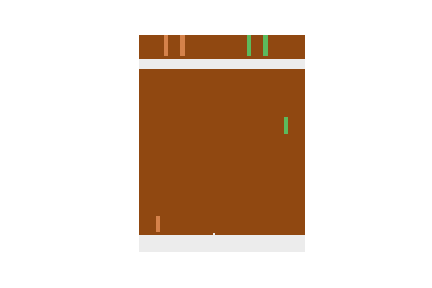
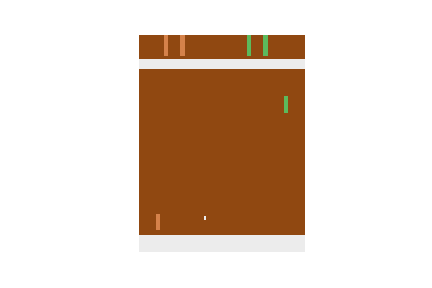
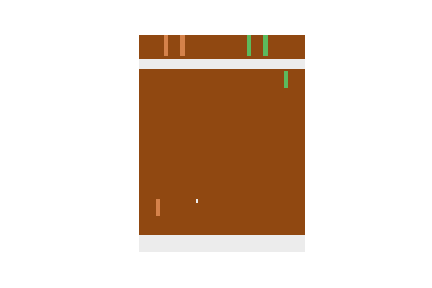
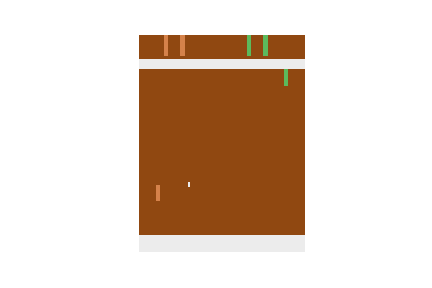
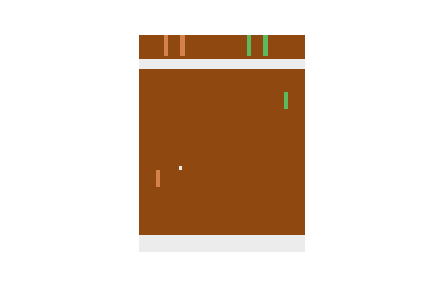
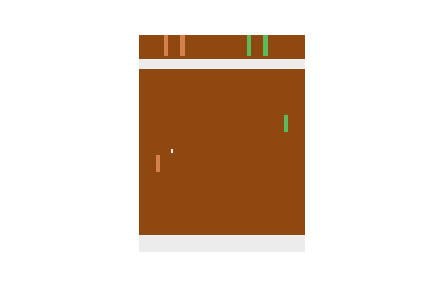
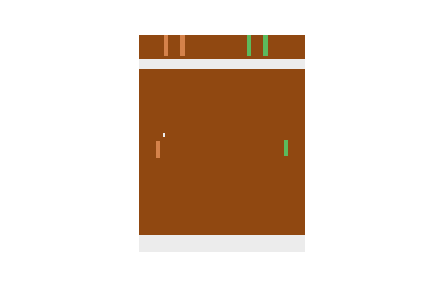
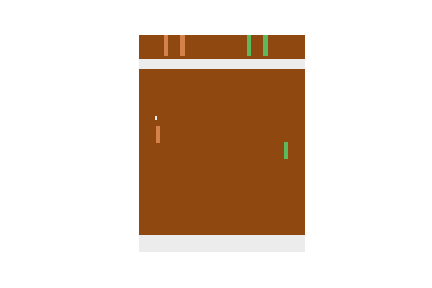
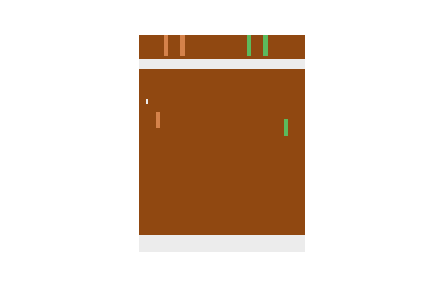
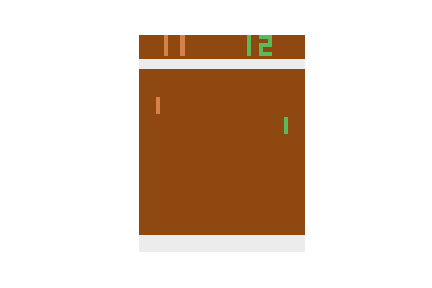
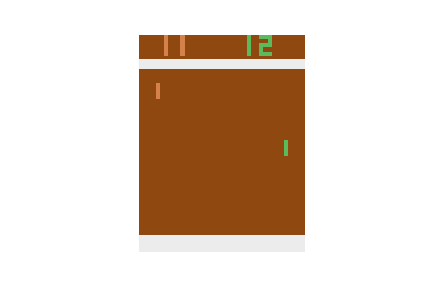
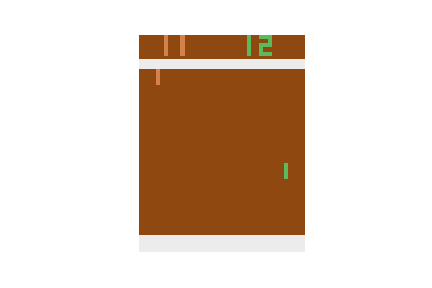
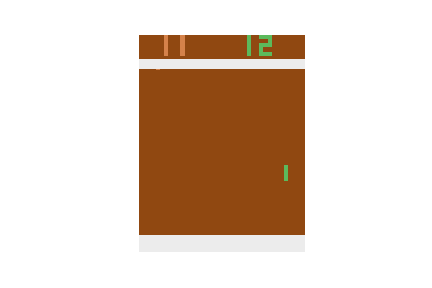
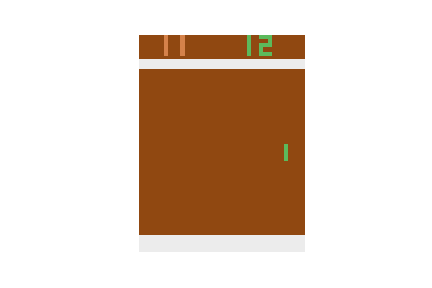
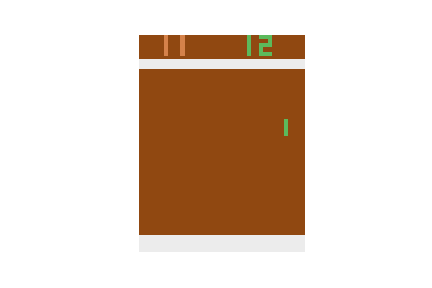
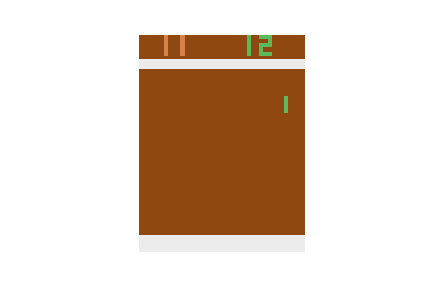
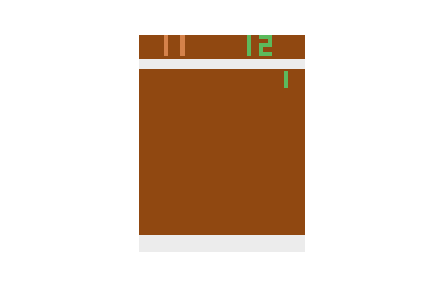
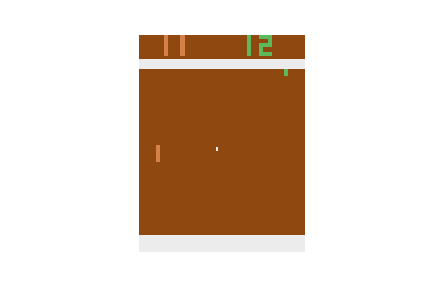
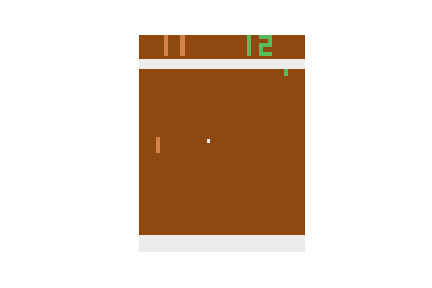
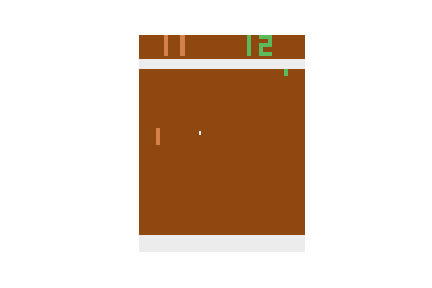
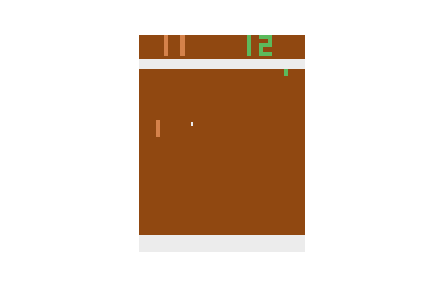
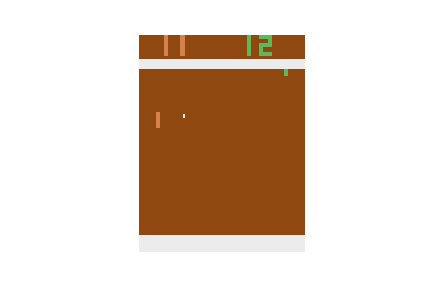
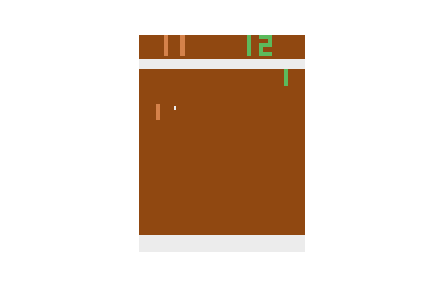
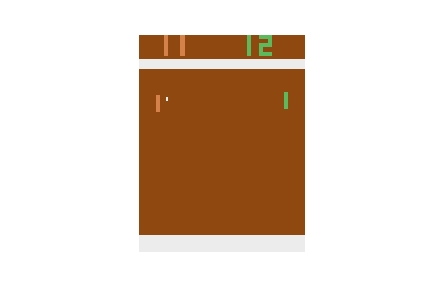
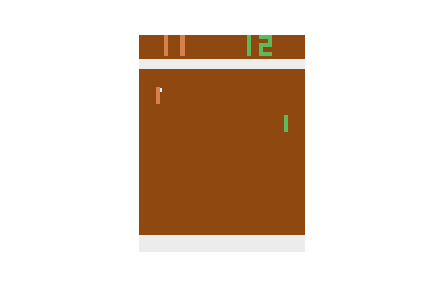
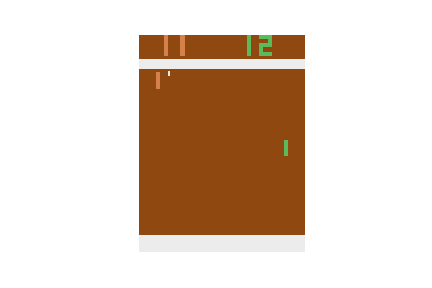
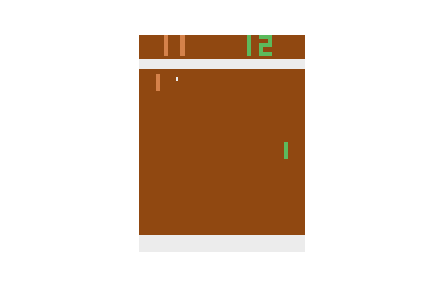
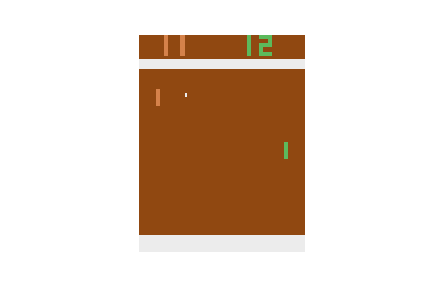
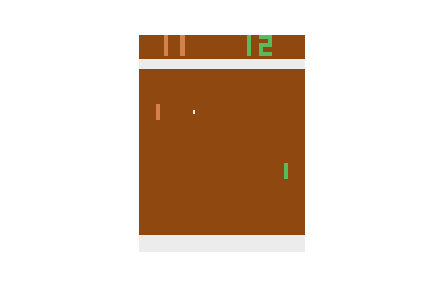
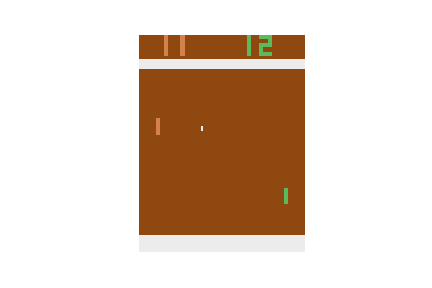
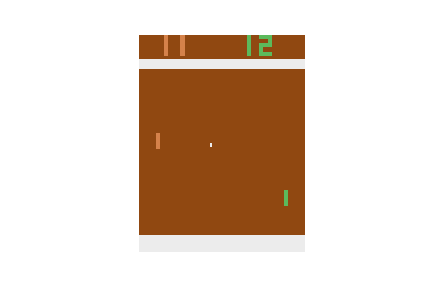
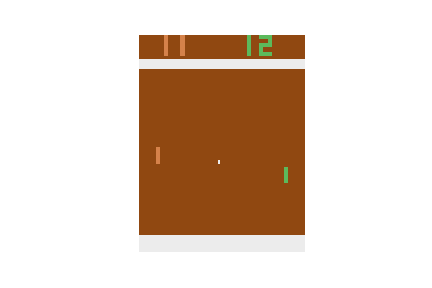
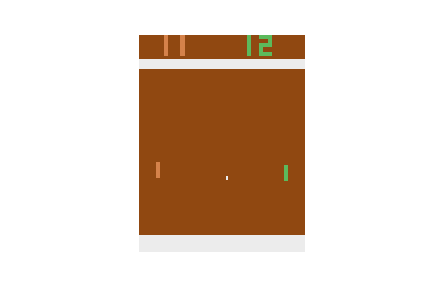
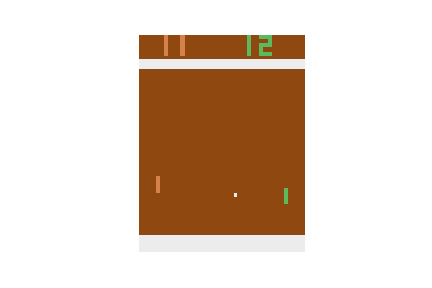
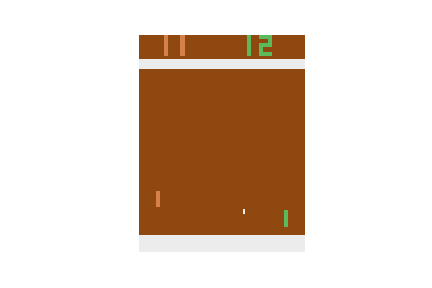
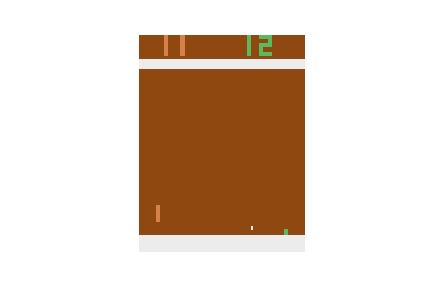
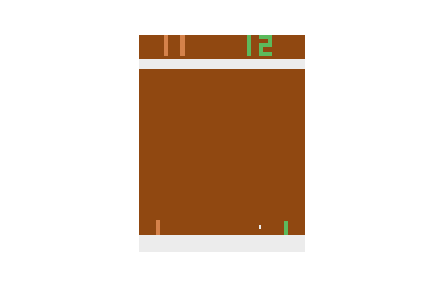
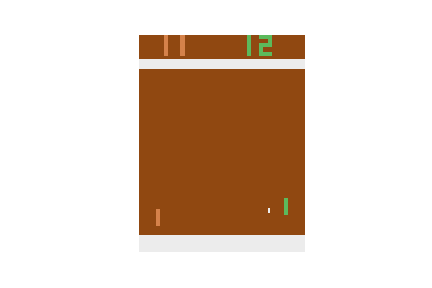
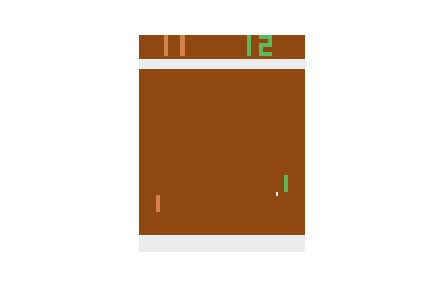
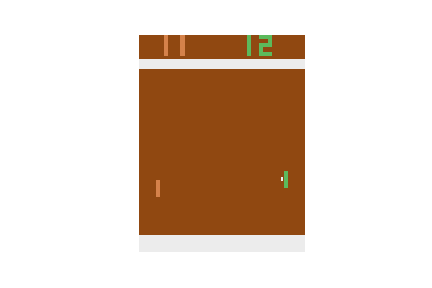
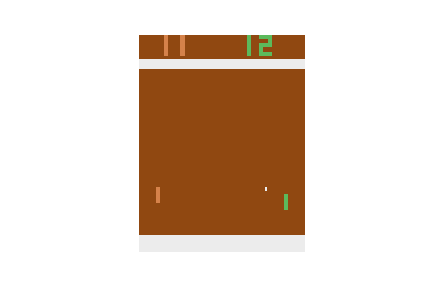
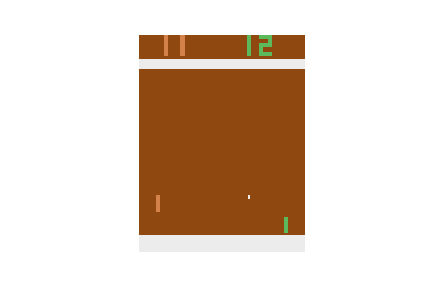
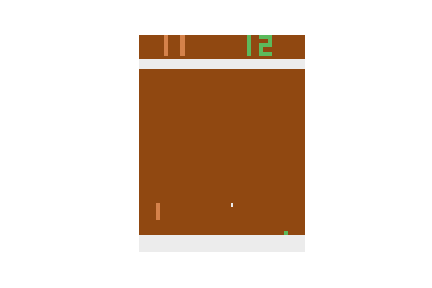
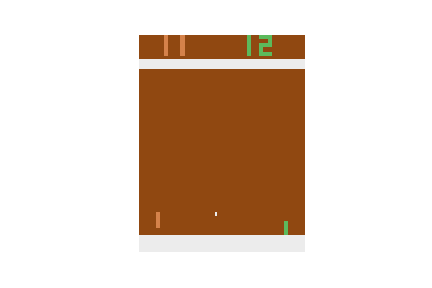
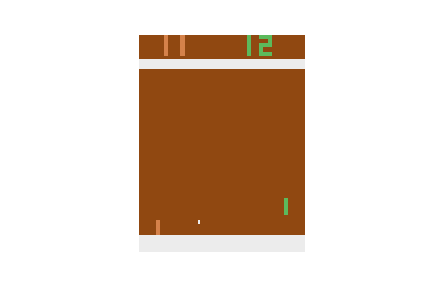
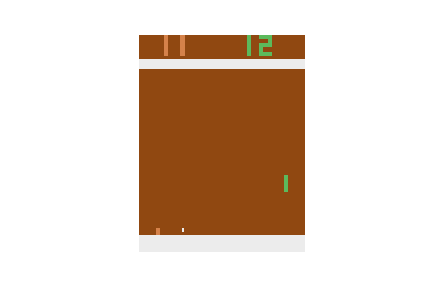
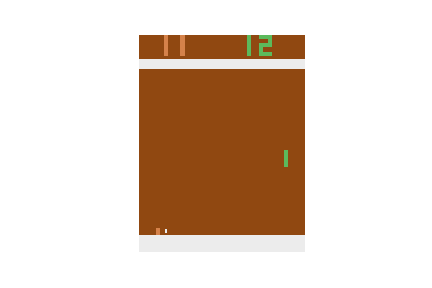
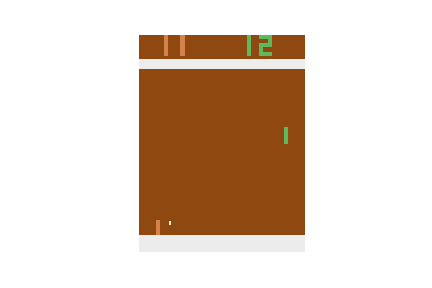
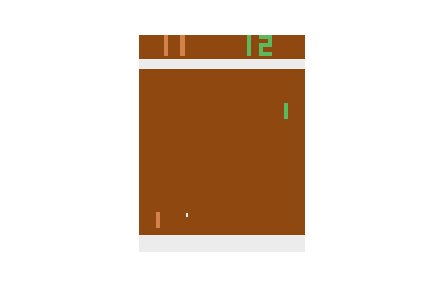
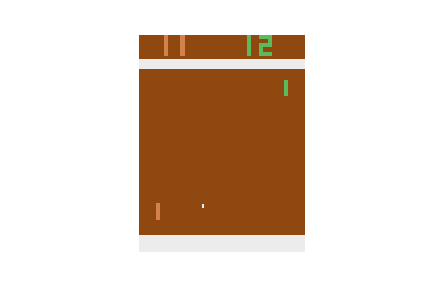
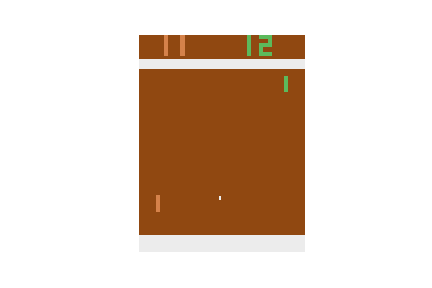
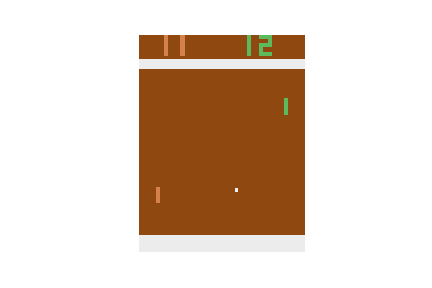
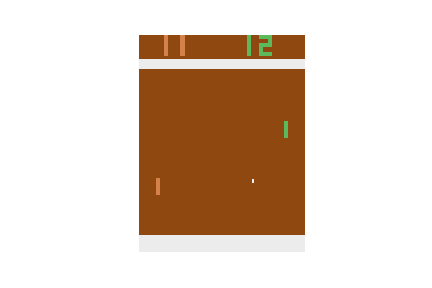
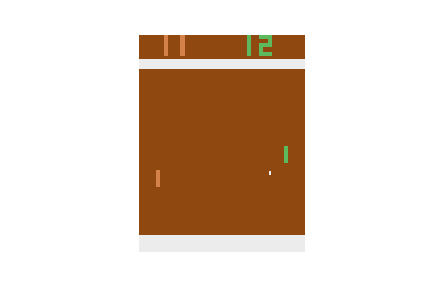
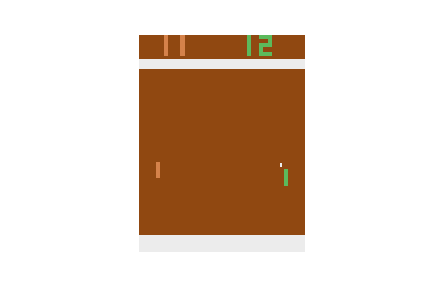
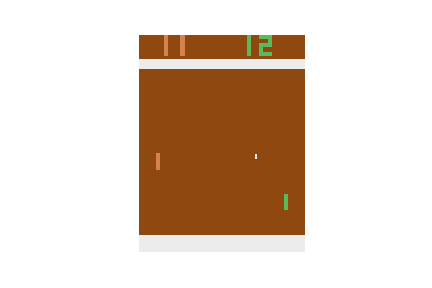
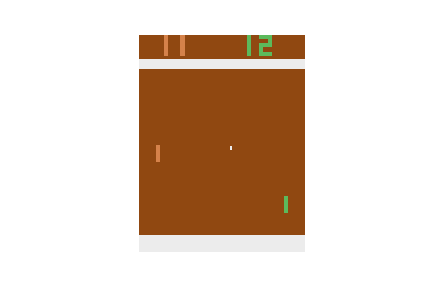
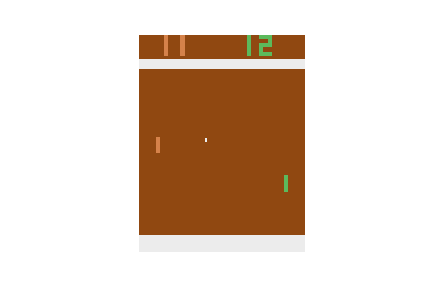
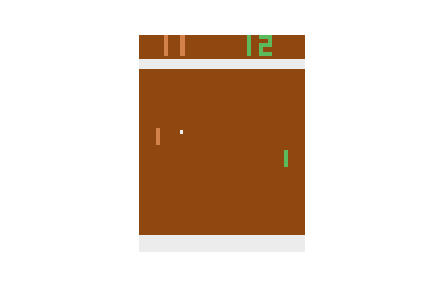
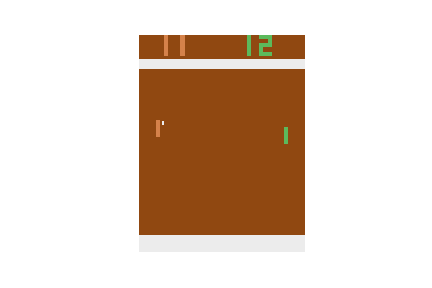
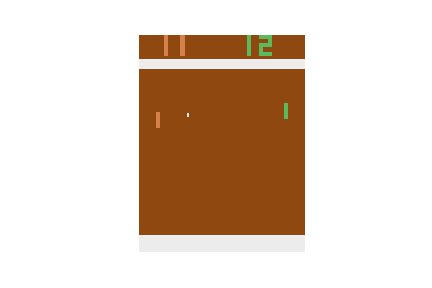
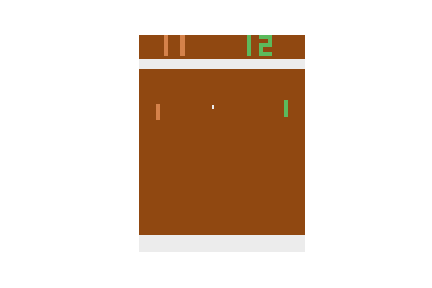
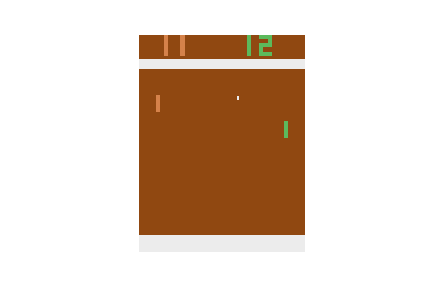
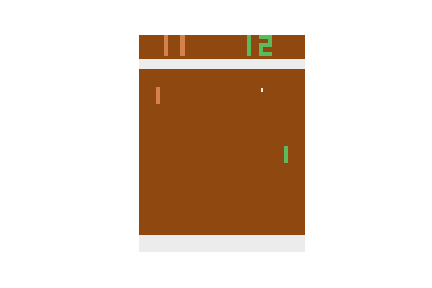
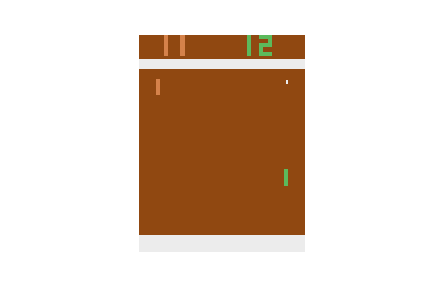
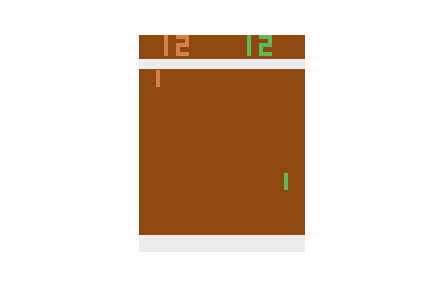
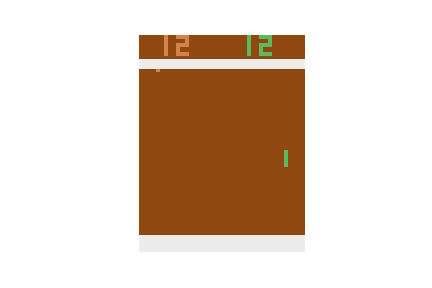
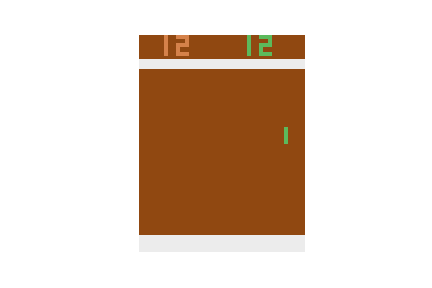
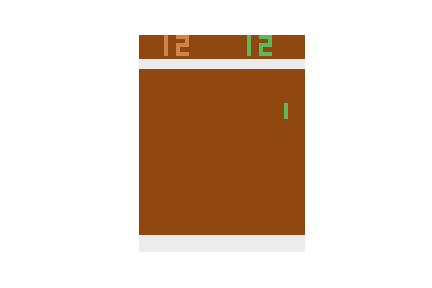
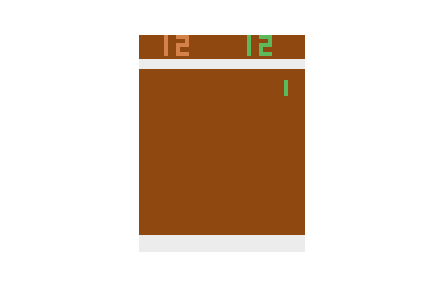
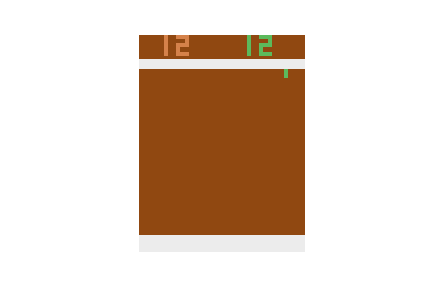
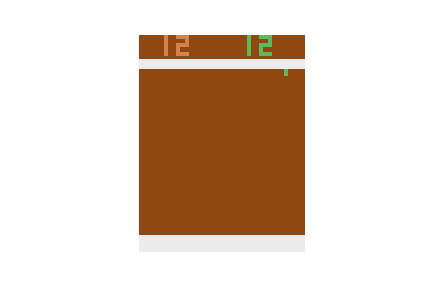
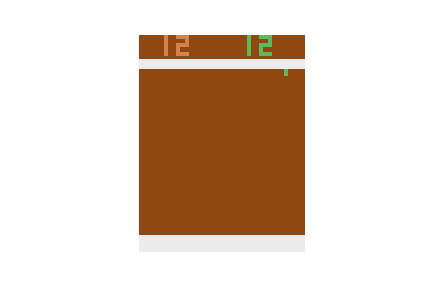
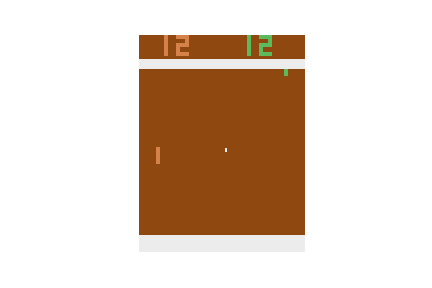
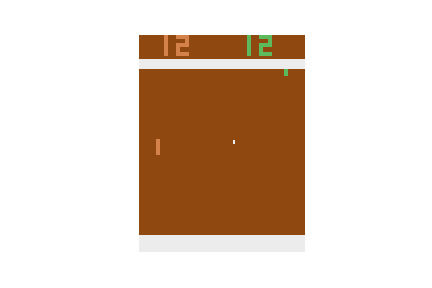
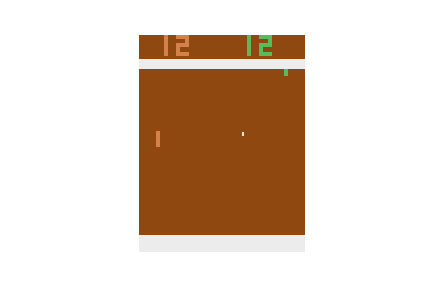
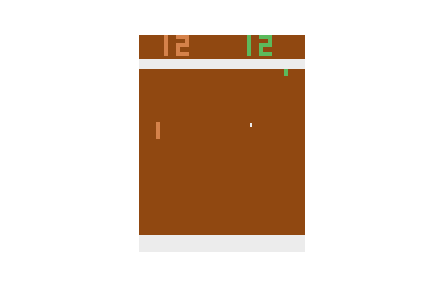
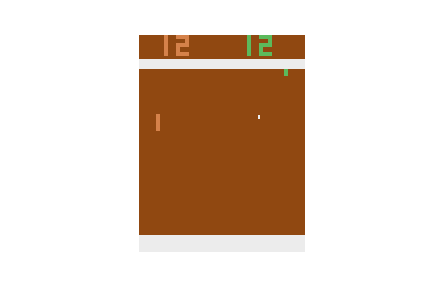
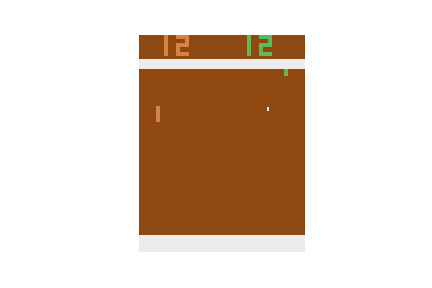
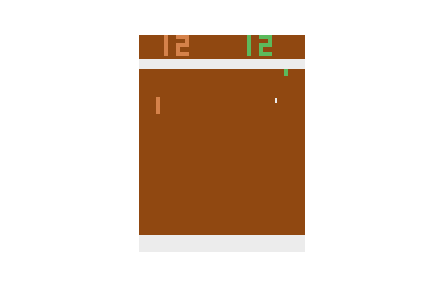
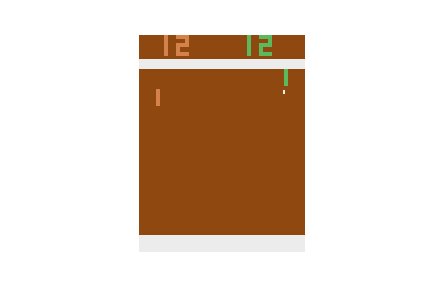
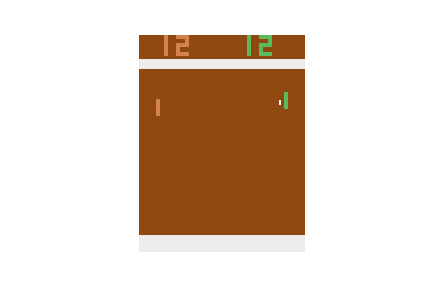
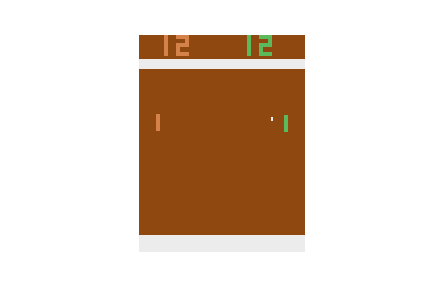
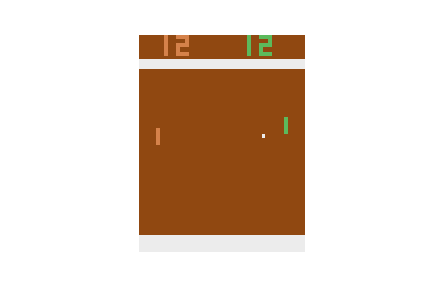
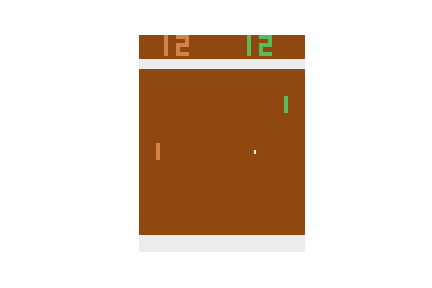
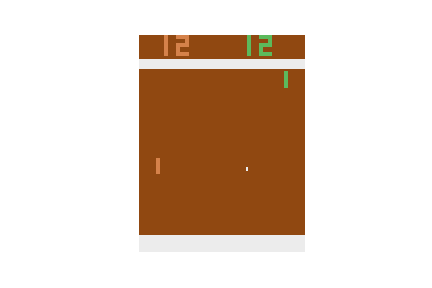
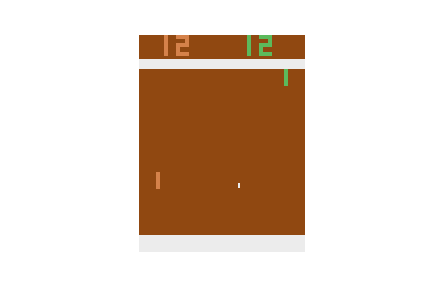
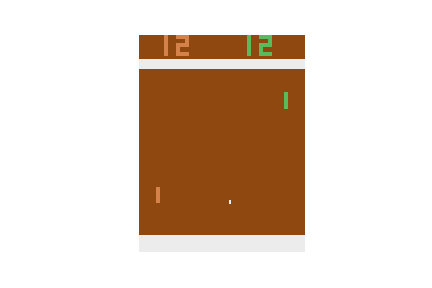
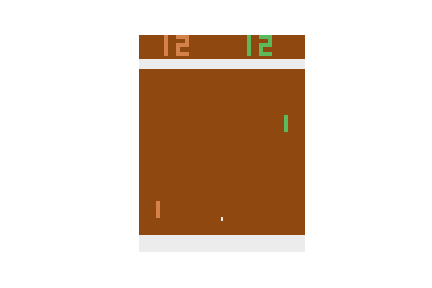
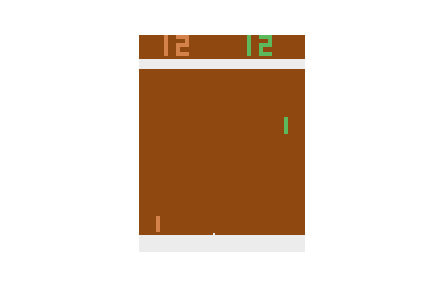
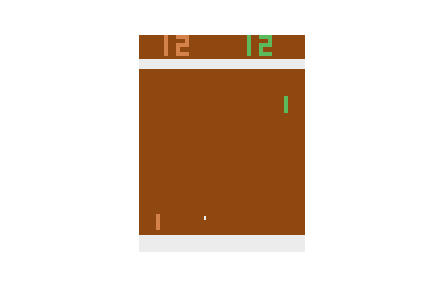
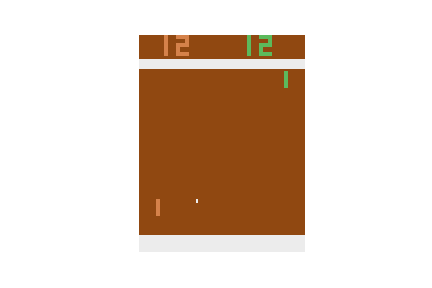
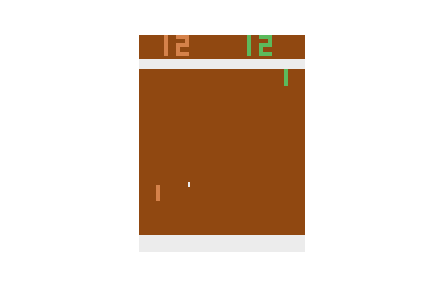
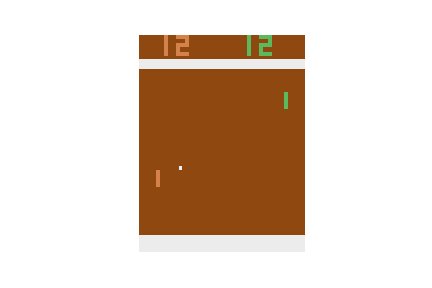
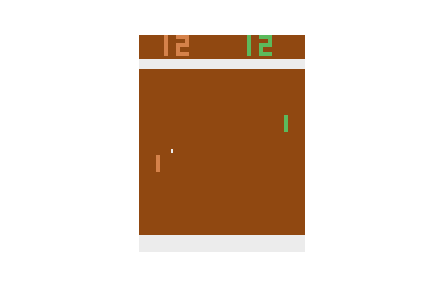
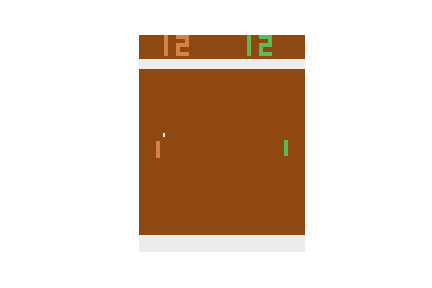
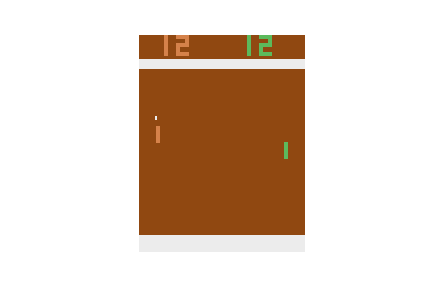
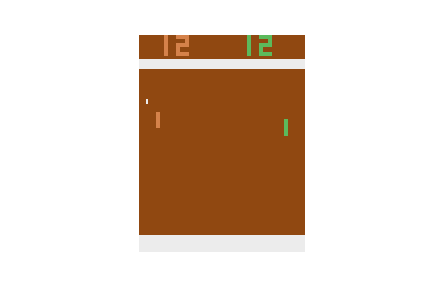
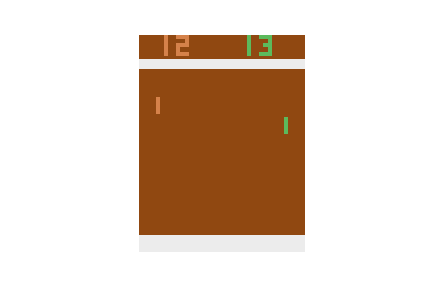
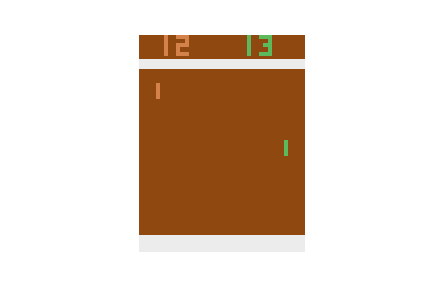
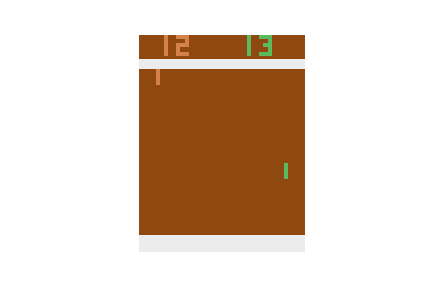
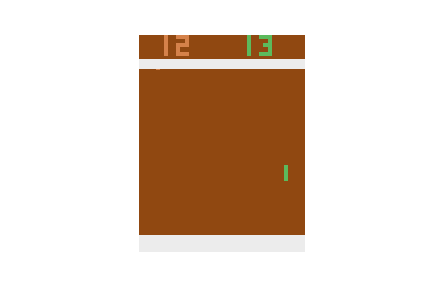
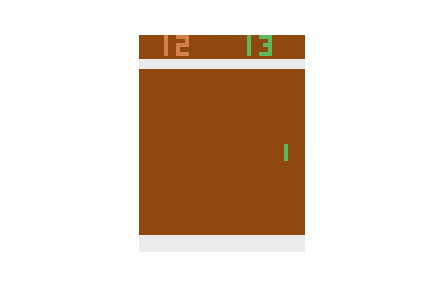
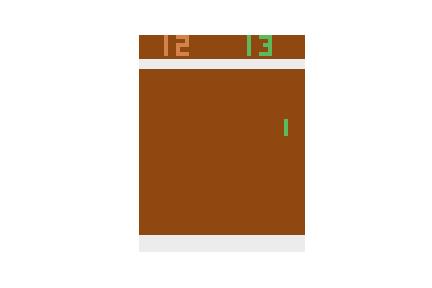
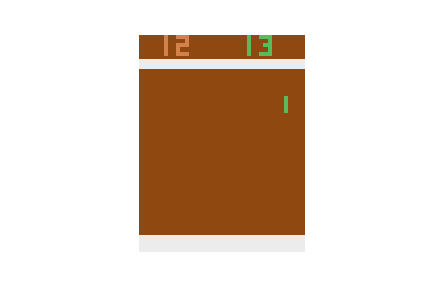
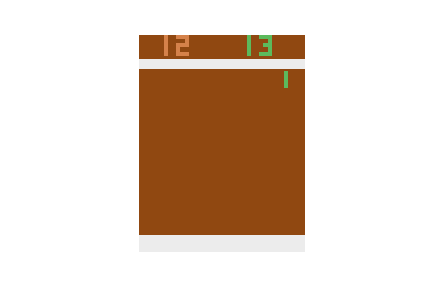
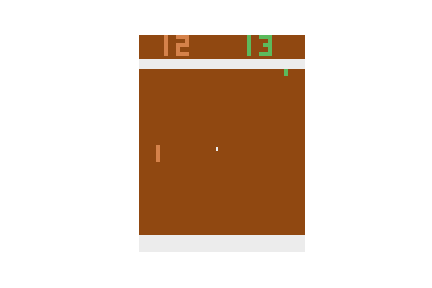
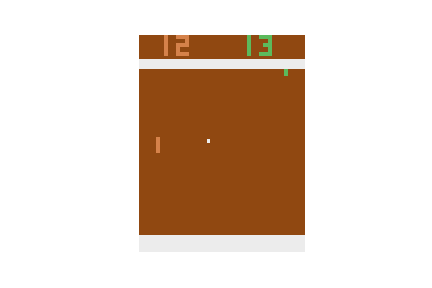
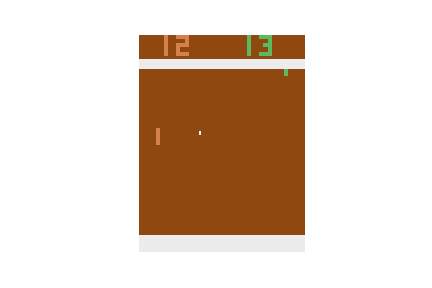
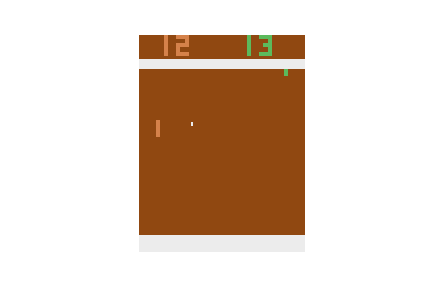
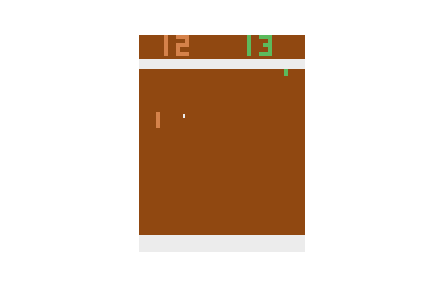
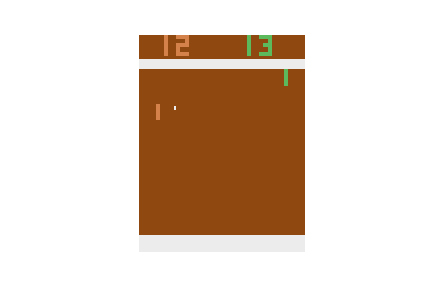
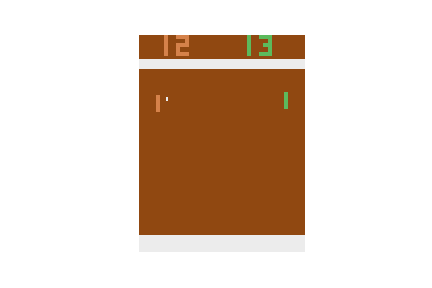
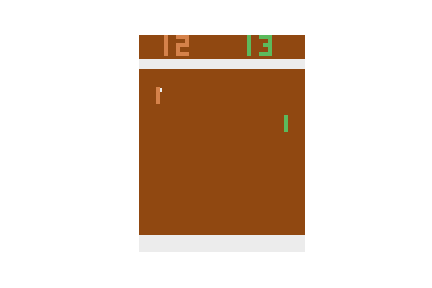
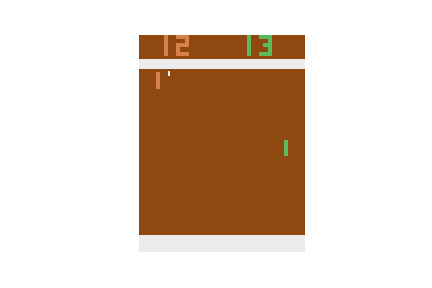
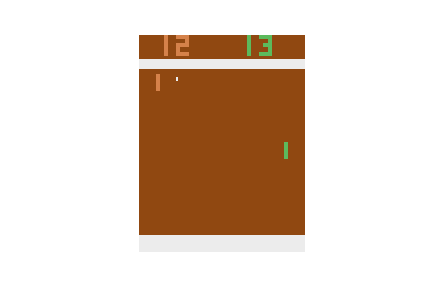
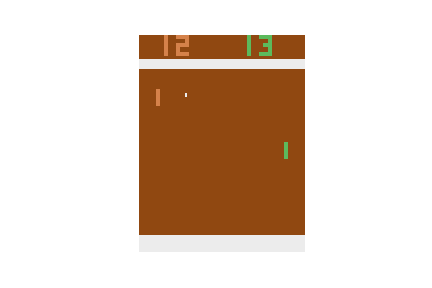
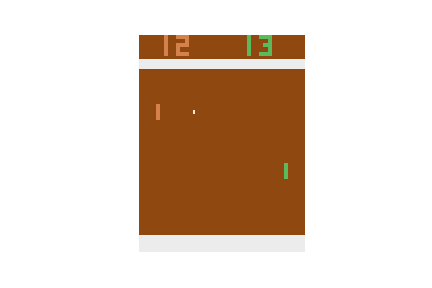
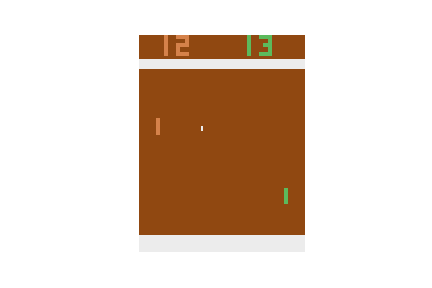
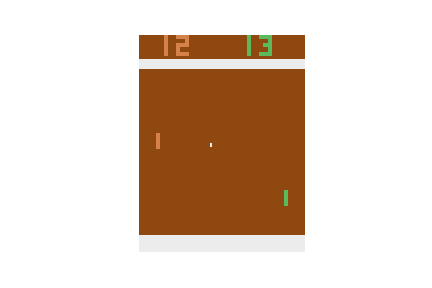
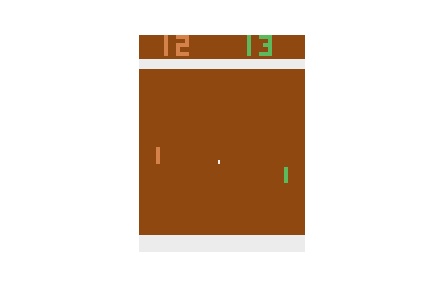
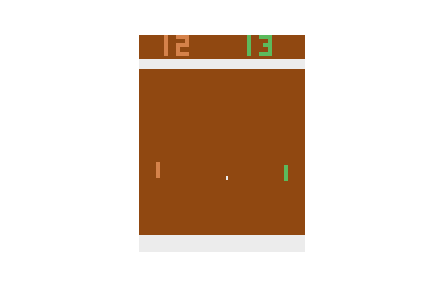
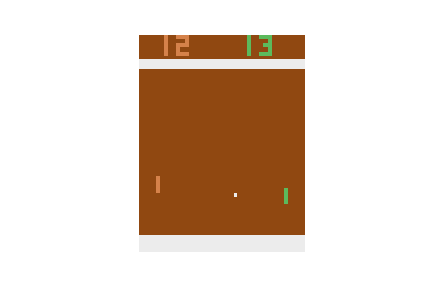
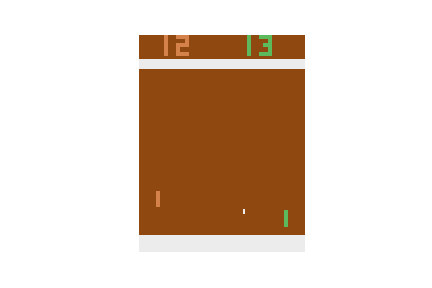
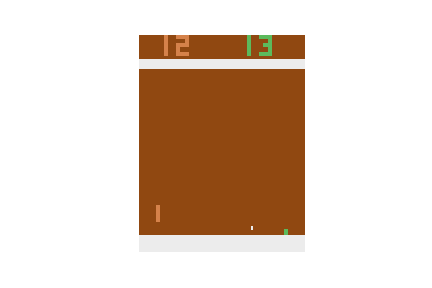
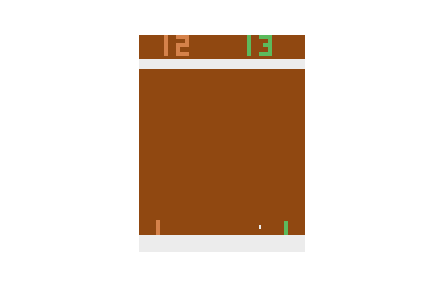
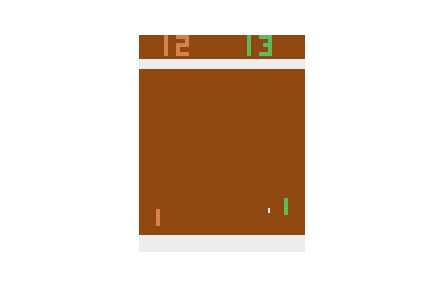
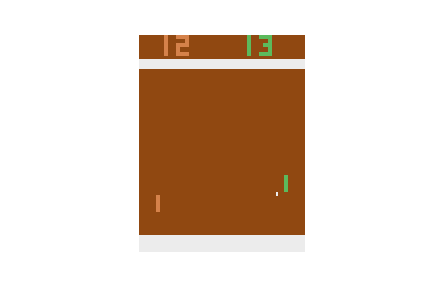
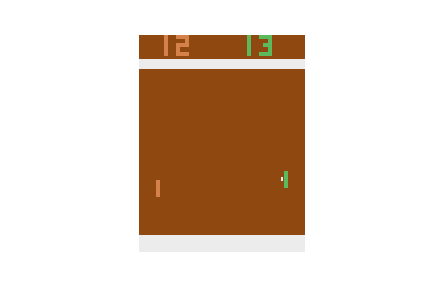
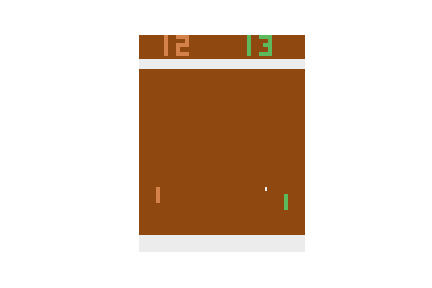
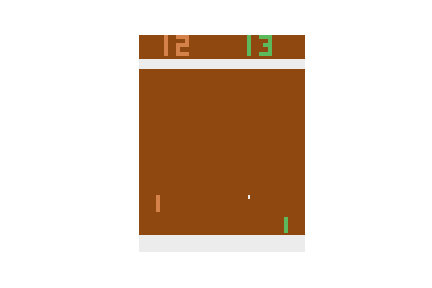
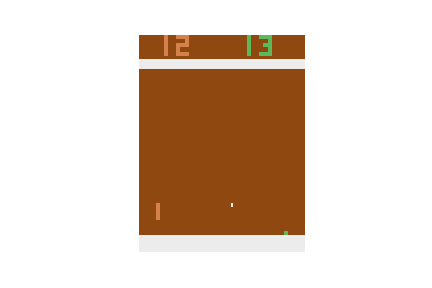
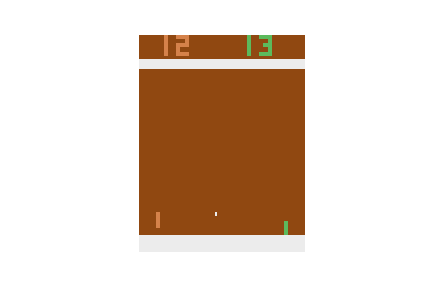
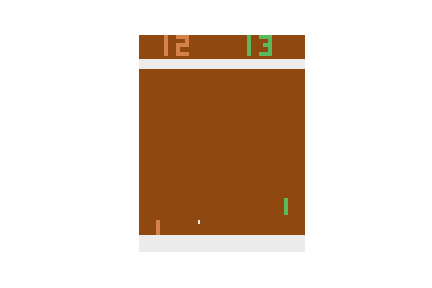
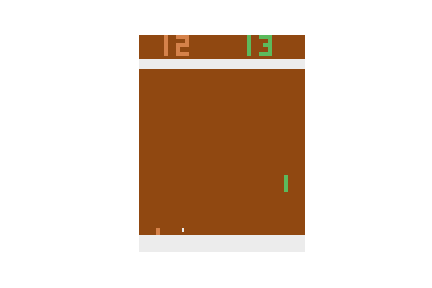
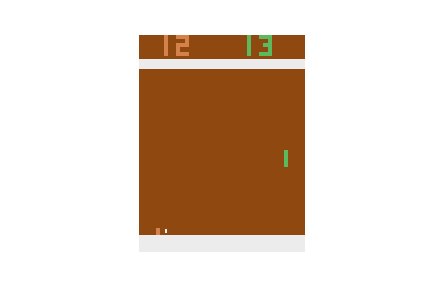
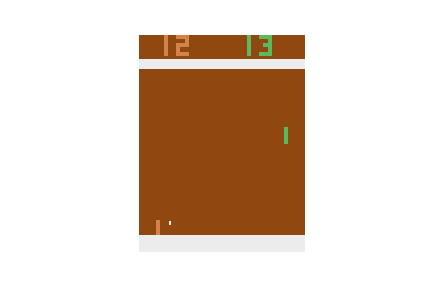
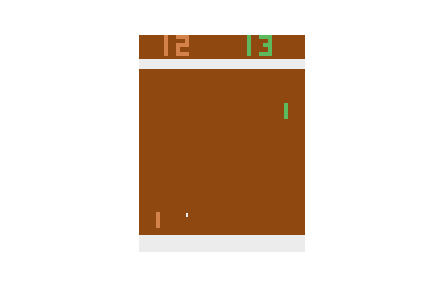
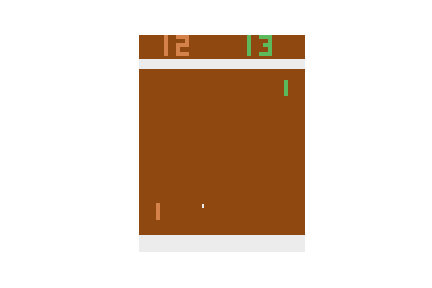
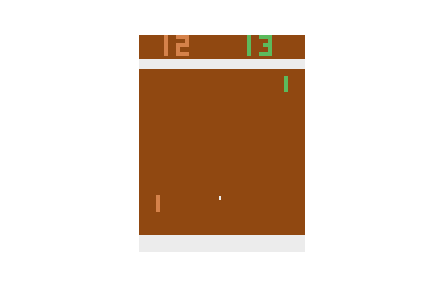
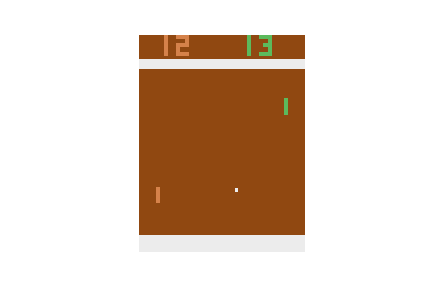
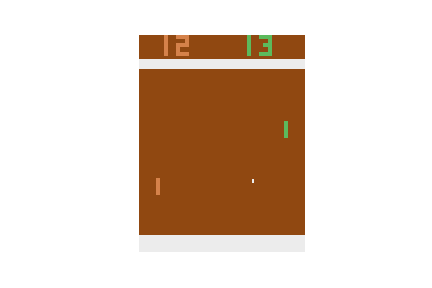
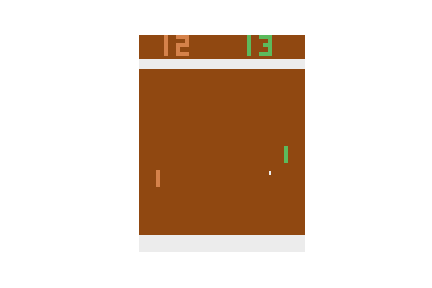
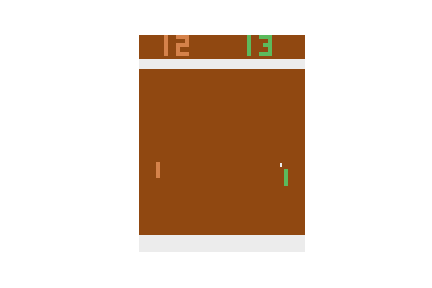
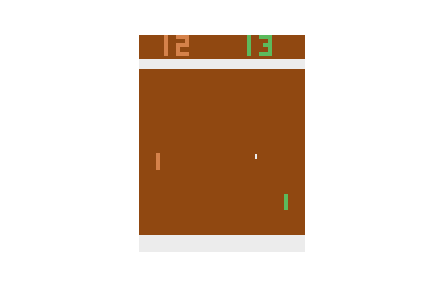
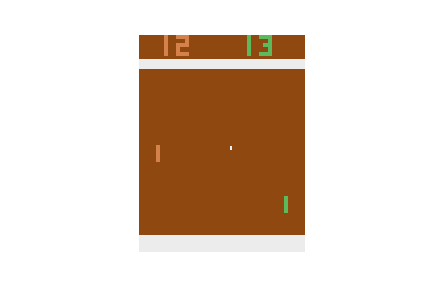
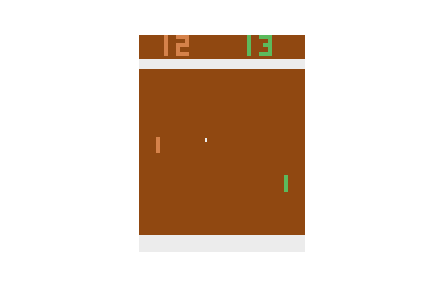
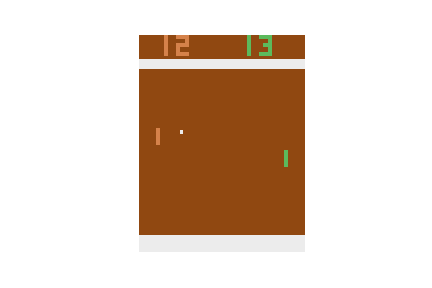
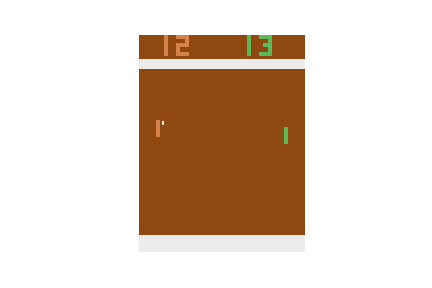
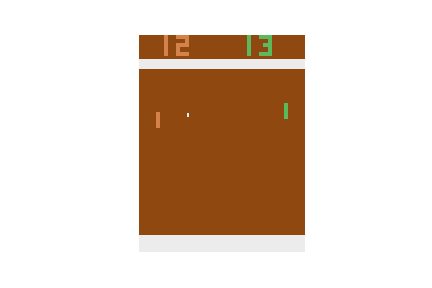
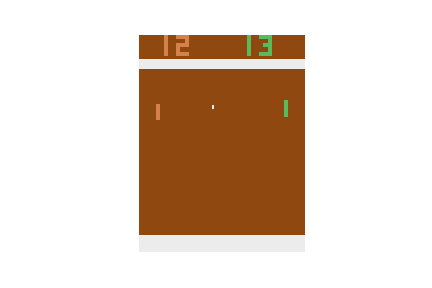
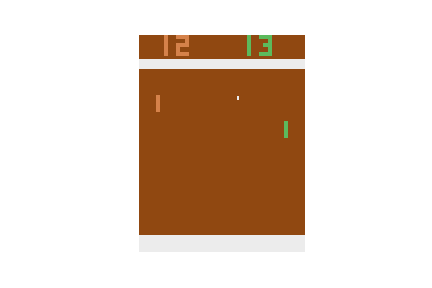
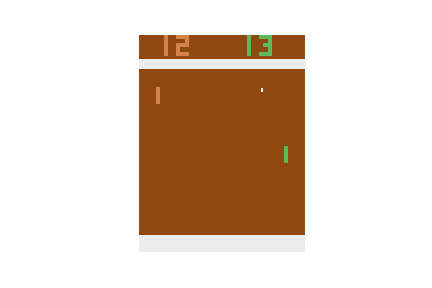
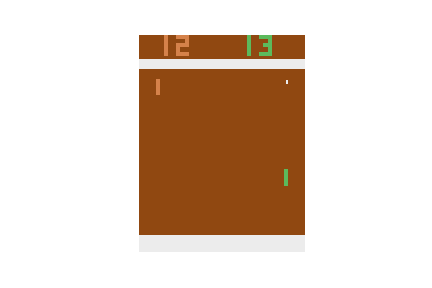
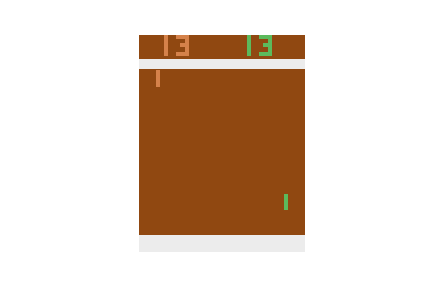
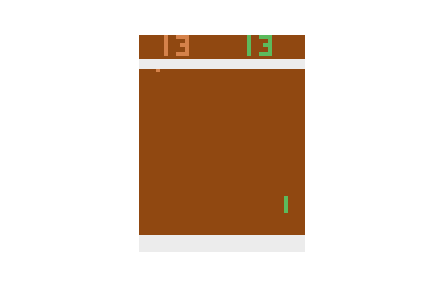
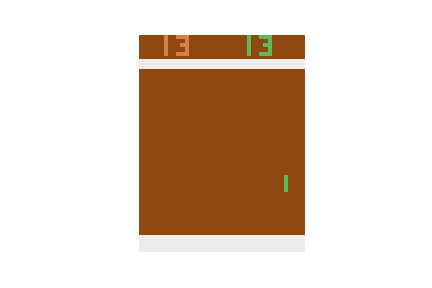
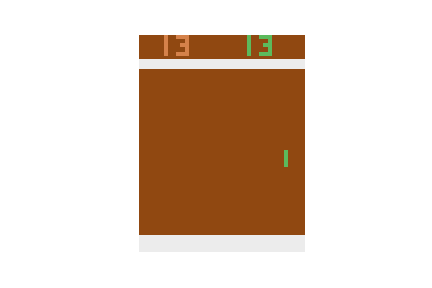
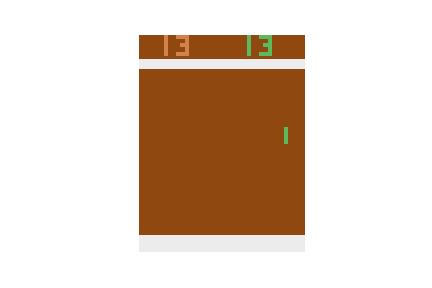
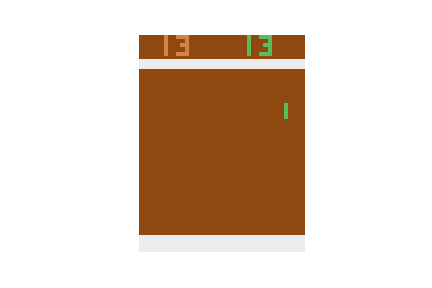
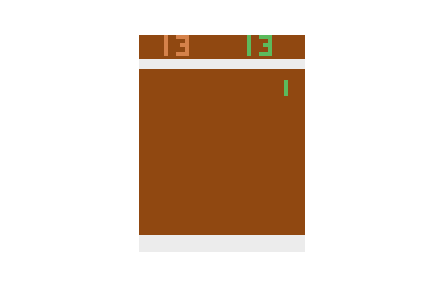
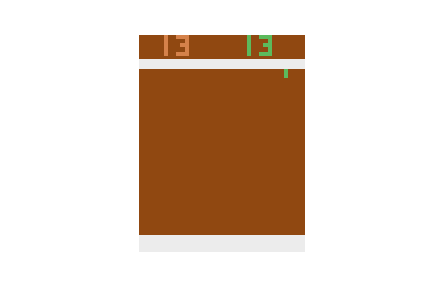
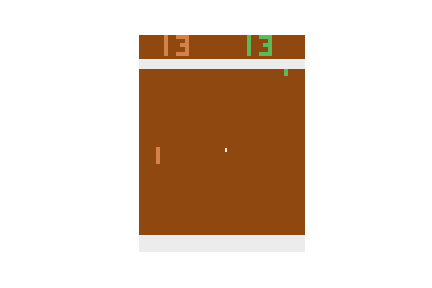
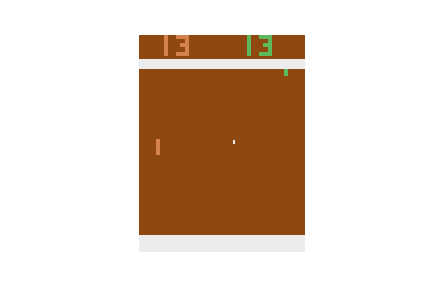
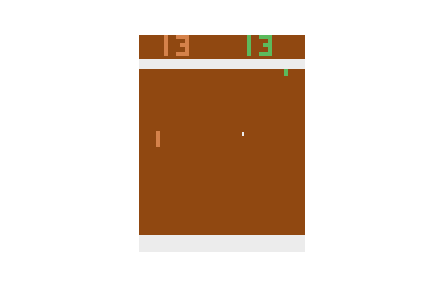
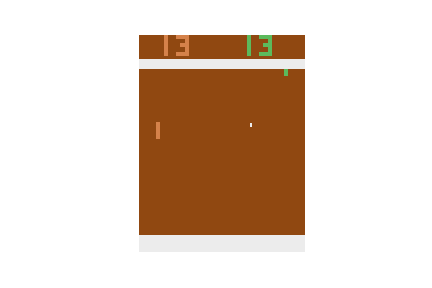
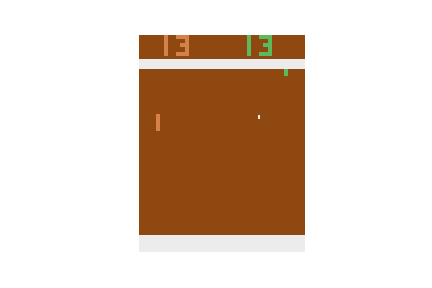
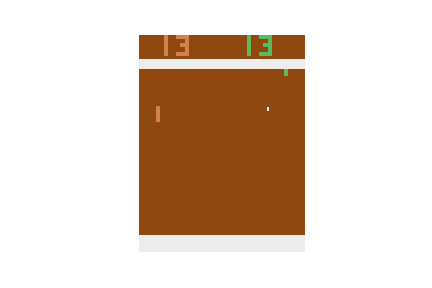
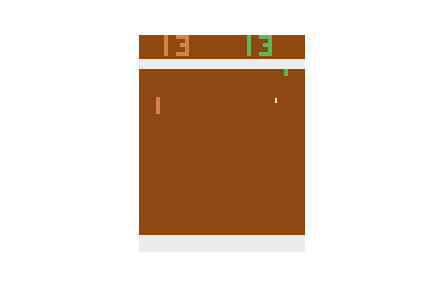
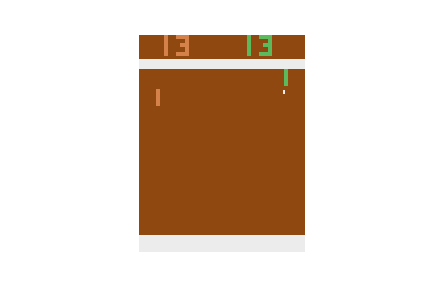
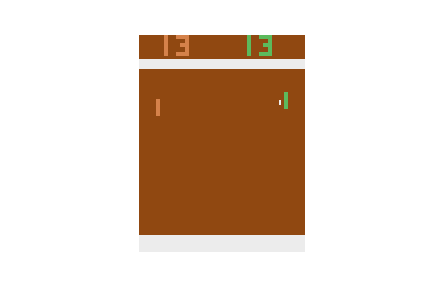
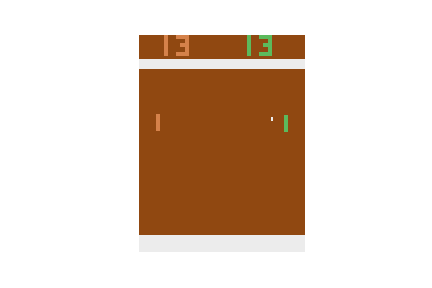
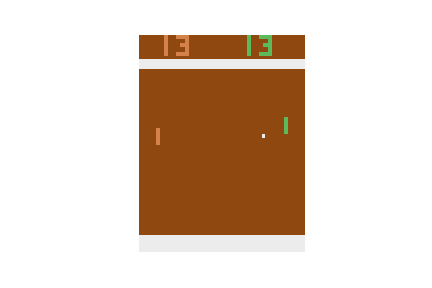
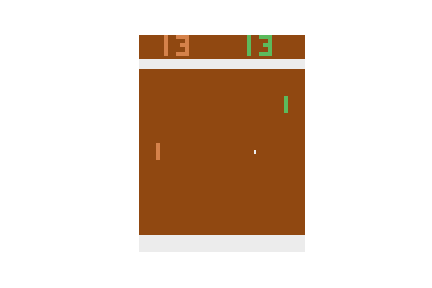
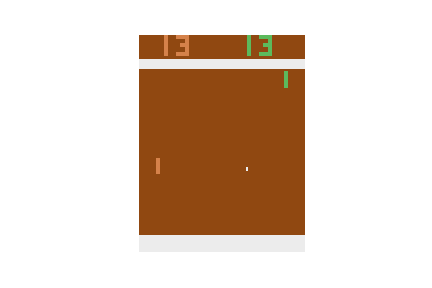
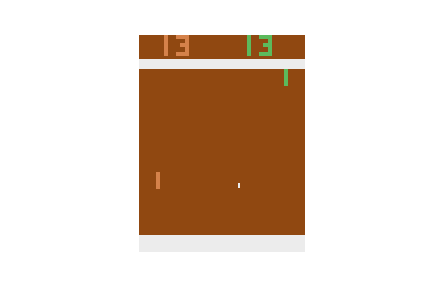
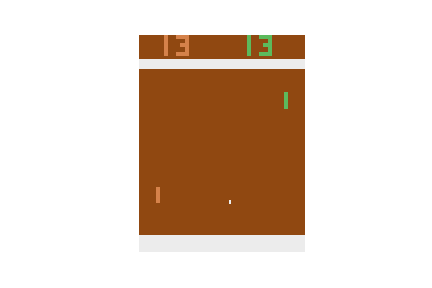
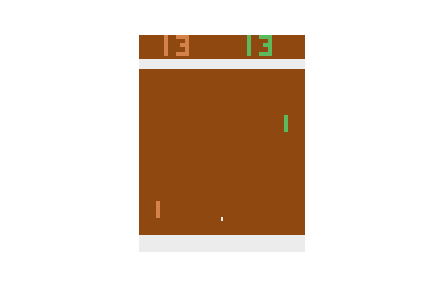
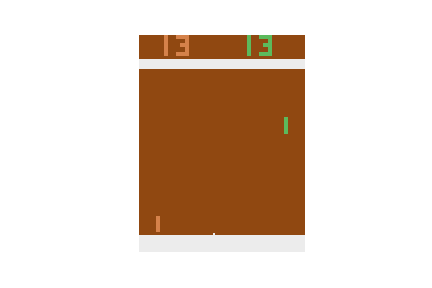
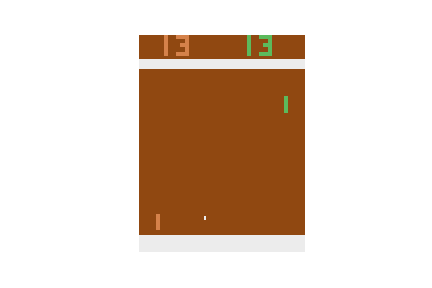
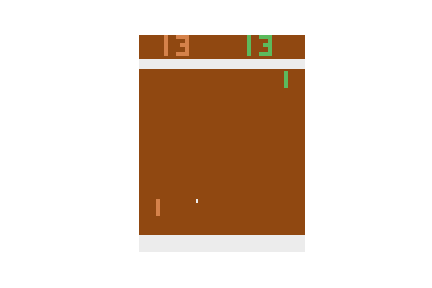
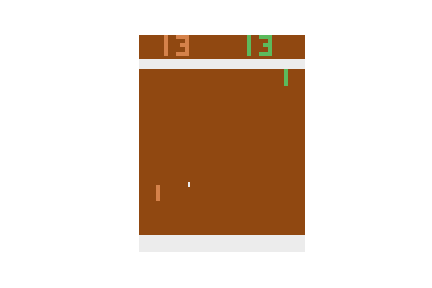
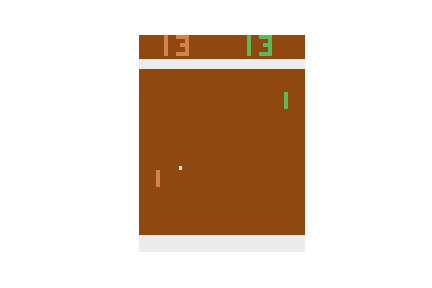
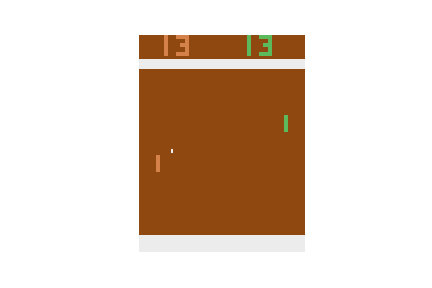
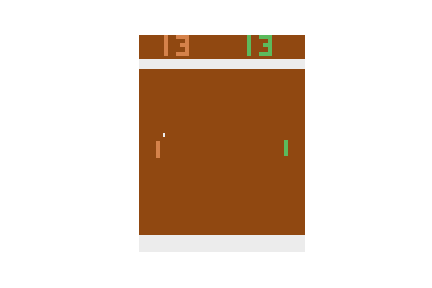
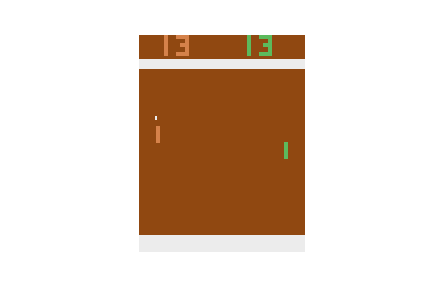
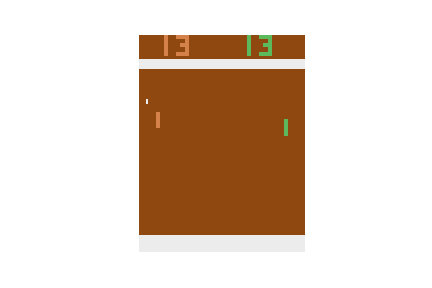
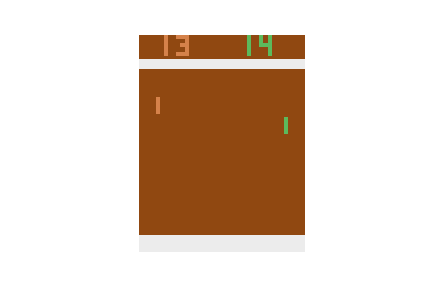
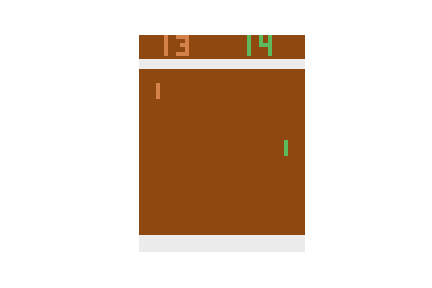
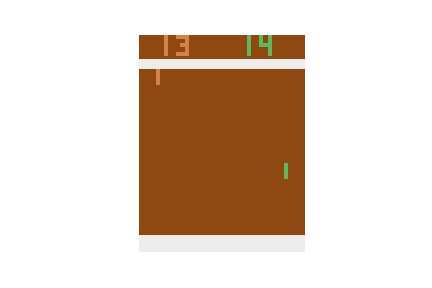
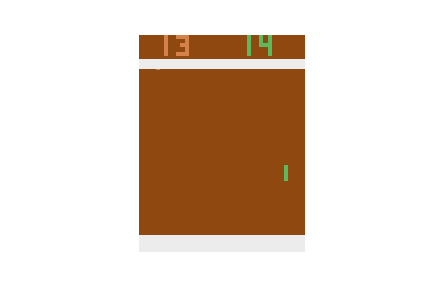
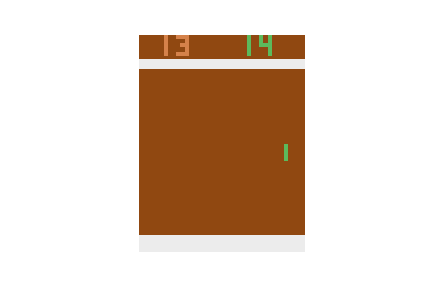
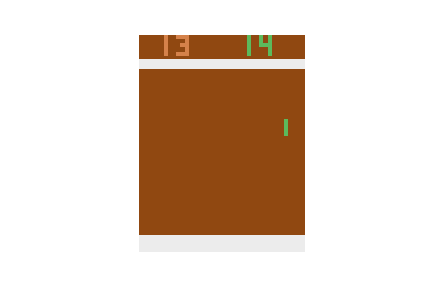
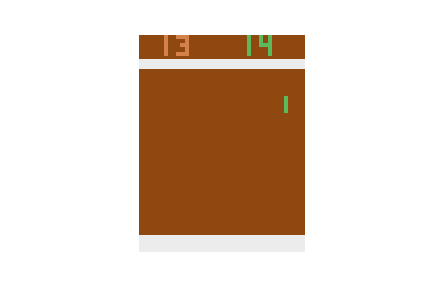
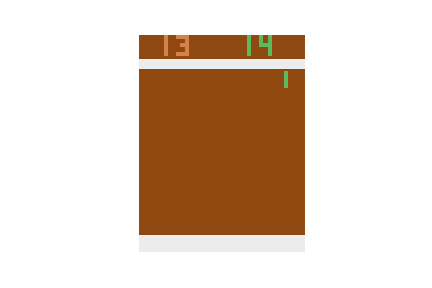
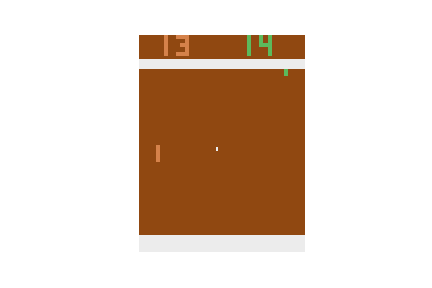
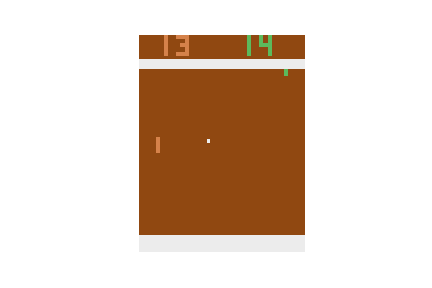
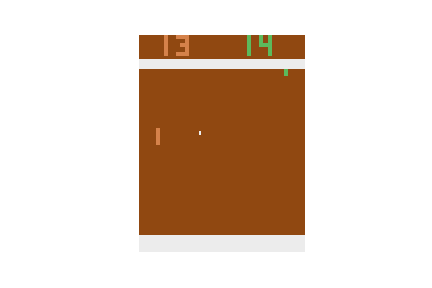
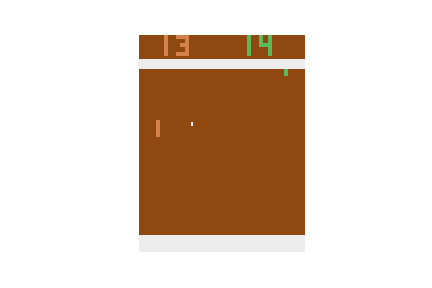
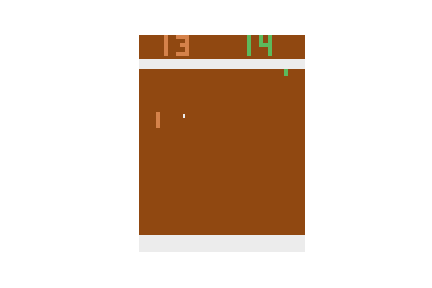
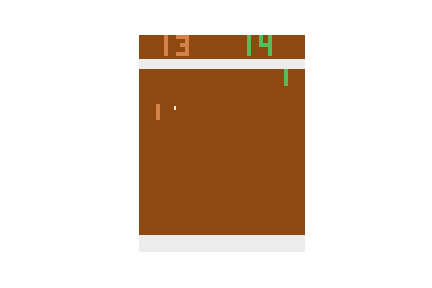
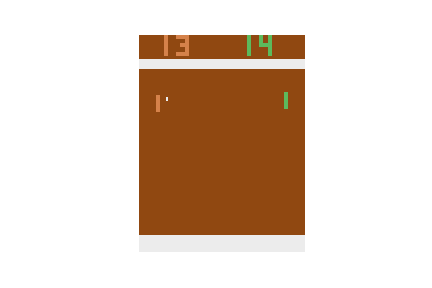
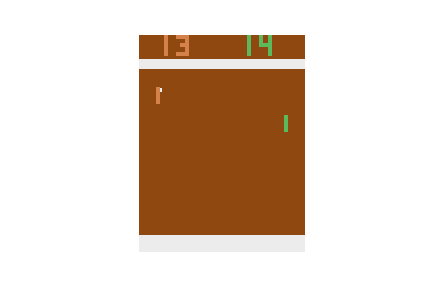
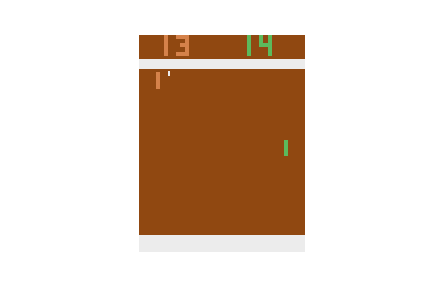
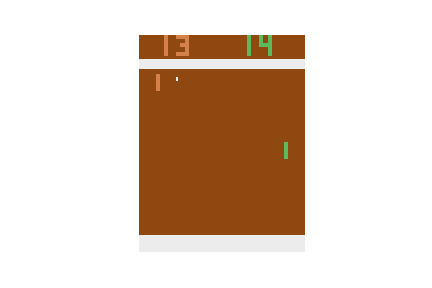
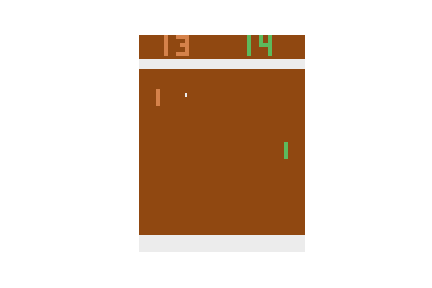
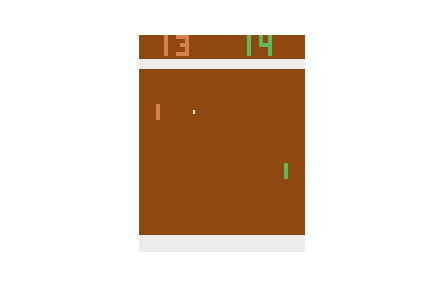
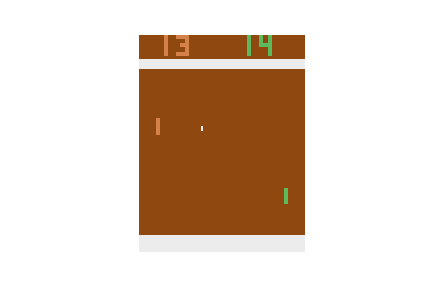
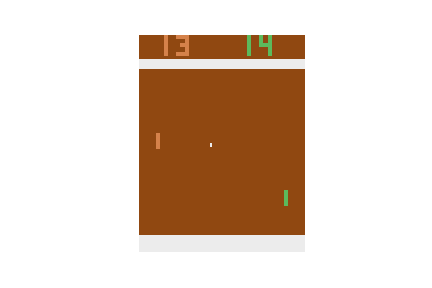
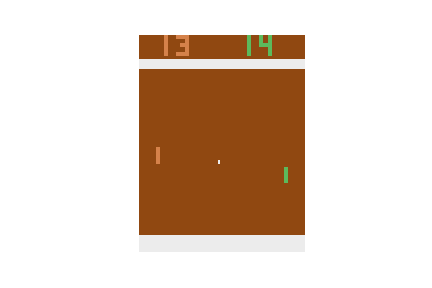
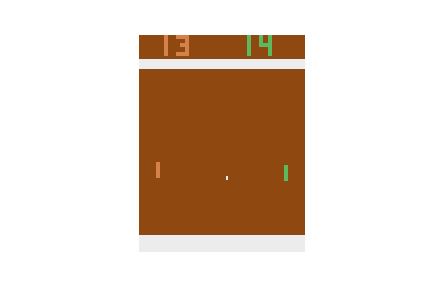
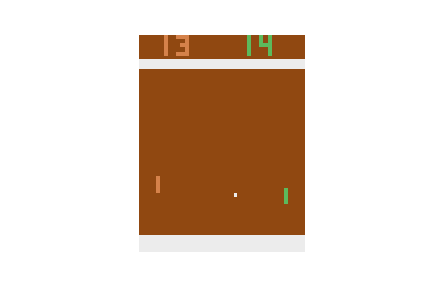
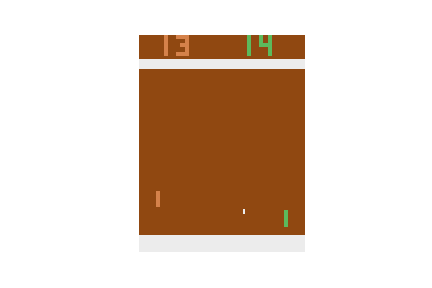
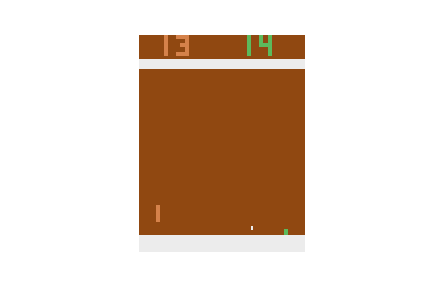
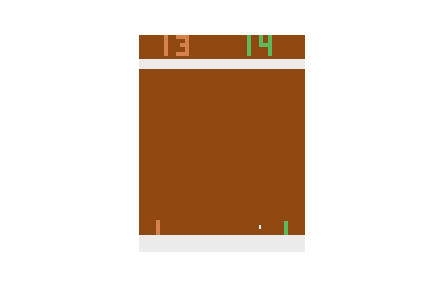
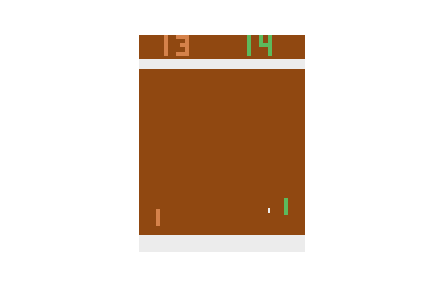
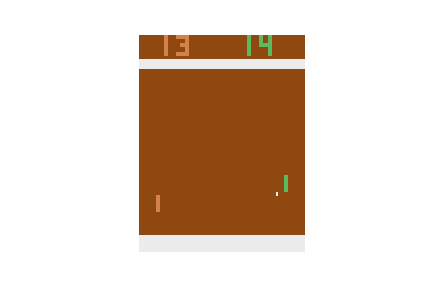
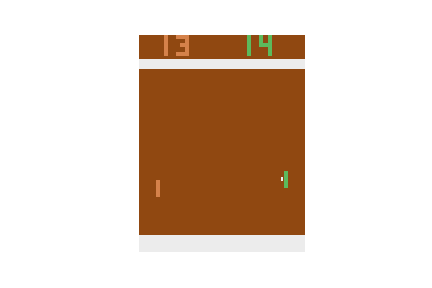
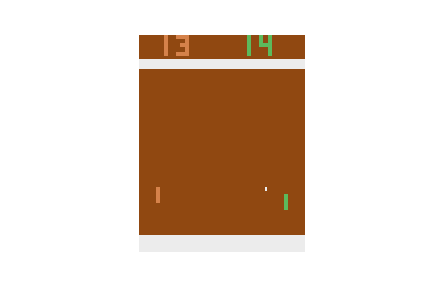
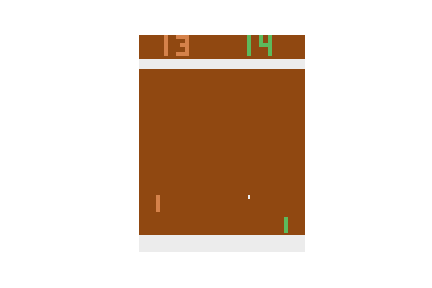
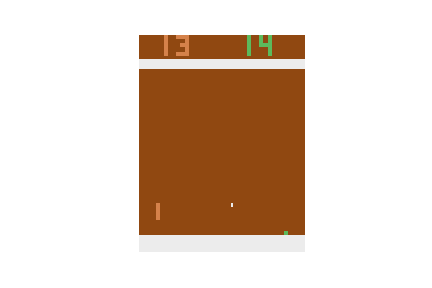
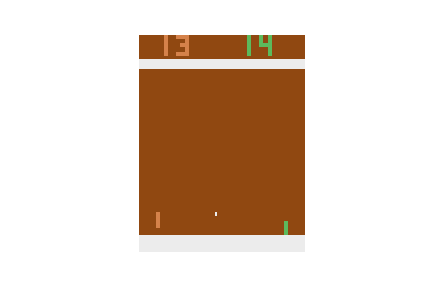
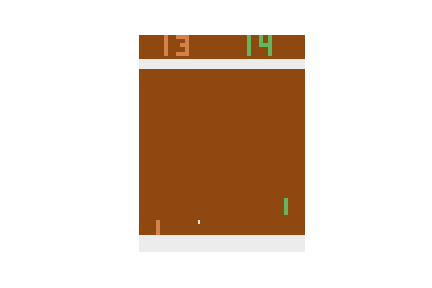
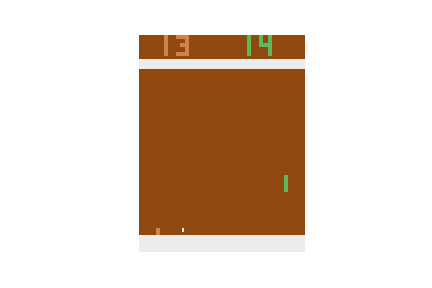
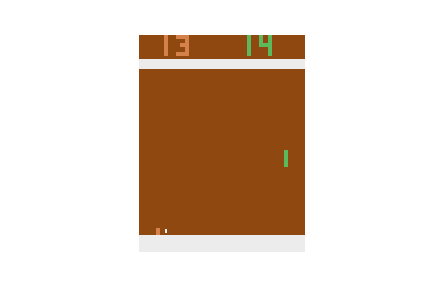
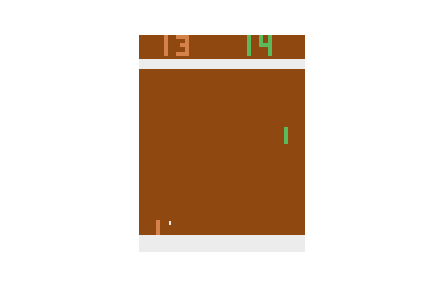
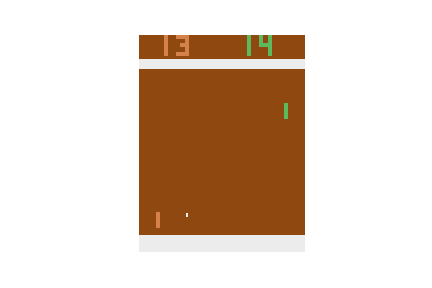
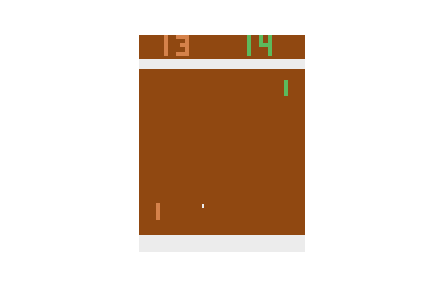
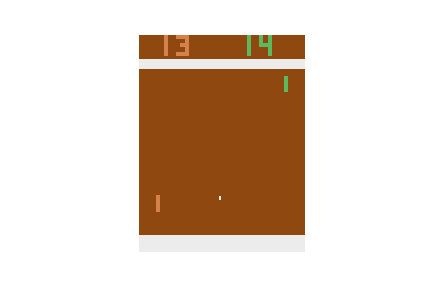
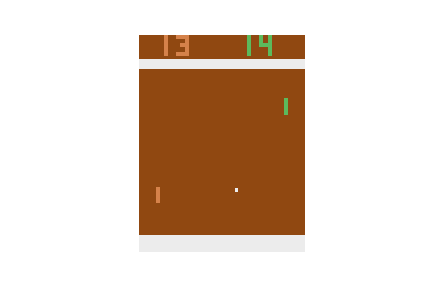
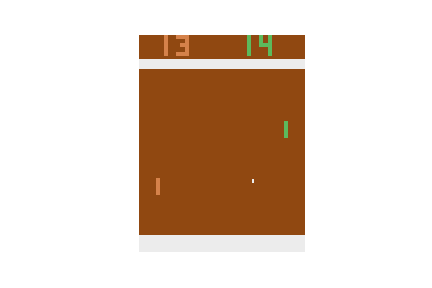
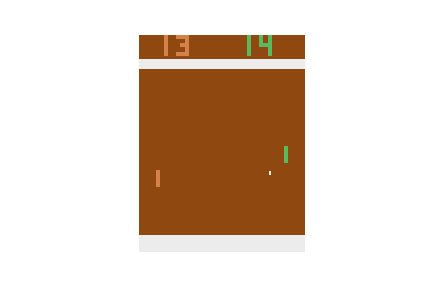
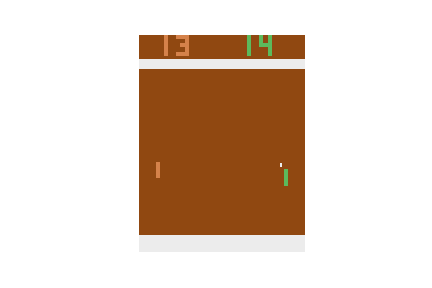
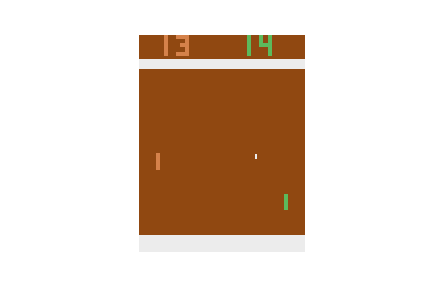
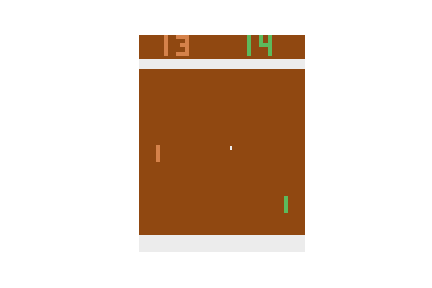
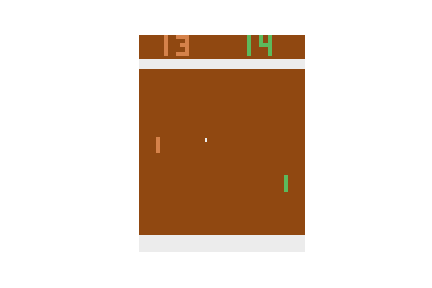
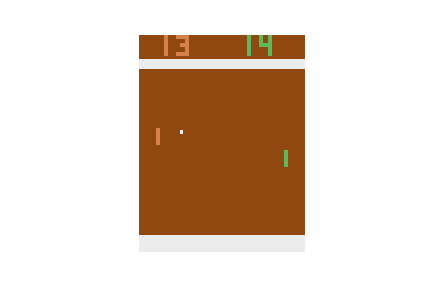
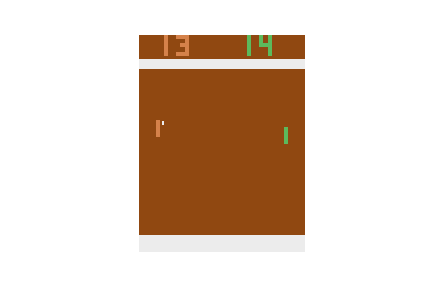
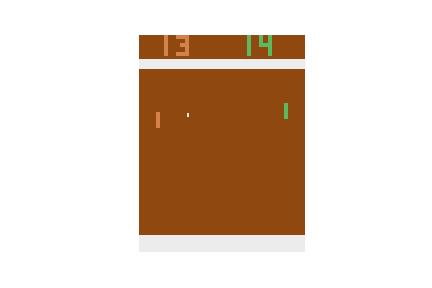
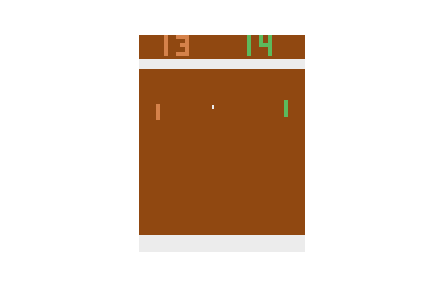
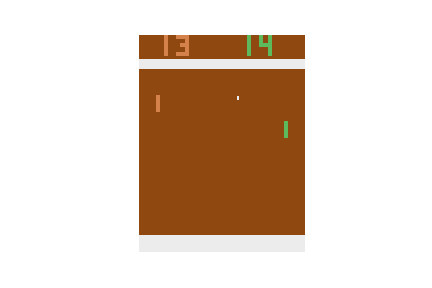
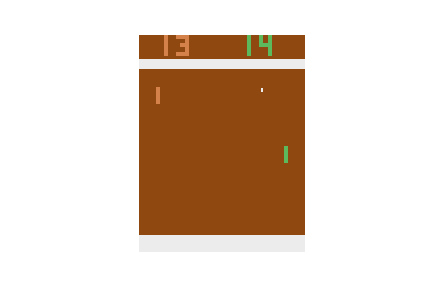
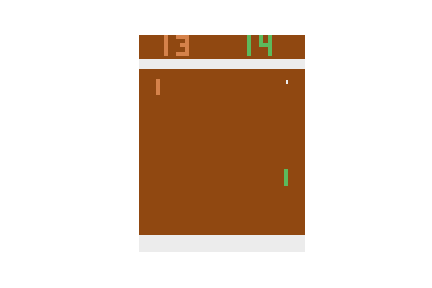
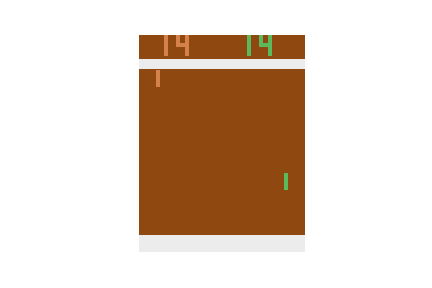
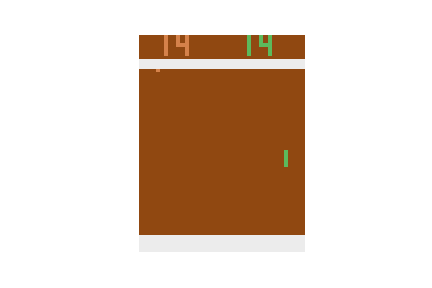
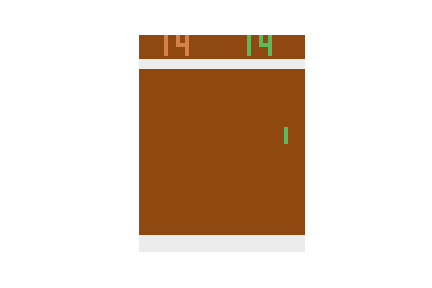
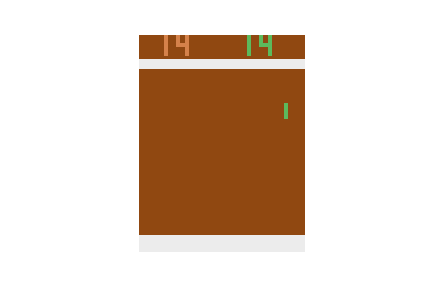
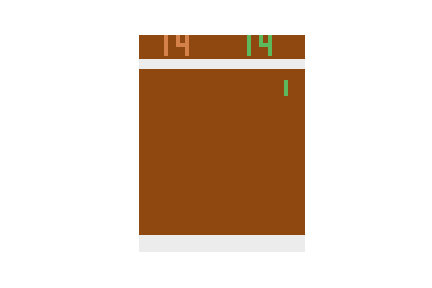
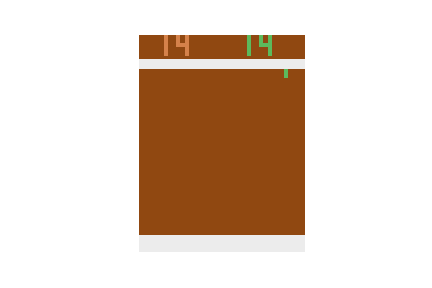
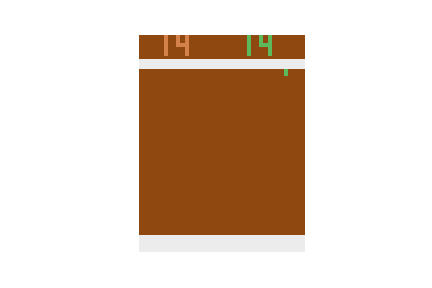
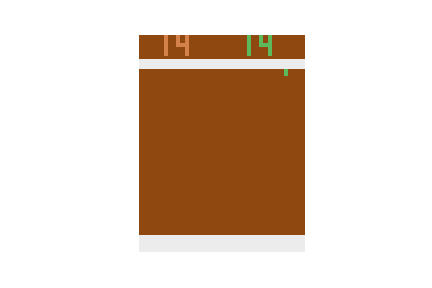
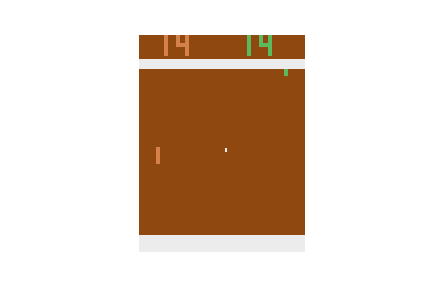
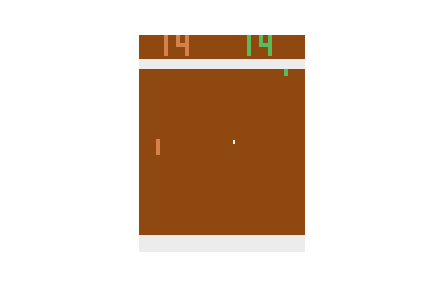
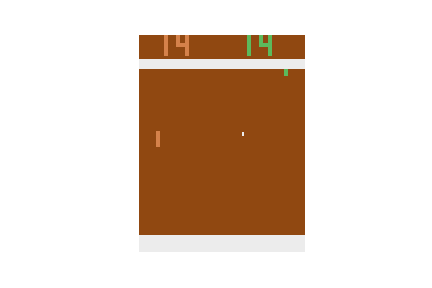
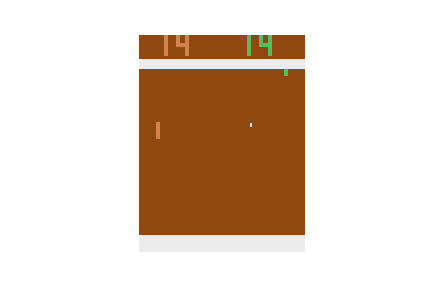
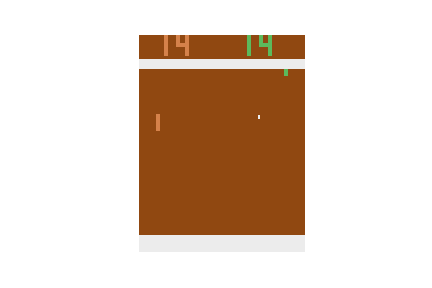
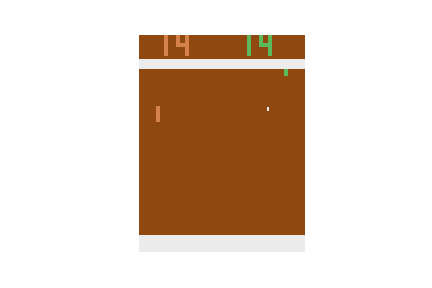
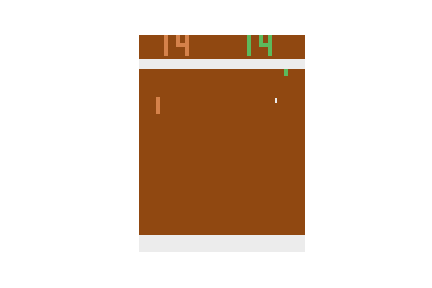
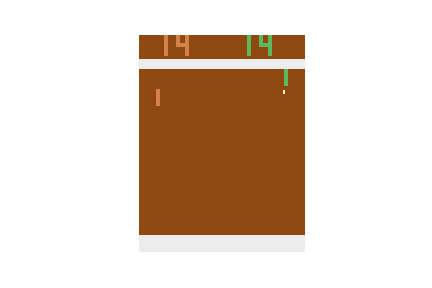
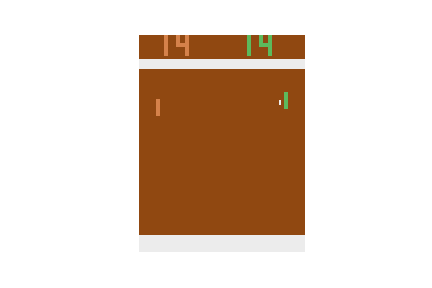
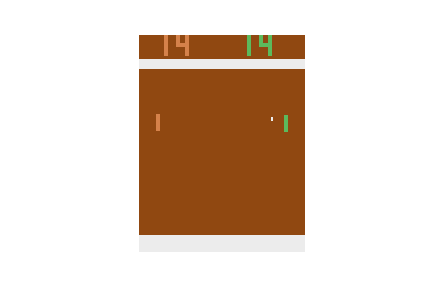
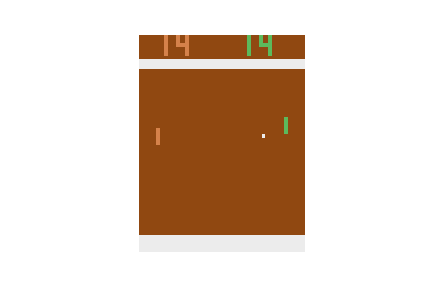
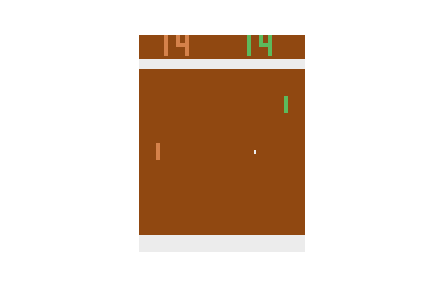
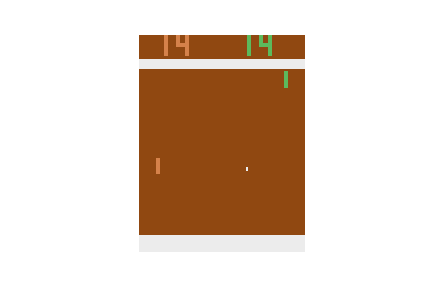
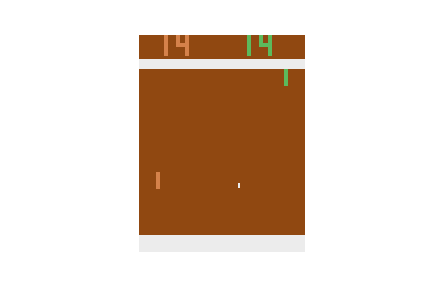
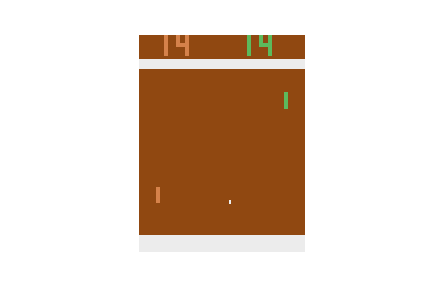
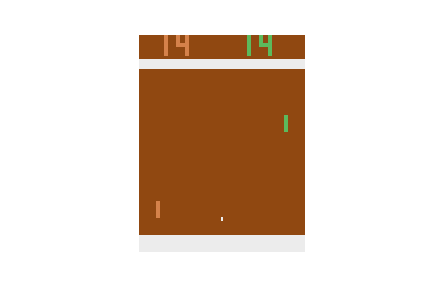
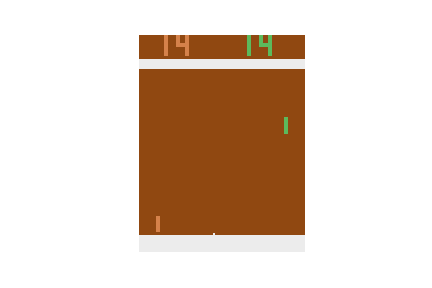
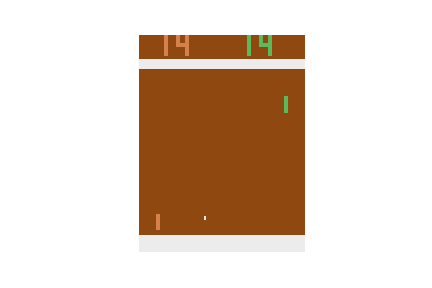
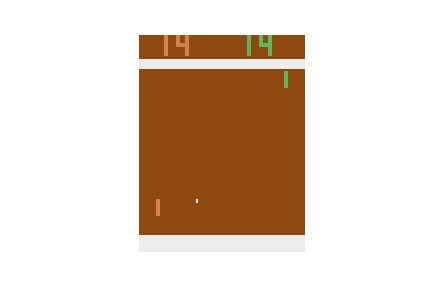
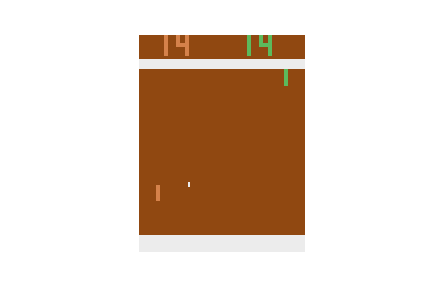
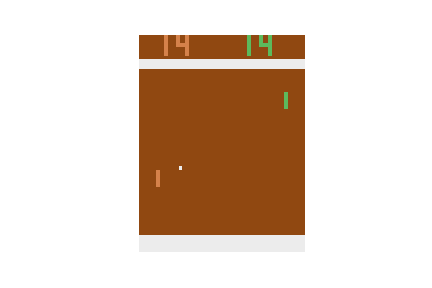
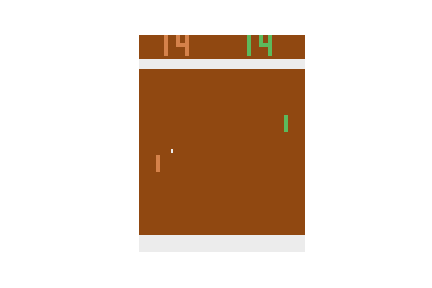
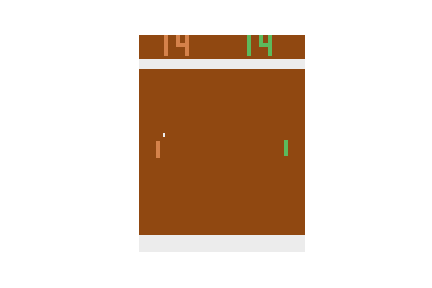
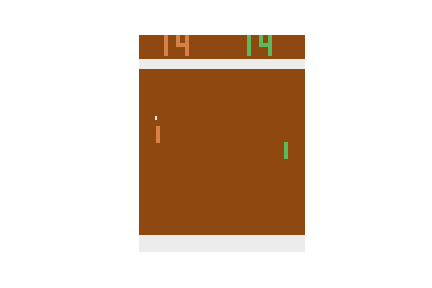
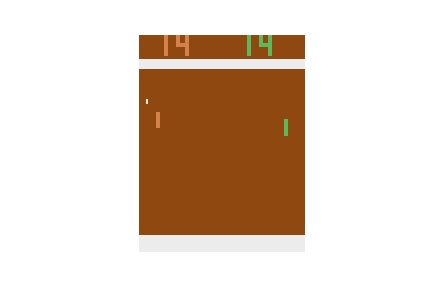
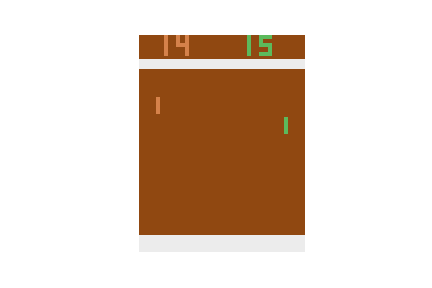
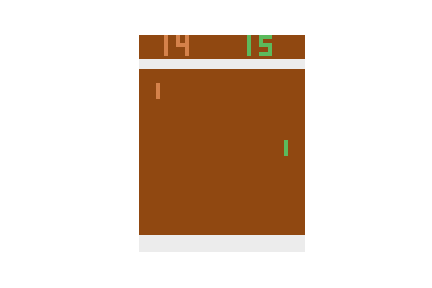
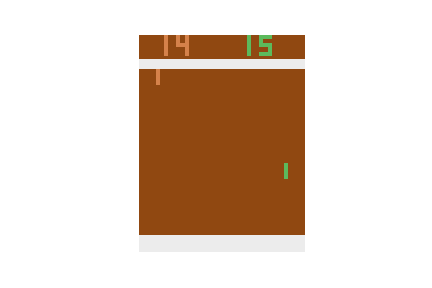
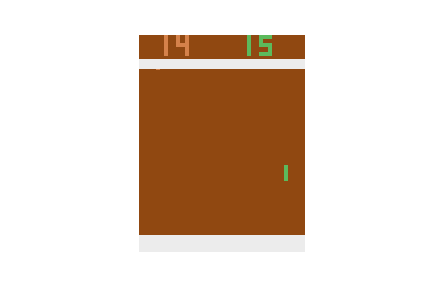
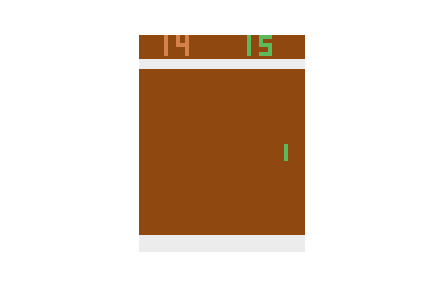
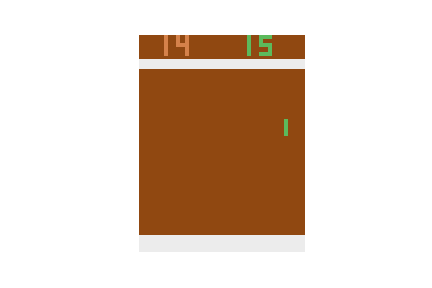
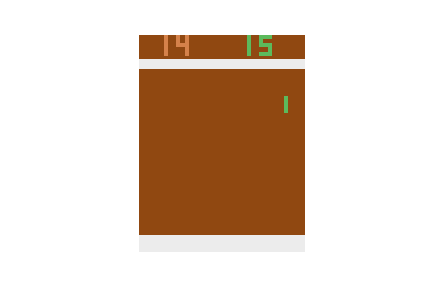
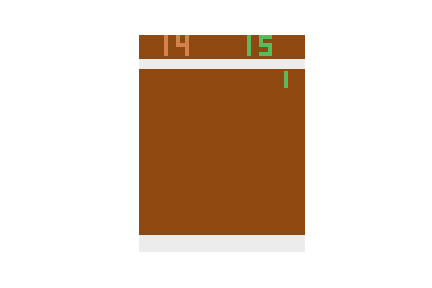
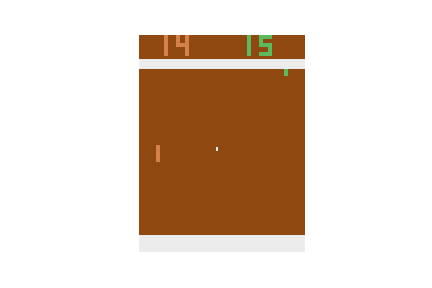
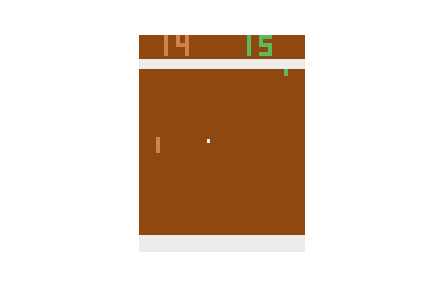
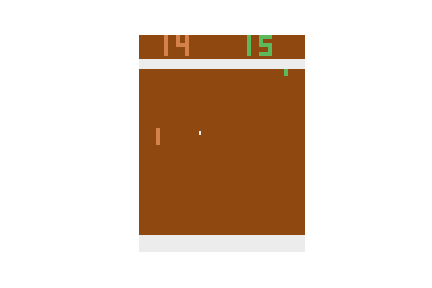
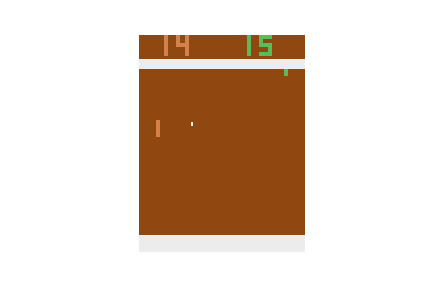
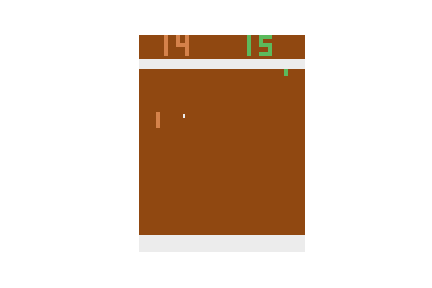
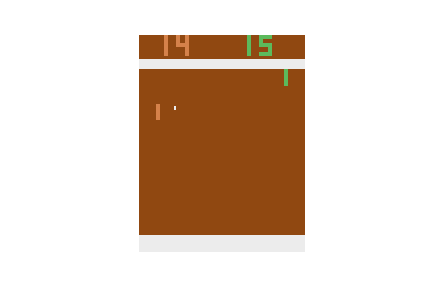
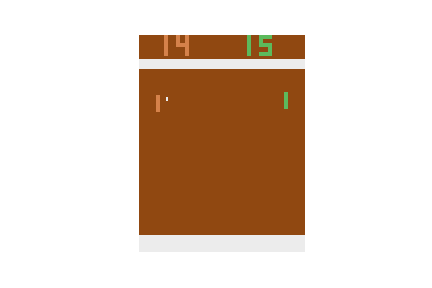
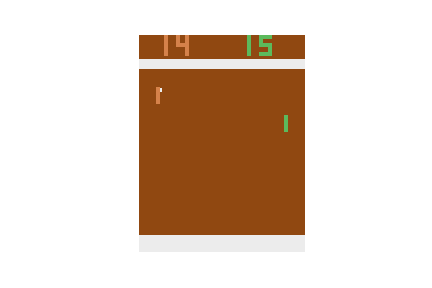
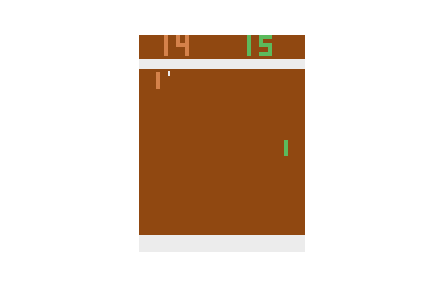
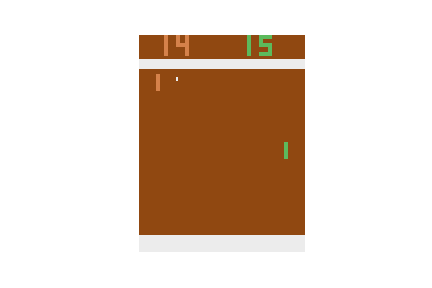
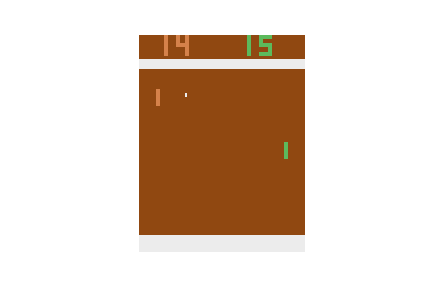
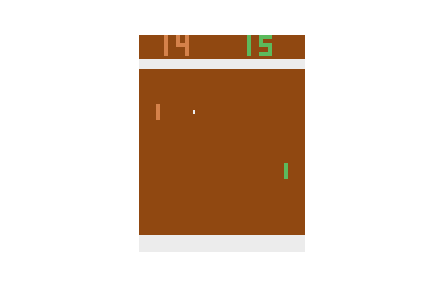
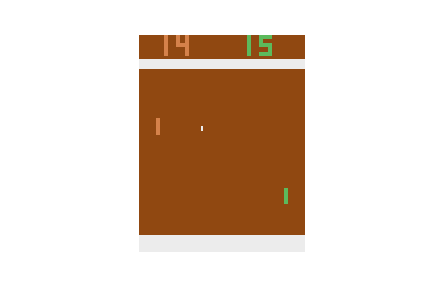
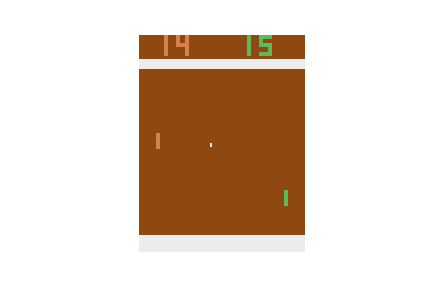
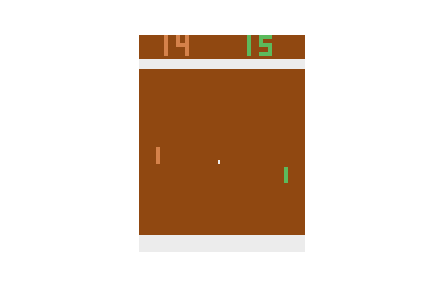
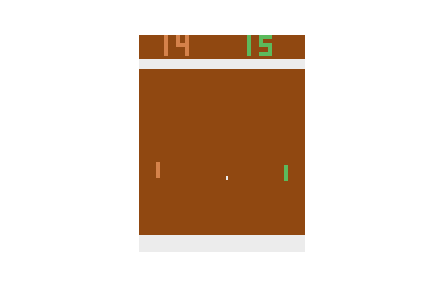
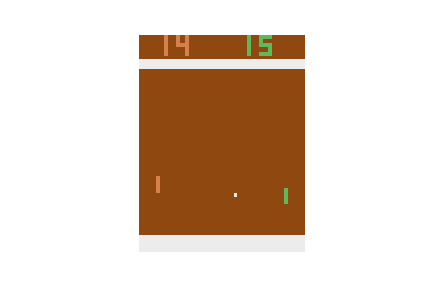
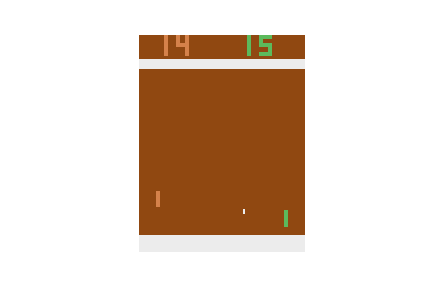
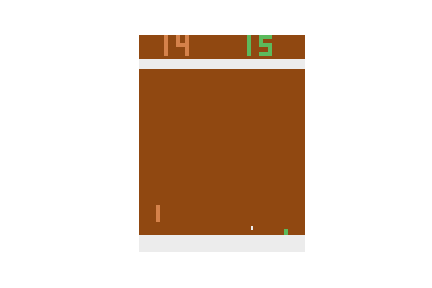
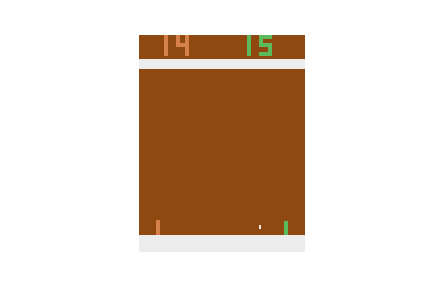
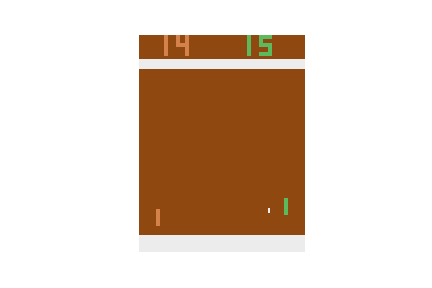
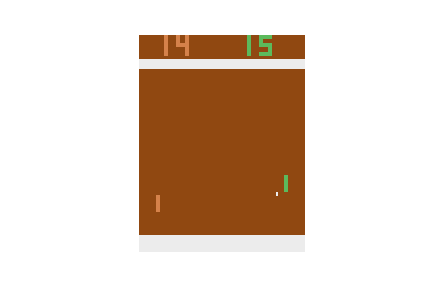
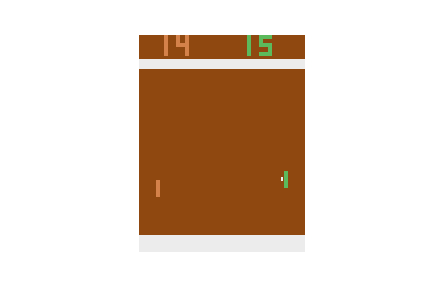
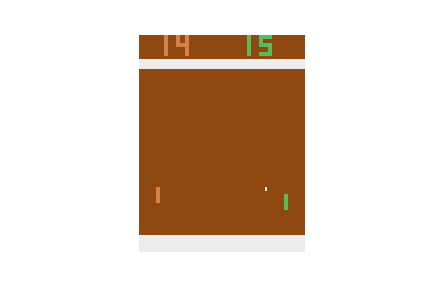
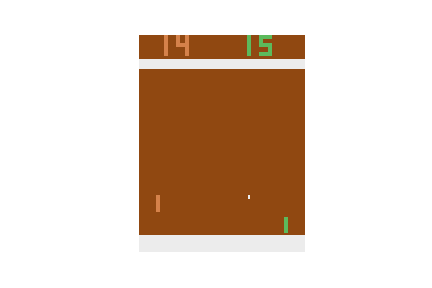
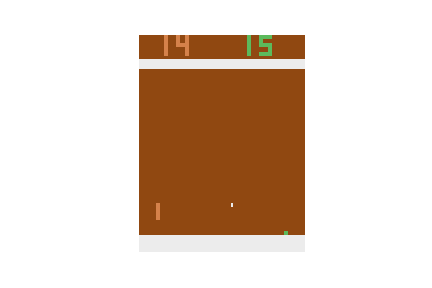
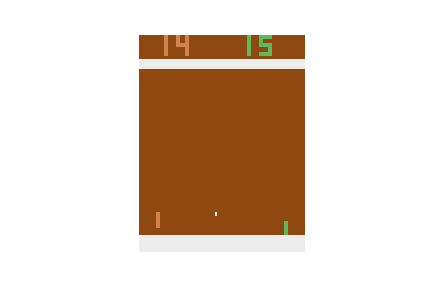
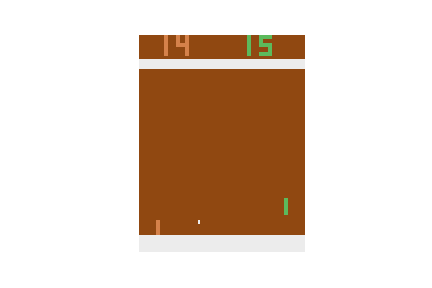
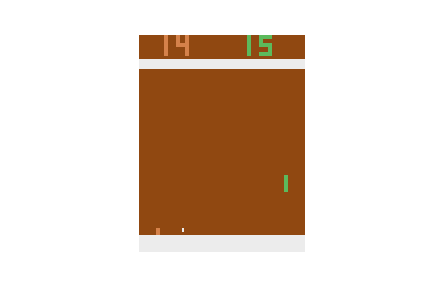
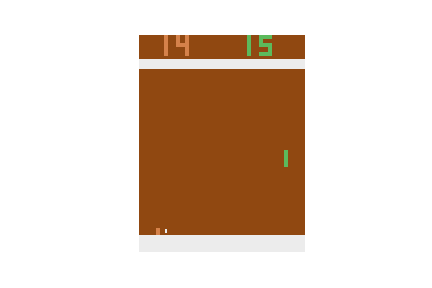
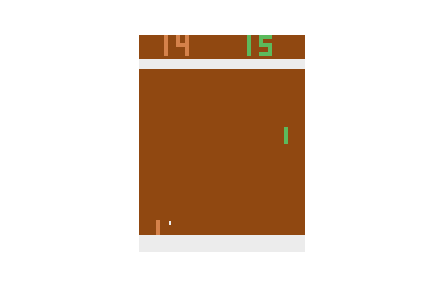
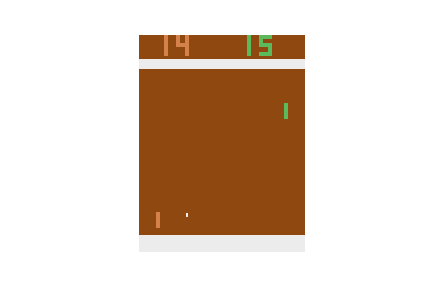
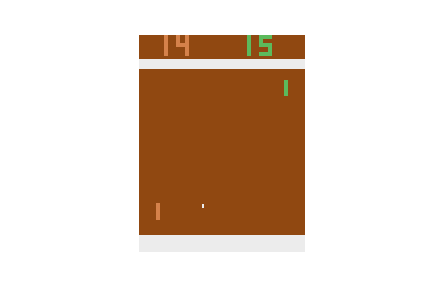
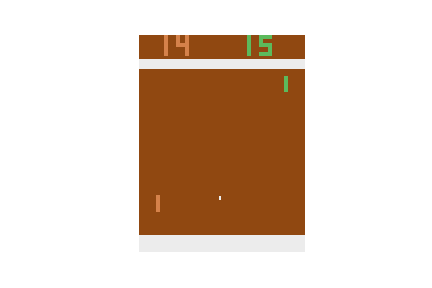
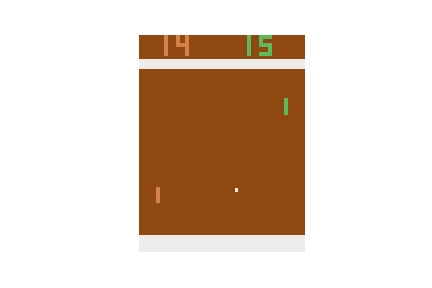
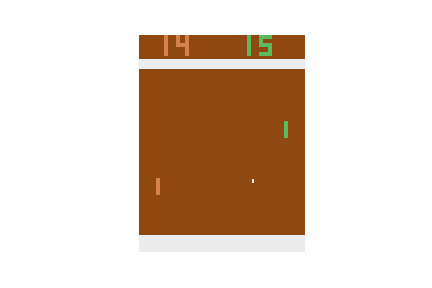
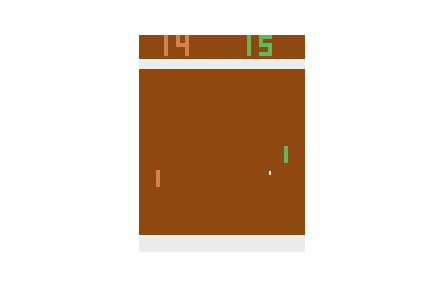
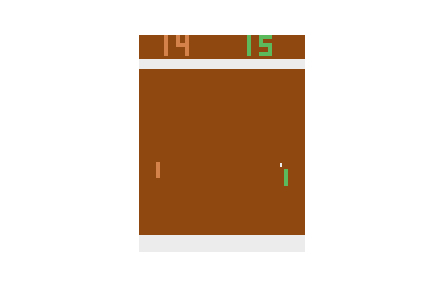
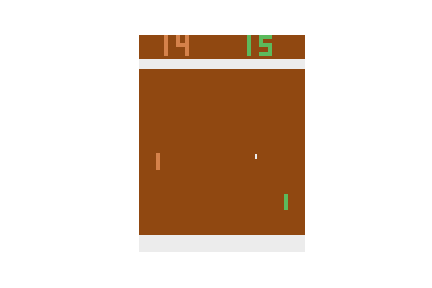
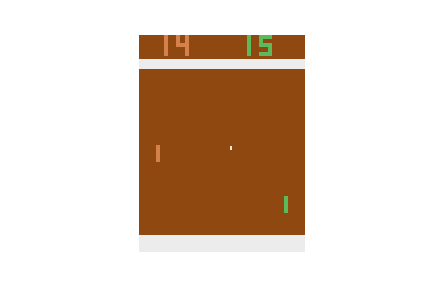
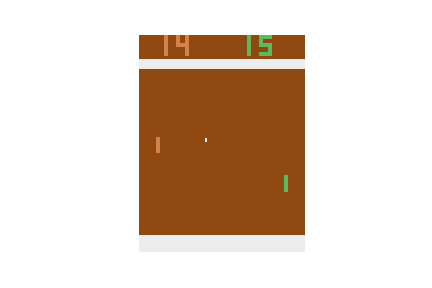
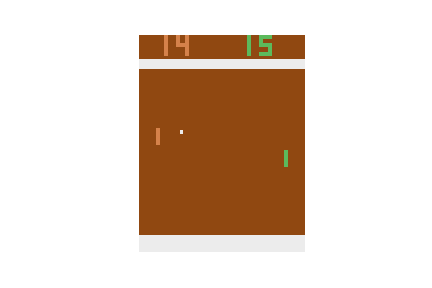
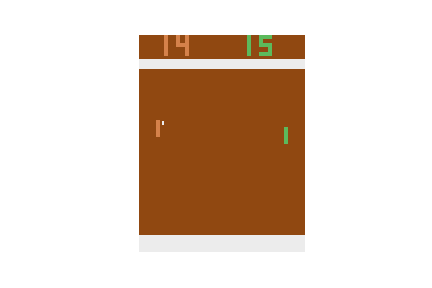
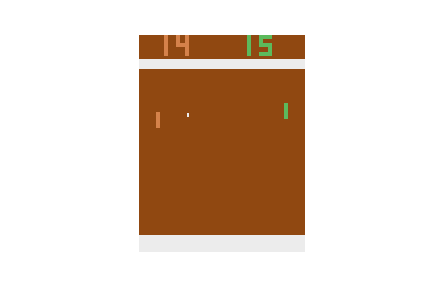
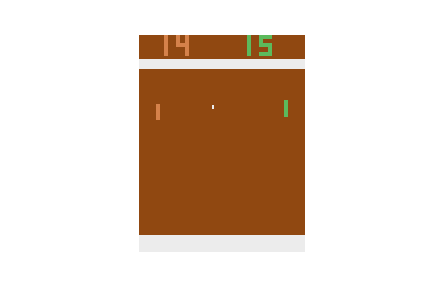
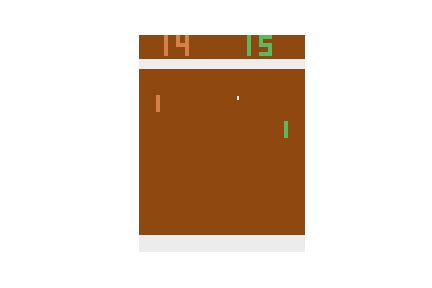
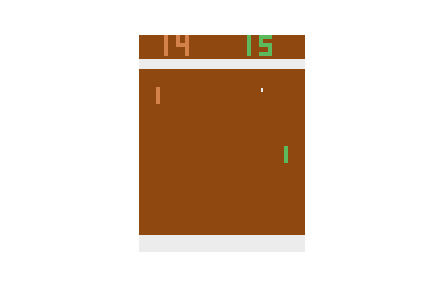
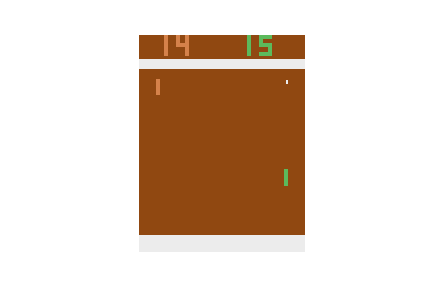
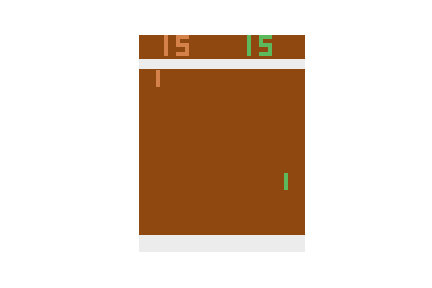
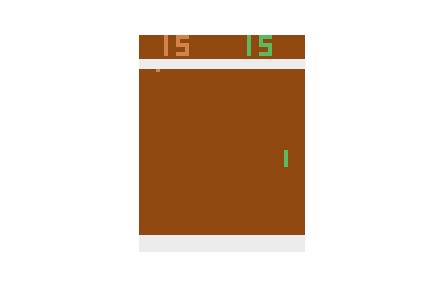
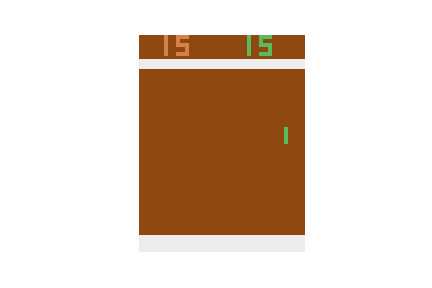
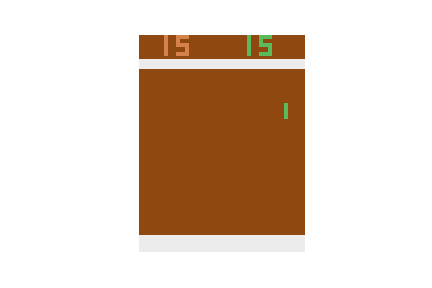
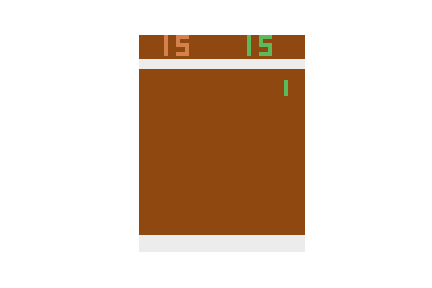
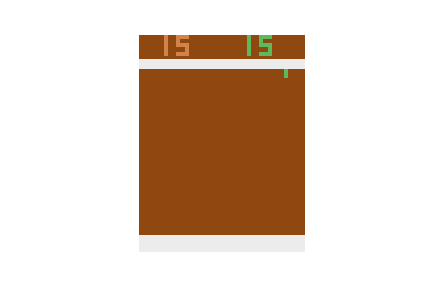
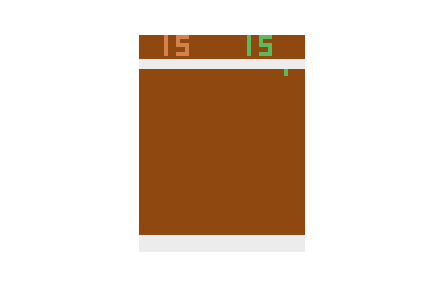
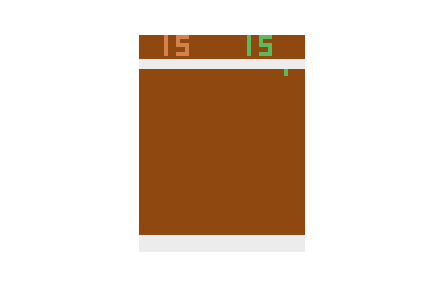
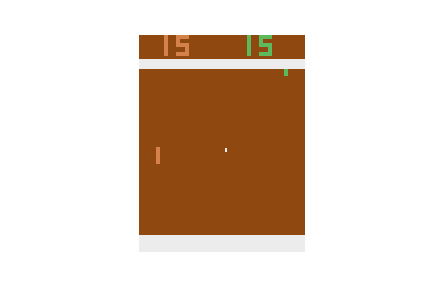
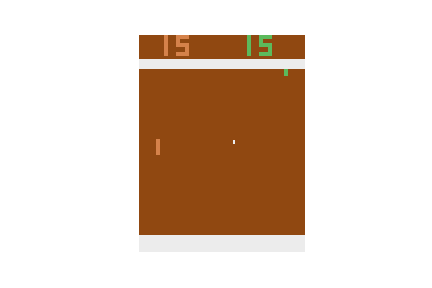
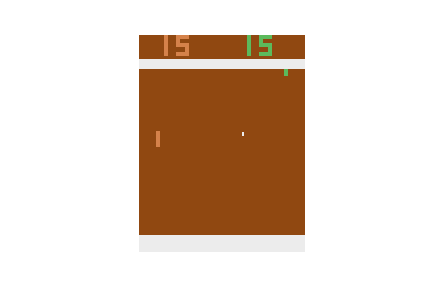
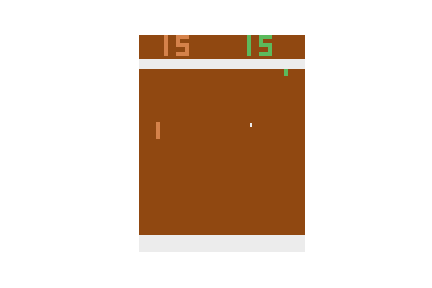
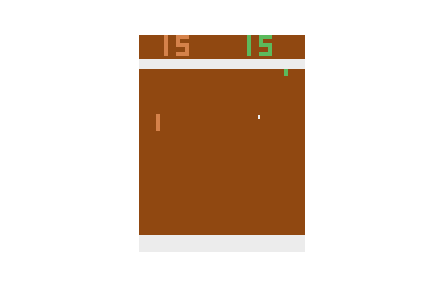
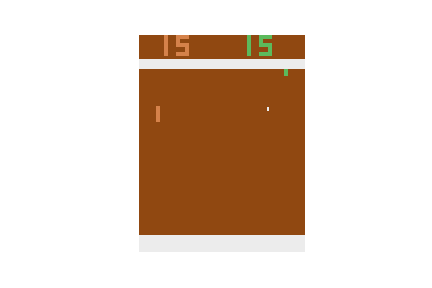
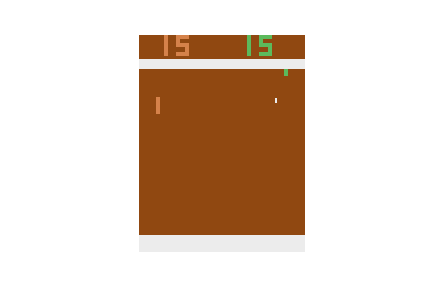
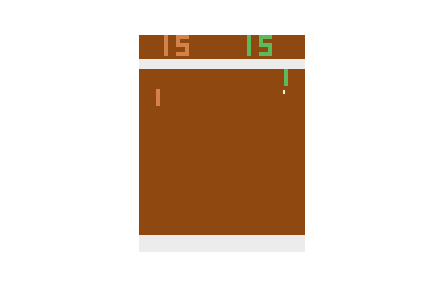
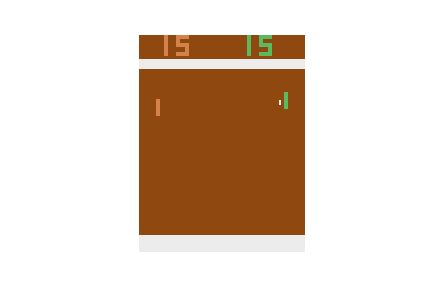
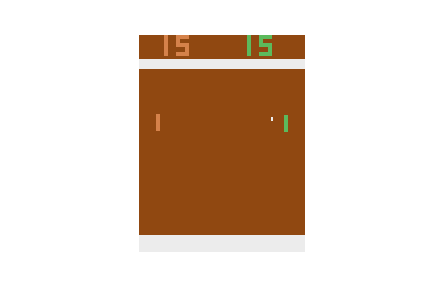
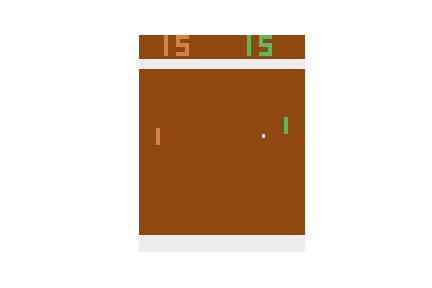
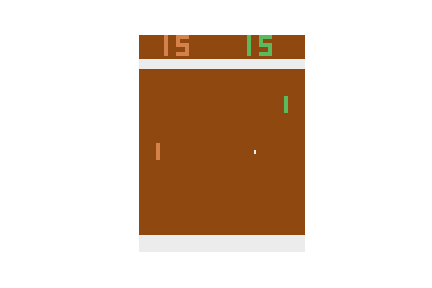
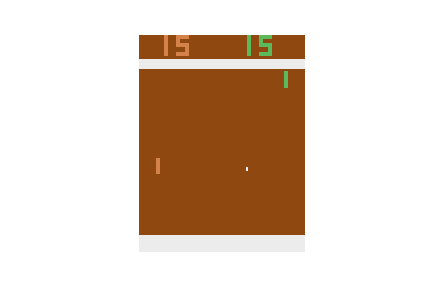
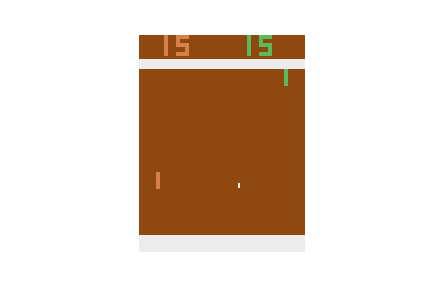
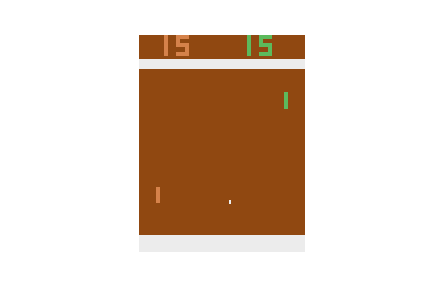
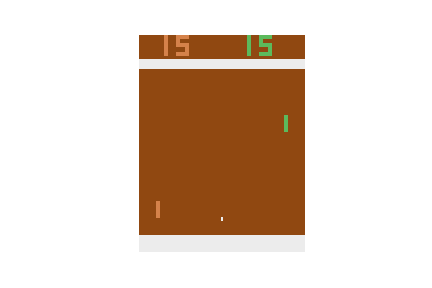
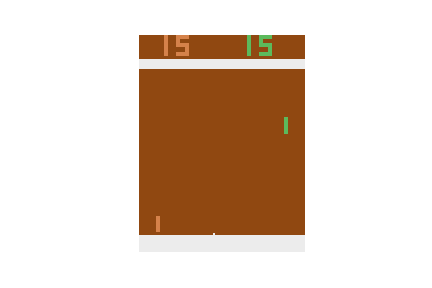
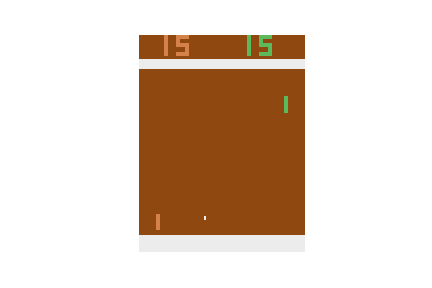
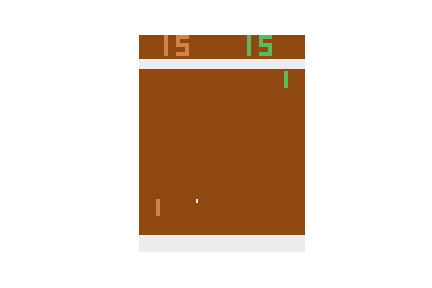
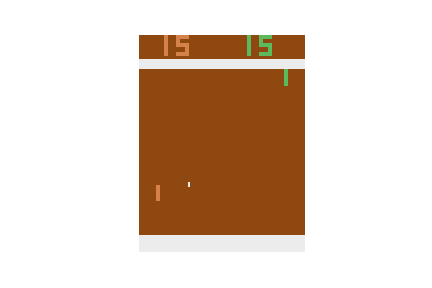
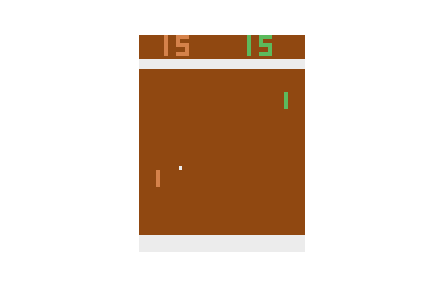
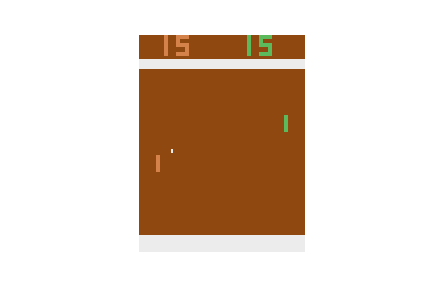
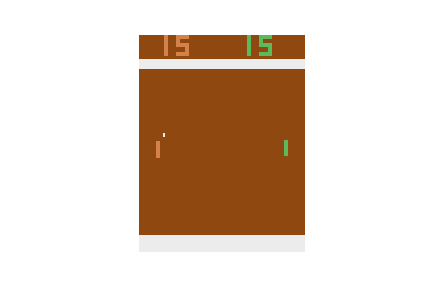
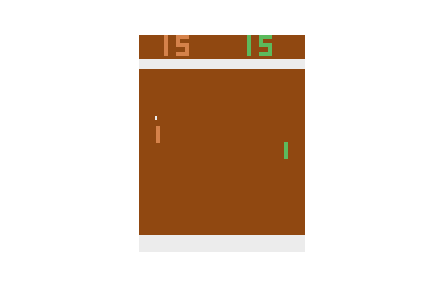
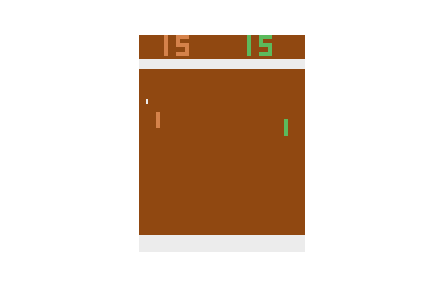
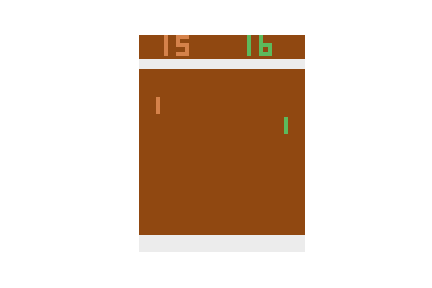
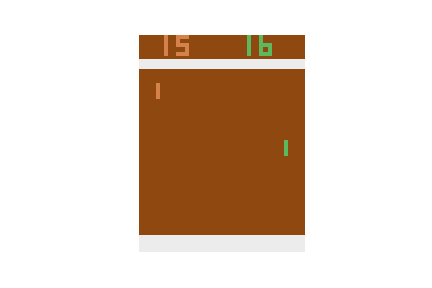
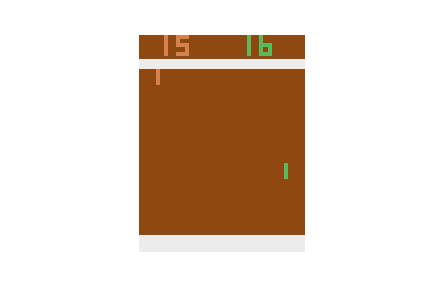
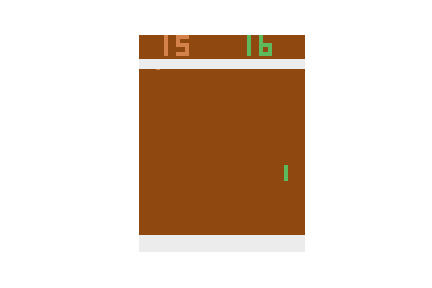
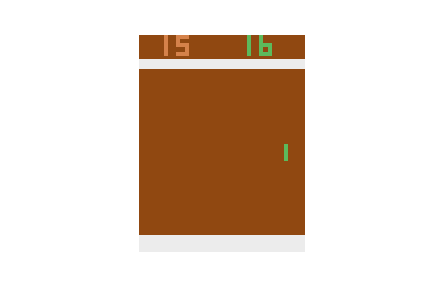
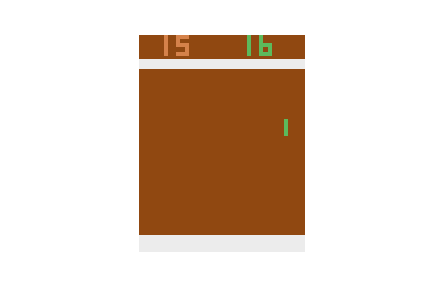
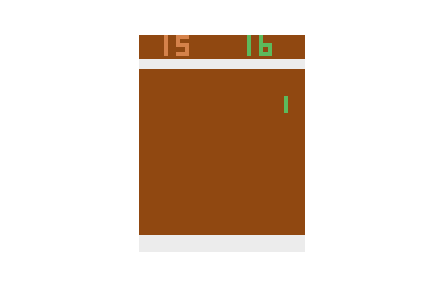
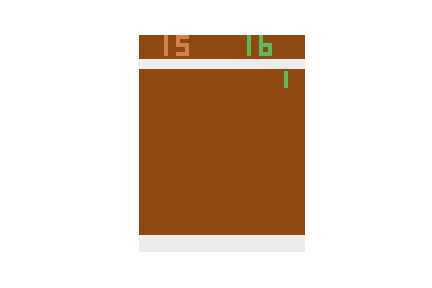
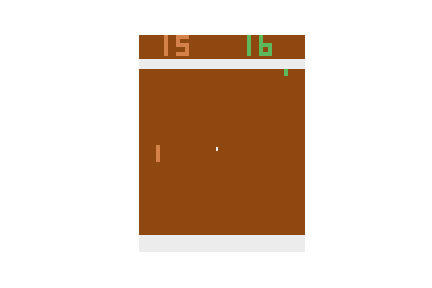
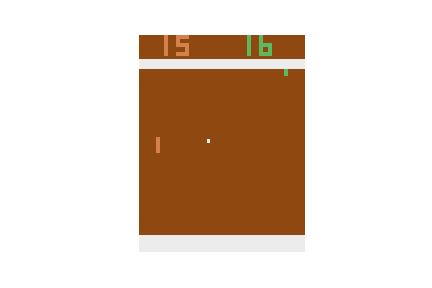
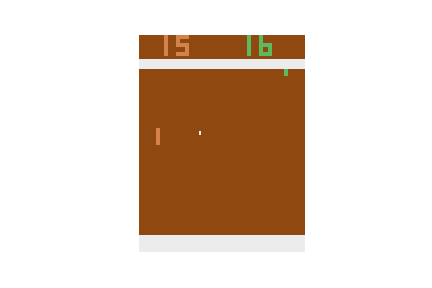
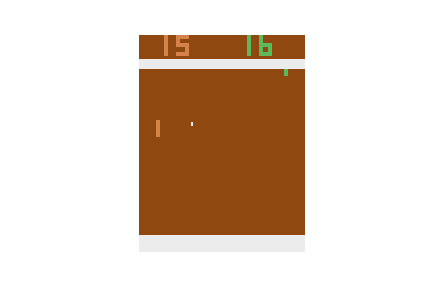
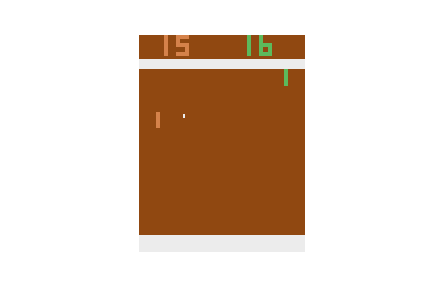
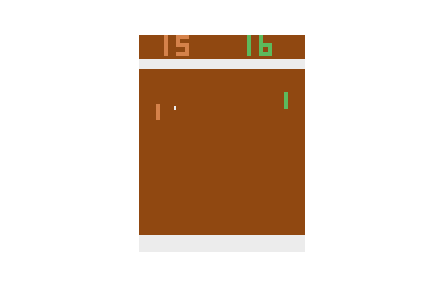
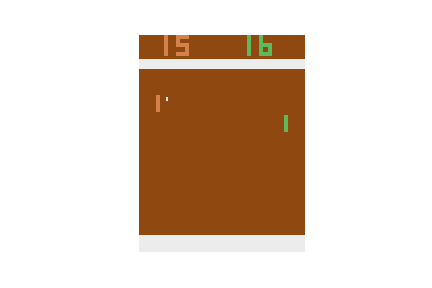
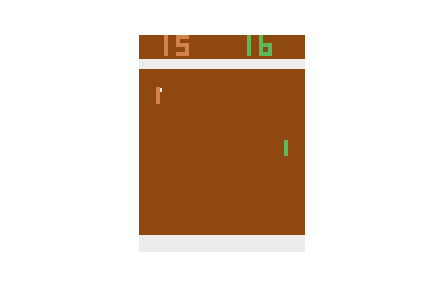
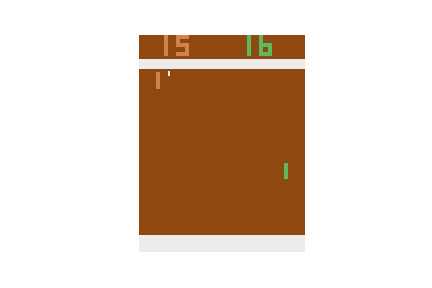
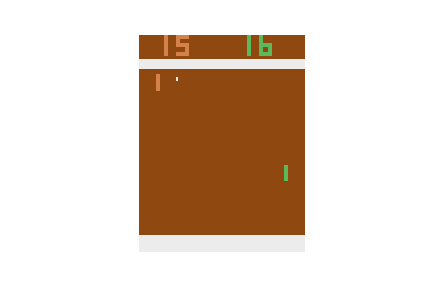
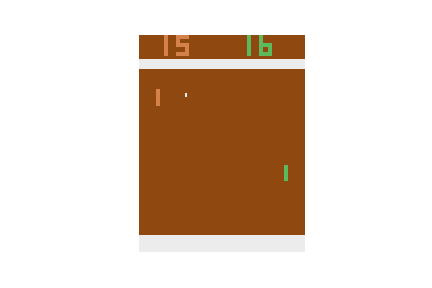
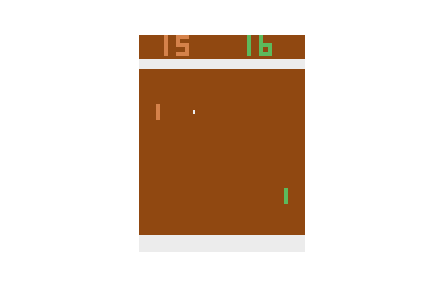
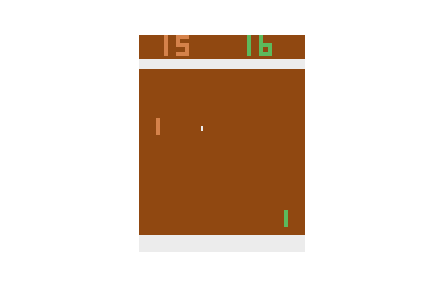
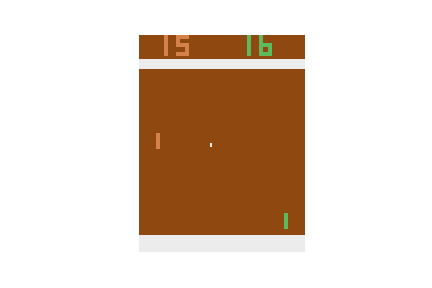
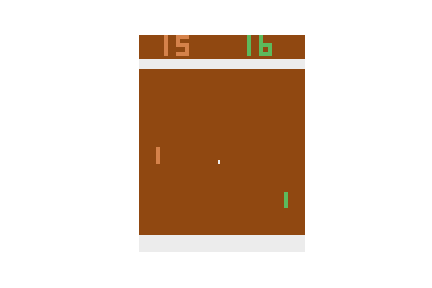
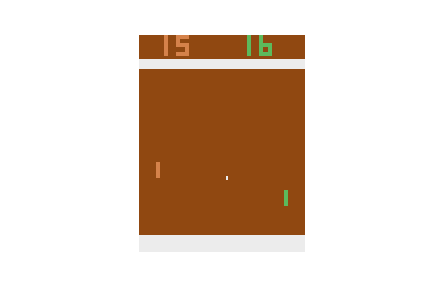
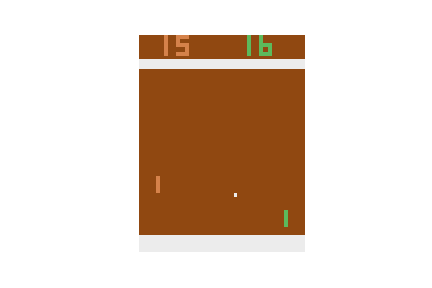
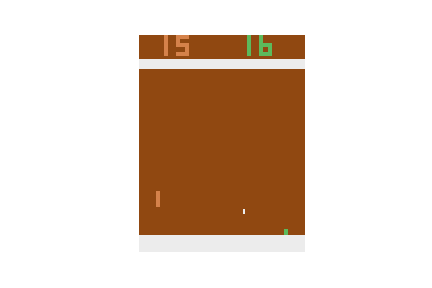
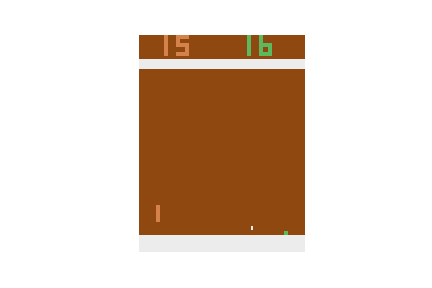
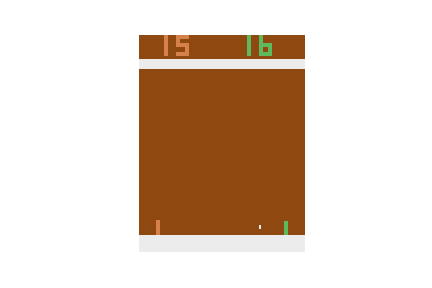
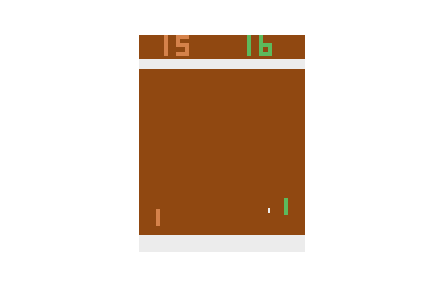
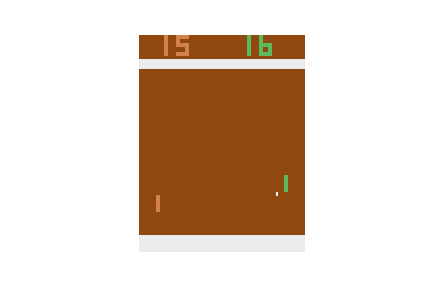
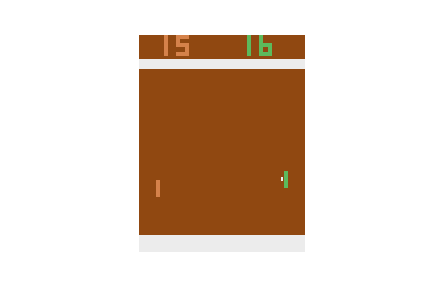
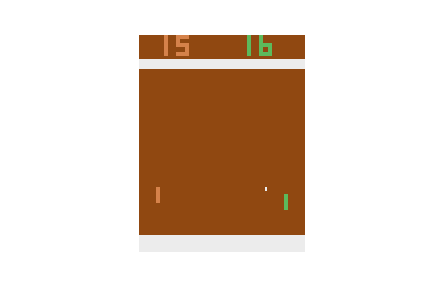
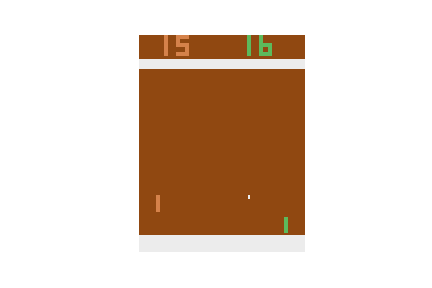
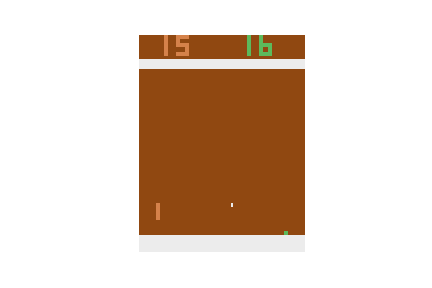
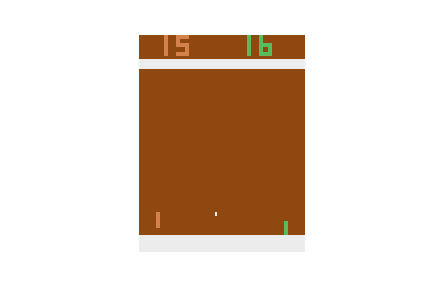
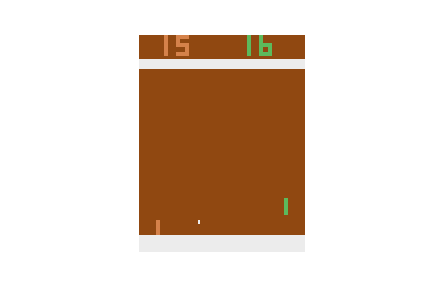
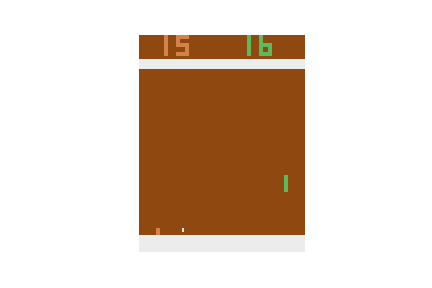
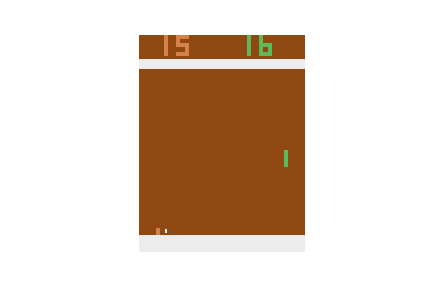
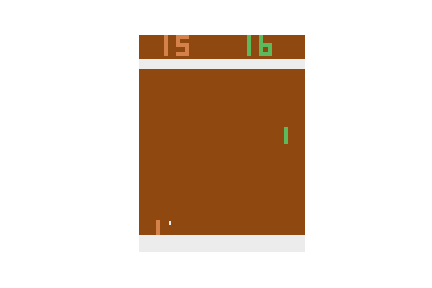
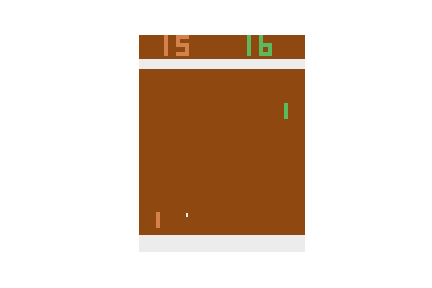
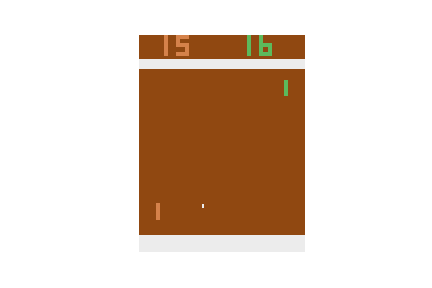
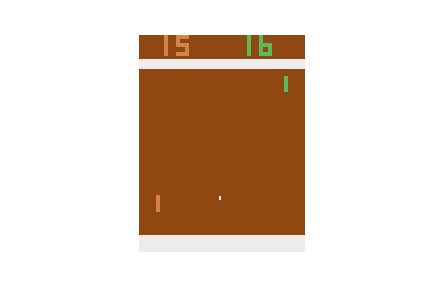
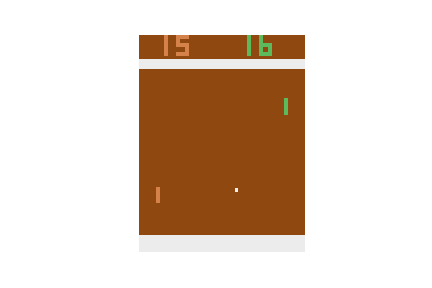
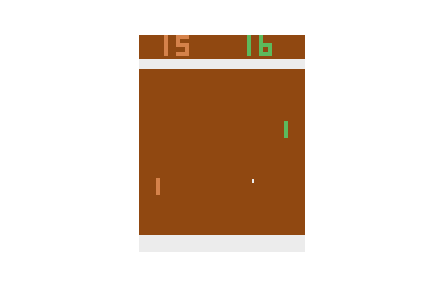
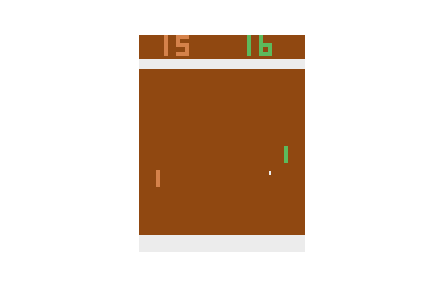
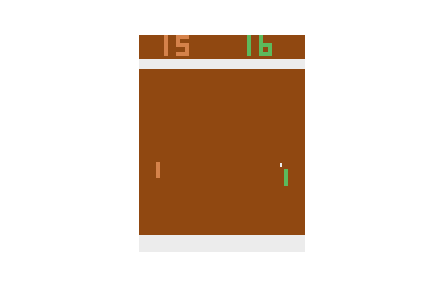
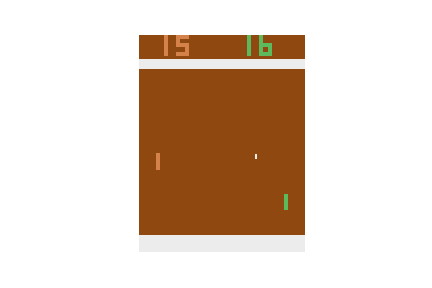
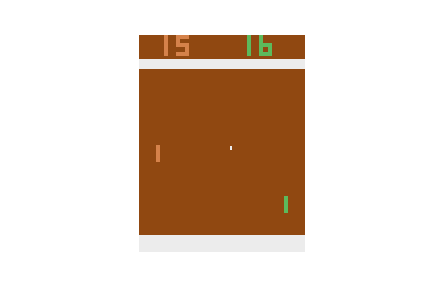
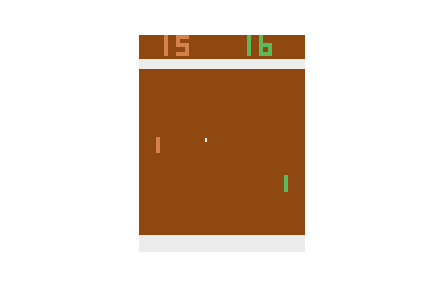
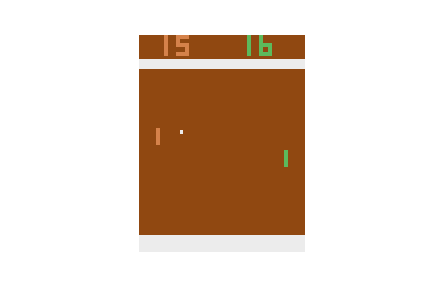
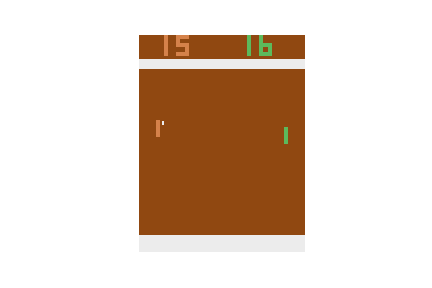
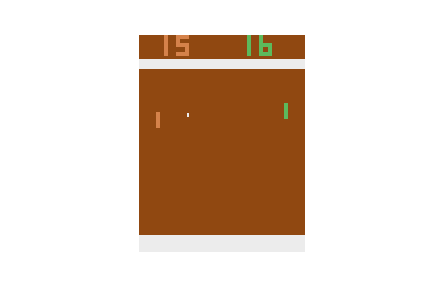
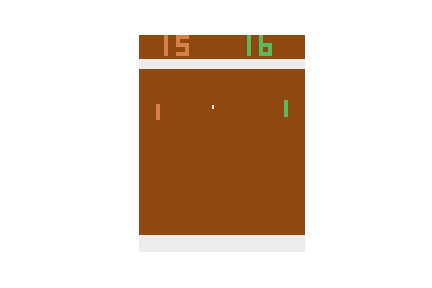
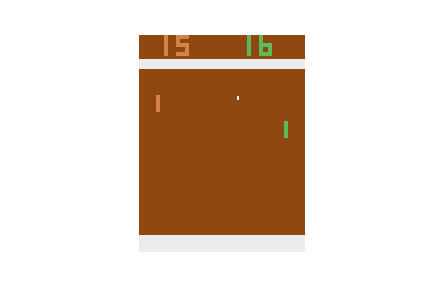
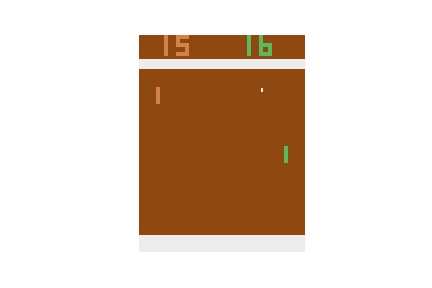
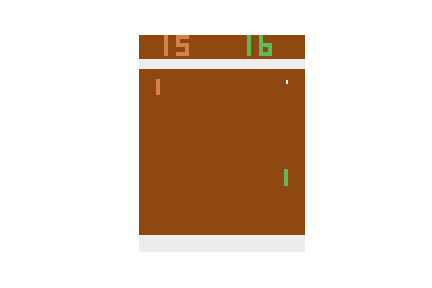
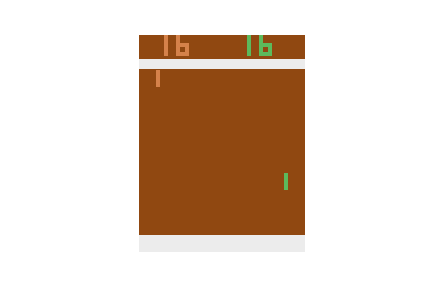
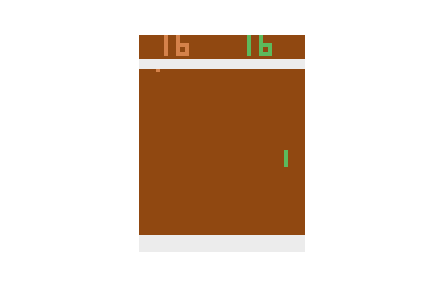
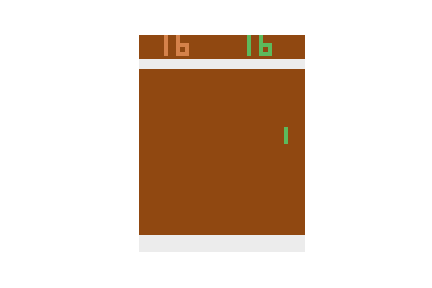
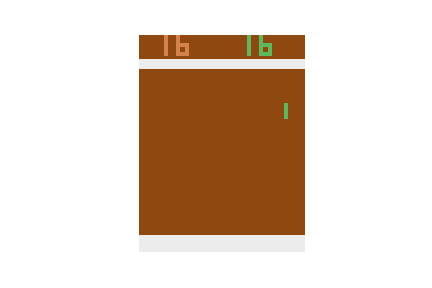
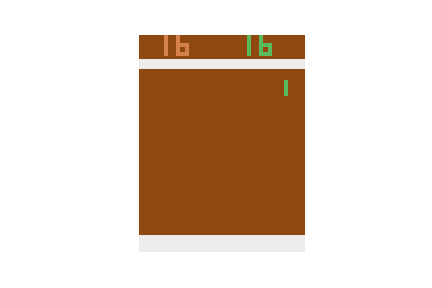
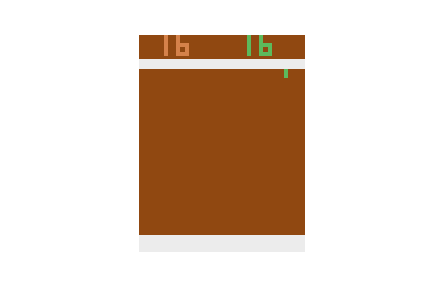
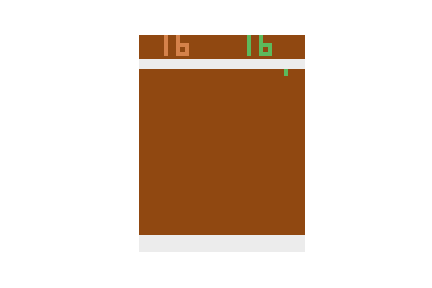
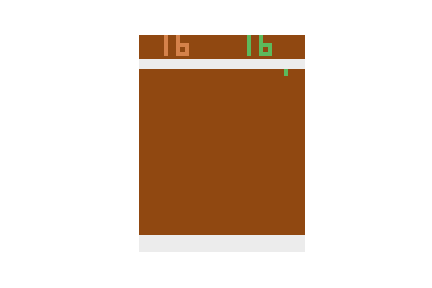
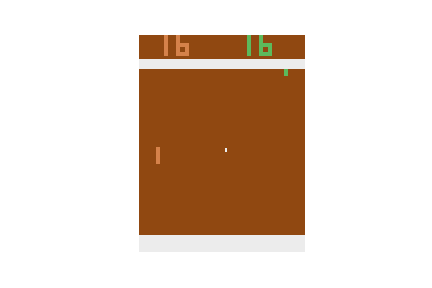
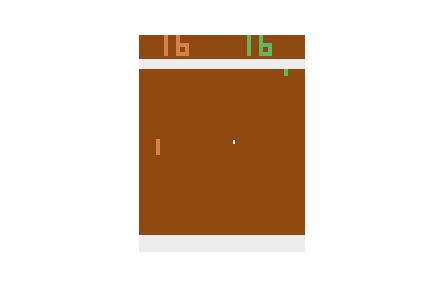
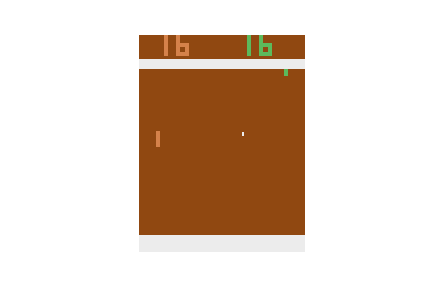
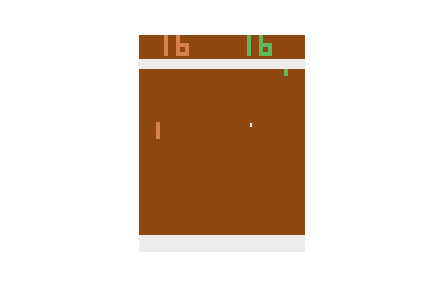
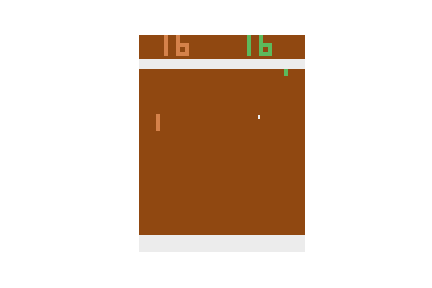
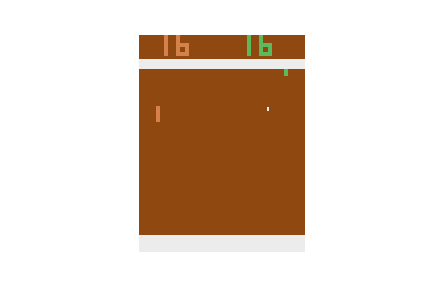
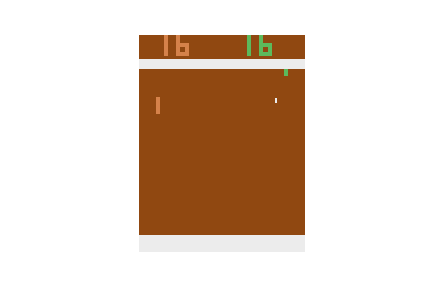
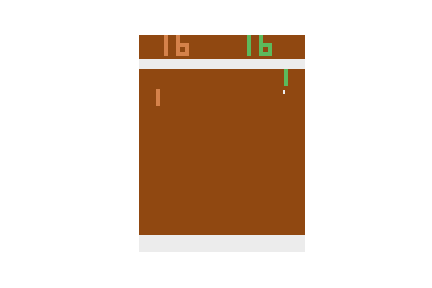
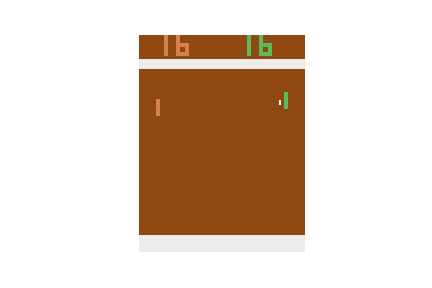
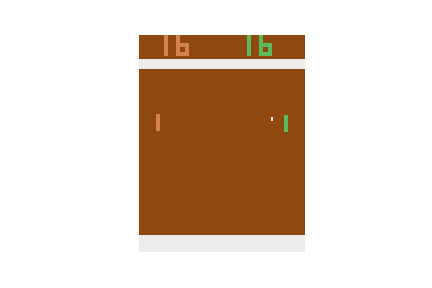
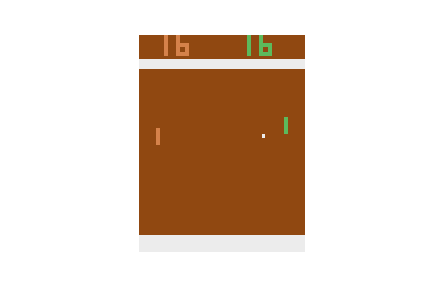
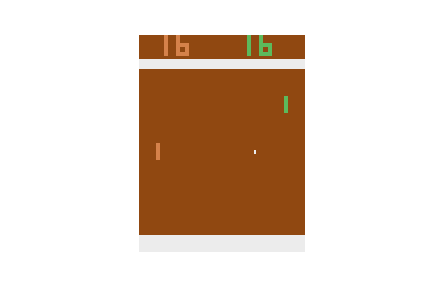
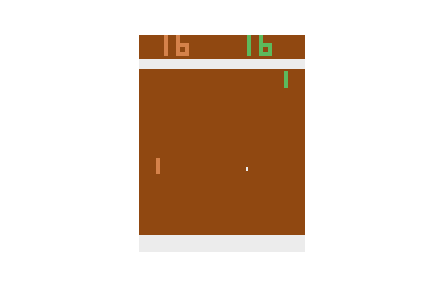
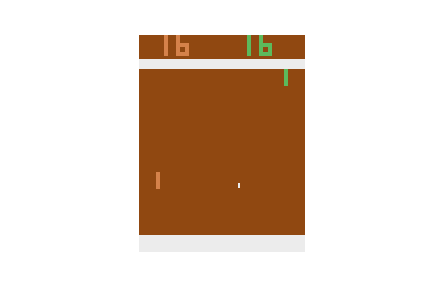
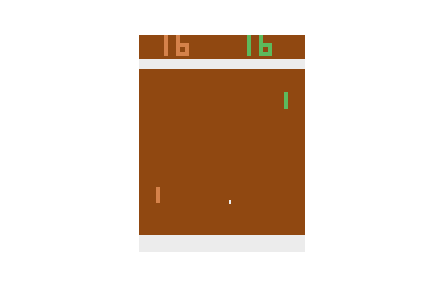
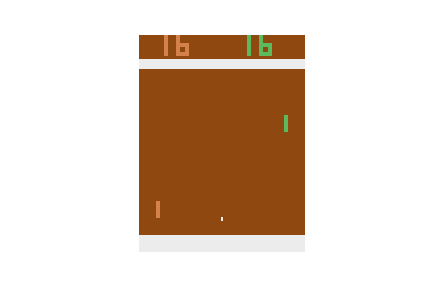
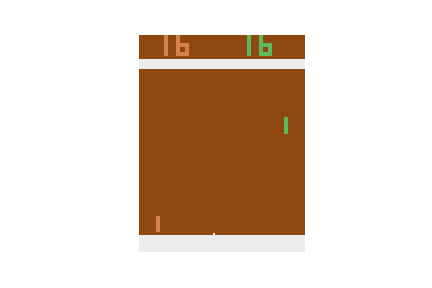
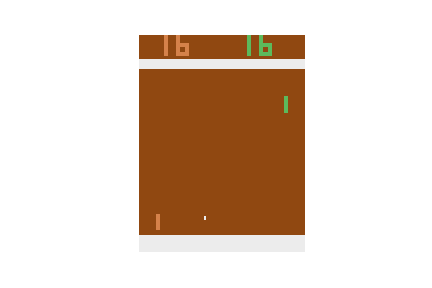
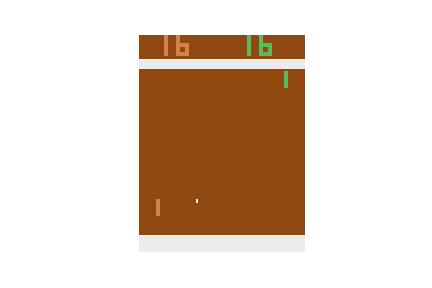
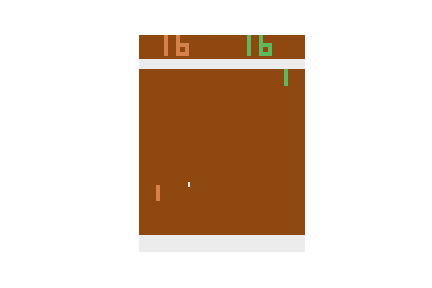
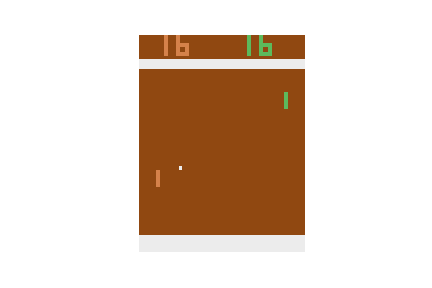
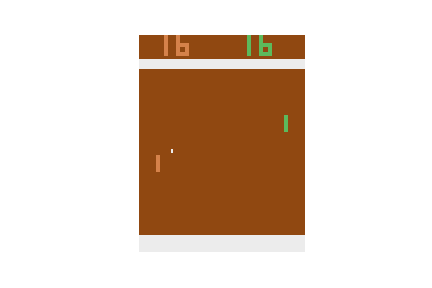
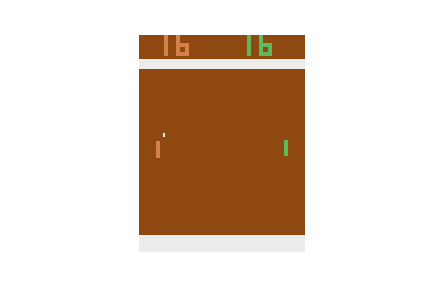
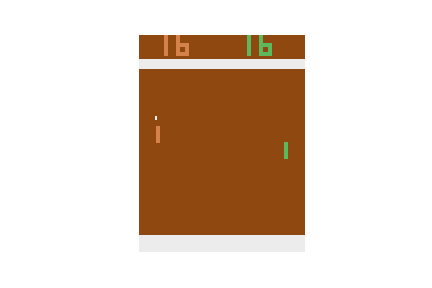
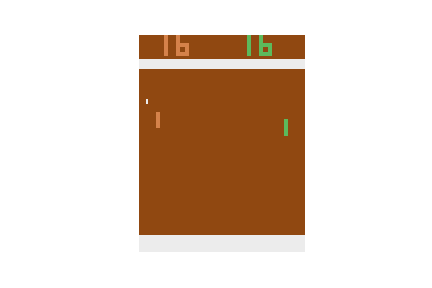
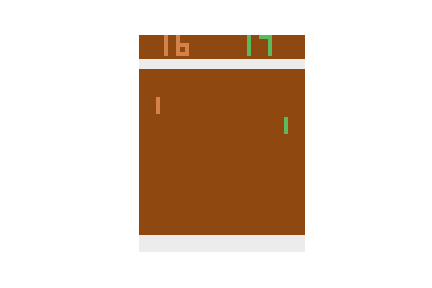
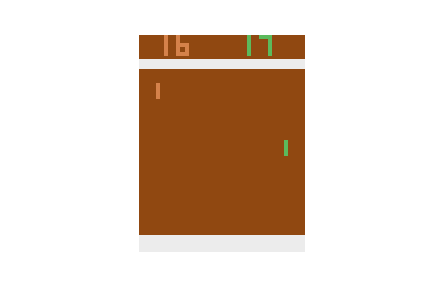
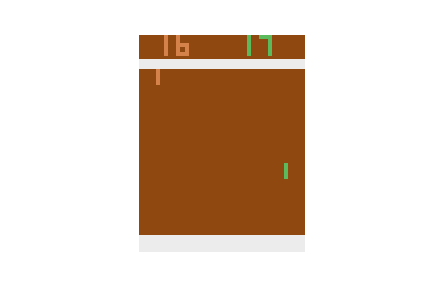
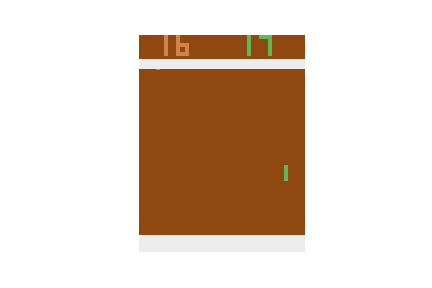
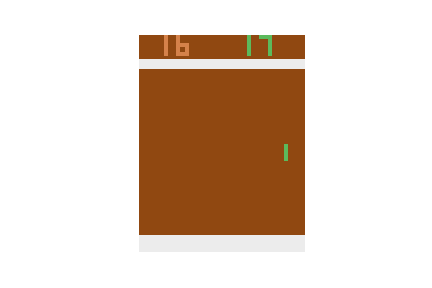
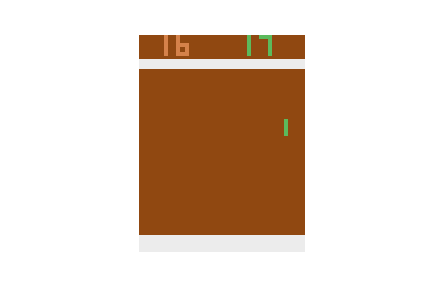
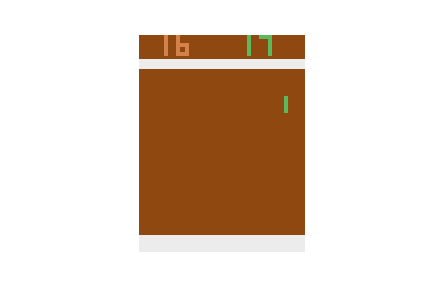
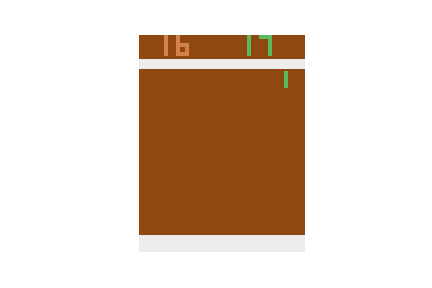
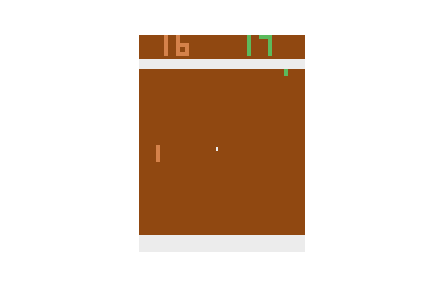
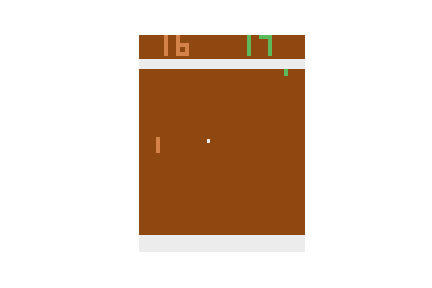
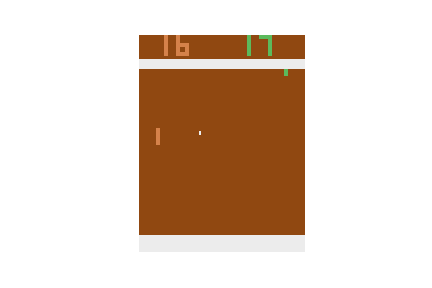
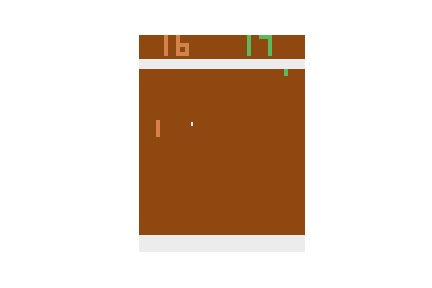
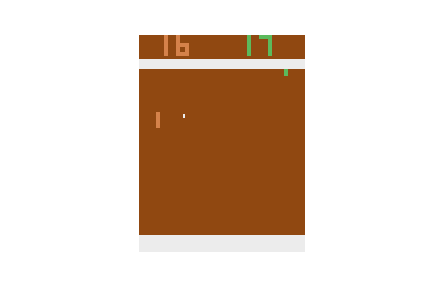
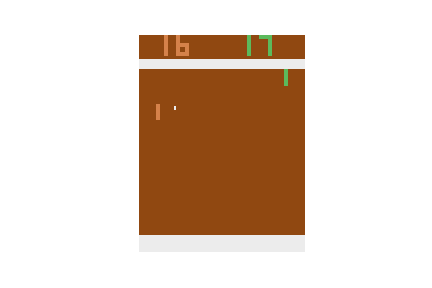
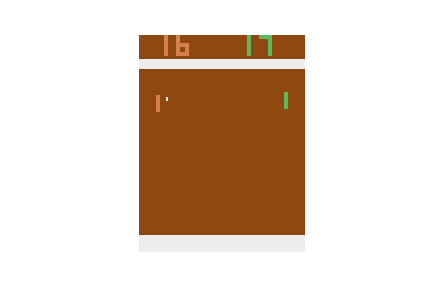
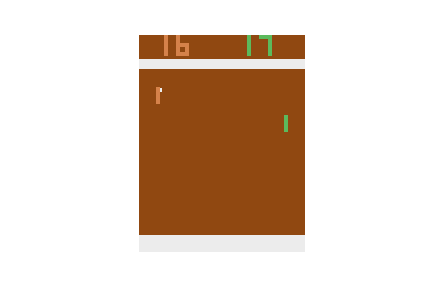
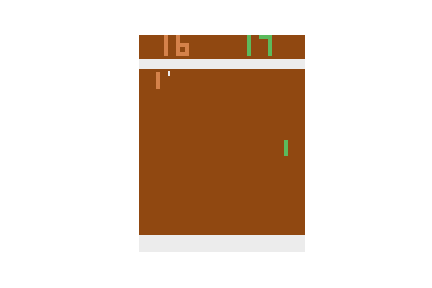
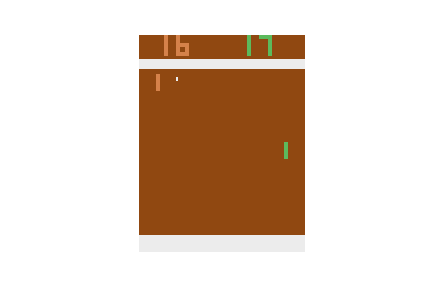
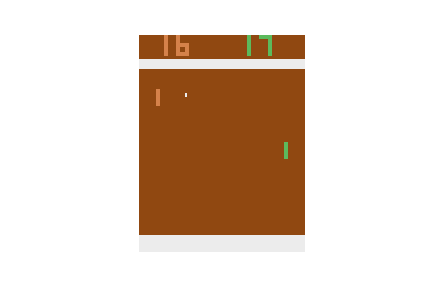
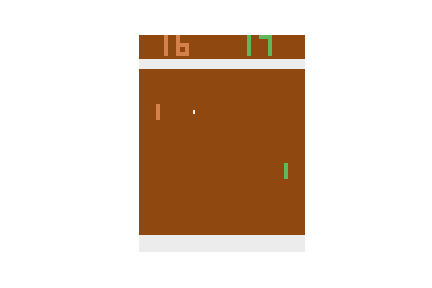
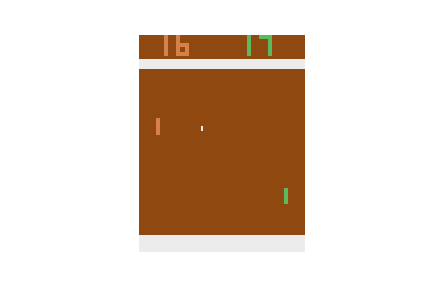
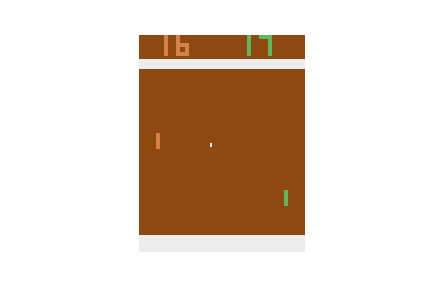
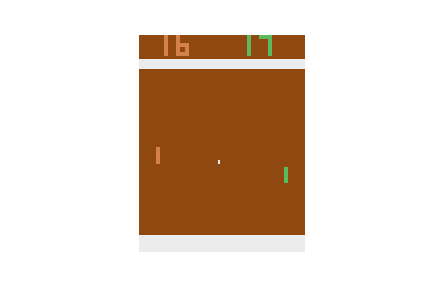
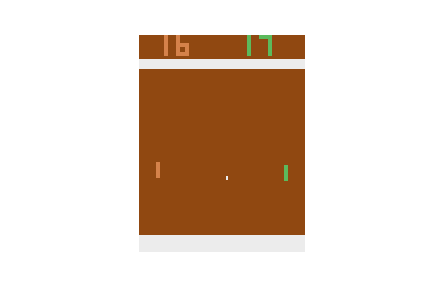
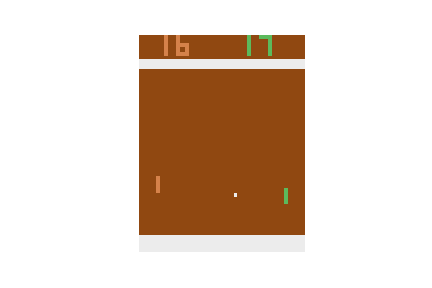
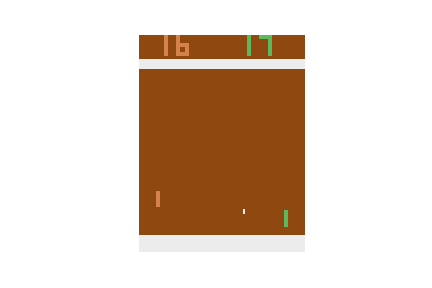
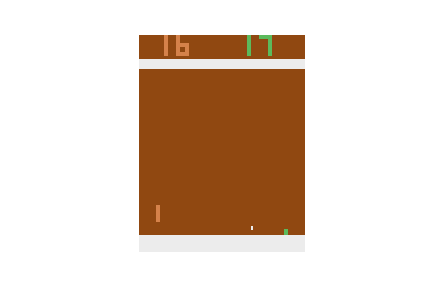
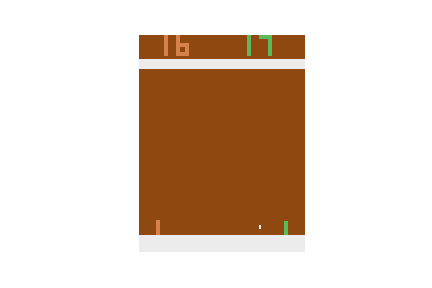
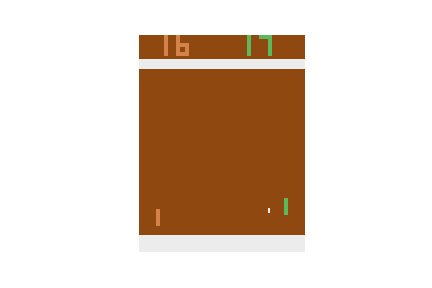
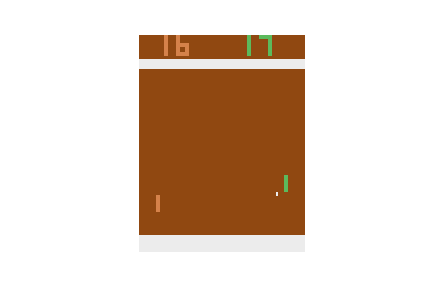
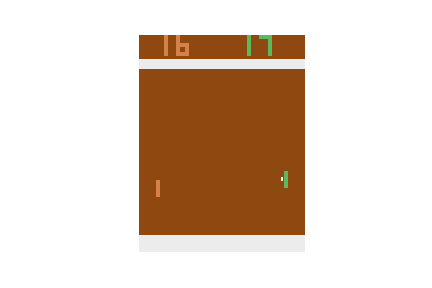
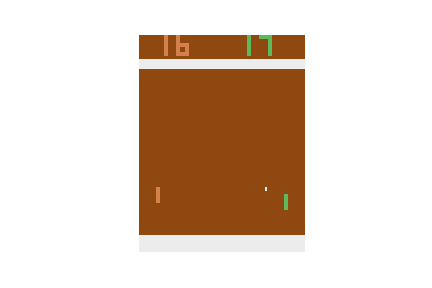
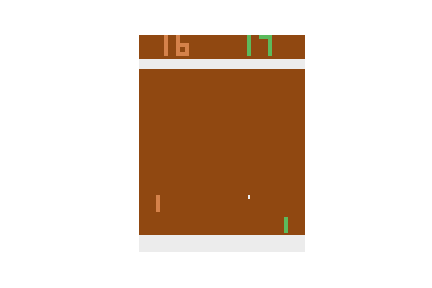
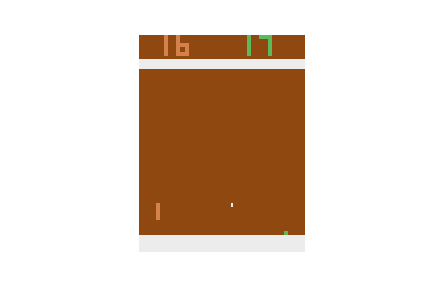
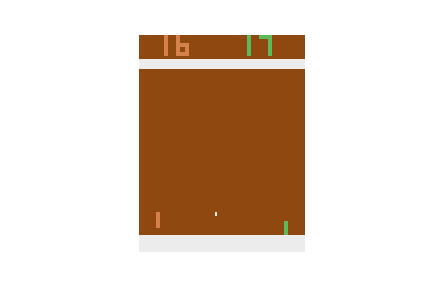
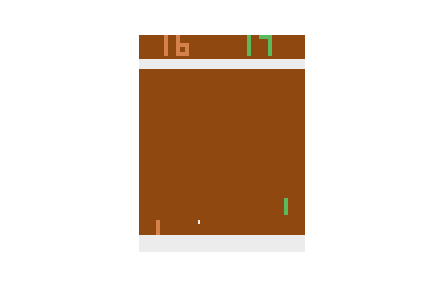
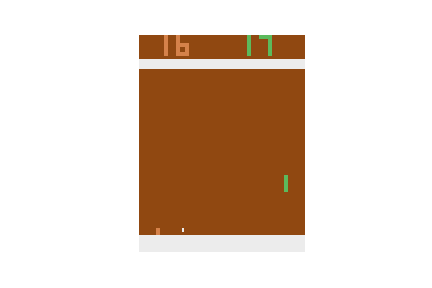
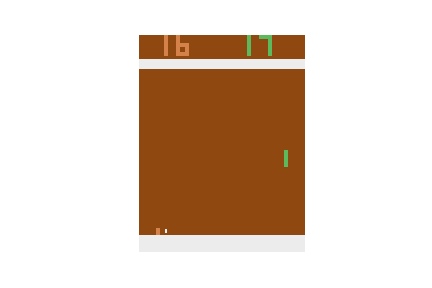
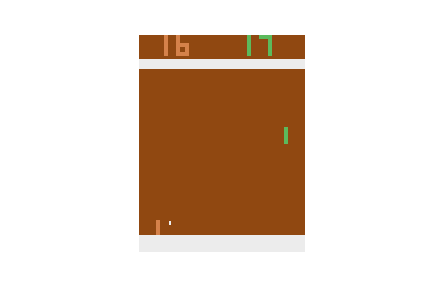
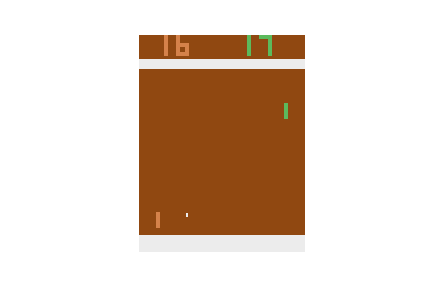
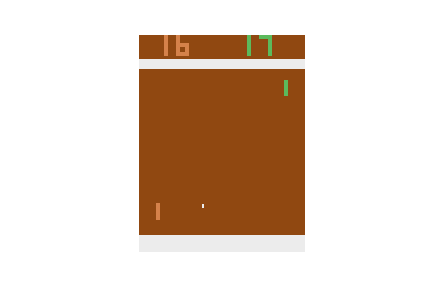
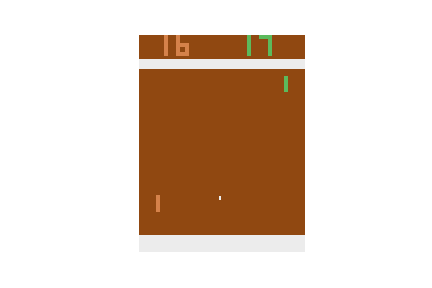
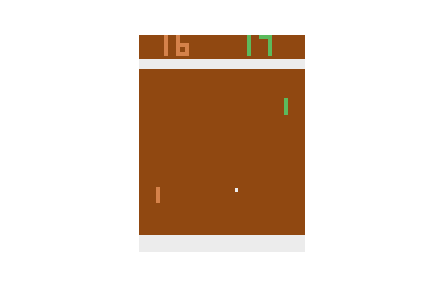
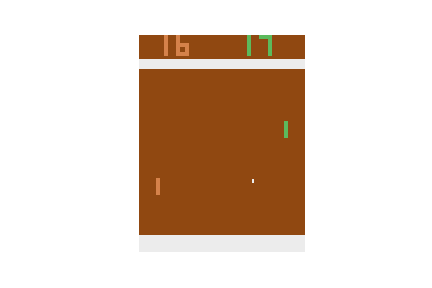
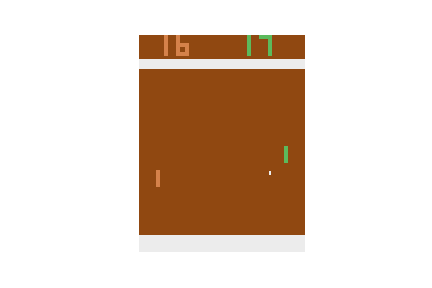
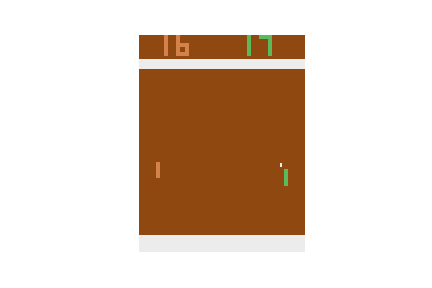
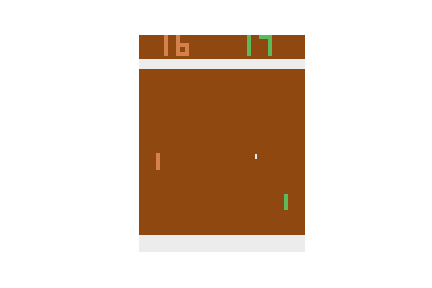
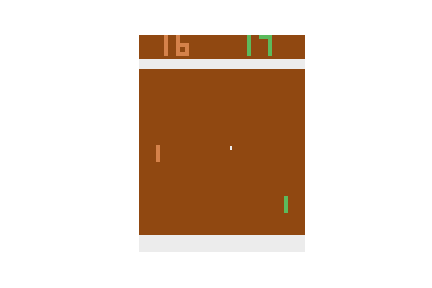
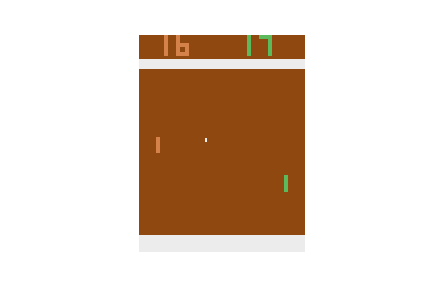
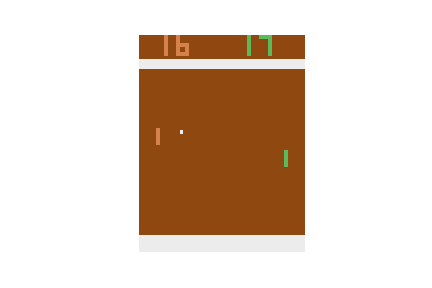
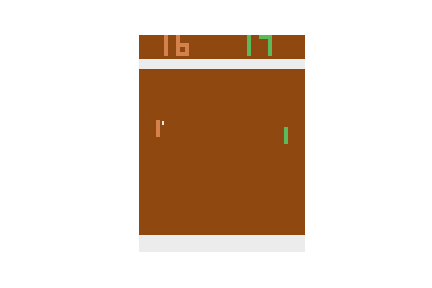
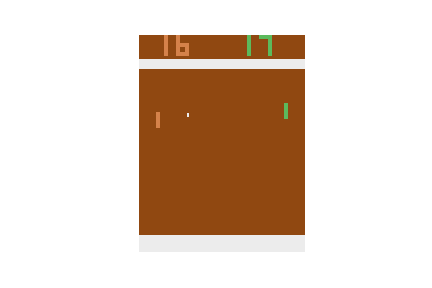
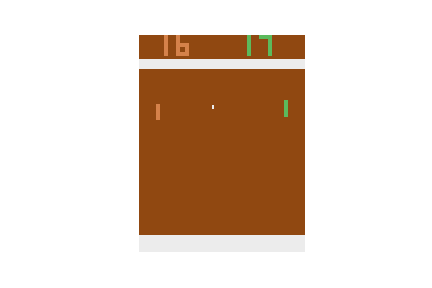
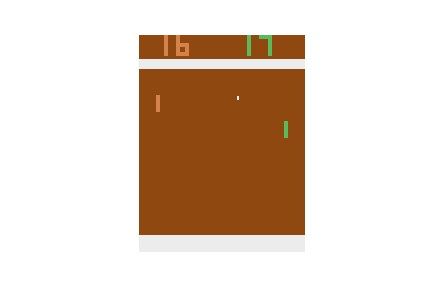
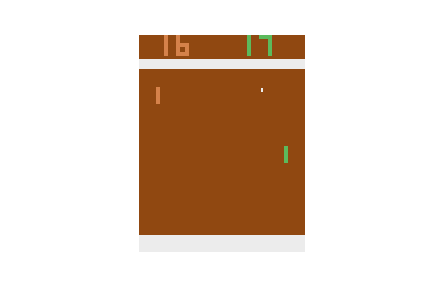
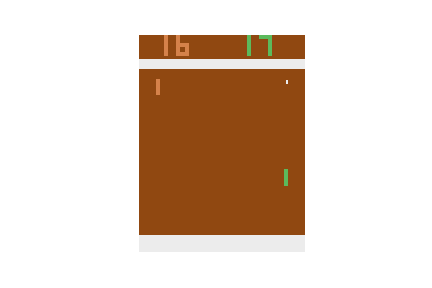
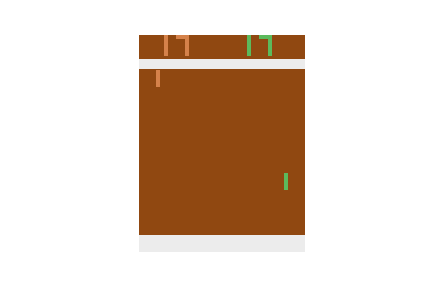
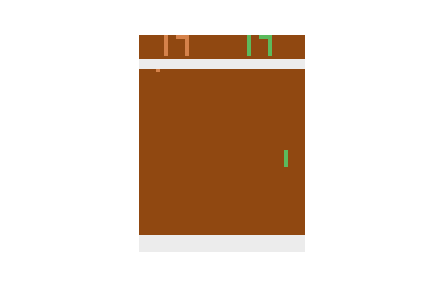
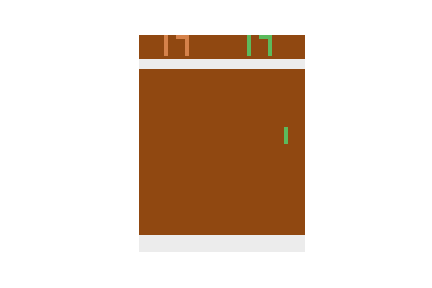
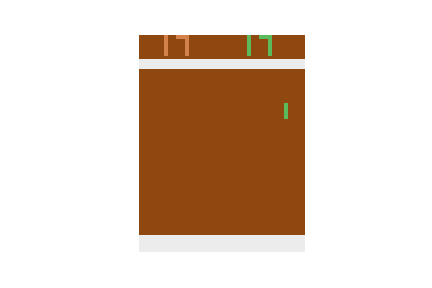
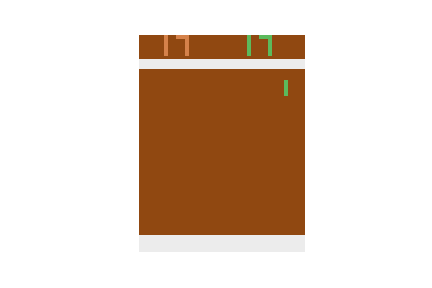
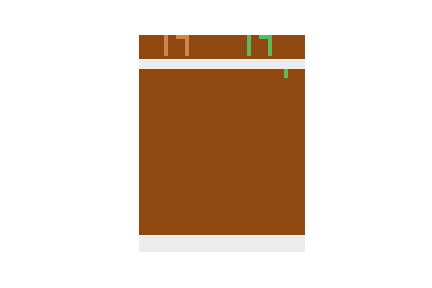
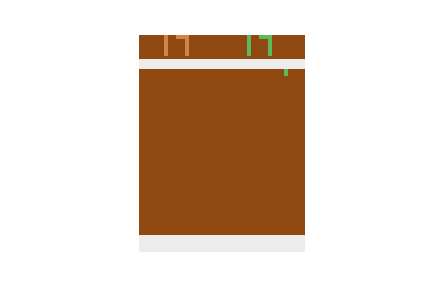
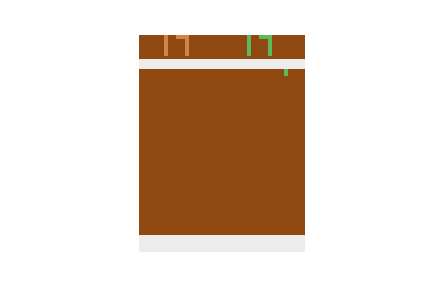
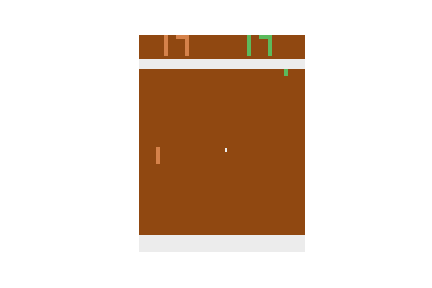
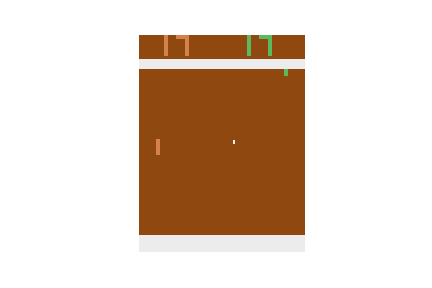
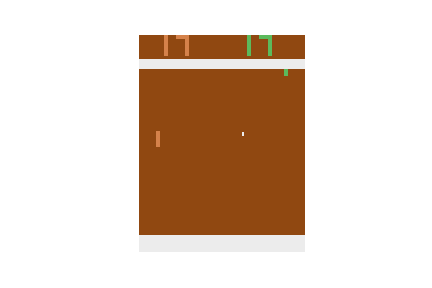
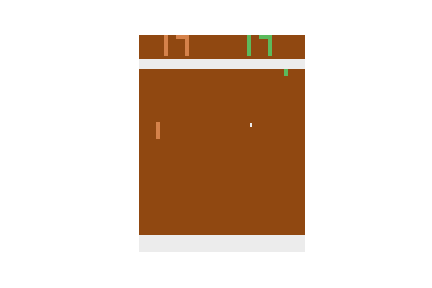
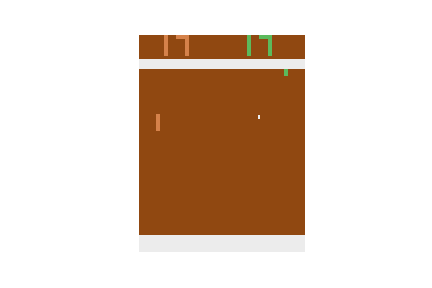
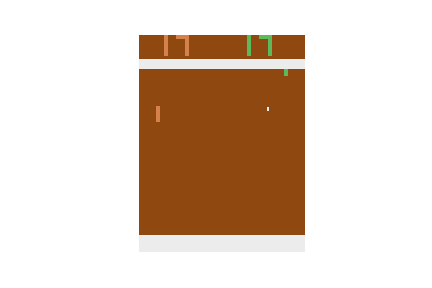
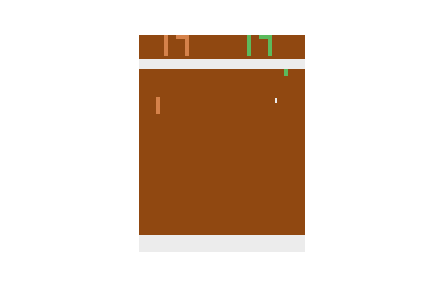
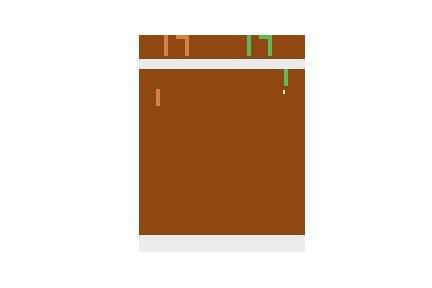
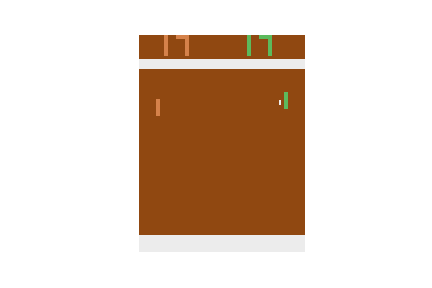
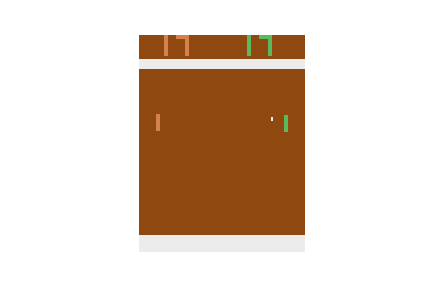
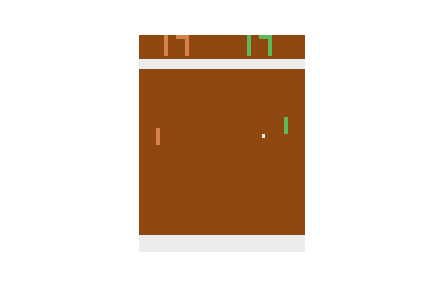
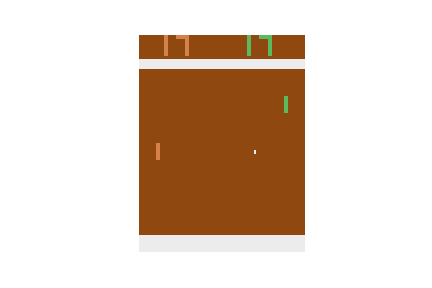
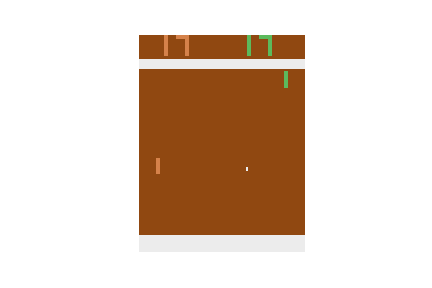
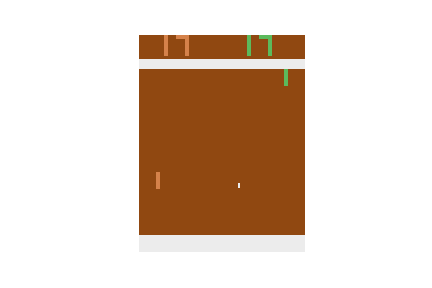
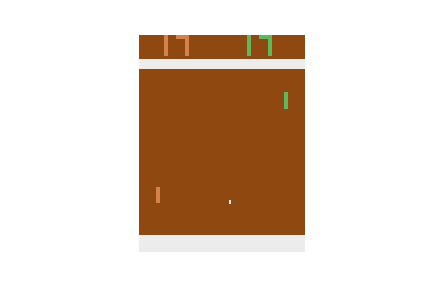
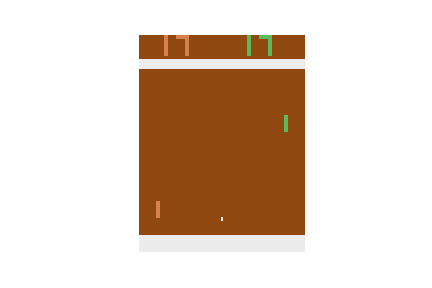
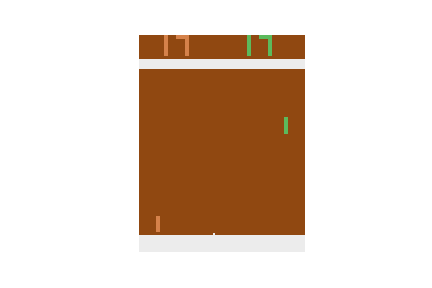
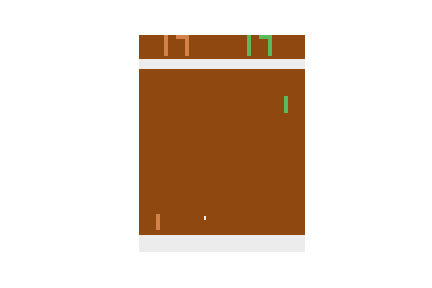
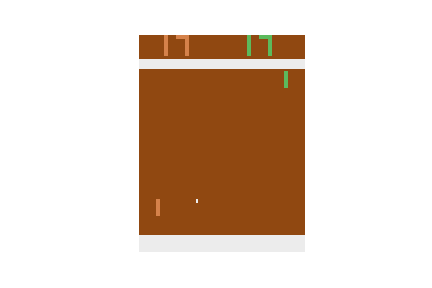
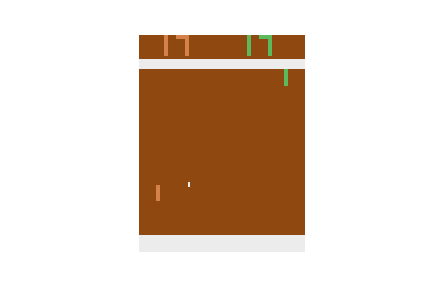
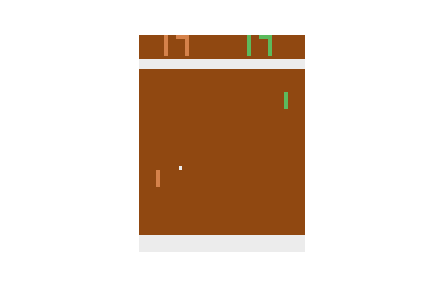
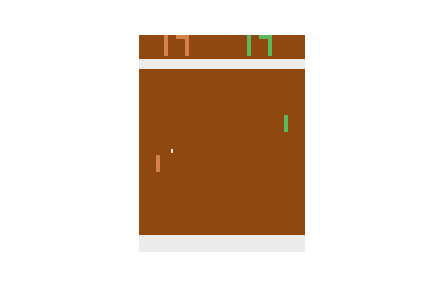
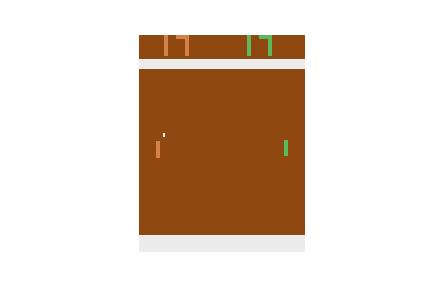
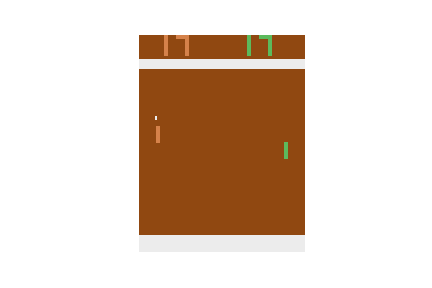
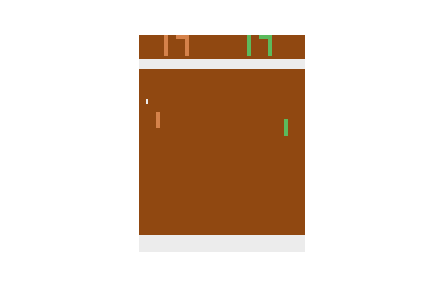
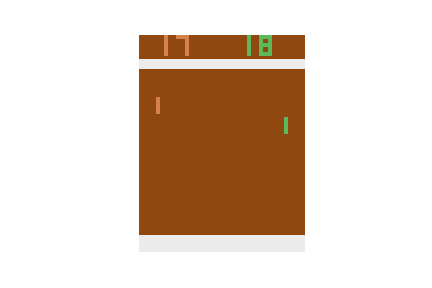
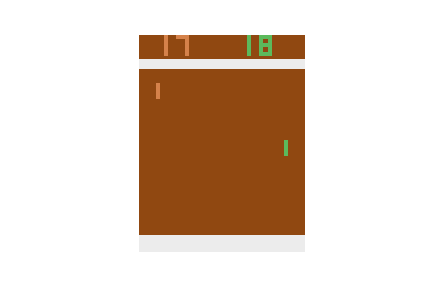
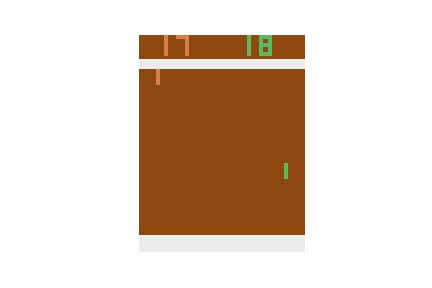
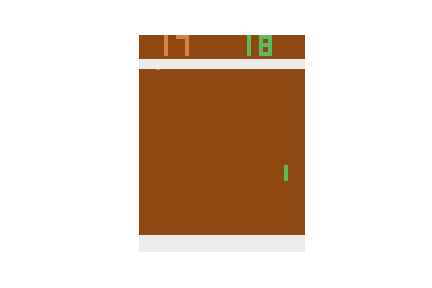
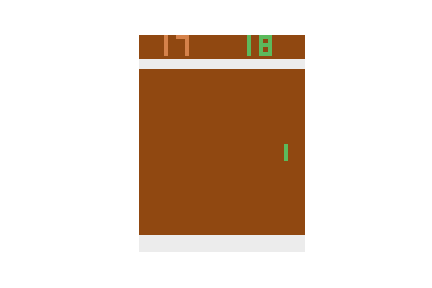
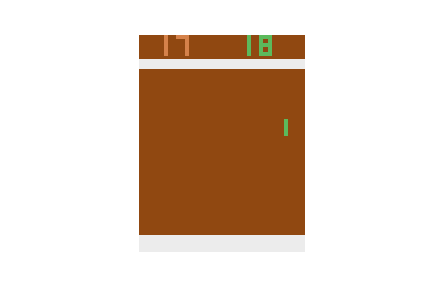
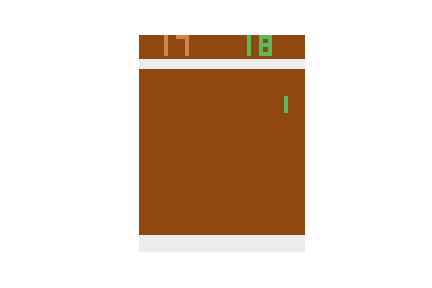
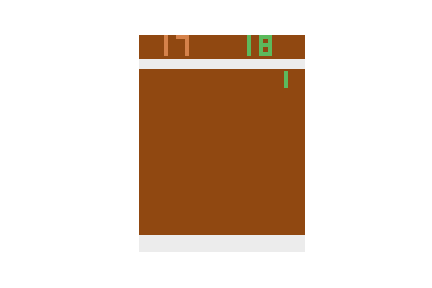
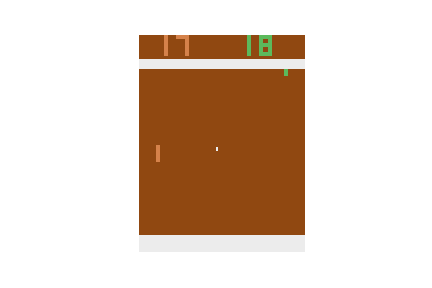
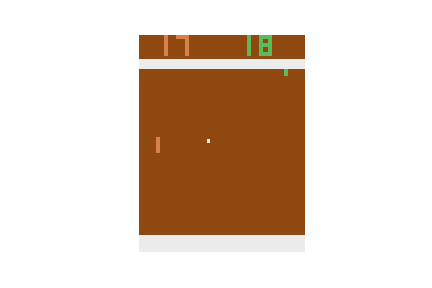
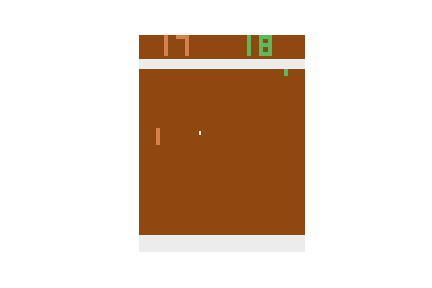
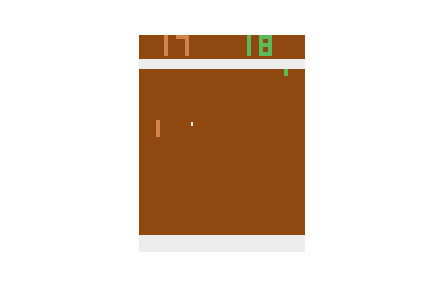
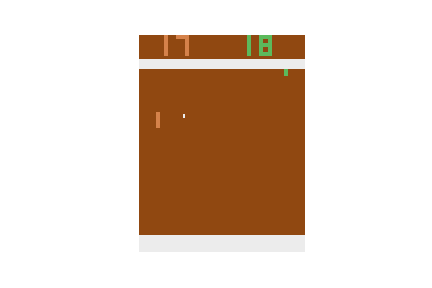
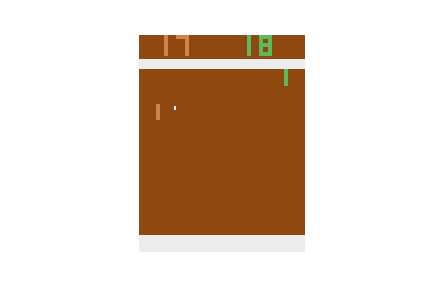
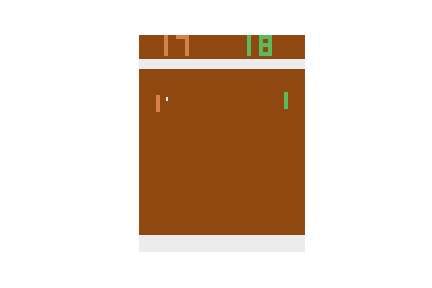
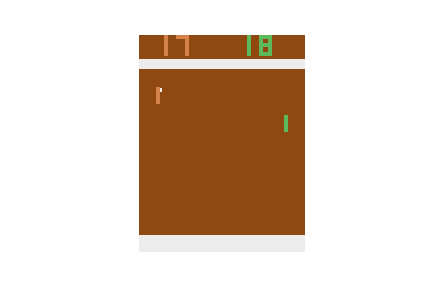
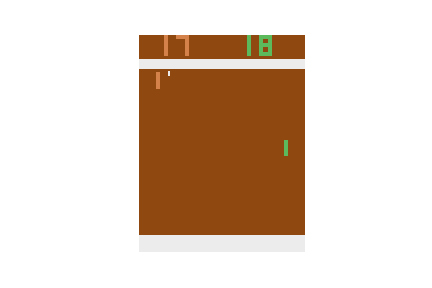
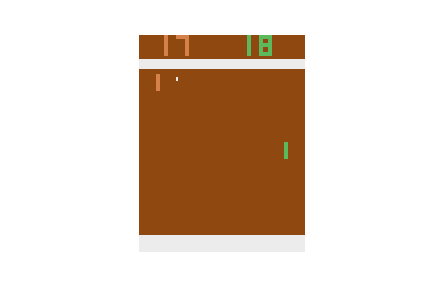
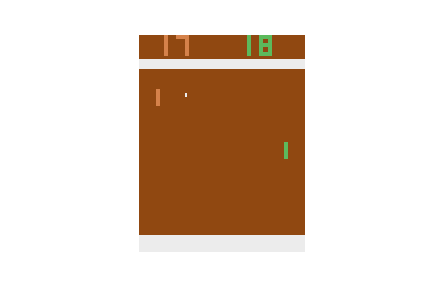
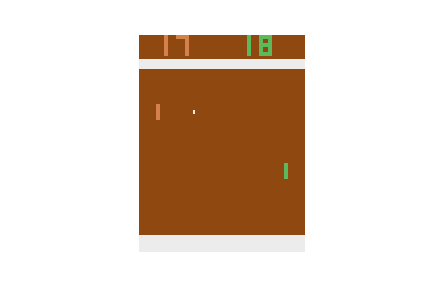
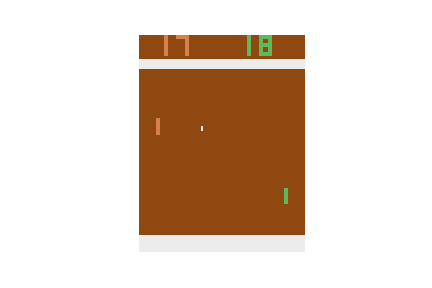
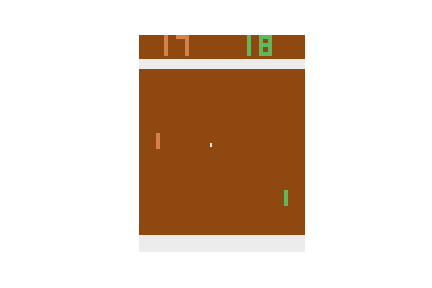
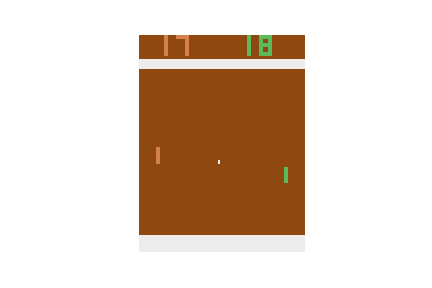
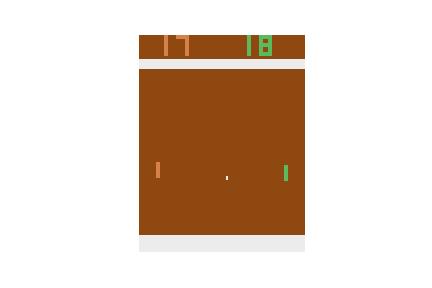
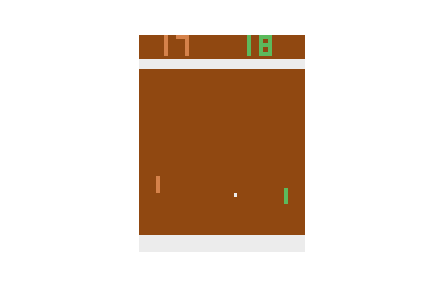
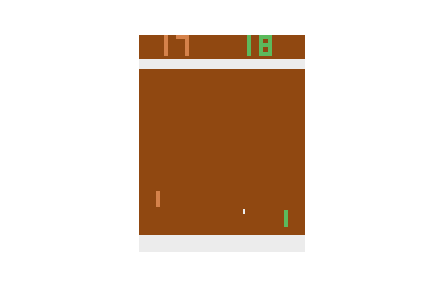
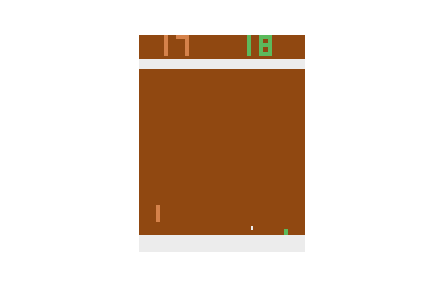
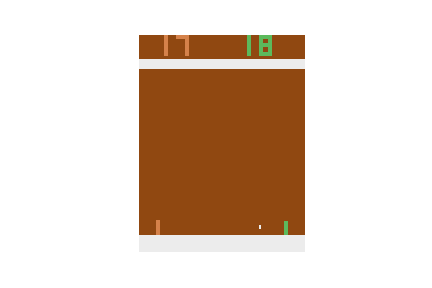
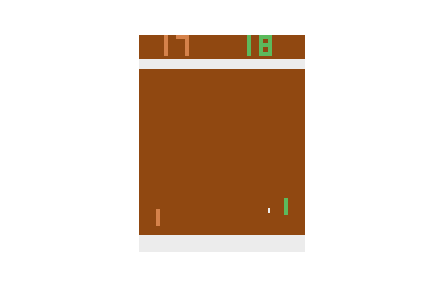
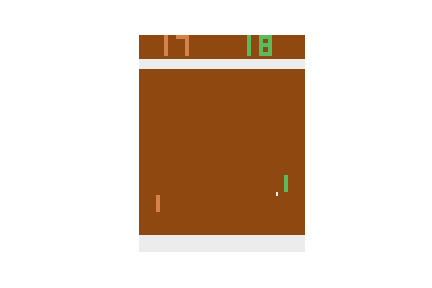
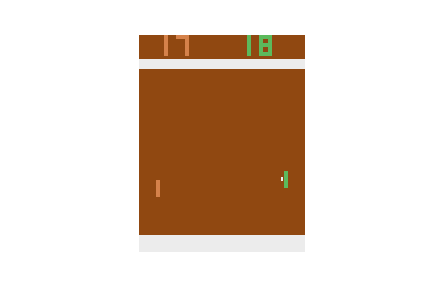
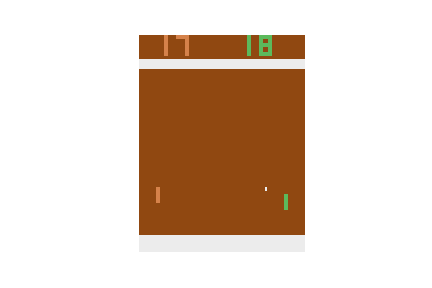
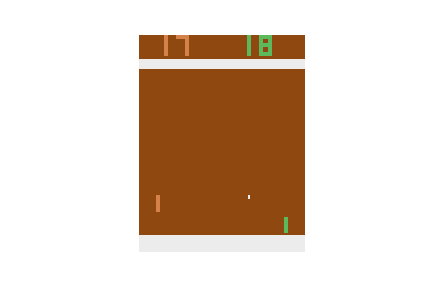
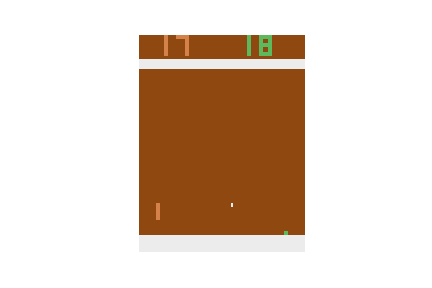
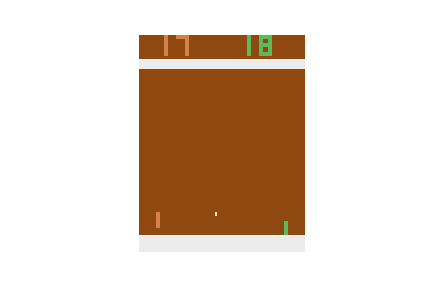
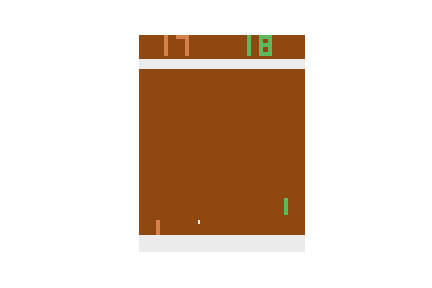
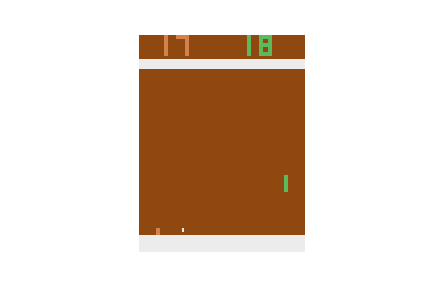
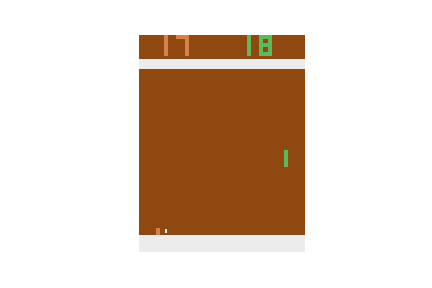
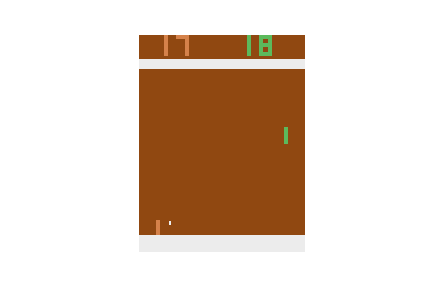
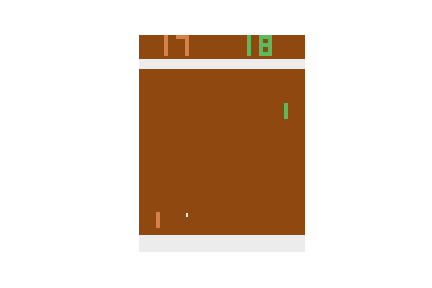
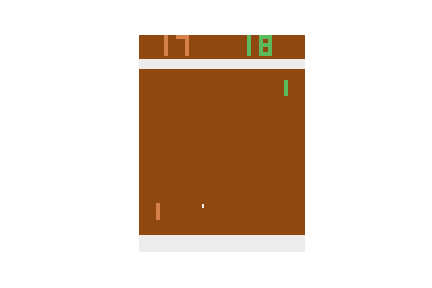
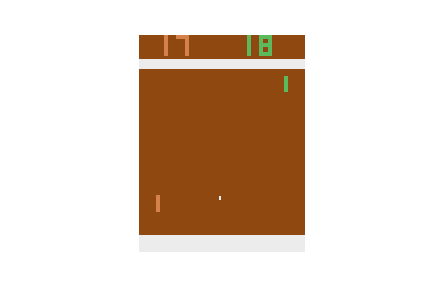
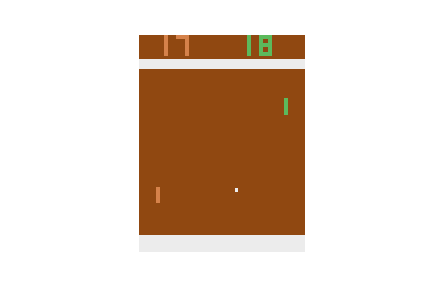
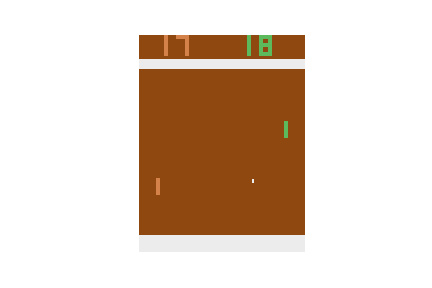
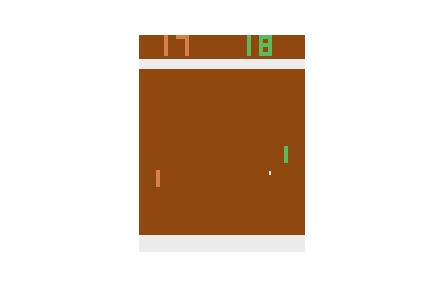
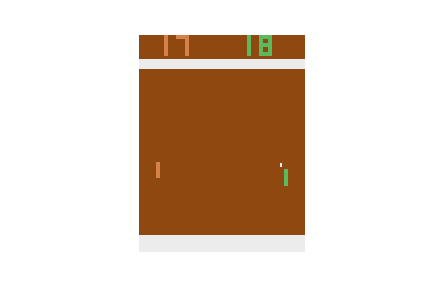
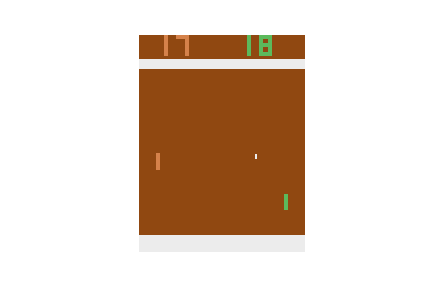
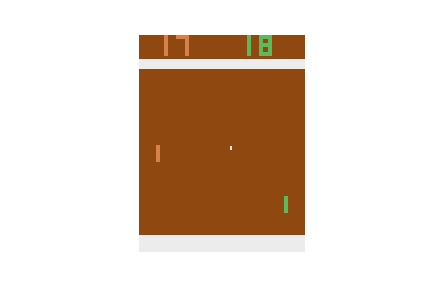
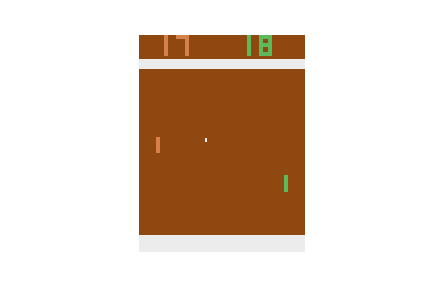
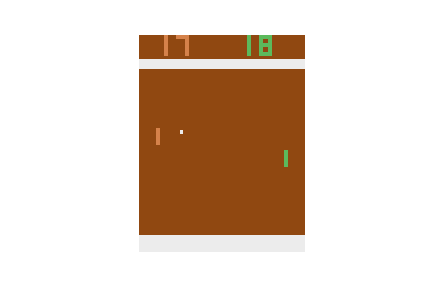
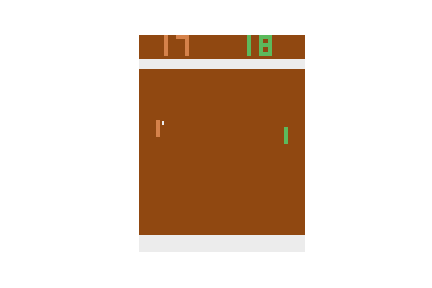
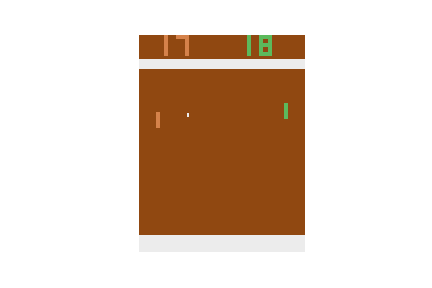
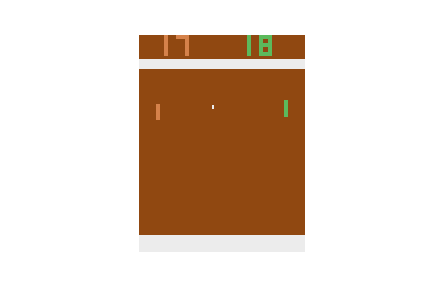
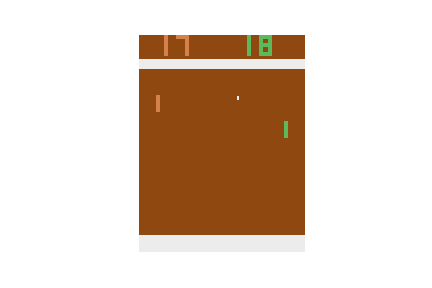
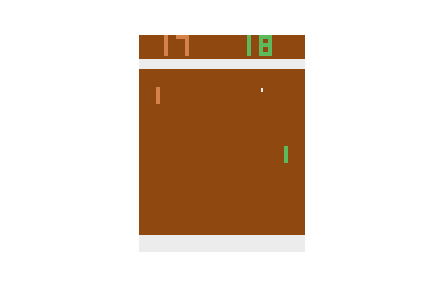
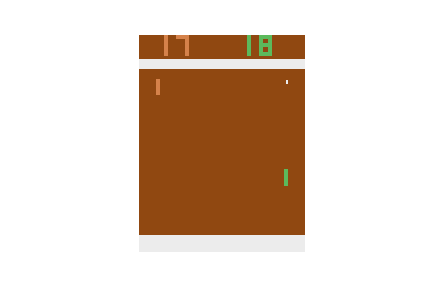
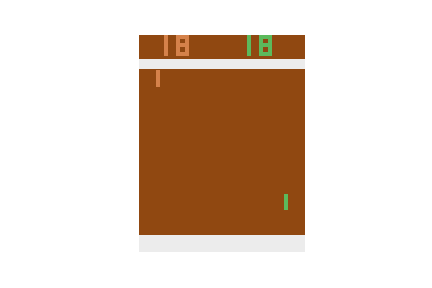
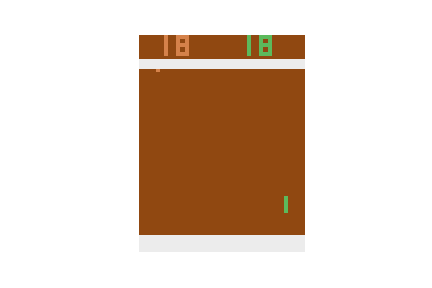
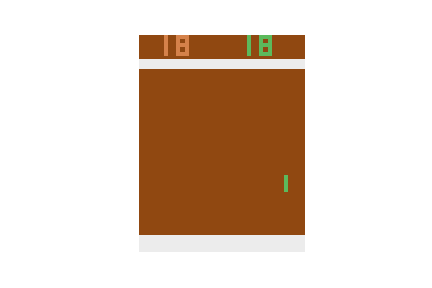
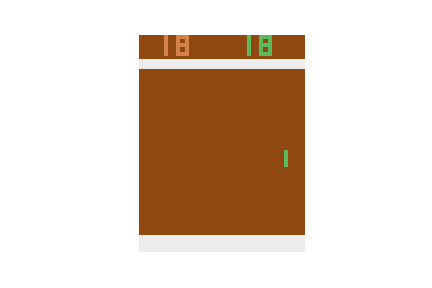
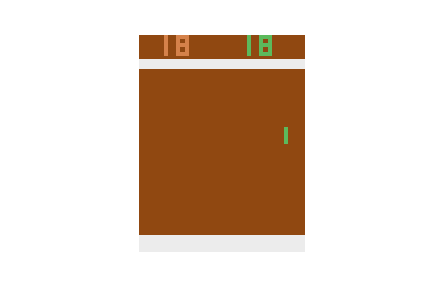
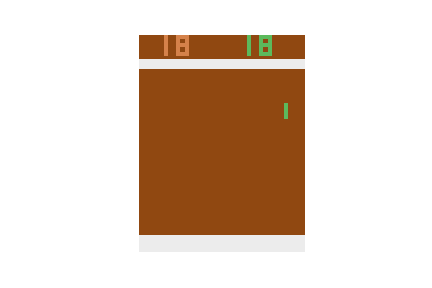
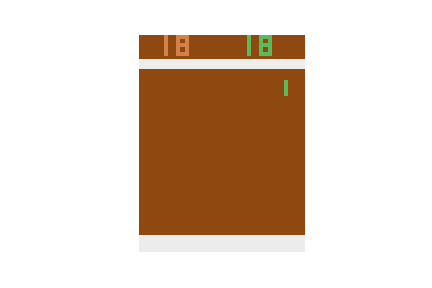
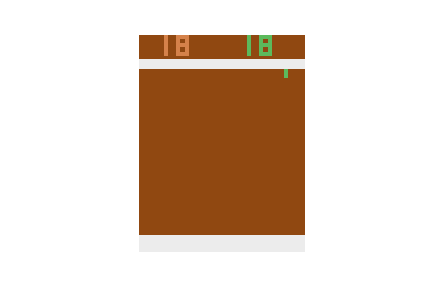
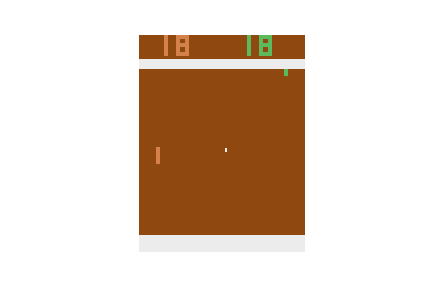
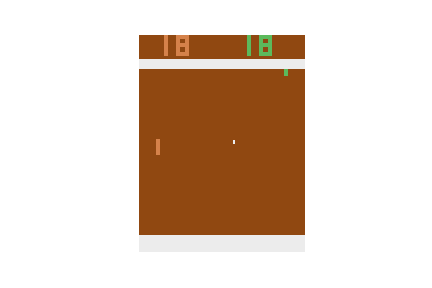
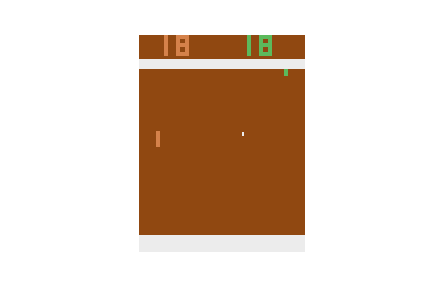
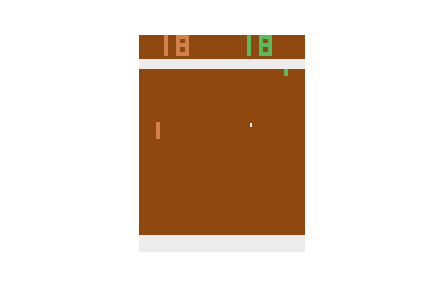
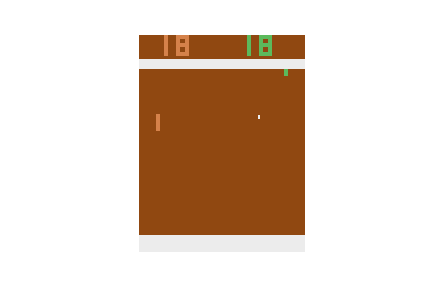
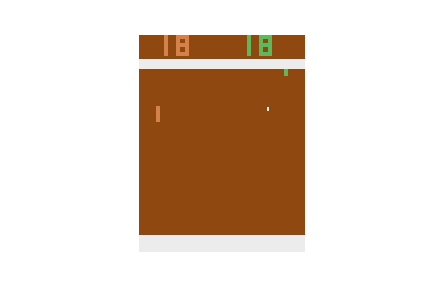
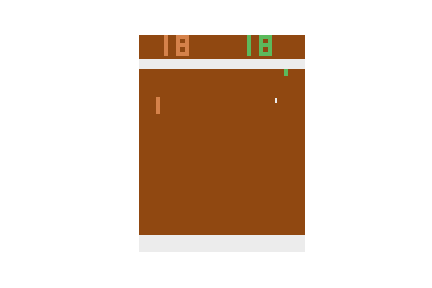
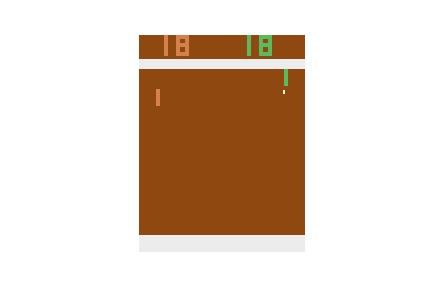
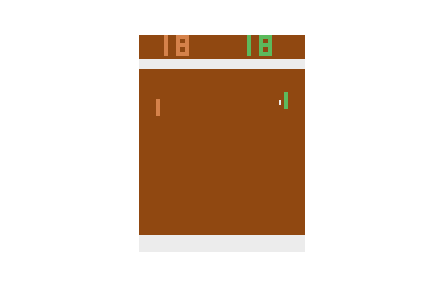
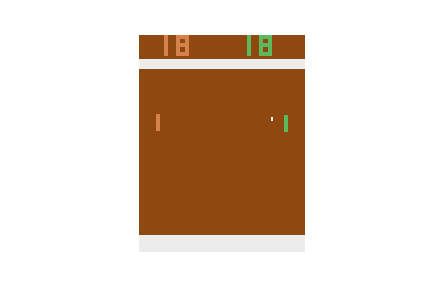
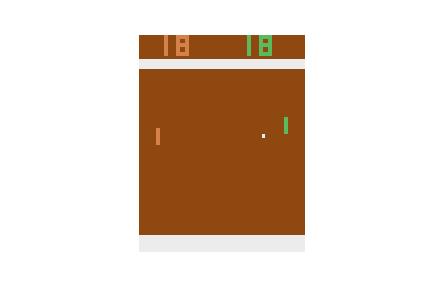
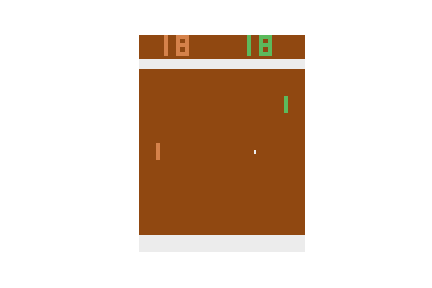
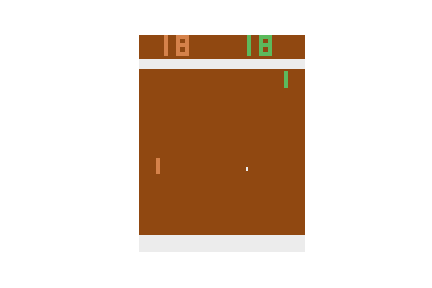
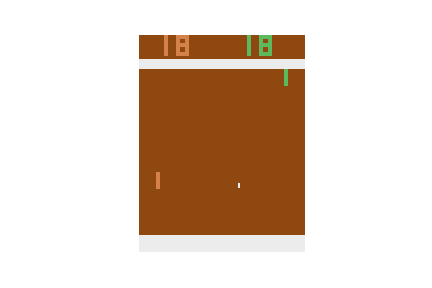
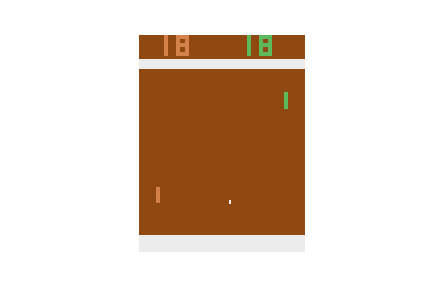
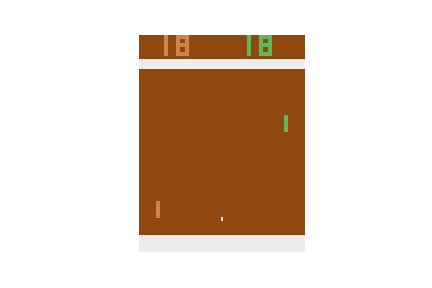
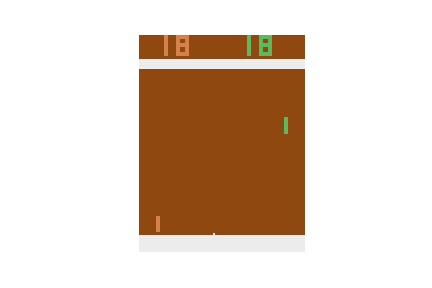
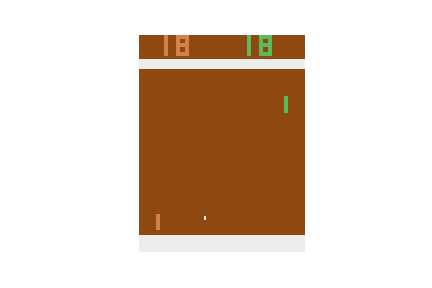
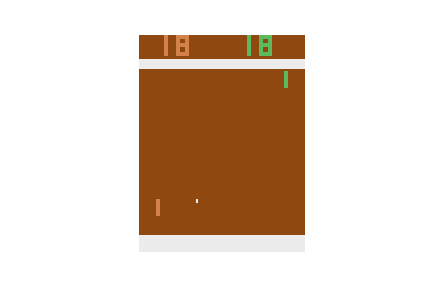
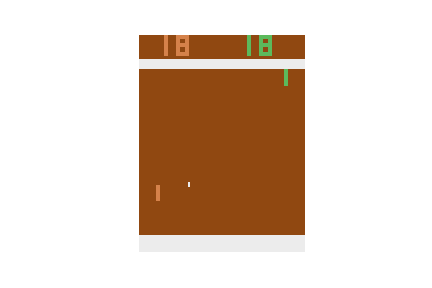
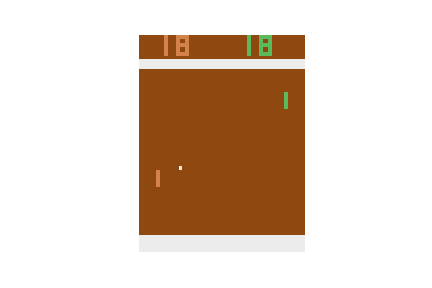
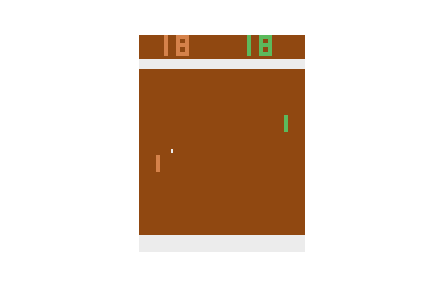
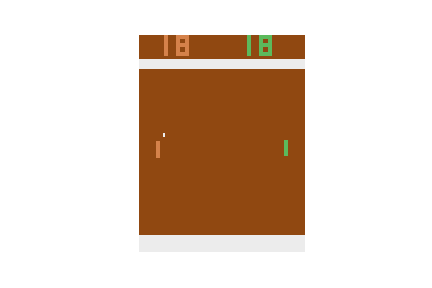
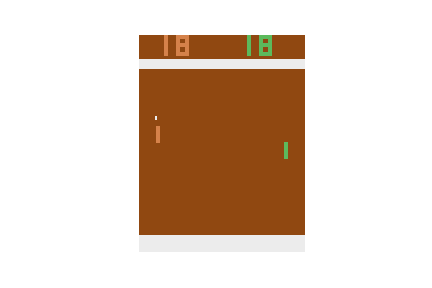
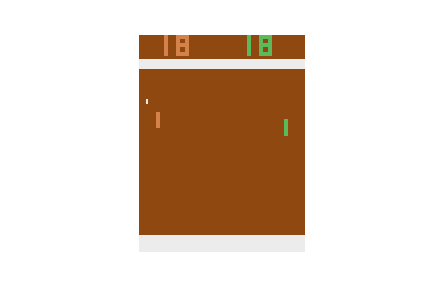
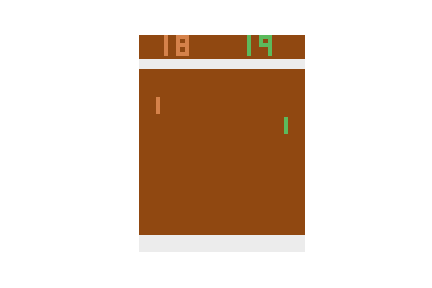
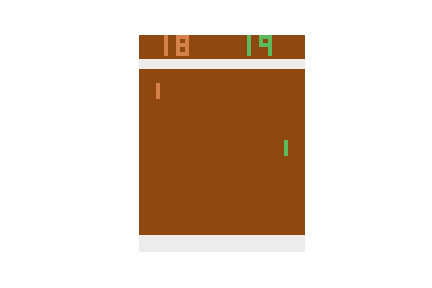
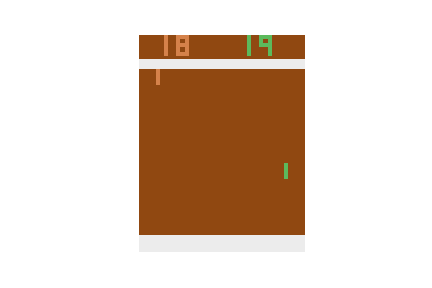
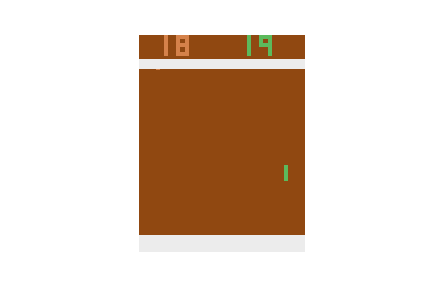
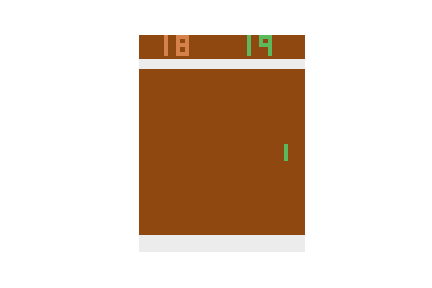
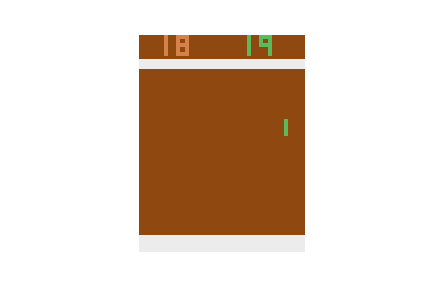
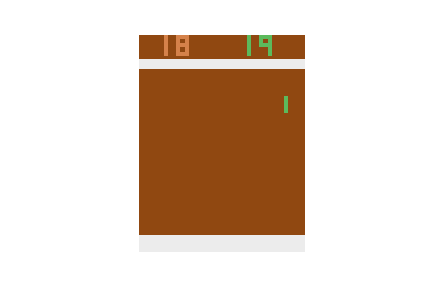
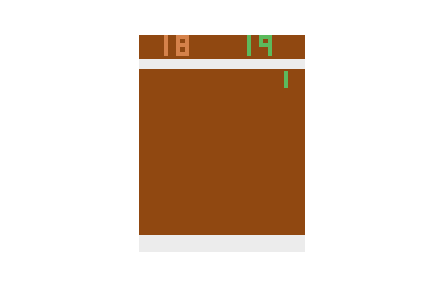
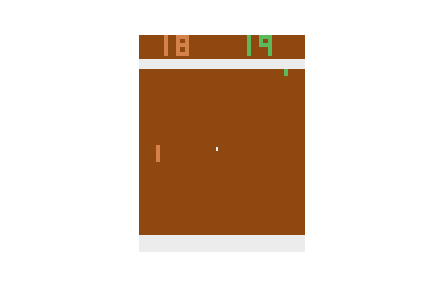
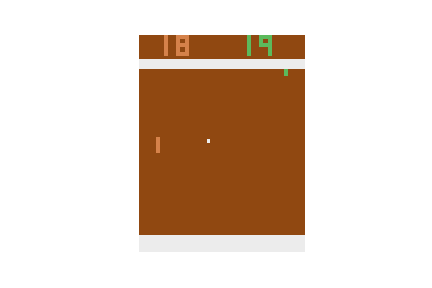
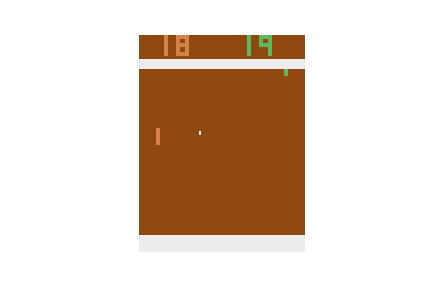
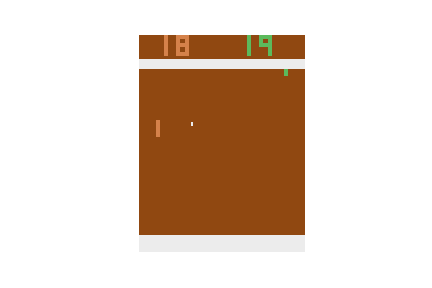
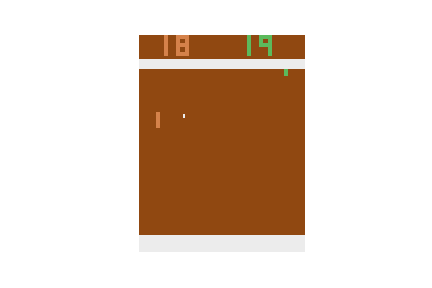
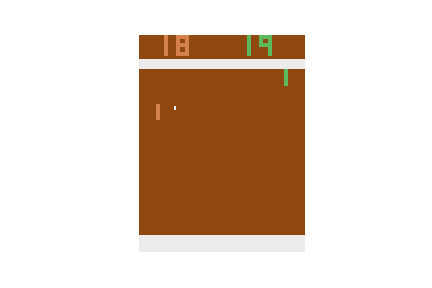
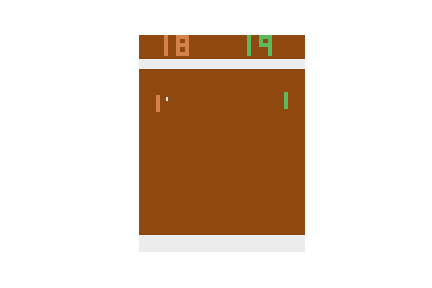
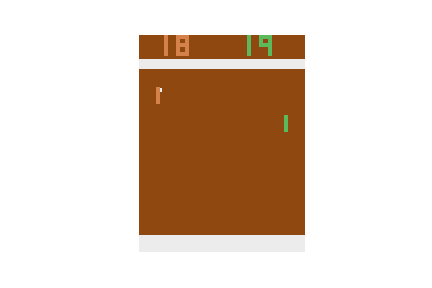
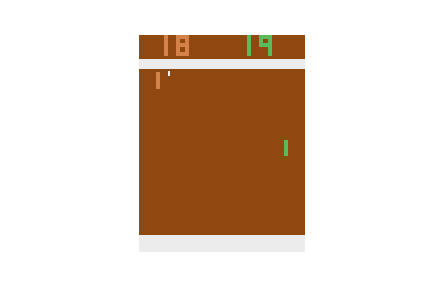
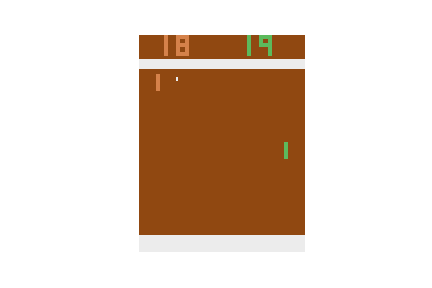
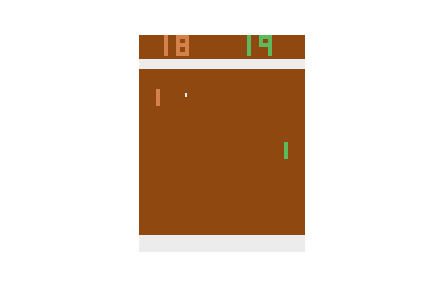
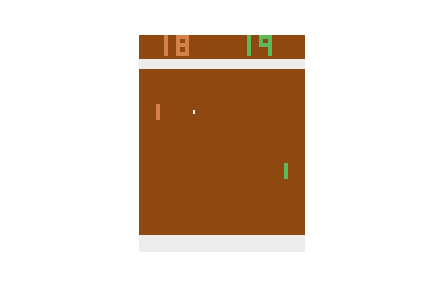
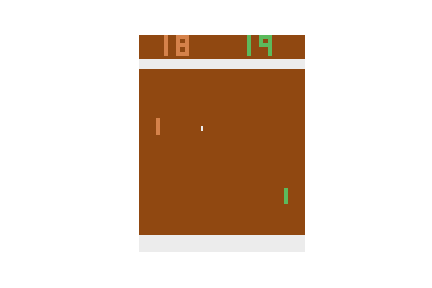
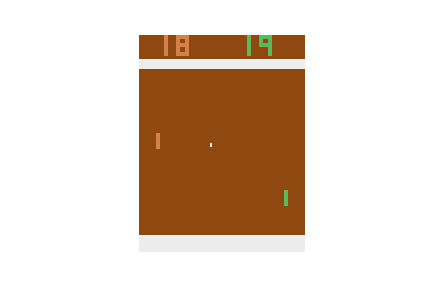
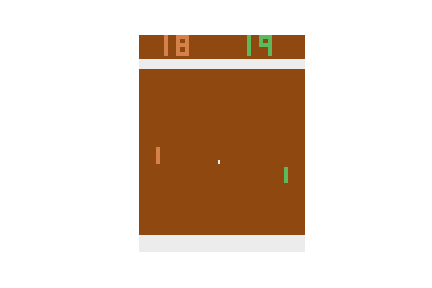
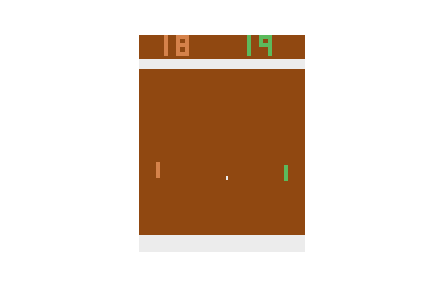
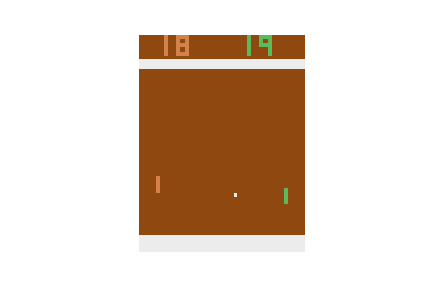
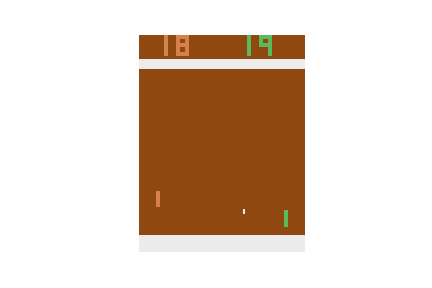
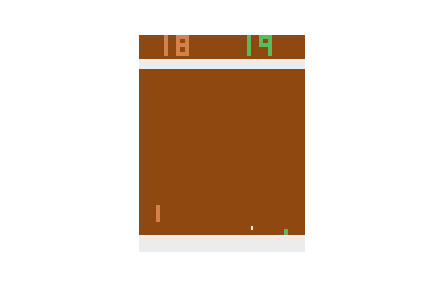
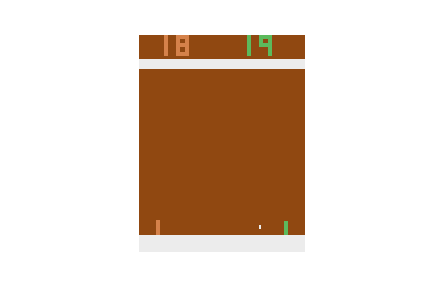
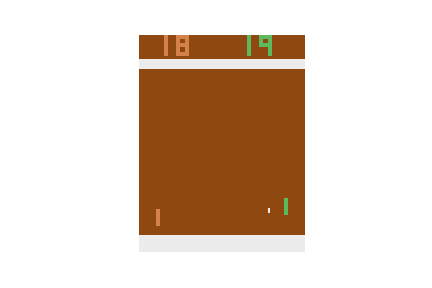
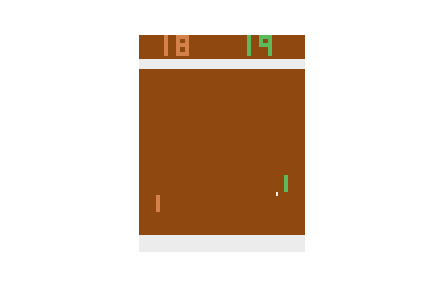
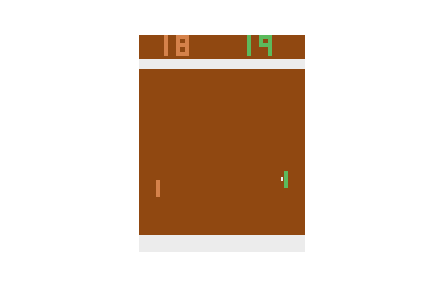
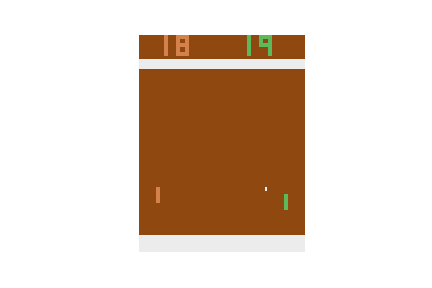
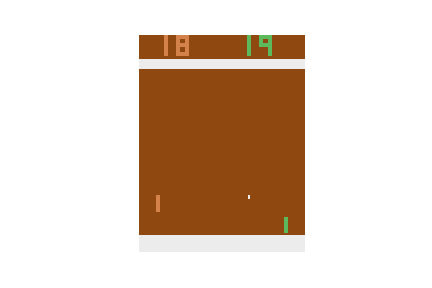
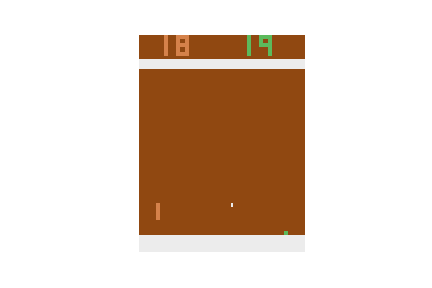
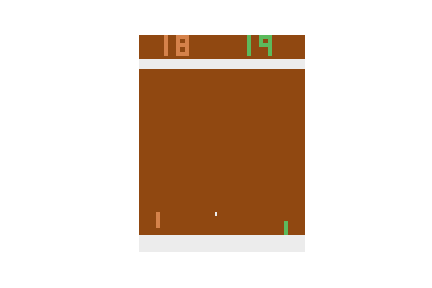
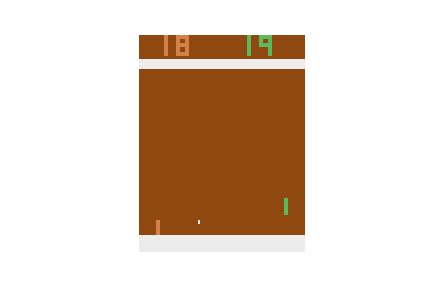
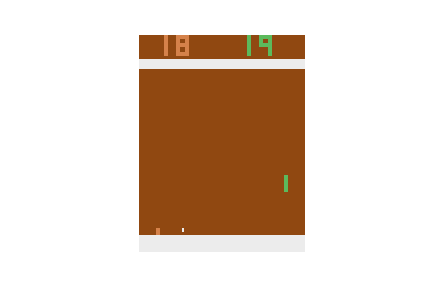
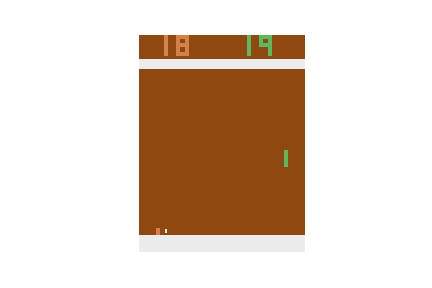
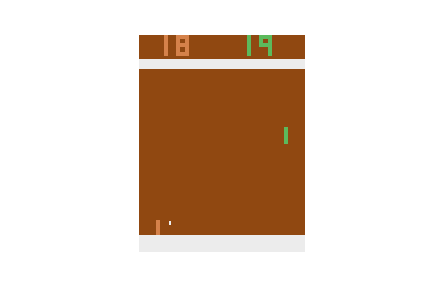
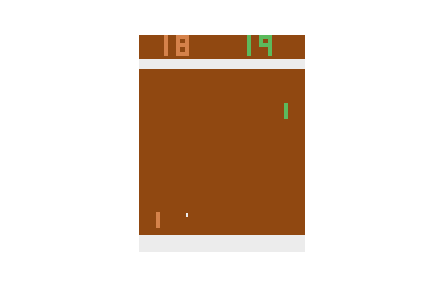
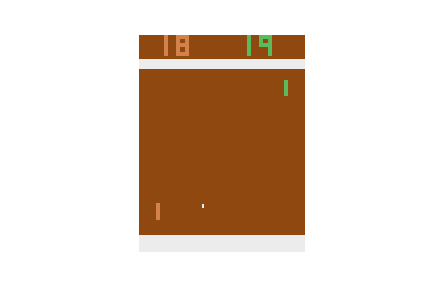
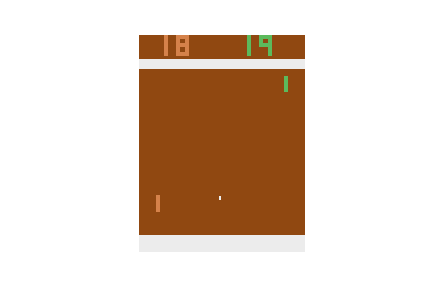
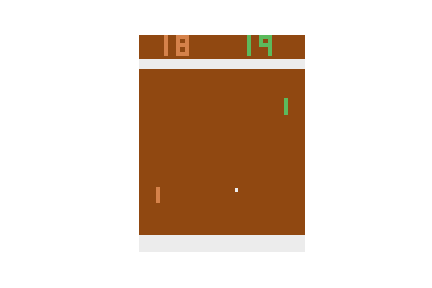
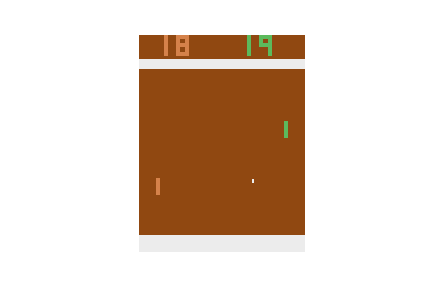
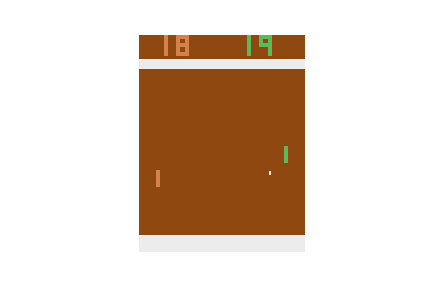
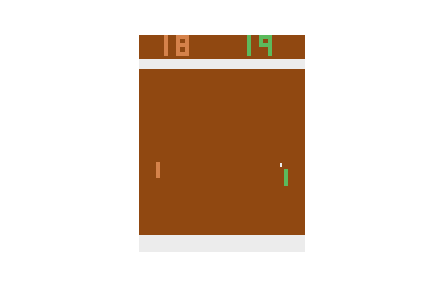
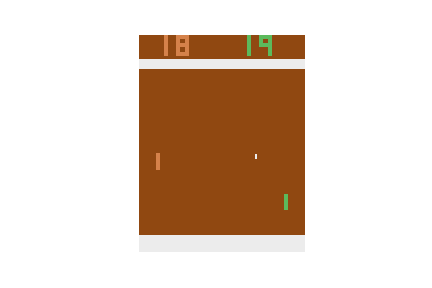
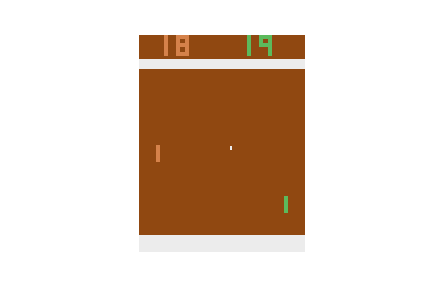
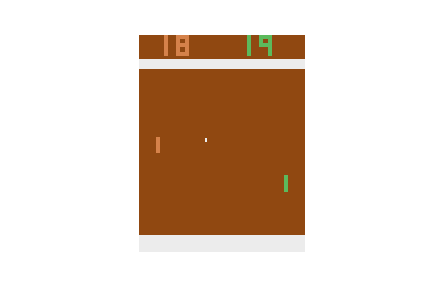
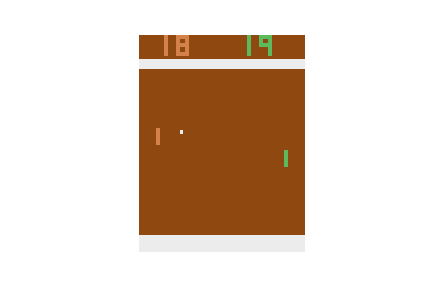
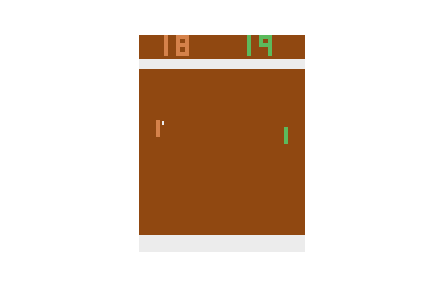
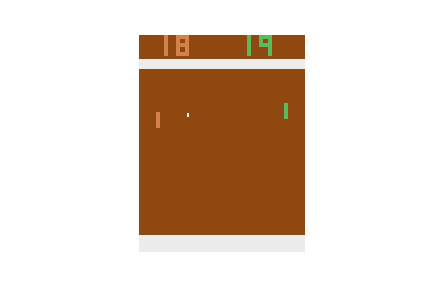
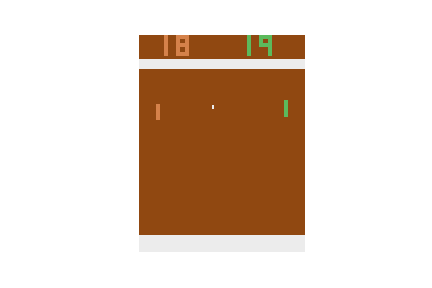
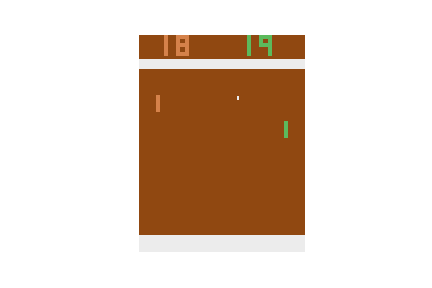
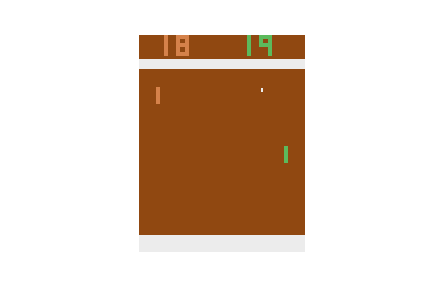
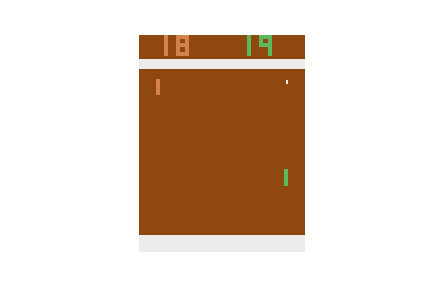
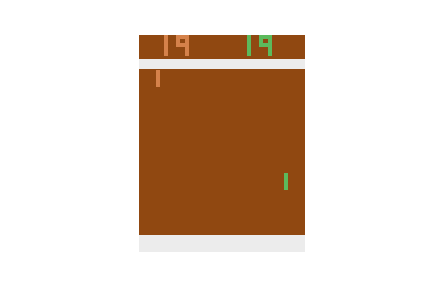
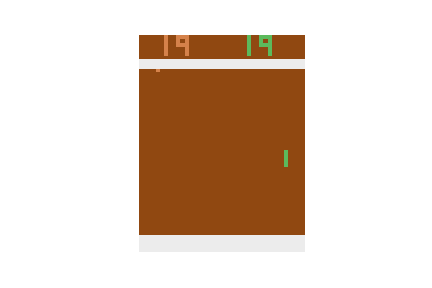
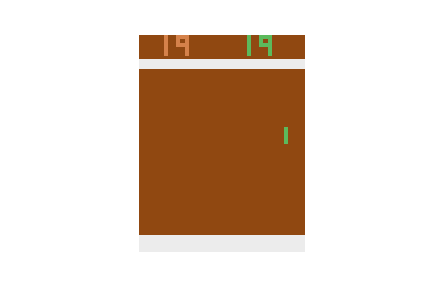
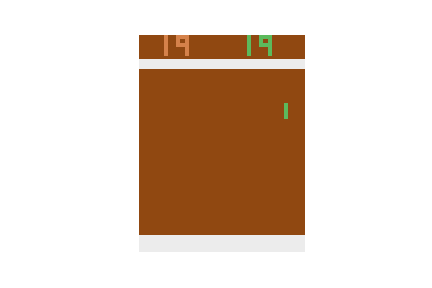
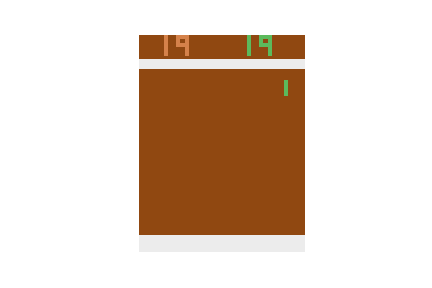
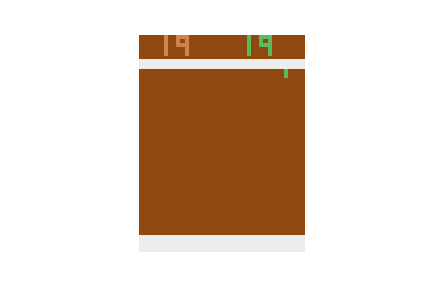
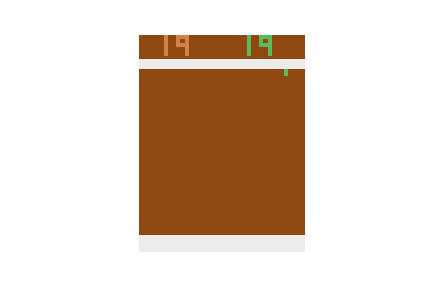
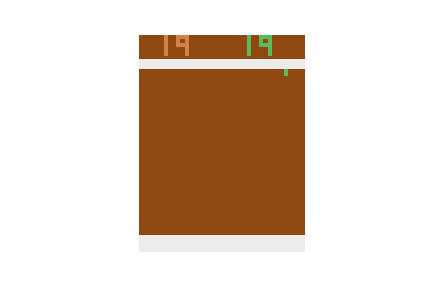
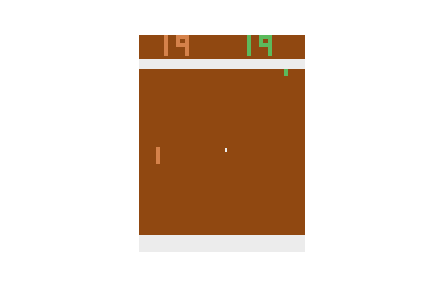
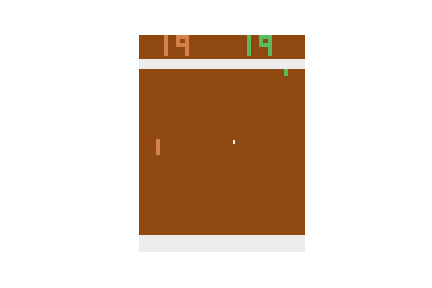
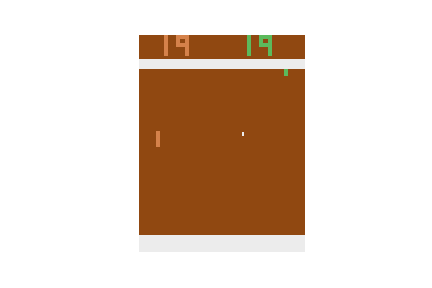
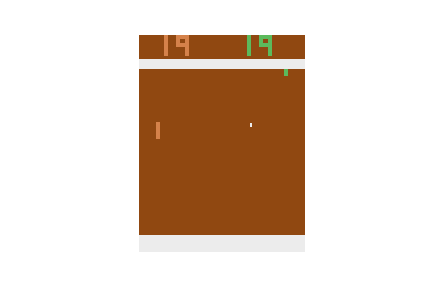
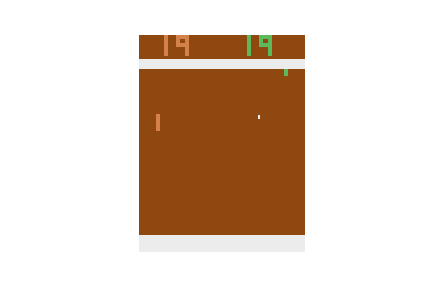
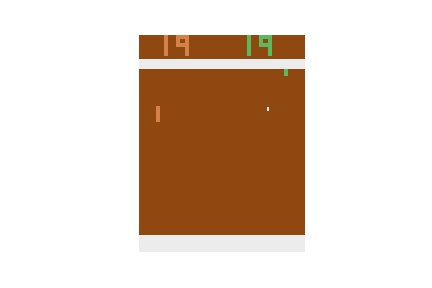
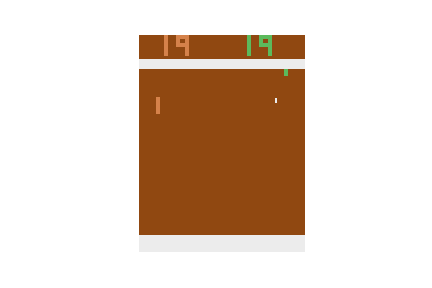
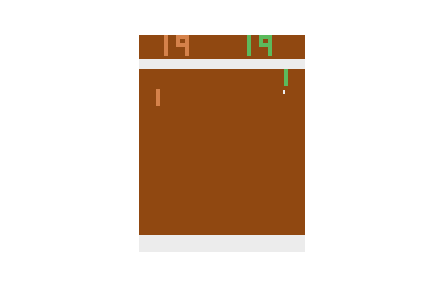
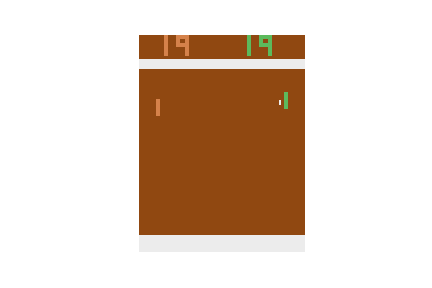
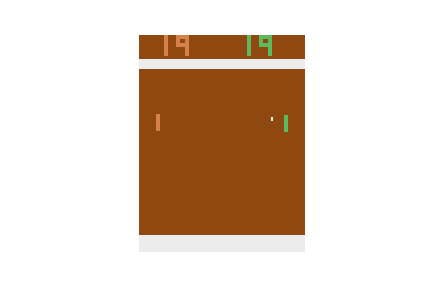
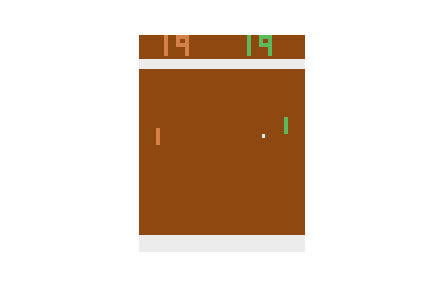
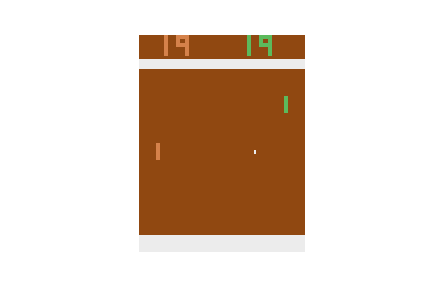
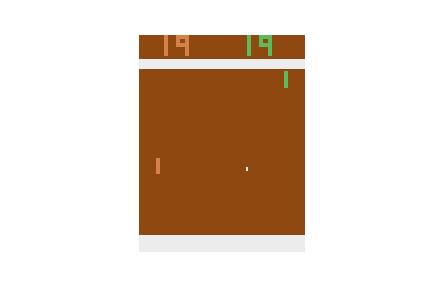
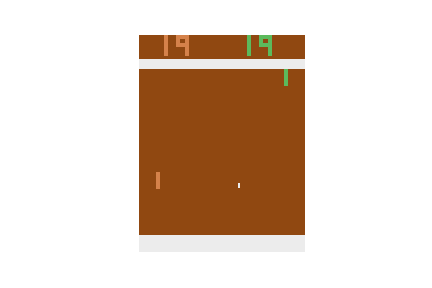
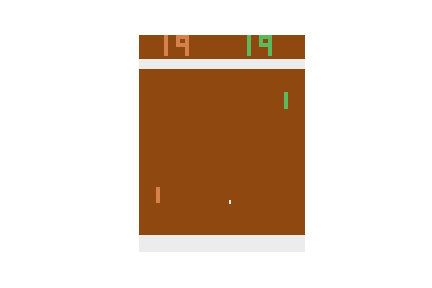
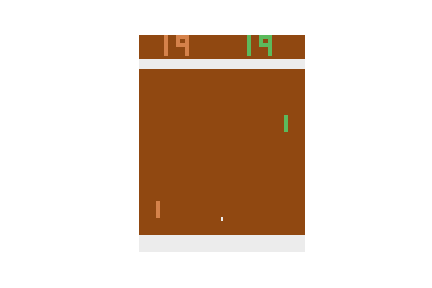
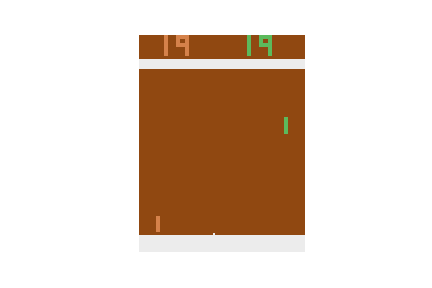
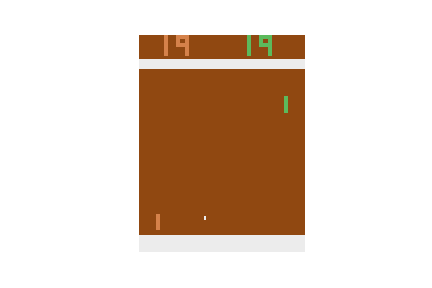
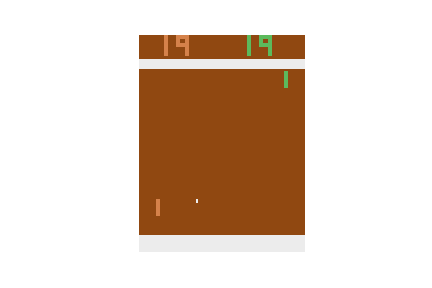
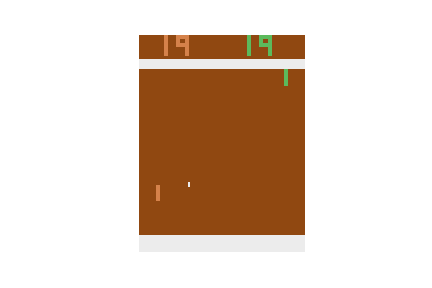
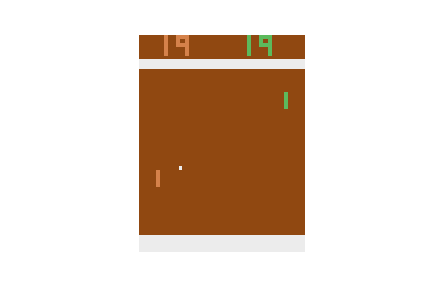
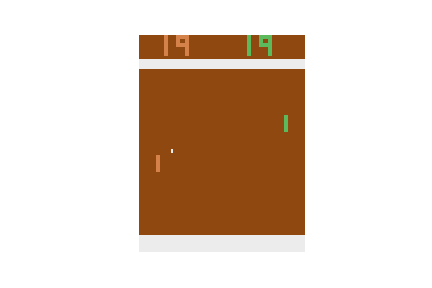
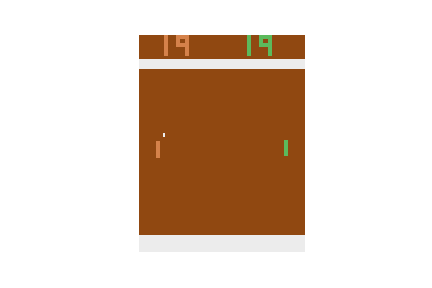
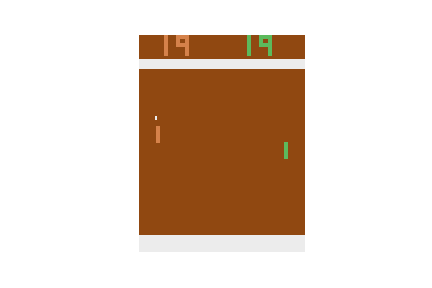
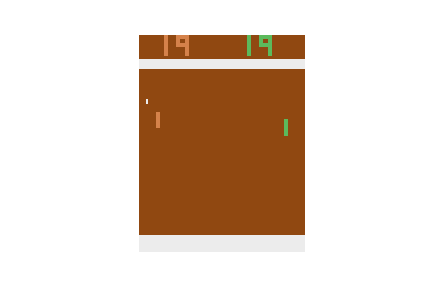
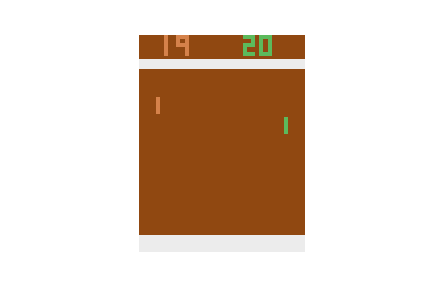
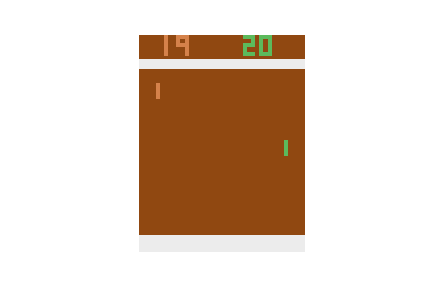
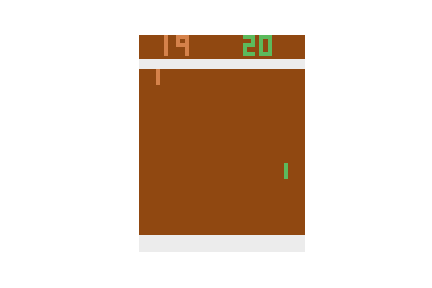
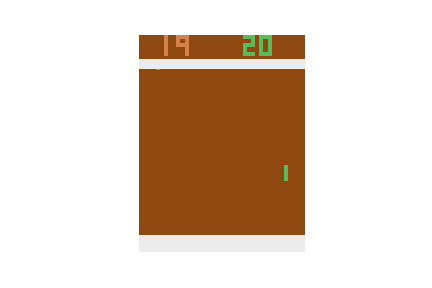
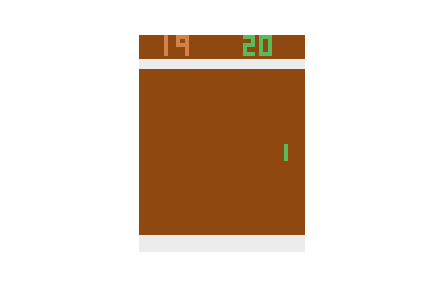
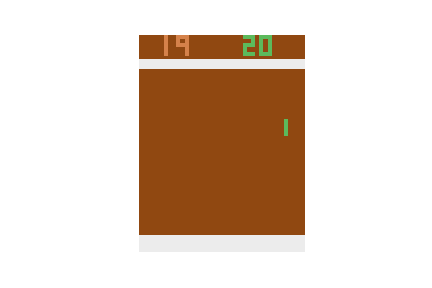
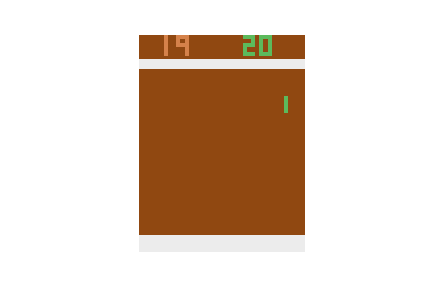
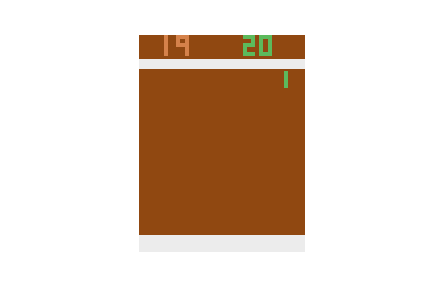
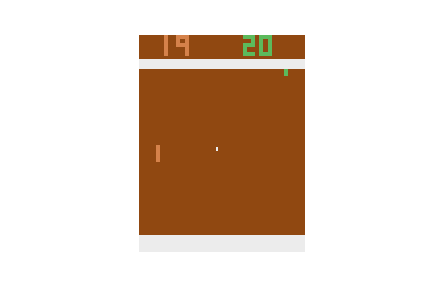
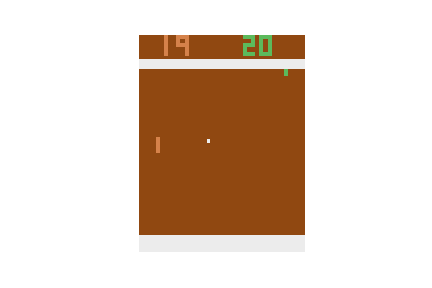
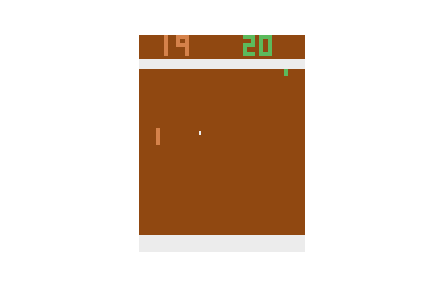
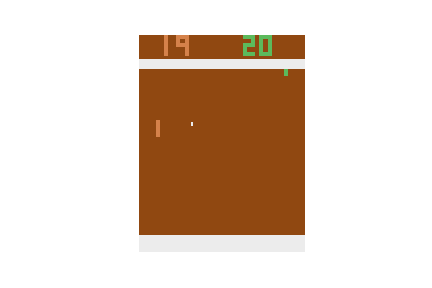
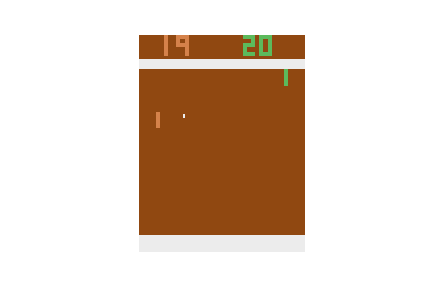
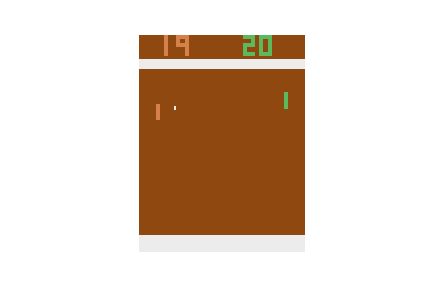
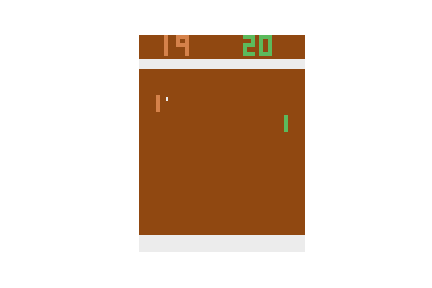
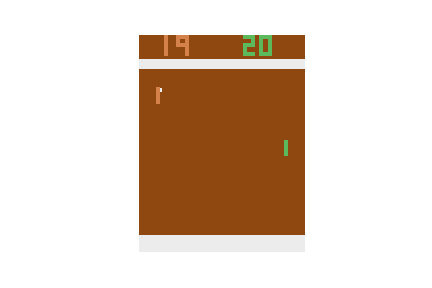
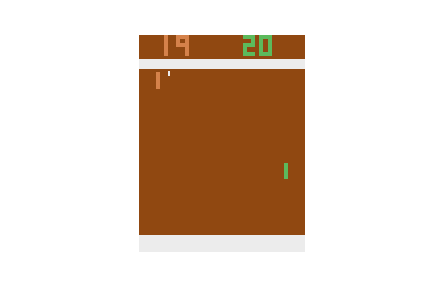
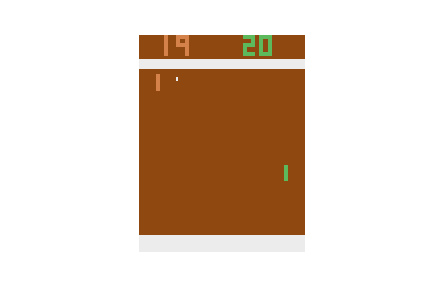
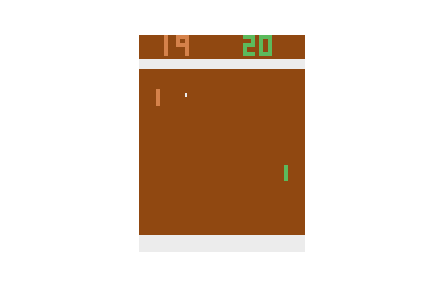
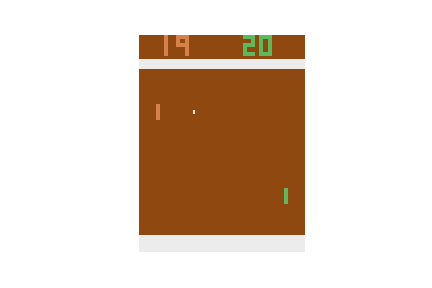
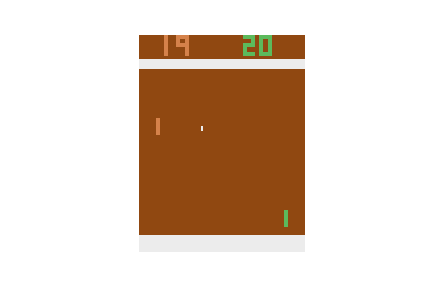
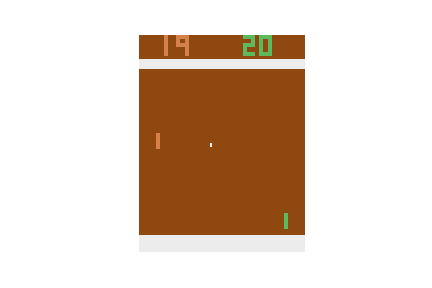
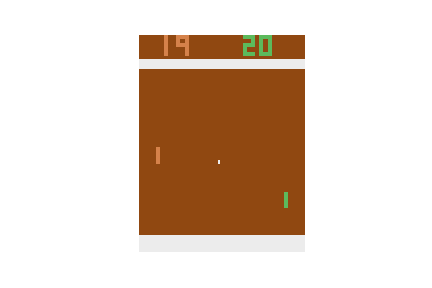
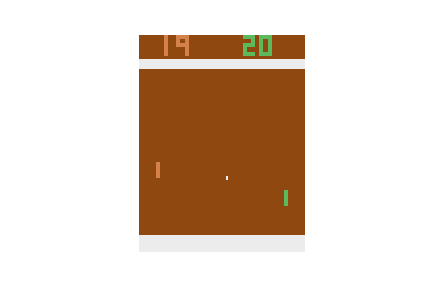
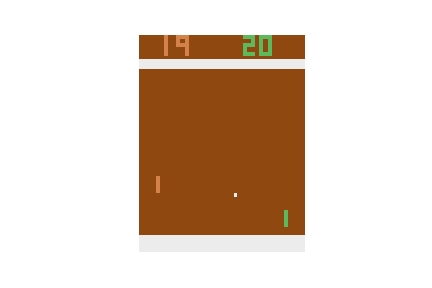
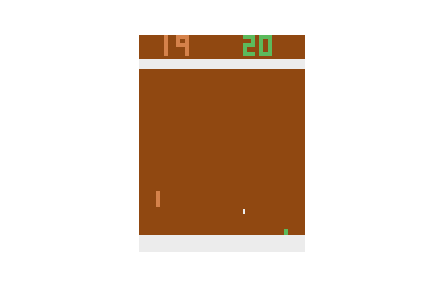
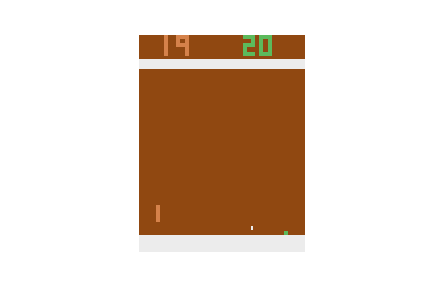
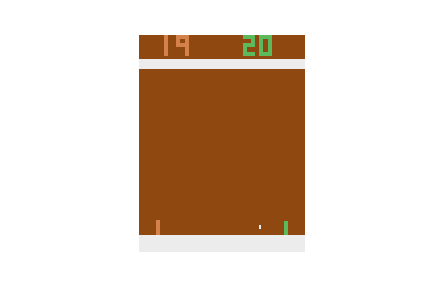
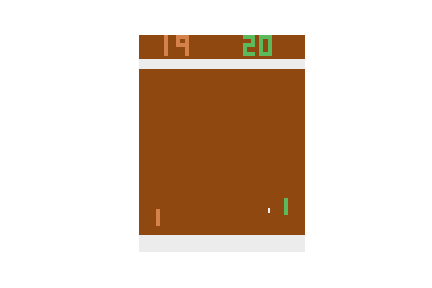
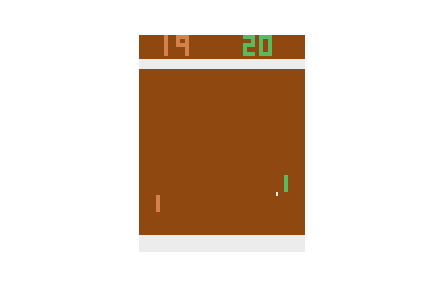
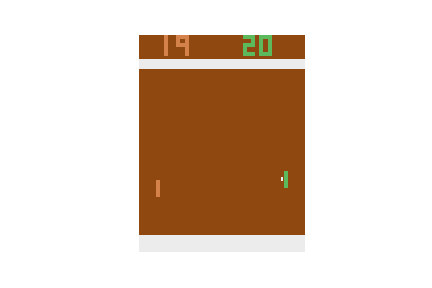
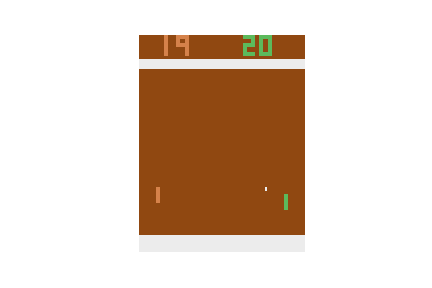
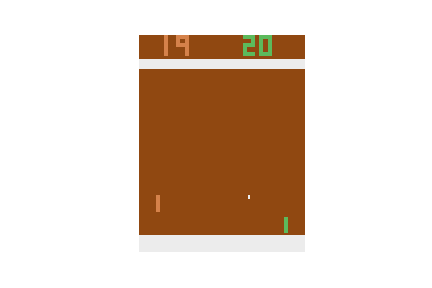
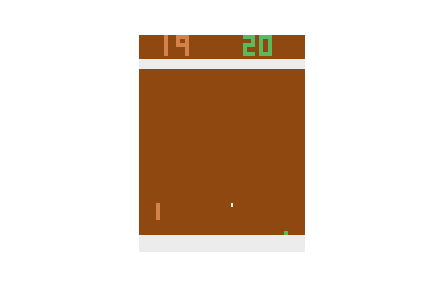
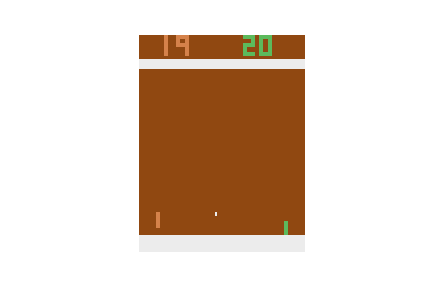
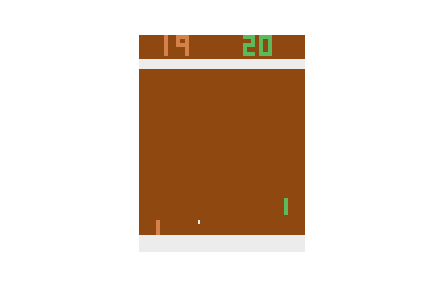
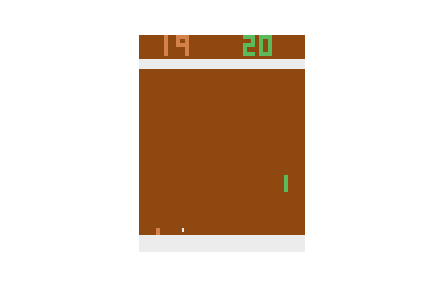
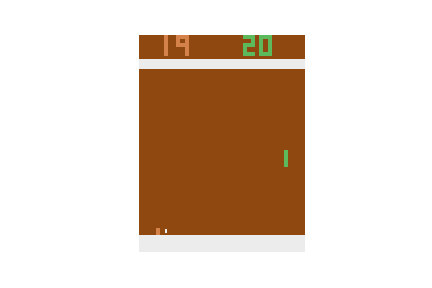
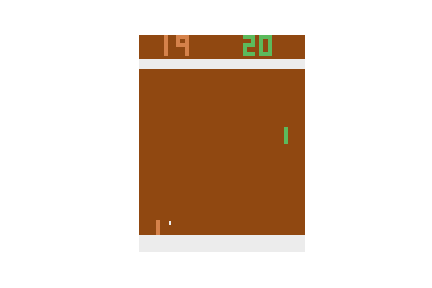
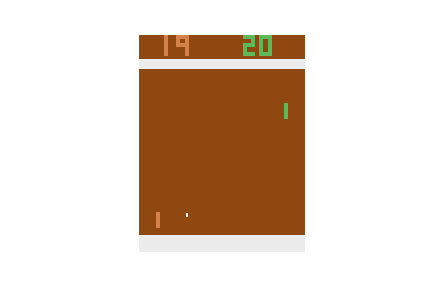
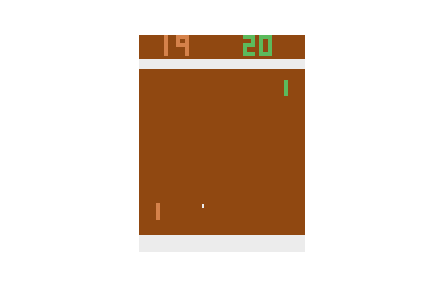
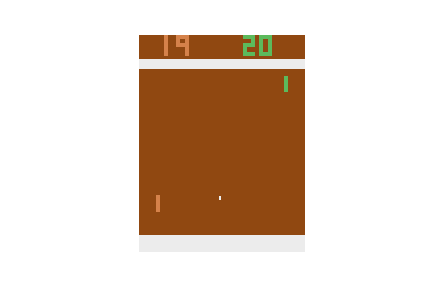
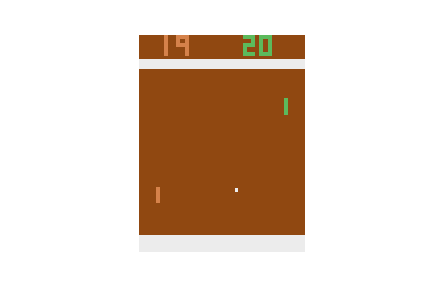
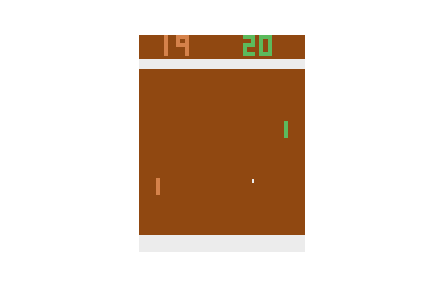
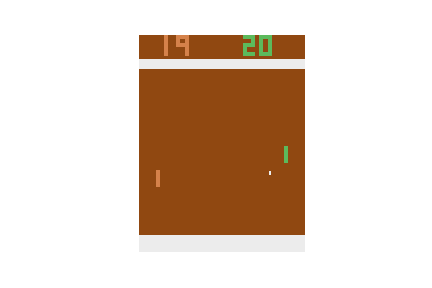
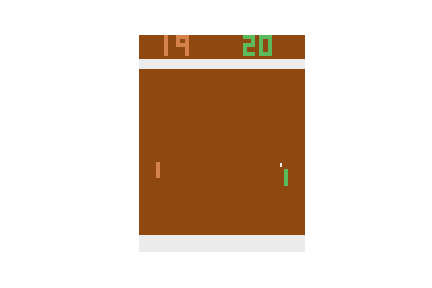
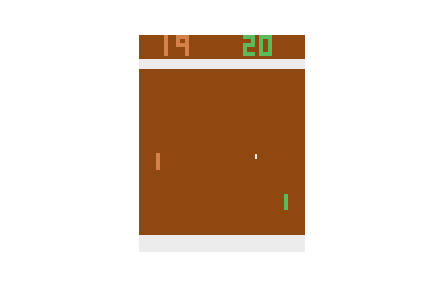
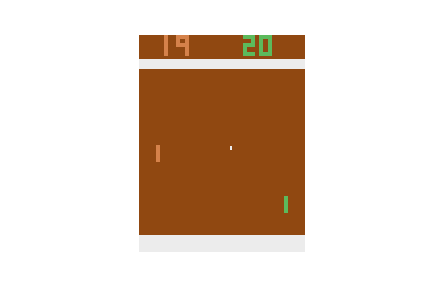
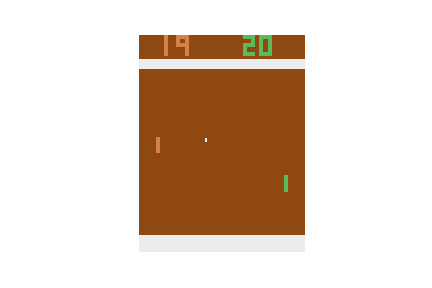
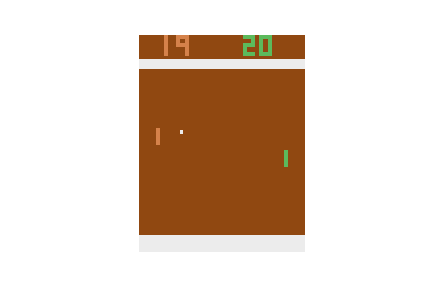
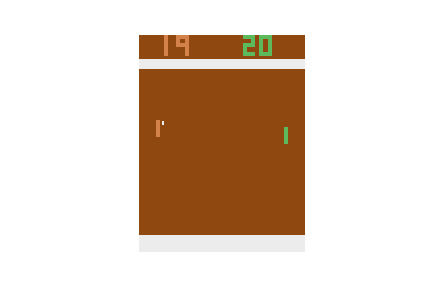
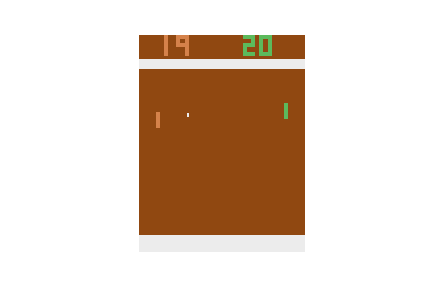
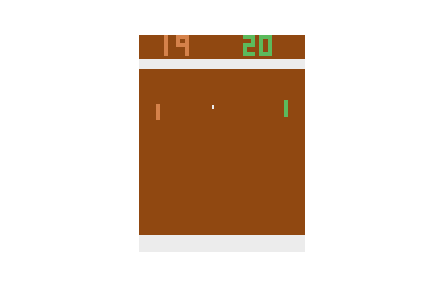
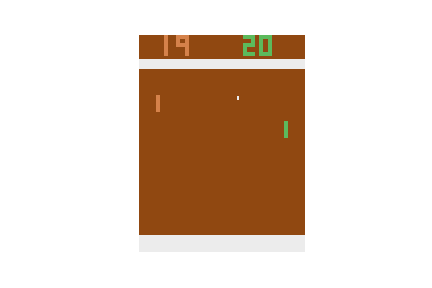
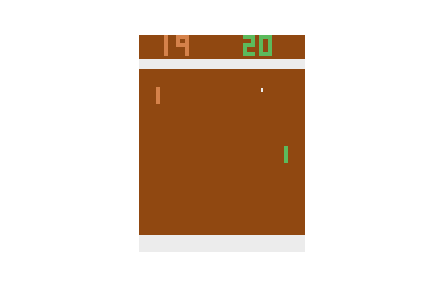
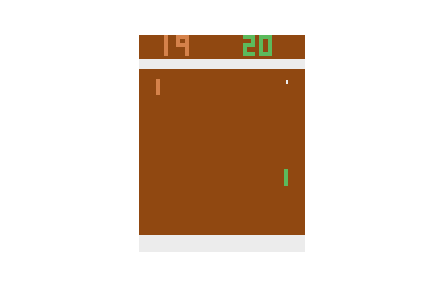
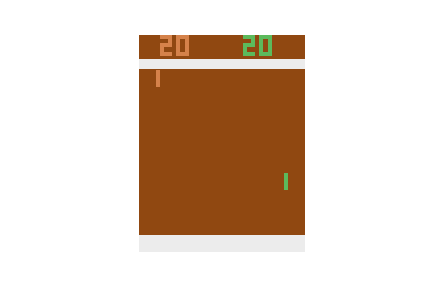
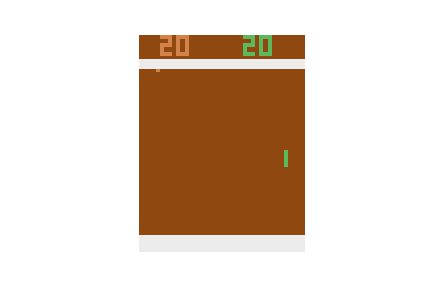
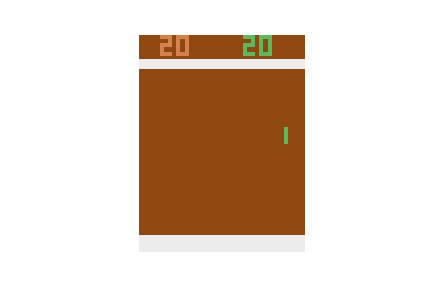
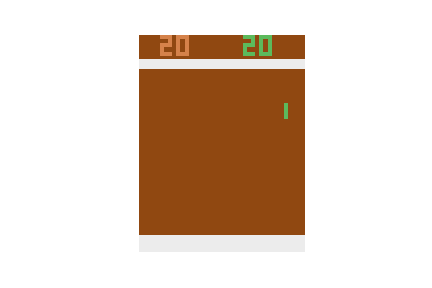
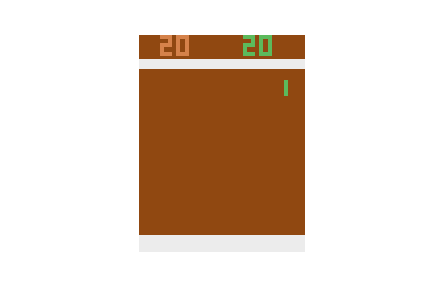
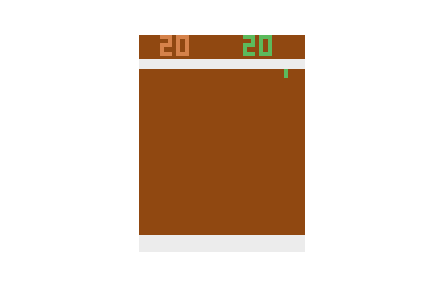
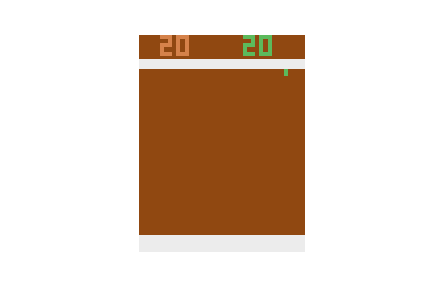
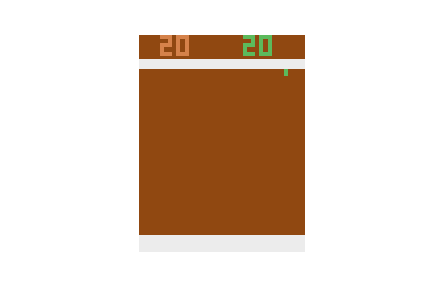
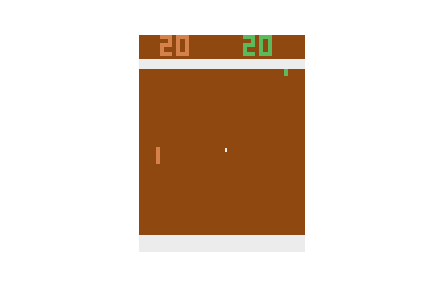
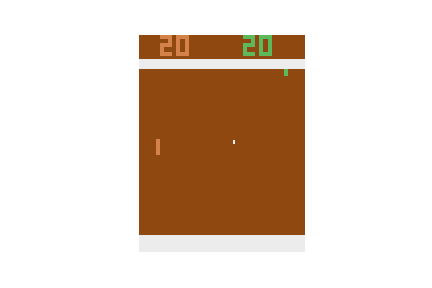
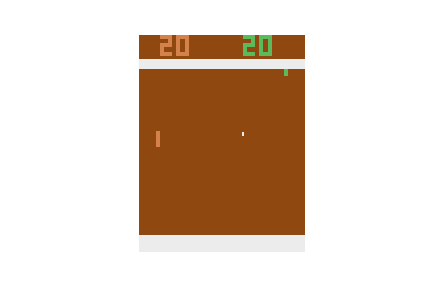
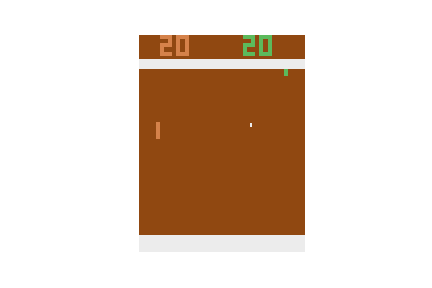
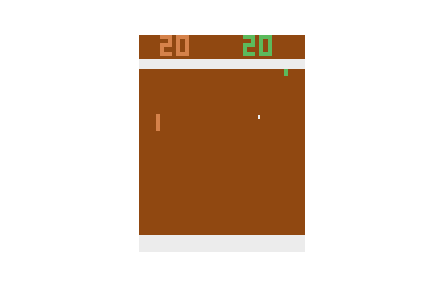
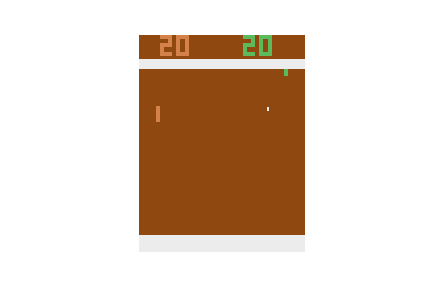
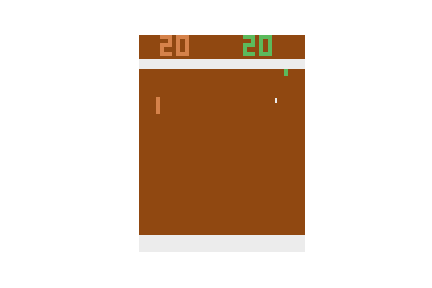
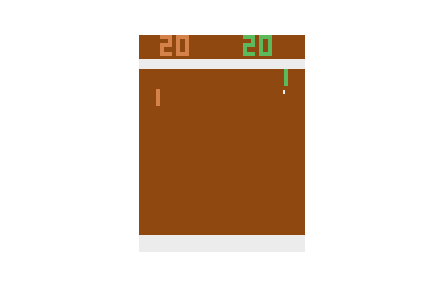
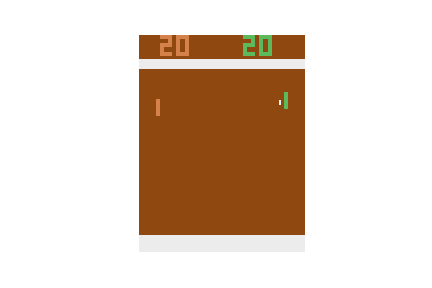
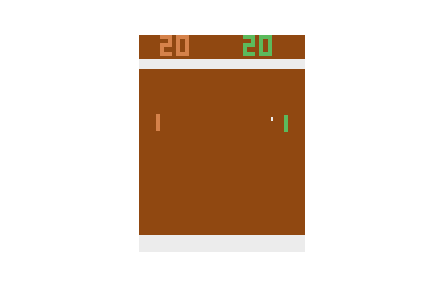
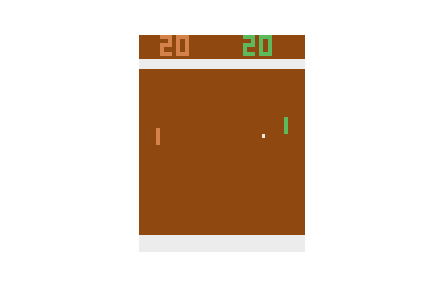
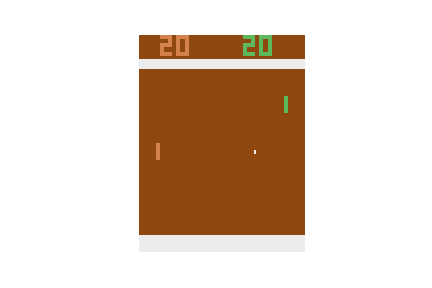
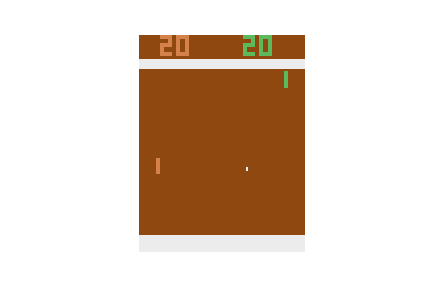
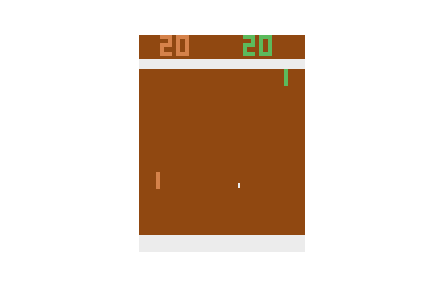
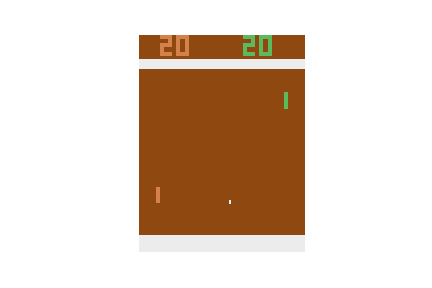
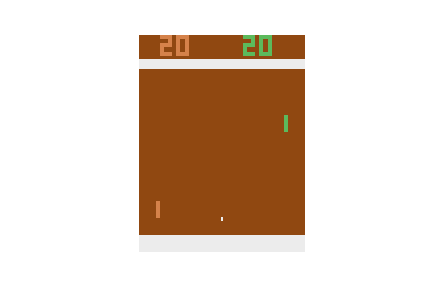
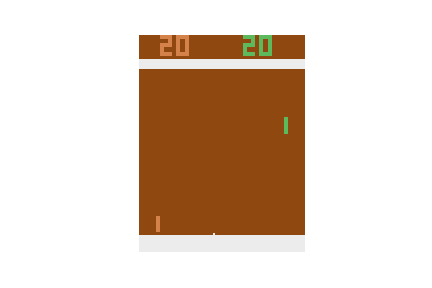
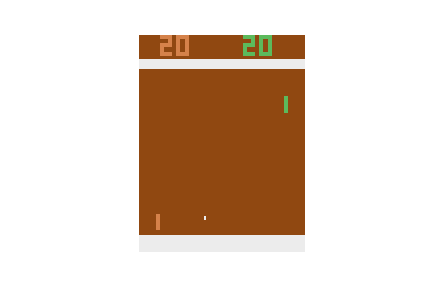
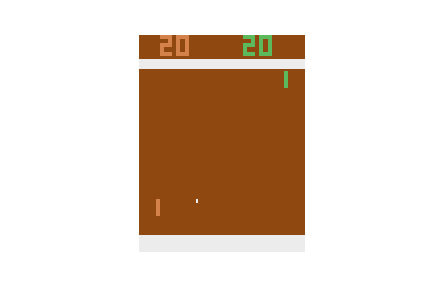
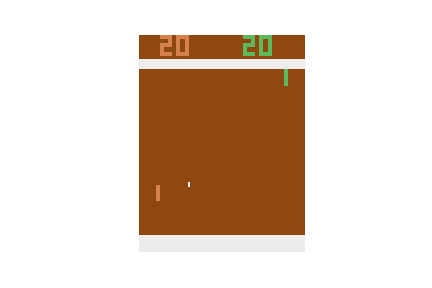
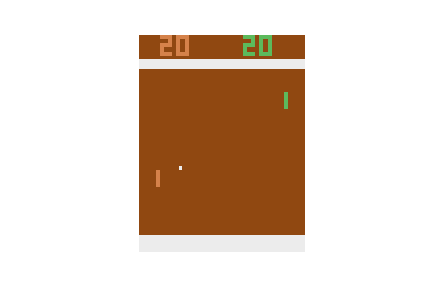
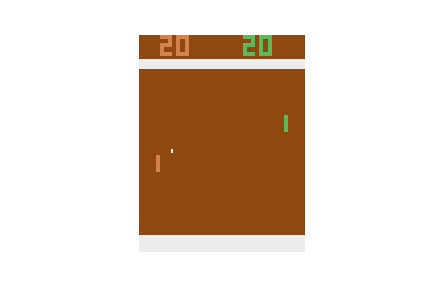
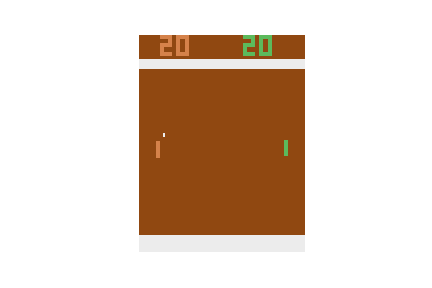
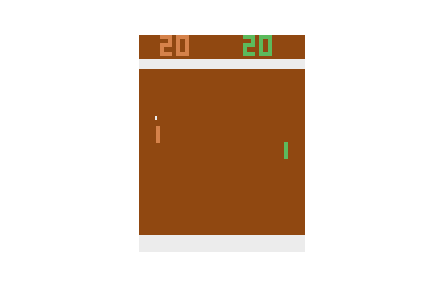
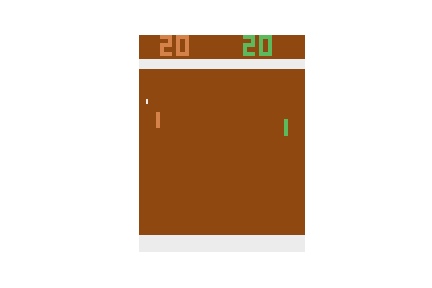
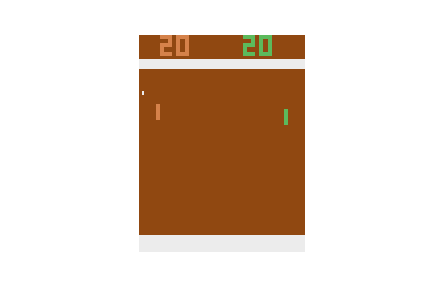

In [8]:
pong_utils.play(env, policy, time=2000) 

In [9]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 

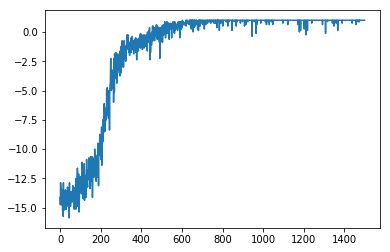

In [7]:
plt.plot(mean_rewards)
#learnt at around 600